<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/rain_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S4E10 - Rain Forecast**

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

## Intro: Problem Statement

<div class="container">
        <p class="mb-2">
            Analyze weather data over a 5-day period to identify patterns and correlations between various meteorological factors such as pressure, temperature, humidity, and rainfall. This can help in understanding how these variables influence daily weather conditions.
        </p>
        <h1 class="mb-2">Dataset Description</h1>
        <p class="mb-2">The dataset captures weather data over five days with the following features:</p>
        <ul class="mb-2">
            <li class="mb-2"><strong>day:</strong> Sequential day number.</li>
            <li class="mb-2"><strong>pressure (hPa):</strong> Atmospheric pressure measured in hectopascals.</li>
            <li class="mb-2"><strong>maxtemp (°C):</strong> Maximum temperature recorded on the day.</li>
            <li class="mb-2"><strong>temperature (°C):</strong> Average temperature of the day.</li>
            <li class="mb-2"><strong>mintemp (°C):</strong> Minimum temperature recorded on the day.</li>
            <li class="mb-2"><strong>dewpoint (°C):</strong> Temperature at which air becomes saturated with moisture.</li>
            <li class="mb-2"><strong>humidity (%):</strong> Relative humidity percentage.</li>
            <li class="mb-2"><strong>cloud (%):</strong> Cloud cover percentage.</li>
            <li class="mb-2"><strong>rainfall:</strong> Indicates if rainfall occurred ("yes"/"no").</li>
            <li class="mb-2"><strong>sunshine (hours):</strong> Total sunshine hours.</li>
            <li class="mb-2"><strong>winddirection (°):</strong> Direction of the wind in degrees.</li>
            <li class="mb-2"><strong>windspeed (km/h):</strong> Speed of the wind.</li>
        </ul>
        <p class="mb-2">
            This dataset is ideal for basic weather pattern analysis and visualization.
        </p>
    </div>

## 1.0 Libraries

In [ ]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops

#from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
import skops.io as sio
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.wrapper import PolynomialWrapper
from category_encoders.count import CountEncoder
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 960x660 with 0 Axes>

In [ ]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.0 Loading and Preprocessing Data


In [ ]:
df_subm = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv", index_col=0)

validation = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_old_all_ext.csv")
train = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_new_all_ext.csv")
test = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test_enc_all_ext.csv")

In [ ]:
#df_train_old.isna().sum()

In [ ]:
train.shape, test.shape, validation.shape

((2190, 31), (730, 30), (365, 31))

In [ ]:
df_all_new = pd.concat([train, test], axis=0)
print(df_all_new.shape)
df_all_new.head(3)

(2920, 31)


pressure  temparature  dewpoint  humidity     cloud  sunshine  windspeed  \
0  0.654955    -0.629296 -0.183091  0.638922  0.692700 -0.745242  -0.460377   
1  1.019030    -1.329863 -0.924418  1.616306  0.853347 -1.044309   0.013515   
2  1.816533    -1.481337 -2.054941 -0.827153 -1.502805  1.212287  -0.369632   

       Wdsx      Wdsy  Year_sin  Year_cos   sem_sin   sem_cos    m4_sin  \
0  0.266192  0.404027  0.017213  0.999852  0.034422  0.999407  0.051620   
1  0.627866  0.523115  0.034422  0.999407  0.068802  0.997630  0.103102   
2  0.107086  0.537809  0.051620  0.998667  0.103102  0.994671  0.154309   

     m4_cos    m6_sin    m6_cos    m8_sin    m8_cos  temp_diff  \
0  0.998667  0.103102  0.994671  0.137279  0.990532  -1.885535   
1  0.994671  0.205104  0.978740  0.271958  0.962309  -2.468657   
2  0.988023  0.304921  0.952378  0.401488  0.915864   0.382156   

   dewpoint_spread  range_dist_cloud  cloud_Humidity_Interaction  \
0        -1.201297         -1.147765                    0.202762   
1        -1.047000         -1.714207                    1.785597   
2         1.678918         -1.102818                   -1.006968   

   cloud_sunshine  rolling_cloud_mean  rolling_humidity_mean  cloud_ratio  \
0       -0.667113            1.179413               1.133104    -0.012575   
1       -1.143049            1.316221               2.001867     0.056245   
2        0.774952            0.024150               0.843517    -1.556966   

   humidity_ratio      mean       std  rainfall  
0       -0.002483 -0.663821 -0.432092       1.0  
1        0.489094 -0.509969  1.260600       1.0  
2       -1.394965 -1.414627  0.788521       1.0

In [ ]:
df_all_new.tail(3)

pressure  temparature  dewpoint  humidity     cloud  sunshine  windspeed  \
727  1.573820    -1.026915 -0.905885  1.249787  1.121091 -1.044309   0.013515   
728  0.134842    -0.742902 -0.108959  1.494133  0.960444 -1.044309   1.788088   
729  1.261754    -0.970113 -1.313614 -0.338461  0.746249 -0.989933   2.907279   

         Wdsx      Wdsy      Year_sin  Year_cos       sem_sin   sem_cos  \
727  0.627866  0.523115 -3.442161e-02  0.999407 -6.880243e-02  0.997630   
728  1.374918  1.376816 -1.721336e-02  0.999852 -3.442161e-02  0.999407   
729  1.368967  2.235567 -2.449294e-16  1.000000 -4.898587e-16  1.000000   

           m4_sin    m4_cos        m6_sin    m6_cos        m8_sin    m8_cos  \
727 -1.031017e-01  0.994671 -2.051045e-01  0.978740 -2.719582e-01  0.962309   
728 -5.161967e-02  0.998667 -1.031017e-01  0.994671 -1.372788e-01  0.990532   
729 -7.347881e-16  1.000000 -1.469576e-15  1.000000 -1.959435e-15  1.000000   

     temp_diff  dewpoint_spread  range_dist_cloud  cloud_Humidity_Interaction  \
727  -0.136173        -0.275514          1.099351                    1.826335   
728  -1.885537        -1.715621         -1.049108                    1.789645   
729   0.641322         1.010296          1.462053                    1.115856   

     cloud_sunshine  rolling_cloud_mean  rolling_humidity_mean  cloud_ratio  \
727       -1.143049            1.361823               1.288241     0.261176   
728       -1.143049            1.387882               1.877758     0.110873   
729       -1.055532            1.453028               1.691595    -0.102823   

     humidity_ratio      mean       std  rainfall  
727        0.543936  1.075949  0.195290       NaN  
728        0.439198  0.778698  1.009724       NaN  
729       -1.322370  1.730059  1.154792       NaN

In [ ]:
step = 1

past = 7
future = 0
learning_rate = 0.01
batch_size = 64
epochs = 21

test_final = df_all_new.iloc[2190-past+1:,:]

In [ ]:
# Train data
x_train = train.iloc[:,:-1].values
y_train = train.iloc[past-1:,-1].values.reshape(-1,1)
print(x_train.shape, y_train.shape)
# Valid Data
x_valid = validation.iloc[:,:-1].values
y_valid = validation.iloc[past-1:,-1].values.reshape(-1,1)
print(x_valid.shape, y_valid.shape)
# Test Data
x_test = test_final.iloc[:,:-1].values
y_test = test_final.iloc[past-1:,-1].values.reshape(-1,1)
print(x_test.shape, y_test.shape)

(2190, 30) (2184, 1)
(365, 30) (359, 1)
(736, 30) (730, 1)


## 3.0 Dataset Management Functions

## Version 0

####  **3.1 Train Dataset**

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_train,
                                                                    y_train,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=10000,
                                                                    shuffle=True
                                                                 )


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (2184, 7, 30)
Target shape: (2184, 1)


In [ ]:
# Find indices of 0s
indices_of_zeros = np.where(targets.numpy() == 0)[0]

# Find indices of 1s
indices_of_ones = np.where(targets.numpy() == 1)[0]

In [ ]:
indices_of_zeros.shape,indices_of_ones.shape

((539,), (1645,))

* **TRAIN DATASET - INFINITE SAMPLING**

* **GOAL: Oversample the minority class**
A related approach would be to resample the dataset by oversampling the minority class.

In [ ]:
pos_features = inputs.numpy()[indices_of_ones]
neg_features = inputs.numpy()[indices_of_zeros]

pos_labels = targets.numpy()[indices_of_ones]
neg_labels = targets.numpy()[indices_of_zeros]

pos_features.shape,pos_labels.shape,neg_features.shape,neg_labels.shape

((1645, 7, 30), (1645, 1), (539, 7, 30), (539, 1))

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for num, (features, label) in enumerate(pos_ds.take(10)):
  #print("Features:\n", features.numpy())
  #print()
  print(f"Label sample {num}: ", label.numpy())

Label sample 0:  [1]
Label sample 1:  [1]
Label sample 2:  [1]
Label sample 3:  [1]
Label sample 4:  [1]
Label sample 5:  [1]
Label sample 6:  [1]
Label sample 7:  [1]
Label sample 8:  [1]
Label sample 9:  [1]


In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(64).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5


#### **3.2 Validation Dataset**

In [ ]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_valid,
                                                                    y_valid,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_validation.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 30)
Target shape: (64, 1)


#### **3.3 Test Dataset**

In [ ]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_test,
                                                                    y_test,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_test.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 30)
Target shape: (64, 1)


## Version 1

In [ ]:
train_1 = train.copy()
validation_1 = validation.copy()
test_1 = test.copy()

train_1 = pd.concat([validation_1,train_1], axis=0, ignore_index=True)

In [ ]:
# Train data
x_train = train.iloc[:,:-1].values
y_train = train.iloc[past-1:,-1].values.reshape(-1,1)
print(x_train.shape, y_train.shape)
# Valid Data
x_valid = validation.iloc[:,:-1].values
y_valid = validation.iloc[past-1:,-1].values.reshape(-1,1)
print(x_valid.shape, y_valid.shape)
# Test Data
x_test = test_final.iloc[:,:-1].values
y_test = test_final.iloc[past-1:,-1].values.reshape(-1,1)
print(x_test.shape, y_test.shape)

####  **3.1 Train Dataset**

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_train,
                                                                    y_train,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=10000,
                                                                    shuffle=True
                                                                 )


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (2184, 7, 30)
Target shape: (2184, 1)


In [ ]:
# Find indices of 0s
indices_of_zeros = np.where(targets.numpy() == 0)[0]

# Find indices of 1s
indices_of_ones = np.where(targets.numpy() == 1)[0]

In [ ]:
indices_of_zeros.shape,indices_of_ones.shape

((539,), (1645,))

* **TRAIN DATASET - INFINITE SAMPLING**

* **GOAL: Oversample the minority class**
A related approach would be to resample the dataset by oversampling the minority class.

In [ ]:
pos_features = inputs.numpy()[indices_of_ones]
neg_features = inputs.numpy()[indices_of_zeros]

pos_labels = targets.numpy()[indices_of_ones]
neg_labels = targets.numpy()[indices_of_zeros]

pos_features.shape,pos_labels.shape,neg_features.shape,neg_labels.shape

((1645, 7, 30), (1645, 1), (539, 7, 30), (539, 1))

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for num, (features, label) in enumerate(pos_ds.take(10)):
  #print("Features:\n", features.numpy())
  #print()
  print(f"Label sample {num}: ", label.numpy())

Label sample 0:  [1]
Label sample 1:  [1]
Label sample 2:  [1]
Label sample 3:  [1]
Label sample 4:  [1]
Label sample 5:  [1]
Label sample 6:  [1]
Label sample 7:  [1]
Label sample 8:  [1]
Label sample 9:  [1]


In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(64).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5


#### **3.2 Validation Dataset**

In [ ]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_valid,
                                                                    y_valid,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_validation.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 30)
Target shape: (64, 1)


#### **3.3 Test Dataset**

In [ ]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_test,
                                                                    y_test,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_test.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 30)
Target shape: (64, 1)


## 4.0 NN Models:

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
step = 1

past = 7
future = 0
learning_rate = 0.01
batch_size = 64
epochs = 101

In [ ]:
METRICS = [
          keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

### 4.1 LSTM v0

In [ ]:
def make_model(metrics=METRICS, units=[32,32], output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_noised = keras.layers.GaussianNoise(stddev=0.05, name="noise_layer")(data)
  lstm_out = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0")(data_noised)
  lstm_out = keras.layers.LSTM(units[1], name="lstm_1")(lstm_out)
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(lstm_out)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,64])

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

#### Fit the model

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

In [ ]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=epochs,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

In [ ]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [ ]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_v2_all_data.csv")

### 4.2 LSTM-Tab v0

In [ ]:
def make_model(metrics=METRICS, units=[32,32],units_tab=[64,32], output_bias=None, gn=0.025, activation="relu", do=0.3):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_tabular = data[:, 6, :]
  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  lstm_out = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0",)(data_noised)
  lstm_out = keras.layers.LSTM(units[1], name="lstm_1")(lstm_out)

  # Tabular Section
  tabx = keras.layers.Dense(units_tab[0], name="dense_0")(data_tabular)
  tabx = keras.layers.BatchNormalization(name="batch_0")(tabx)
  tabx = keras.layers.Activation(activation, name="act_0")(tabx)
  tabx = keras.layers.Dropout(do, name="do_0")(tabx)
  tabx = keras.layers.Dense(units_tab[1], name="dense_1")(tabx)
  tabx = keras.layers.BatchNormalization(name="batch_1")(tabx)
  tabx = keras.layers.Activation(activation, name="act_1")(tabx)
  tabx = keras.layers.Dropout(do, name="do_1")(tabx)

  # Concatenate
  x = keras.layers.Concatenate(name="concat")([lstm_out, tabx,data_tabular])
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_tab_v1")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,32],output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

Model: "LSTM_tab_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 30)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 30)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_0 (Dense)           │ (None, 64)             │          1,984 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_0                   │ (None, 64)             │            256 │ dense_0[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_0 (Activation)        │ (None, 64)             │              0 │ batch_0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ do_0 (Dropout)            │ (None, 64)             │              0 │ act_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ do_0[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ noise_layer               │ (None, 7, 30)          │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_1                   │ (None, 32)             │            128 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_0 (LSTM)             │ (None, 7, 64)          │         24,320 │ noise_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_1 (Activation)        │ (None, 32)             │              0 │ batch_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ lstm_0[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ do_1 (Dropout)            │ (None, 32)             │              0 │ act_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, 94)             │              0 │ lstm_1[0][0],          │
│                           │                        │                │ do_1[0][0],            │
│                           │                        │                │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             95 │ concat[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 41,279 (161.25 KB)

 Trainable params: 41,087 (160.50 KB)

 Non-trainable params: 192 (768.00 B)

#### Optuna Optimization

In [ ]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=make_model, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

[I 2025-03-08 22:11:57,556] A new study created in memory with name: no-name-a83b6ccf-ad7f-4d9d-afb6-848dd0222d5f


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - auc: 0.7986 - cross entropy: 0.6294 - loss: 0.6294 - prc: 0.7784 - val_auc: 0.8732 - val_cross entropy: 0.4551 - val_loss: 0.4551 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8929 - cross entropy: 0.4160 - loss: 0.4160 - prc: 0.8793 - val_auc: 0.8837 - val_cross entropy: 0.4377 - val_loss: 0.4377 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9064 - cross entropy: 0.3861 - loss: 0.3861 - prc: 0.8983 - val_auc: 0.8857 - val_cross entropy: 0.4380 - val_loss: 0.4380 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9137 - cross entropy: 0.3751 - loss: 0.3751 - prc: 0.9109 - val_auc: 0.8826 - val_cross entropy: 0.4406 - val_loss: 0.4406 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9229 - cross entropy: 0.3546 - loss

[I 2025-03-08 22:12:32,159] Trial 0 finished with value: 0.884454377749397 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'relu', 'gn': 0.09, 'do': 0.21000000000000002}. Best is trial 0 with value: 0.884454377749397.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - auc: 0.8371 - cross entropy: 0.5428 - loss: 0.5949 - prc: 0.8486 - val_auc: 0.8828 - val_cross entropy: 0.4958 - val_loss: 0.4958 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8985 - cross entropy: 0.4076 - loss: 0.4076 - prc: 0.8832 - val_auc: 0.8802 - val_cross entropy: 0.5098 - val_loss: 0.5098 - val_prc: 0.9356 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8921 - cross entropy: 0.4159 - loss: 0.4159 - prc: 0.8833 - val_auc: 0.8766 - val_cross entropy: 0.5151 - val_loss: 0.5151 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9109 - cross entropy: 0.3802 - loss: 0.3802 - prc: 0.9039 - val_auc: 0.8764 - val_cross entropy: 0.4766 - val_loss: 0.4766 - val_prc: 0.9324 - learning_rate: 3.0000e-04
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9002 - cross entropy: 0.4004 - 

[I 2025-03-08 22:13:13,285] Trial 1 finished with value: 0.8760110685398041 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'selu', 'gn': 0.02, 'do': 0.25}. Best is trial 0 with value: 0.884454377749397.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - auc: 0.7901 - cross entropy: 0.6047 - loss: 0.6788 - prc: 0.8042 - val_auc: 0.8699 - val_cross entropy: 0.4466 - val_loss: 0.4466 - val_prc: 0.9242 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8869 - cross entropy: 0.4241 - loss: 0.4241 - prc: 0.8676 - val_auc: 0.8789 - val_cross entropy: 0.4647 - val_loss: 0.4647 - val_prc: 0.9333 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9019 - cross entropy: 0.3960 - loss: 0.3960 - prc: 0.8880 - val_auc: 0.8748 - val_cross entropy: 0.4889 - val_loss: 0.4889 - val_prc: 0.9295 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9132 - cross entropy: 0.3733 - loss: 0.3733 - prc: 0.9026 - val_auc: 0.8780 - val_cross entropy: 0.4464 - val_loss: 0.4464 - val_prc: 0.9337 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8982 - cross entropy: 0.4048 - loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2025-03-08 22:13:45,956] Trial 2 finished with value: 0.8782815382432241 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.27}. Best is trial 0 with value: 0.884454377749397.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - auc: 0.8158 - cross entropy: 0.5726 - loss: 0.6396 - prc: 0.8254 - val_auc: 0.8617 - val_cross entropy: 0.4731 - val_loss: 0.4731 - val_prc: 0.9194 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8946 - cross entropy: 0.4102 - loss: 0.4102 - prc: 0.8827 - val_auc: 0.8714 - val_cross entropy: 0.5009 - val_loss: 0.5009 - val_prc: 0.9250 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9037 - cross entropy: 0.3940 - loss: 0.3940 - prc: 0.8992 - val_auc: 0.8767 - val_cross entropy: 0.4773 - val_loss: 0.4773 - val_prc: 0.9286 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9051 - cross entropy: 0.3907 - loss: 0.3907 - prc: 0.9038 - val_auc: 0.8772 - val_cross entropy: 0.4442 - val_loss: 0.4442 - val_prc: 0.9309 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9218 - cross entropy: 0.3562 - loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2025-03-08 22:14:24,537] Trial 3 finished with value: 0.8784589186888038 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.04, 'do': 0.30000000000000004}. Best is trial 0 with value: 0.884454377749397.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - auc: 0.7447 - cross entropy: 0.6400 - loss: 0.7241 - prc: 0.7618 - val_auc: 0.8830 - val_cross entropy: 0.4988 - val_loss: 0.4988 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8812 - cross entropy: 0.4393 - loss: 0.4393 - prc: 0.8511 - val_auc: 0.8875 - val_cross entropy: 0.5126 - val_loss: 0.5126 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8920 - cross entropy: 0.4140 - loss: 0.4140 - prc: 0.8773 - val_auc: 0.8842 - val_cross entropy: 0.4744 - val_loss: 0.4744 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8985 - cross entropy: 0.4028 - loss: 0.4028 - prc: 0.8879 - val_auc: 0.8790 - val_cross entropy: 0.4667 - val_loss: 0.4667 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9147 - cross entropy: 0.3725 - loss

[I 2025-03-08 22:15:08,825] Trial 4 finished with value: 0.8794877252731659 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.05, 'do': 0.42000000000000004}. Best is trial 0 with value: 0.884454377749397.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7266 - cross entropy: 0.6597 - loss: 0.7511 - prc: 0.7299 - val_auc: 0.8654 - val_cross entropy: 0.4986 - val_loss: 0.4986 - val_prc: 0.9222 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8745 - cross entropy: 0.4456 - loss: 0.4456 - prc: 0.8442 - val_auc: 0.8775 - val_cross entropy: 0.5078 - val_loss: 0.5078 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9001 - cross entropy: 0.3983 - loss: 0.3983 - prc: 0.8867 - val_auc: 0.8871 - val_cross entropy: 0.4609 - val_loss: 0.4609 - val_prc: 0.9401 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9057 - cross entropy: 0.3876 - loss: 0.3876 - prc: 0.8959 - val_auc: 0.8882 - val_cross entropy: 0.4542 - val_loss: 0.4542 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9082 - cross entropy: 0.3829 - loss

[I 2025-03-08 22:15:45,164] Trial 5 finished with value: 0.8879665105718746 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.04, 'do': 0.38}. Best is trial 5 with value: 0.8879665105718746.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.7683 - cross entropy: 0.5960 - loss: 0.6621 - prc: 0.7933 - val_auc: 0.8721 - val_cross entropy: 0.4466 - val_loss: 0.4466 - val_prc: 0.9289 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8772 - cross entropy: 0.4442 - loss: 0.4442 - prc: 0.8474 - val_auc: 0.8789 - val_cross entropy: 0.4621 - val_loss: 0.4621 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8928 - cross entropy: 0.4125 - loss: 0.4125 - prc: 0.8750 - val_auc: 0.8793 - val_cross entropy: 0.4692 - val_loss: 0.4692 - val_prc: 0.9326 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8870 - cross entropy: 0.4244 - loss: 0.4244 - prc: 0.8828 - val_auc: 0.8827 - val_cross entropy: 0.4507 - val_loss: 0.4507 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9053 - cross entropy: 0.3887 - loss

[I 2025-03-08 22:16:18,353] Trial 6 finished with value: 0.8823612884915567 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.31}. Best is trial 5 with value: 0.8879665105718746.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - auc: 0.8478 - cross entropy: 0.5077 - loss: 0.5365 - prc: 0.8575 - val_auc: 0.8763 - val_cross entropy: 0.4518 - val_loss: 0.4518 - val_prc: 0.9294 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8925 - cross entropy: 0.4151 - loss: 0.4151 - prc: 0.8784 - val_auc: 0.8837 - val_cross entropy: 0.4570 - val_loss: 0.4570 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9071 - cross entropy: 0.3845 - loss: 0.3845 - prc: 0.8983 - val_auc: 0.8816 - val_cross entropy: 0.4563 - val_loss: 0.4563 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9058 - cross entropy: 0.3870 - loss: 0.3870 - prc: 0.8990 - val_auc: 0.8773 - val_cross entropy: 0.4503 - val_loss: 0.4503 - val_prc: 0.9321 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9270 - cross entropy: 0.3460 - loss

[I 2025-03-08 22:16:54,951] Trial 7 finished with value: 0.8834255711650348 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.02, 'do': 0.42000000000000004}. Best is trial 5 with value: 0.8879665105718746.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - auc: 0.8248 - cross entropy: 0.5608 - loss: 0.6258 - prc: 0.8340 - val_auc: 0.8737 - val_cross entropy: 0.4365 - val_loss: 0.4365 - val_prc: 0.9270 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9000 - cross entropy: 0.4005 - loss: 0.4005 - prc: 0.8832 - val_auc: 0.8742 - val_cross entropy: 0.4700 - val_loss: 0.4700 - val_prc: 0.9258 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9076 - cross entropy: 0.3848 - loss: 0.3848 - prc: 0.9029 - val_auc: 0.8753 - val_cross entropy: 0.4453 - val_loss: 0.4453 - val_prc: 0.9288 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9266 - cross entropy: 0.3469 - loss: 0.3469 - prc: 0.9244 - val_auc: 0.8741 - val_cross entropy: 0.4241 - val_loss: 0.4241 - val_prc: 0.9319 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9283 - cross entropy: 0.3430 - loss

[I 2025-03-08 22:17:40,793] Trial 8 finished with value: 0.8758691641833405 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.04, 'do': 0.28}. Best is trial 5 with value: 0.8879665105718746.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - auc: 0.7798 - cross entropy: 0.5985 - loss: 0.6576 - prc: 0.7985 - val_auc: 0.8741 - val_cross entropy: 0.4776 - val_loss: 0.4776 - val_prc: 0.9285 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8869 - cross entropy: 0.4253 - loss: 0.4253 - prc: 0.8630 - val_auc: 0.8769 - val_cross entropy: 0.5187 - val_loss: 0.5187 - val_prc: 0.9302 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9029 - cross entropy: 0.3934 - loss: 0.3934 - prc: 0.8869 - val_auc: 0.8805 - val_cross entropy: 0.5025 - val_loss: 0.5025 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8992 - cross entropy: 0.4021 - loss: 0.4021 - prc: 0.8886 - val_auc: 0.8849 - val_cross entropy: 0.4265 - val_loss: 0.4265 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9099 - cross entropy: 0.3803 - loss

[I 2025-03-08 22:18:26,774] Trial 9 finished with value: 0.8850574712643678 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.39}. Best is trial 5 with value: 0.8879665105718746.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7245 - cross entropy: 0.6582 - loss: 0.7476 - prc: 0.7456 - val_auc: 0.8700 - val_cross entropy: 0.4845 - val_loss: 0.4845 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8833 - cross entropy: 0.4349 - loss: 0.4349 - prc: 0.8533 - val_auc: 0.8787 - val_cross entropy: 0.5142 - val_loss: 0.5142 - val_prc: 0.9333 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8960 - cross entropy: 0.4066 - loss: 0.4066 - prc: 0.8832 - val_auc: 0.8873 - val_cross entropy: 0.4726 - val_loss: 0.4726 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9088 - cross entropy: 0.3842 - loss: 0.3842 - prc: 0.9004 - val_auc: 0.8874 - val_cross entropy: 0.4428 - val_loss: 0.4428 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9039 - cross entropy: 0.3910 - loss

[I 2025-03-08 22:19:04,071] Trial 10 finished with value: 0.889953171562367 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.36}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7358 - cross entropy: 0.6511 - loss: 0.7403 - prc: 0.7501 - val_auc: 0.8631 - val_cross entropy: 0.5012 - val_loss: 0.5012 - val_prc: 0.9209 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8713 - cross entropy: 0.4506 - loss: 0.4506 - prc: 0.8429 - val_auc: 0.8793 - val_cross entropy: 0.5013 - val_loss: 0.5013 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8966 - cross entropy: 0.4047 - loss: 0.4047 - prc: 0.8766 - val_auc: 0.8844 - val_cross entropy: 0.4686 - val_loss: 0.4686 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8967 - cross entropy: 0.4062 - loss: 0.4062 - prc: 0.8881 - val_auc: 0.8892 - val_cross entropy: 0.4400 - val_loss: 0.4400 - val_prc: 0.9425 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9058 - cross entropy: 0.3873 - loss

[I 2025-03-08 22:19:40,821] Trial 11 finished with value: 0.8898112672059032 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.36}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7399 - cross entropy: 0.6475 - loss: 0.7358 - prc: 0.7529 - val_auc: 0.8676 - val_cross entropy: 0.4910 - val_loss: 0.4910 - val_prc: 0.9227 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8822 - cross entropy: 0.4323 - loss: 0.4323 - prc: 0.8597 - val_auc: 0.8815 - val_cross entropy: 0.4951 - val_loss: 0.4951 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8986 - cross entropy: 0.4030 - loss: 0.4030 - prc: 0.8827 - val_auc: 0.8822 - val_cross entropy: 0.4997 - val_loss: 0.4997 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9076 - cross entropy: 0.3875 - loss: 0.3875 - prc: 0.9016 - val_auc: 0.8828 - val_cross entropy: 0.4859 - val_loss: 0.4859 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9005 - cross entropy: 0.4000 - loss

[I 2025-03-08 22:20:18,088] Trial 12 finished with value: 0.8858734213140342 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.35}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - auc: 0.7282 - cross entropy: 0.6563 - loss: 0.7469 - prc: 0.7464 - val_auc: 0.8641 - val_cross entropy: 0.5002 - val_loss: 0.5002 - val_prc: 0.9222 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8750 - cross entropy: 0.4448 - loss: 0.4448 - prc: 0.8419 - val_auc: 0.8810 - val_cross entropy: 0.4924 - val_loss: 0.4924 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8988 - cross entropy: 0.4018 - loss: 0.4018 - prc: 0.8874 - val_auc: 0.8863 - val_cross entropy: 0.4913 - val_loss: 0.4913 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8988 - cross entropy: 0.4037 - loss: 0.4037 - prc: 0.8912 - val_auc: 0.8842 - val_cross entropy: 0.4514 - val_loss: 0.4514 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9160 - cross entropy: 0.3676 - loss

[I 2025-03-08 22:20:55,747] Trial 13 finished with value: 0.8858024691358025 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.35}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7225 - cross entropy: 0.6584 - loss: 0.7545 - prc: 0.7309 - val_auc: 0.8621 - val_cross entropy: 0.4982 - val_loss: 0.4982 - val_prc: 0.9203 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8702 - cross entropy: 0.4556 - loss: 0.4556 - prc: 0.8406 - val_auc: 0.8771 - val_cross entropy: 0.5248 - val_loss: 0.5248 - val_prc: 0.9320 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8894 - cross entropy: 0.4188 - loss: 0.4188 - prc: 0.8738 - val_auc: 0.8817 - val_cross entropy: 0.4838 - val_loss: 0.4838 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8950 - cross entropy: 0.4097 - loss: 0.4097 - prc: 0.8827 - val_auc: 0.8886 - val_cross entropy: 0.4333 - val_loss: 0.4333 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9108 - cross entropy: 0.3783 - loss

[I 2025-03-08 22:21:32,240] Trial 14 finished with value: 0.8886760323541932 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.45}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7303 - cross entropy: 0.6512 - loss: 0.7423 - prc: 0.7452 - val_auc: 0.8674 - val_cross entropy: 0.4933 - val_loss: 0.4933 - val_prc: 0.9237 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8881 - cross entropy: 0.4254 - loss: 0.4254 - prc: 0.8578 - val_auc: 0.8782 - val_cross entropy: 0.4939 - val_loss: 0.4939 - val_prc: 0.9333 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8877 - cross entropy: 0.4212 - loss: 0.4212 - prc: 0.8718 - val_auc: 0.8846 - val_cross entropy: 0.4931 - val_loss: 0.4931 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9032 - cross entropy: 0.3929 - loss: 0.3929 - prc: 0.8913 - val_auc: 0.8896 - val_cross entropy: 0.4496 - val_loss: 0.4496 - val_prc: 0.9430 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9219 - cross entropy: 0.3559 - loss

[I 2025-03-08 22:22:07,578] Trial 15 finished with value: 0.8894210302256279 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.35}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7264 - cross entropy: 0.6534 - loss: 0.7454 - prc: 0.7452 - val_auc: 0.8663 - val_cross entropy: 0.4851 - val_loss: 0.4851 - val_prc: 0.9227 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8856 - cross entropy: 0.4290 - loss: 0.4290 - prc: 0.8651 - val_auc: 0.8804 - val_cross entropy: 0.4869 - val_loss: 0.4869 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9004 - cross entropy: 0.4011 - loss: 0.4011 - prc: 0.8864 - val_auc: 0.8863 - val_cross entropy: 0.4713 - val_loss: 0.4713 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9127 - cross entropy: 0.3773 - loss: 0.3773 - prc: 0.9071 - val_auc: 0.8849 - val_cross entropy: 0.4635 - val_loss: 0.4635 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9081 - cross entropy: 0.3819 - loss

[I 2025-03-08 22:22:44,592] Trial 16 finished with value: 0.8862281822051936 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.38}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.7292 - cross entropy: 0.6504 - loss: 0.7433 - prc: 0.7480 - val_auc: 0.8675 - val_cross entropy: 0.4862 - val_loss: 0.4862 - val_prc: 0.9226 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8844 - cross entropy: 0.4315 - loss: 0.4315 - prc: 0.8545 - val_auc: 0.8806 - val_cross entropy: 0.4866 - val_loss: 0.4866 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8965 - cross entropy: 0.4060 - loss: 0.4060 - prc: 0.8805 - val_auc: 0.8836 - val_cross entropy: 0.4727 - val_loss: 0.4727 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9008 - cross entropy: 0.3954 - loss: 0.3954 - prc: 0.8870 - val_auc: 0.8834 - val_cross entropy: 0.4716 - val_loss: 0.4716 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9111 - cross entropy: 0.3798 - loss

[I 2025-03-08 22:23:21,668] Trial 17 finished with value: 0.8865474670072371 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.02, 'do': 0.33}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.8112 - cross entropy: 0.5717 - loss: 0.6354 - prc: 0.8198 - val_auc: 0.8786 - val_cross entropy: 0.5295 - val_loss: 0.5295 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8755 - cross entropy: 0.4496 - loss: 0.4496 - prc: 0.8499 - val_auc: 0.8723 - val_cross entropy: 0.5507 - val_loss: 0.5507 - val_prc: 0.9225 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8925 - cross entropy: 0.4169 - loss: 0.4169 - prc: 0.8779 - val_auc: 0.8740 - val_cross entropy: 0.5190 - val_loss: 0.5190 - val_prc: 0.9227 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8978 - cross entropy: 0.4054 - loss: 0.4054 - prc: 0.8938 - val_auc: 0.8765 - val_cross entropy: 0.4895 - val_loss: 0.4895 - val_prc: 0.9292 - learning_rate: 3.0000e-04
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9025 - cross entropy: 0.3964 - 

[I 2025-03-08 22:25:03,386] Trial 18 finished with value: 0.8773236838370938 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.03, 'do': 0.39}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - auc: 0.8279 - cross entropy: 0.5367 - loss: 0.5707 - prc: 0.8303 - val_auc: 0.8751 - val_cross entropy: 0.4702 - val_loss: 0.4702 - val_prc: 0.9279 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8924 - cross entropy: 0.4118 - loss: 0.4118 - prc: 0.8594 - val_auc: 0.8788 - val_cross entropy: 0.4903 - val_loss: 0.4903 - val_prc: 0.9318 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9028 - cross entropy: 0.3933 - loss: 0.3933 - prc: 0.8847 - val_auc: 0.8786 - val_cross entropy: 0.5027 - val_loss: 0.5027 - val_prc: 0.9307 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8999 - cross entropy: 0.4000 - loss: 0.4000 - prc: 0.8908 - val_auc: 0.8780 - val_cross entropy: 0.4790 - val_loss: 0.4790 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9109 - cross entropy: 0.3797 - loss

[I 2025-03-08 22:25:41,932] Trial 19 finished with value: 0.8812260536398466 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.03, 'do': 0.33}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7165 - cross entropy: 0.6639 - loss: 0.7589 - prc: 0.7260 - val_auc: 0.8623 - val_cross entropy: 0.4962 - val_loss: 0.4962 - val_prc: 0.9200 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8827 - cross entropy: 0.4337 - loss: 0.4337 - prc: 0.8471 - val_auc: 0.8788 - val_cross entropy: 0.4859 - val_loss: 0.4859 - val_prc: 0.9320 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8992 - cross entropy: 0.4019 - loss: 0.4019 - prc: 0.8875 - val_auc: 0.8846 - val_cross entropy: 0.4834 - val_loss: 0.4834 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8970 - cross entropy: 0.4042 - loss: 0.4042 - prc: 0.8863 - val_auc: 0.8849 - val_cross entropy: 0.4501 - val_loss: 0.4501 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9124 - cross entropy: 0.3750 - loss

[I 2025-03-08 22:26:18,036] Trial 20 finished with value: 0.8849155669079041 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.43000000000000005}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7270 - cross entropy: 0.6565 - loss: 0.7506 - prc: 0.7365 - val_auc: 0.8628 - val_cross entropy: 0.5013 - val_loss: 0.5013 - val_prc: 0.9205 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8872 - cross entropy: 0.4258 - loss: 0.4258 - prc: 0.8690 - val_auc: 0.8797 - val_cross entropy: 0.4949 - val_loss: 0.4949 - val_prc: 0.9336 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8843 - cross entropy: 0.4247 - loss: 0.4247 - prc: 0.8692 - val_auc: 0.8843 - val_cross entropy: 0.4846 - val_loss: 0.4846 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9001 - cross entropy: 0.3994 - loss: 0.3994 - prc: 0.8936 - val_auc: 0.8875 - val_cross entropy: 0.4374 - val_loss: 0.4374 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9138 - cross entropy: 0.3726 - loss

[I 2025-03-08 22:26:54,444] Trial 21 finished with value: 0.8873279409677877 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.36}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7322 - cross entropy: 0.6518 - loss: 0.7401 - prc: 0.7484 - val_auc: 0.8698 - val_cross entropy: 0.4848 - val_loss: 0.4848 - val_prc: 0.9245 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8832 - cross entropy: 0.4356 - loss: 0.4356 - prc: 0.8593 - val_auc: 0.8815 - val_cross entropy: 0.5048 - val_loss: 0.5048 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8894 - cross entropy: 0.4184 - loss: 0.4184 - prc: 0.8735 - val_auc: 0.8857 - val_cross entropy: 0.4919 - val_loss: 0.4919 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9060 - cross entropy: 0.3894 - loss: 0.3894 - prc: 0.9018 - val_auc: 0.8877 - val_cross entropy: 0.4522 - val_loss: 0.4522 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9118 - cross entropy: 0.3794 - loss

[I 2025-03-08 22:27:30,228] Trial 22 finished with value: 0.8876117496807152 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.36}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7321 - cross entropy: 0.6497 - loss: 0.7418 - prc: 0.7480 - val_auc: 0.8630 - val_cross entropy: 0.4926 - val_loss: 0.4926 - val_prc: 0.9207 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8799 - cross entropy: 0.4360 - loss: 0.4360 - prc: 0.8533 - val_auc: 0.8786 - val_cross entropy: 0.5079 - val_loss: 0.5079 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8976 - cross entropy: 0.4043 - loss: 0.4043 - prc: 0.8851 - val_auc: 0.8846 - val_cross entropy: 0.4851 - val_loss: 0.4851 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9052 - cross entropy: 0.3911 - loss: 0.3911 - prc: 0.8964 - val_auc: 0.8845 - val_cross entropy: 0.4418 - val_loss: 0.4418 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9137 - cross entropy: 0.3734 - loss

[I 2025-03-08 22:28:06,656] Trial 23 finished with value: 0.8841350929473536 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.08, 'do': 0.32}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7220 - cross entropy: 0.6575 - loss: 0.7491 - prc: 0.7355 - val_auc: 0.8651 - val_cross entropy: 0.4983 - val_loss: 0.4983 - val_prc: 0.9229 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8841 - cross entropy: 0.4322 - loss: 0.4322 - prc: 0.8515 - val_auc: 0.8814 - val_cross entropy: 0.5019 - val_loss: 0.5019 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8905 - cross entropy: 0.4202 - loss: 0.4202 - prc: 0.8810 - val_auc: 0.8847 - val_cross entropy: 0.4810 - val_loss: 0.4810 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9105 - cross entropy: 0.3791 - loss: 0.3791 - prc: 0.8986 - val_auc: 0.8856 - val_cross entropy: 0.4585 - val_loss: 0.4585 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9096 - cross entropy: 0.3777 - loss

[I 2025-03-08 22:28:44,165] Trial 24 finished with value: 0.8861572300269618 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.4}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7311 - cross entropy: 0.6496 - loss: 0.7410 - prc: 0.7522 - val_auc: 0.8635 - val_cross entropy: 0.4981 - val_loss: 0.4981 - val_prc: 0.9214 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8783 - cross entropy: 0.4395 - loss: 0.4395 - prc: 0.8519 - val_auc: 0.8814 - val_cross entropy: 0.4922 - val_loss: 0.4922 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8856 - cross entropy: 0.4253 - loss: 0.4253 - prc: 0.8742 - val_auc: 0.8858 - val_cross entropy: 0.4782 - val_loss: 0.4782 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9052 - cross entropy: 0.3883 - loss: 0.3883 - prc: 0.8938 - val_auc: 0.8855 - val_cross entropy: 0.4605 - val_loss: 0.4605 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9130 - cross entropy: 0.3738 - loss

[I 2025-03-08 22:29:23,580] Trial 25 finished with value: 0.885554136511991 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.35}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - auc: 0.7979 - cross entropy: 0.5576 - loss: 0.6137 - prc: 0.8123 - val_auc: 0.8569 - val_cross entropy: 0.5001 - val_loss: 0.5001 - val_prc: 0.9049 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8992 - cross entropy: 0.4021 - loss: 0.4021 - prc: 0.8855 - val_auc: 0.8721 - val_cross entropy: 0.4882 - val_loss: 0.4882 - val_prc: 0.9266 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9119 - cross entropy: 0.3776 - loss: 0.3776 - prc: 0.9041 - val_auc: 0.8767 - val_cross entropy: 0.4760 - val_loss: 0.4760 - val_prc: 0.9308 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9073 - cross entropy: 0.3848 - loss: 0.3848 - prc: 0.9006 - val_auc: 0.8781 - val_cross entropy: 0.4562 - val_loss: 0.4562 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9189 - cross entropy: 0.3632 - loss

[I 2025-03-08 22:30:09,978] Trial 26 finished with value: 0.8817227188874699 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.05, 'do': 0.29000000000000004}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7331 - cross entropy: 0.6572 - loss: 0.7489 - prc: 0.7553 - val_auc: 0.8656 - val_cross entropy: 0.4851 - val_loss: 0.4851 - val_prc: 0.9224 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8812 - cross entropy: 0.4378 - loss: 0.4378 - prc: 0.8570 - val_auc: 0.8773 - val_cross entropy: 0.5116 - val_loss: 0.5116 - val_prc: 0.9310 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8928 - cross entropy: 0.4125 - loss: 0.4125 - prc: 0.8724 - val_auc: 0.8807 - val_cross entropy: 0.5267 - val_loss: 0.5267 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8962 - cross entropy: 0.4081 - loss: 0.4081 - prc: 0.8856 - val_auc: 0.8865 - val_cross entropy: 0.4529 - val_loss: 0.4529 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9126 - cross entropy: 0.3775 - loss

[I 2025-03-08 22:30:46,889] Trial 27 finished with value: 0.886582943096353 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.02, 'do': 0.33}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.8257 - cross entropy: 0.5423 - loss: 0.5893 - prc: 0.8305 - val_auc: 0.8865 - val_cross entropy: 0.4661 - val_loss: 0.4661 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8773 - cross entropy: 0.4458 - loss: 0.4458 - prc: 0.8476 - val_auc: 0.8895 - val_cross entropy: 0.4602 - val_loss: 0.4602 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8807 - cross entropy: 0.4370 - loss: 0.4370 - prc: 0.8632 - val_auc: 0.8843 - val_cross entropy: 0.4767 - val_loss: 0.4767 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9019 - cross entropy: 0.3945 - loss: 0.3945 - prc: 0.8927 - val_auc: 0.8820 - val_cross entropy: 0.4760 - val_loss: 0.4760 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9032 - cross entropy: 0.3938 - loss

[I 2025-03-08 22:31:23,849] Trial 28 finished with value: 0.8851284234425997 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'selu', 'gn': 0.08, 'do': 0.37}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - auc: 0.8279 - cross entropy: 0.5503 - loss: 0.6028 - prc: 0.8321 - val_auc: 0.8674 - val_cross entropy: 0.4560 - val_loss: 0.4560 - val_prc: 0.9219 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9045 - cross entropy: 0.3911 - loss: 0.3911 - prc: 0.8868 - val_auc: 0.8721 - val_cross entropy: 0.4528 - val_loss: 0.4528 - val_prc: 0.9255 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9138 - cross entropy: 0.3724 - loss: 0.3724 - prc: 0.9097 - val_auc: 0.8737 - val_cross entropy: 0.4650 - val_loss: 0.4650 - val_prc: 0.9267 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9124 - cross entropy: 0.3759 - loss: 0.3759 - prc: 0.9114 - val_auc: 0.8762 - val_cross entropy: 0.4263 - val_loss: 0.4263 - val_prc: 0.9299 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9210 - cross entropy: 0.3590 - loss

[I 2025-03-08 22:31:58,032] Trial 29 finished with value: 0.876082020718036 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 128, 'activation': 'relu', 'gn': 0.09, 'do': 0.2}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7991 - cross entropy: 0.6104 - loss: 0.6898 - prc: 0.8121 - val_auc: 0.8725 - val_cross entropy: 0.4575 - val_loss: 0.4575 - val_prc: 0.9232 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8967 - cross entropy: 0.4063 - loss: 0.4063 - prc: 0.8808 - val_auc: 0.8761 - val_cross entropy: 0.4956 - val_loss: 0.4956 - val_prc: 0.9236 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9052 - cross entropy: 0.3873 - loss: 0.3873 - prc: 0.8941 - val_auc: 0.8780 - val_cross entropy: 0.4632 - val_loss: 0.4632 - val_prc: 0.9279 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9156 - cross entropy: 0.3705 - loss: 0.3705 - prc: 0.9177 - val_auc: 0.8791 - val_cross entropy: 0.4651 - val_loss: 0.4651 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9150 - cross entropy: 0.3691 - loss

[I 2025-03-08 22:32:36,758] Trial 30 finished with value: 0.8862991343834256 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.08, 'do': 0.24000000000000002}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7297 - cross entropy: 0.6681 - loss: 0.7524 - prc: 0.7501 - val_auc: 0.8672 - val_cross entropy: 0.4889 - val_loss: 0.4889 - val_prc: 0.9237 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8738 - cross entropy: 0.4461 - loss: 0.4461 - prc: 0.8442 - val_auc: 0.8802 - val_cross entropy: 0.4861 - val_loss: 0.4861 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8847 - cross entropy: 0.4288 - loss: 0.4288 - prc: 0.8663 - val_auc: 0.8839 - val_cross entropy: 0.5124 - val_loss: 0.5124 - val_prc: 0.9366 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9138 - cross entropy: 0.3734 - loss: 0.3734 - prc: 0.9070 - val_auc: 0.8850 - val_cross entropy: 0.4504 - val_loss: 0.4504 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9022 - cross entropy: 0.3954 - loss

[I 2025-03-08 22:33:13,459] Trial 31 finished with value: 0.88495104299702 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.44}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7135 - cross entropy: 0.6663 - loss: 0.7563 - prc: 0.7311 - val_auc: 0.8604 - val_cross entropy: 0.4940 - val_loss: 0.4940 - val_prc: 0.9185 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8786 - cross entropy: 0.4411 - loss: 0.4411 - prc: 0.8479 - val_auc: 0.8784 - val_cross entropy: 0.4980 - val_loss: 0.4980 - val_prc: 0.9323 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8913 - cross entropy: 0.4163 - loss: 0.4163 - prc: 0.8735 - val_auc: 0.8888 - val_cross entropy: 0.4677 - val_loss: 0.4677 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8902 - cross entropy: 0.4175 - loss: 0.4175 - prc: 0.8822 - val_auc: 0.8863 - val_cross entropy: 0.4821 - val_loss: 0.4821 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9194 - cross entropy: 0.3635 - loss

[I 2025-03-08 22:33:51,551] Trial 32 finished with value: 0.8869377039875125 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.45}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - auc: 0.7377 - cross entropy: 0.6410 - loss: 0.7289 - prc: 0.7493 - val_auc: 0.8651 - val_cross entropy: 0.4937 - val_loss: 0.4937 - val_prc: 0.9229 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8918 - cross entropy: 0.4169 - loss: 0.4169 - prc: 0.8734 - val_auc: 0.8821 - val_cross entropy: 0.4815 - val_loss: 0.4815 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9060 - cross entropy: 0.3891 - loss: 0.3891 - prc: 0.8916 - val_auc: 0.8874 - val_cross entropy: 0.4512 - val_loss: 0.4512 - val_prc: 0.9419 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9068 - cross entropy: 0.3843 - loss: 0.3843 - prc: 0.8987 - val_auc: 0.8864 - val_cross entropy: 0.4266 - val_loss: 0.4266 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9065 - cross entropy: 0.3848 - los

[I 2025-03-08 22:34:31,037] Trial 33 finished with value: 0.886582943096353 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.02, 'do': 0.23}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7737 - cross entropy: 0.5860 - loss: 0.6525 - prc: 0.7874 - val_auc: 0.8601 - val_cross entropy: 0.4806 - val_loss: 0.4806 - val_prc: 0.9144 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8889 - cross entropy: 0.4217 - loss: 0.4217 - prc: 0.8665 - val_auc: 0.8729 - val_cross entropy: 0.4893 - val_loss: 0.4893 - val_prc: 0.9284 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9030 - cross entropy: 0.3939 - loss: 0.3939 - prc: 0.8847 - val_auc: 0.8787 - val_cross entropy: 0.4800 - val_loss: 0.4800 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9010 - cross entropy: 0.3964 - loss: 0.3964 - prc: 0.8901 - val_auc: 0.8766 - val_cross entropy: 0.4647 - val_loss: 0.4647 - val_prc: 0.9321 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9194 - cross entropy: 0.3632 - loss

[I 2025-03-08 22:35:07,370] Trial 34 finished with value: 0.8782105860649921 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.03, 'do': 0.4}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - auc: 0.7521 - cross entropy: 0.6213 - loss: 0.7016 - prc: 0.7594 - val_auc: 0.8688 - val_cross entropy: 0.5014 - val_loss: 0.5014 - val_prc: 0.9252 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8837 - cross entropy: 0.4295 - loss: 0.4295 - prc: 0.8544 - val_auc: 0.8848 - val_cross entropy: 0.4762 - val_loss: 0.4762 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9084 - cross entropy: 0.3875 - loss: 0.3875 - prc: 0.8987 - val_auc: 0.8785 - val_cross entropy: 0.4997 - val_loss: 0.4997 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9037 - cross entropy: 0.3922 - loss: 0.3922 - prc: 0.8961 - val_auc: 0.8856 - val_cross entropy: 0.4429 - val_loss: 0.4429 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9148 - cross entropy: 0.3723 - loss

[I 2025-03-08 22:35:54,713] Trial 35 finished with value: 0.8856250886902228 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.41000000000000003}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.8429 - cross entropy: 0.5398 - loss: 0.5796 - prc: 0.8471 - val_auc: 0.8788 - val_cross entropy: 0.5127 - val_loss: 0.5127 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8874 - cross entropy: 0.4285 - loss: 0.4285 - prc: 0.8575 - val_auc: 0.8778 - val_cross entropy: 0.5136 - val_loss: 0.5136 - val_prc: 0.9320 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8889 - cross entropy: 0.4218 - loss: 0.4218 - prc: 0.8712 - val_auc: 0.8807 - val_cross entropy: 0.4670 - val_loss: 0.4670 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8928 - cross entropy: 0.4132 - loss: 0.4132 - prc: 0.8762 - val_auc: 0.8779 - val_cross entropy: 0.4862 - val_loss: 0.4862 - val_prc: 0.9307 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9021 - cross entropy: 0.3958 - loss

[I 2025-03-08 22:36:33,314] Trial 36 finished with value: 0.8800908187881368 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.02, 'do': 0.26}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.8008 - cross entropy: 0.5685 - loss: 0.6219 - prc: 0.8153 - val_auc: 0.8825 - val_cross entropy: 0.4474 - val_loss: 0.4474 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8857 - cross entropy: 0.4279 - loss: 0.4279 - prc: 0.8657 - val_auc: 0.8863 - val_cross entropy: 0.4687 - val_loss: 0.4687 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8960 - cross entropy: 0.4065 - loss: 0.4065 - prc: 0.8836 - val_auc: 0.8876 - val_cross entropy: 0.4673 - val_loss: 0.4673 - val_prc: 0.9401 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9126 - cross entropy: 0.3765 - loss: 0.3765 - prc: 0.9105 - val_auc: 0.8893 - val_cross entropy: 0.4441 - val_loss: 0.4441 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9113 - cross entropy: 0.3762 - loss

[I 2025-03-08 22:37:08,190] Trial 37 finished with value: 0.8893146019582802 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.31}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.8186 - cross entropy: 0.5475 - loss: 0.6037 - prc: 0.8331 - val_auc: 0.8833 - val_cross entropy: 0.4572 - val_loss: 0.4572 - val_prc: 0.9355 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8981 - cross entropy: 0.4044 - loss: 0.4044 - prc: 0.8784 - val_auc: 0.8885 - val_cross entropy: 0.4521 - val_loss: 0.4521 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9070 - cross entropy: 0.3873 - loss: 0.3873 - prc: 0.9011 - val_auc: 0.8861 - val_cross entropy: 0.4461 - val_loss: 0.4461 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9107 - cross entropy: 0.3799 - loss: 0.3799 - prc: 0.9073 - val_auc: 0.8800 - val_cross entropy: 0.4505 - val_loss: 0.4505 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9240 - cross entropy: 0.3533 - loss

[I 2025-03-08 22:37:43,497] Trial 38 finished with value: 0.8821129558677452 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.31}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.8088 - cross entropy: 0.5556 - loss: 0.6119 - prc: 0.8295 - val_auc: 0.8811 - val_cross entropy: 0.4581 - val_loss: 0.4581 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8975 - cross entropy: 0.4080 - loss: 0.4080 - prc: 0.8753 - val_auc: 0.8826 - val_cross entropy: 0.4894 - val_loss: 0.4894 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8960 - cross entropy: 0.4072 - loss: 0.4072 - prc: 0.8831 - val_auc: 0.8854 - val_cross entropy: 0.4764 - val_loss: 0.4764 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9038 - cross entropy: 0.3916 - loss: 0.3916 - prc: 0.9005 - val_auc: 0.8849 - val_cross entropy: 0.4643 - val_loss: 0.4643 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9126 - cross entropy: 0.3743 - loss

[I 2025-03-08 22:38:27,324] Trial 39 finished with value: 0.885554136511991 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'silu', 'gn': 0.04, 'do': 0.34}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.8050 - cross entropy: 0.6006 - loss: 0.6696 - prc: 0.8160 - val_auc: 0.8821 - val_cross entropy: 0.5135 - val_loss: 0.5135 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8879 - cross entropy: 0.4276 - loss: 0.4276 - prc: 0.8636 - val_auc: 0.8852 - val_cross entropy: 0.5012 - val_loss: 0.5012 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8830 - cross entropy: 0.4327 - loss: 0.4327 - prc: 0.8689 - val_auc: 0.8827 - val_cross entropy: 0.4831 - val_loss: 0.4831 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8979 - cross entropy: 0.4027 - loss: 0.4027 - prc: 0.8864 - val_auc: 0.8804 - val_cross entropy: 0.4773 - val_loss: 0.4773 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9092 - cross entropy: 0.3868 - loss

[I 2025-03-08 22:39:02,284] Trial 40 finished with value: 0.8800198666099049 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'selu', 'gn': 0.05, 'do': 0.30000000000000004}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.8039 - cross entropy: 0.5633 - loss: 0.6242 - prc: 0.8147 - val_auc: 0.8828 - val_cross entropy: 0.4547 - val_loss: 0.4547 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8946 - cross entropy: 0.4099 - loss: 0.4099 - prc: 0.8787 - val_auc: 0.8882 - val_cross entropy: 0.4776 - val_loss: 0.4776 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8997 - cross entropy: 0.4001 - loss: 0.4001 - prc: 0.8919 - val_auc: 0.8861 - val_cross entropy: 0.4735 - val_loss: 0.4735 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9008 - cross entropy: 0.3979 - loss: 0.3979 - prc: 0.8933 - val_auc: 0.8869 - val_cross entropy: 0.4388 - val_loss: 0.4388 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9137 - cross entropy: 0.3731 - loss

[I 2025-03-08 22:39:37,568] Trial 41 finished with value: 0.8878600823045267 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.28}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7982 - cross entropy: 0.5652 - loss: 0.6275 - prc: 0.8162 - val_auc: 0.8832 - val_cross entropy: 0.4551 - val_loss: 0.4551 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8872 - cross entropy: 0.4288 - loss: 0.4288 - prc: 0.8680 - val_auc: 0.8875 - val_cross entropy: 0.4746 - val_loss: 0.4746 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8858 - cross entropy: 0.4291 - loss: 0.4291 - prc: 0.8770 - val_auc: 0.8873 - val_cross entropy: 0.4595 - val_loss: 0.4595 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9008 - cross entropy: 0.3992 - loss: 0.3992 - prc: 0.8978 - val_auc: 0.8855 - val_cross entropy: 0.4488 - val_loss: 0.4488 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9086 - cross entropy: 0.3843 - loss

[I 2025-03-08 22:40:14,546] Trial 42 finished with value: 0.8855896126011068 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.37}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7320 - cross entropy: 0.6468 - loss: 0.7389 - prc: 0.7419 - val_auc: 0.8703 - val_cross entropy: 0.4748 - val_loss: 0.4748 - val_prc: 0.9247 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8945 - cross entropy: 0.4163 - loss: 0.4163 - prc: 0.8660 - val_auc: 0.8770 - val_cross entropy: 0.5008 - val_loss: 0.5008 - val_prc: 0.9318 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8960 - cross entropy: 0.4061 - loss: 0.4061 - prc: 0.8813 - val_auc: 0.8860 - val_cross entropy: 0.4869 - val_loss: 0.4869 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9008 - cross entropy: 0.4006 - loss: 0.4006 - prc: 0.8883 - val_auc: 0.8853 - val_cross entropy: 0.4561 - val_loss: 0.4561 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9098 - cross entropy: 0.3830 - loss

[I 2025-03-08 22:40:52,080] Trial 43 finished with value: 0.88931460195828 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.02, 'do': 0.31}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7895 - cross entropy: 0.6195 - loss: 0.7063 - prc: 0.7994 - val_auc: 0.8741 - val_cross entropy: 0.4747 - val_loss: 0.4747 - val_prc: 0.9242 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8947 - cross entropy: 0.4125 - loss: 0.4125 - prc: 0.8711 - val_auc: 0.8825 - val_cross entropy: 0.4755 - val_loss: 0.4755 - val_prc: 0.9321 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9036 - cross entropy: 0.3922 - loss: 0.3922 - prc: 0.8933 - val_auc: 0.8786 - val_cross entropy: 0.4839 - val_loss: 0.4839 - val_prc: 0.9310 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9040 - cross entropy: 0.3928 - loss: 0.3928 - prc: 0.9032 - val_auc: 0.8818 - val_cross entropy: 0.4583 - val_loss: 0.4583 - val_prc: 0.9343 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9164 - cross entropy: 0.3655 - loss

[I 2025-03-08 22:41:29,727] Trial 44 finished with value: 0.8831772385412232 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.02, 'do': 0.31}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7695 - cross entropy: 0.6080 - loss: 0.6817 - prc: 0.7867 - val_auc: 0.8621 - val_cross entropy: 0.5292 - val_loss: 0.5292 - val_prc: 0.9188 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8889 - cross entropy: 0.4192 - loss: 0.4192 - prc: 0.8712 - val_auc: 0.8783 - val_cross entropy: 0.5068 - val_loss: 0.5068 - val_prc: 0.9323 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9040 - cross entropy: 0.3930 - loss: 0.3930 - prc: 0.8986 - val_auc: 0.8806 - val_cross entropy: 0.4636 - val_loss: 0.4636 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9073 - cross entropy: 0.3860 - loss: 0.3860 - prc: 0.9026 - val_auc: 0.8803 - val_cross entropy: 0.4578 - val_loss: 0.4578 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9260 - cross entropy: 0.3489 - loss

[I 2025-03-08 22:42:08,145] Trial 45 finished with value: 0.8813679579963105 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.34}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - auc: 0.8035 - cross entropy: 0.5593 - loss: 0.6126 - prc: 0.8203 - val_auc: 0.8837 - val_cross entropy: 0.4422 - val_loss: 0.4422 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8909 - cross entropy: 0.4193 - loss: 0.4193 - prc: 0.8662 - val_auc: 0.8898 - val_cross entropy: 0.4469 - val_loss: 0.4469 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8973 - cross entropy: 0.4032 - loss: 0.4032 - prc: 0.8849 - val_auc: 0.8899 - val_cross entropy: 0.4566 - val_loss: 0.4566 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9022 - cross entropy: 0.3934 - loss: 0.3934 - prc: 0.8920 - val_auc: 0.8878 - val_cross entropy: 0.4304 - val_loss: 0.4304 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9100 - cross entropy: 0.3846 - loss

[I 2025-03-08 22:42:43,045] Trial 46 finished with value: 0.8878246062154108 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'relu', 'gn': 0.04, 'do': 0.32}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - auc: 0.7369 - cross entropy: 0.6359 - loss: 0.7282 - prc: 0.7495 - val_auc: 0.8700 - val_cross entropy: 0.4927 - val_loss: 0.4927 - val_prc: 0.9268 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8925 - cross entropy: 0.4157 - loss: 0.4157 - prc: 0.8673 - val_auc: 0.8816 - val_cross entropy: 0.4933 - val_loss: 0.4933 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9058 - cross entropy: 0.3889 - loss: 0.3889 - prc: 0.8927 - val_auc: 0.8826 - val_cross entropy: 0.4867 - val_loss: 0.4867 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9069 - cross entropy: 0.3857 - loss: 0.3857 - prc: 0.8973 - val_auc: 0.8802 - val_cross entropy: 0.4349 - val_loss: 0.4349 - val_prc: 0.9356 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9175 - cross entropy: 0.3673 - loss

[I 2025-03-08 22:43:30,017] Trial 47 finished with value: 0.8803036753228324 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.03, 'do': 0.30000000000000004}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7333 - cross entropy: 0.6535 - loss: 0.7462 - prc: 0.7460 - val_auc: 0.8634 - val_cross entropy: 0.5004 - val_loss: 0.5004 - val_prc: 0.9206 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8816 - cross entropy: 0.4380 - loss: 0.4380 - prc: 0.8546 - val_auc: 0.8814 - val_cross entropy: 0.4702 - val_loss: 0.4702 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9009 - cross entropy: 0.3991 - loss: 0.3991 - prc: 0.8908 - val_auc: 0.8859 - val_cross entropy: 0.4896 - val_loss: 0.4896 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9055 - cross entropy: 0.3922 - loss: 0.3922 - prc: 0.9037 - val_auc: 0.8897 - val_cross entropy: 0.4447 - val_loss: 0.4447 - val_prc: 0.9430 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9037 - cross entropy: 0.3894 - loss

[I 2025-03-08 22:44:06,849] Trial 48 finished with value: 0.8894919824038598 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.37}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7276 - cross entropy: 0.6535 - loss: 0.7451 - prc: 0.7438 - val_auc: 0.8702 - val_cross entropy: 0.4855 - val_loss: 0.4855 - val_prc: 0.9250 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8846 - cross entropy: 0.4318 - loss: 0.4318 - prc: 0.8513 - val_auc: 0.8830 - val_cross entropy: 0.4796 - val_loss: 0.4796 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8826 - cross entropy: 0.4303 - loss: 0.4303 - prc: 0.8612 - val_auc: 0.8834 - val_cross entropy: 0.4896 - val_loss: 0.4896 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8961 - cross entropy: 0.4067 - loss: 0.4067 - prc: 0.8884 - val_auc: 0.8865 - val_cross entropy: 0.4528 - val_loss: 0.4528 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9114 - cross entropy: 0.3776 - loss

[I 2025-03-08 22:44:45,684] Trial 49 finished with value: 0.8883922236412658 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.38}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.8109 - cross entropy: 0.5704 - loss: 0.6341 - prc: 0.8247 - val_auc: 0.8840 - val_cross entropy: 0.4532 - val_loss: 0.4532 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8962 - cross entropy: 0.4105 - loss: 0.4105 - prc: 0.8775 - val_auc: 0.8807 - val_cross entropy: 0.4898 - val_loss: 0.4898 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9018 - cross entropy: 0.3977 - loss: 0.3977 - prc: 0.8895 - val_auc: 0.8866 - val_cross entropy: 0.4647 - val_loss: 0.4647 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9141 - cross entropy: 0.3723 - loss: 0.3723 - prc: 0.9051 - val_auc: 0.8828 - val_cross entropy: 0.4463 - val_loss: 0.4463 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9141 - cross entropy: 0.3730 - loss

[I 2025-03-08 22:45:22,019] Trial 50 finished with value: 0.8833546189868029 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'silu', 'gn': 0.08, 'do': 0.36}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7258 - cross entropy: 0.6552 - loss: 0.7542 - prc: 0.7382 - val_auc: 0.8652 - val_cross entropy: 0.4917 - val_loss: 0.4917 - val_prc: 0.9225 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8807 - cross entropy: 0.4357 - loss: 0.4357 - prc: 0.8600 - val_auc: 0.8809 - val_cross entropy: 0.4895 - val_loss: 0.4895 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9023 - cross entropy: 0.3991 - loss: 0.3991 - prc: 0.8952 - val_auc: 0.8863 - val_cross entropy: 0.4762 - val_loss: 0.4762 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9084 - cross entropy: 0.3838 - loss: 0.3838 - prc: 0.9001 - val_auc: 0.8876 - val_cross entropy: 0.4302 - val_loss: 0.4302 - val_prc: 0.9415 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9022 - cross entropy: 0.3952 - loss

[I 2025-03-08 22:45:58,242] Trial 51 finished with value: 0.8873279409677878 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.34}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - auc: 0.7327 - cross entropy: 0.6470 - loss: 0.7381 - prc: 0.7478 - val_auc: 0.8689 - val_cross entropy: 0.4771 - val_loss: 0.4771 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8834 - cross entropy: 0.4369 - loss: 0.4369 - prc: 0.8608 - val_auc: 0.8807 - val_cross entropy: 0.4965 - val_loss: 0.4965 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8902 - cross entropy: 0.4189 - loss: 0.4189 - prc: 0.8712 - val_auc: 0.8798 - val_cross entropy: 0.5288 - val_loss: 0.5288 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9065 - cross entropy: 0.3873 - loss: 0.3873 - prc: 0.8923 - val_auc: 0.8859 - val_cross entropy: 0.4617 - val_loss: 0.4617 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9062 - cross entropy: 0.3880 - loss

[I 2025-03-08 22:46:35,437] Trial 52 finished with value: 0.8890307932453526 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.37}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - auc: 0.7386 - cross entropy: 0.6501 - loss: 0.7401 - prc: 0.7485 - val_auc: 0.8629 - val_cross entropy: 0.5060 - val_loss: 0.5060 - val_prc: 0.9201 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8818 - cross entropy: 0.4348 - loss: 0.4348 - prc: 0.8450 - val_auc: 0.8805 - val_cross entropy: 0.5106 - val_loss: 0.5106 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9059 - cross entropy: 0.3883 - loss: 0.3883 - prc: 0.8920 - val_auc: 0.8858 - val_cross entropy: 0.4763 - val_loss: 0.4763 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8943 - cross entropy: 0.4091 - loss: 0.4091 - prc: 0.8851 - val_auc: 0.8874 - val_cross entropy: 0.4492 - val_loss: 0.4492 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9099 - cross entropy: 0.3774 - los

[I 2025-03-08 22:47:16,291] Trial 53 finished with value: 0.8878600823045268 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.35}. Best is trial 10 with value: 0.889953171562367.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7244 - cross entropy: 0.6576 - loss: 0.7514 - prc: 0.7394 - val_auc: 0.8663 - val_cross entropy: 0.4955 - val_loss: 0.4955 - val_prc: 0.9239 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8817 - cross entropy: 0.4337 - loss: 0.4337 - prc: 0.8518 - val_auc: 0.8834 - val_cross entropy: 0.4934 - val_loss: 0.4934 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8961 - cross entropy: 0.4090 - loss: 0.4090 - prc: 0.8811 - val_auc: 0.8800 - val_cross entropy: 0.5111 - val_loss: 0.5111 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8928 - cross entropy: 0.4173 - loss: 0.4173 - prc: 0.8844 - val_auc: 0.8921 - val_cross entropy: 0.4444 - val_loss: 0.4444 - val_prc: 0.9446 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9031 - cross entropy: 0.3951 - loss

[I 2025-03-08 22:47:53,790] Trial 54 finished with value: 0.8921526890875551 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.39}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7289 - cross entropy: 0.6600 - loss: 0.7540 - prc: 0.7411 - val_auc: 0.8613 - val_cross entropy: 0.5101 - val_loss: 0.5101 - val_prc: 0.9190 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8737 - cross entropy: 0.4484 - loss: 0.4484 - prc: 0.8330 - val_auc: 0.8779 - val_cross entropy: 0.5206 - val_loss: 0.5206 - val_prc: 0.9306 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8918 - cross entropy: 0.4155 - loss: 0.4155 - prc: 0.8726 - val_auc: 0.8856 - val_cross entropy: 0.4948 - val_loss: 0.4948 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8998 - cross entropy: 0.3987 - loss: 0.3987 - prc: 0.8885 - val_auc: 0.8853 - val_cross entropy: 0.4232 - val_loss: 0.4232 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9126 - cross entropy: 0.3753 - loss

[I 2025-03-08 22:48:33,033] Trial 55 finished with value: 0.8897048389385553 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.39}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7149 - cross entropy: 0.6680 - loss: 0.7624 - prc: 0.7323 - val_auc: 0.8656 - val_cross entropy: 0.4605 - val_loss: 0.4605 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8754 - cross entropy: 0.4478 - loss: 0.4478 - prc: 0.8448 - val_auc: 0.8808 - val_cross entropy: 0.4775 - val_loss: 0.4775 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8998 - cross entropy: 0.4003 - loss: 0.4003 - prc: 0.8809 - val_auc: 0.8845 - val_cross entropy: 0.4480 - val_loss: 0.4480 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9051 - cross entropy: 0.3943 - loss: 0.3943 - prc: 0.9003 - val_auc: 0.8894 - val_cross entropy: 0.4287 - val_loss: 0.4287 - val_prc: 0.9425 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9143 - cross entropy: 0.3753 - loss

[I 2025-03-08 22:49:11,664] Trial 56 finished with value: 0.8892081736909322 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.39}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - auc: 0.7321 - cross entropy: 0.6409 - loss: 0.7322 - prc: 0.7392 - val_auc: 0.8747 - val_cross entropy: 0.4651 - val_loss: 0.4651 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.8870 - cross entropy: 0.4306 - loss: 0.4306 - prc: 0.8614 - val_auc: 0.8843 - val_cross entropy: 0.4760 - val_loss: 0.4760 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9035 - cross entropy: 0.3952 - loss: 0.3952 - prc: 0.8935 - val_auc: 0.8867 - val_cross entropy: 0.4762 - val_loss: 0.4762 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9087 - cross entropy: 0.3847 - loss: 0.3847 - prc: 0.9010 - val_auc: 0.8846 - val_cross entropy: 0.4329 - val_loss: 0.4329 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9075 - cross entropy: 0.3857 - loss

[I 2025-03-08 22:50:00,151] Trial 57 finished with value: 0.8844543777493968 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.08, 'do': 0.42000000000000004}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7900 - cross entropy: 0.5923 - loss: 0.6708 - prc: 0.8000 - val_auc: 0.8735 - val_cross entropy: 0.5360 - val_loss: 0.5360 - val_prc: 0.9279 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8902 - cross entropy: 0.4209 - loss: 0.4209 - prc: 0.8648 - val_auc: 0.8802 - val_cross entropy: 0.5270 - val_loss: 0.5270 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8923 - cross entropy: 0.4163 - loss: 0.4163 - prc: 0.8778 - val_auc: 0.8796 - val_cross entropy: 0.4983 - val_loss: 0.4983 - val_prc: 0.9355 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8895 - cross entropy: 0.4196 - loss: 0.4196 - prc: 0.8787 - val_auc: 0.8762 - val_cross entropy: 0.4645 - val_loss: 0.4645 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8925 - cross entropy: 0.4142 - loss

[I 2025-03-08 22:50:40,324] Trial 58 finished with value: 0.8800198666099049 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.38}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7162 - cross entropy: 0.6592 - loss: 0.7431 - prc: 0.7346 - val_auc: 0.8635 - val_cross entropy: 0.4918 - val_loss: 0.4918 - val_prc: 0.9217 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8799 - cross entropy: 0.4381 - loss: 0.4381 - prc: 0.8486 - val_auc: 0.8804 - val_cross entropy: 0.4877 - val_loss: 0.4877 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8930 - cross entropy: 0.4140 - loss: 0.4140 - prc: 0.8819 - val_auc: 0.8840 - val_cross entropy: 0.4713 - val_loss: 0.4713 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8918 - cross entropy: 0.4161 - loss: 0.4161 - prc: 0.8812 - val_auc: 0.8887 - val_cross entropy: 0.4631 - val_loss: 0.4631 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9029 - cross entropy: 0.3957 - loss

[I 2025-03-08 22:51:17,333] Trial 59 finished with value: 0.8886050801759615 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.41000000000000003}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7269 - cross entropy: 0.6563 - loss: 0.7491 - prc: 0.7353 - val_auc: 0.8646 - val_cross entropy: 0.5072 - val_loss: 0.5072 - val_prc: 0.9208 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8839 - cross entropy: 0.4308 - loss: 0.4308 - prc: 0.8619 - val_auc: 0.8782 - val_cross entropy: 0.5247 - val_loss: 0.5247 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8953 - cross entropy: 0.4088 - loss: 0.4088 - prc: 0.8788 - val_auc: 0.8805 - val_cross entropy: 0.5088 - val_loss: 0.5088 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8956 - cross entropy: 0.4069 - loss: 0.4069 - prc: 0.8861 - val_auc: 0.8907 - val_cross entropy: 0.4288 - val_loss: 0.4288 - val_prc: 0.9432 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9112 - cross entropy: 0.3800 - loss

[I 2025-03-08 22:51:54,195] Trial 60 finished with value: 0.8906626933446857 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.4}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7205 - cross entropy: 0.6644 - loss: 0.7602 - prc: 0.7245 - val_auc: 0.8672 - val_cross entropy: 0.4869 - val_loss: 0.4869 - val_prc: 0.9241 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8840 - cross entropy: 0.4341 - loss: 0.4341 - prc: 0.8626 - val_auc: 0.8808 - val_cross entropy: 0.4966 - val_loss: 0.4966 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9001 - cross entropy: 0.4014 - loss: 0.4014 - prc: 0.8896 - val_auc: 0.8875 - val_cross entropy: 0.4680 - val_loss: 0.4680 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8941 - cross entropy: 0.4123 - loss: 0.4123 - prc: 0.8827 - val_auc: 0.8826 - val_cross entropy: 0.4483 - val_loss: 0.4483 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9123 - cross entropy: 0.3762 - loss

[I 2025-03-08 22:52:32,707] Trial 61 finished with value: 0.8876472257698312 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.4}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7369 - cross entropy: 0.6480 - loss: 0.7356 - prc: 0.7532 - val_auc: 0.8663 - val_cross entropy: 0.4974 - val_loss: 0.4974 - val_prc: 0.9234 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8789 - cross entropy: 0.4381 - loss: 0.4381 - prc: 0.8506 - val_auc: 0.8769 - val_cross entropy: 0.5271 - val_loss: 0.5271 - val_prc: 0.9315 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8937 - cross entropy: 0.4138 - loss: 0.4138 - prc: 0.8841 - val_auc: 0.8873 - val_cross entropy: 0.4698 - val_loss: 0.4698 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8974 - cross entropy: 0.4065 - loss: 0.4065 - prc: 0.8883 - val_auc: 0.8871 - val_cross entropy: 0.4468 - val_loss: 0.4468 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9101 - cross entropy: 0.3802 - loss

[I 2025-03-08 22:53:10,298] Trial 62 finished with value: 0.8870441322548602 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.39}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7272 - cross entropy: 0.6491 - loss: 0.7418 - prc: 0.7401 - val_auc: 0.8699 - val_cross entropy: 0.4823 - val_loss: 0.4823 - val_prc: 0.9263 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8778 - cross entropy: 0.4406 - loss: 0.4406 - prc: 0.8507 - val_auc: 0.8850 - val_cross entropy: 0.4902 - val_loss: 0.4902 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8894 - cross entropy: 0.4201 - loss: 0.4201 - prc: 0.8673 - val_auc: 0.8865 - val_cross entropy: 0.4818 - val_loss: 0.4818 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9017 - cross entropy: 0.3981 - loss: 0.3981 - prc: 0.8930 - val_auc: 0.8868 - val_cross entropy: 0.4493 - val_loss: 0.4493 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9053 - cross entropy: 0.3897 - loss

[I 2025-03-08 22:53:49,341] Trial 63 finished with value: 0.8870796083439761 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.37}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7359 - cross entropy: 0.6510 - loss: 0.7342 - prc: 0.7563 - val_auc: 0.8633 - val_cross entropy: 0.4947 - val_loss: 0.4947 - val_prc: 0.9215 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8833 - cross entropy: 0.4325 - loss: 0.4325 - prc: 0.8639 - val_auc: 0.8780 - val_cross entropy: 0.5022 - val_loss: 0.5022 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8971 - cross entropy: 0.4048 - loss: 0.4048 - prc: 0.8779 - val_auc: 0.8852 - val_cross entropy: 0.4887 - val_loss: 0.4887 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8863 - cross entropy: 0.4264 - loss: 0.4264 - prc: 0.8760 - val_auc: 0.8852 - val_cross entropy: 0.4771 - val_loss: 0.4771 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9080 - cross entropy: 0.3819 - loss

[I 2025-03-08 22:54:27,785] Trial 64 finished with value: 0.8850929473534838 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.08, 'do': 0.41000000000000003}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7270 - cross entropy: 0.6608 - loss: 0.7550 - prc: 0.7343 - val_auc: 0.8643 - val_cross entropy: 0.4926 - val_loss: 0.4926 - val_prc: 0.9215 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8925 - cross entropy: 0.4169 - loss: 0.4169 - prc: 0.8632 - val_auc: 0.8785 - val_cross entropy: 0.4989 - val_loss: 0.4989 - val_prc: 0.9326 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8975 - cross entropy: 0.4043 - loss: 0.4043 - prc: 0.8813 - val_auc: 0.8855 - val_cross entropy: 0.4836 - val_loss: 0.4836 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9133 - cross entropy: 0.3770 - loss: 0.3770 - prc: 0.9101 - val_auc: 0.8859 - val_cross entropy: 0.4429 - val_loss: 0.4429 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9066 - cross entropy: 0.3855 - loss

[I 2025-03-08 22:55:07,860] Trial 65 finished with value: 0.8858379452249184 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.36}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - auc: 0.7386 - cross entropy: 0.6477 - loss: 0.7392 - prc: 0.7555 - val_auc: 0.8702 - val_cross entropy: 0.4720 - val_loss: 0.4720 - val_prc: 0.9272 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8817 - cross entropy: 0.4370 - loss: 0.4370 - prc: 0.8549 - val_auc: 0.8808 - val_cross entropy: 0.4927 - val_loss: 0.4927 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8951 - cross entropy: 0.4110 - loss: 0.4110 - prc: 0.8817 - val_auc: 0.8857 - val_cross entropy: 0.4822 - val_loss: 0.4822 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9038 - cross entropy: 0.3959 - loss: 0.3959 - prc: 0.8977 - val_auc: 0.8898 - val_cross entropy: 0.4563 - val_loss: 0.4563 - val_prc: 0.9429 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9173 - cross entropy: 0.3661 - los

[I 2025-03-08 22:55:49,962] Trial 66 finished with value: 0.8897757911167872 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.38}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7249 - cross entropy: 0.6555 - loss: 0.7526 - prc: 0.7372 - val_auc: 0.8654 - val_cross entropy: 0.5031 - val_loss: 0.5031 - val_prc: 0.9226 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8850 - cross entropy: 0.4301 - loss: 0.4301 - prc: 0.8471 - val_auc: 0.8826 - val_cross entropy: 0.4708 - val_loss: 0.4708 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9000 - cross entropy: 0.3999 - loss: 0.3999 - prc: 0.8883 - val_auc: 0.8861 - val_cross entropy: 0.4823 - val_loss: 0.4823 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9086 - cross entropy: 0.3825 - loss: 0.3825 - prc: 0.8997 - val_auc: 0.8890 - val_cross entropy: 0.4280 - val_loss: 0.4280 - val_prc: 0.9427 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9099 - cross entropy: 0.3805 - loss

[I 2025-03-08 22:56:28,362] Trial 67 finished with value: 0.8894565063147438 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.38}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7255 - cross entropy: 0.6614 - loss: 0.7511 - prc: 0.7408 - val_auc: 0.8672 - val_cross entropy: 0.4908 - val_loss: 0.4908 - val_prc: 0.9236 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8733 - cross entropy: 0.4509 - loss: 0.4509 - prc: 0.8434 - val_auc: 0.8775 - val_cross entropy: 0.5124 - val_loss: 0.5124 - val_prc: 0.9305 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8972 - cross entropy: 0.4069 - loss: 0.4069 - prc: 0.8806 - val_auc: 0.8866 - val_cross entropy: 0.4648 - val_loss: 0.4648 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8928 - cross entropy: 0.4112 - loss: 0.4112 - prc: 0.8771 - val_auc: 0.8857 - val_cross entropy: 0.4581 - val_loss: 0.4581 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9121 - cross entropy: 0.3754 - loss

[I 2025-03-08 22:57:06,418] Trial 68 finished with value: 0.8896693628494394 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.43000000000000005}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - auc: 0.7947 - cross entropy: 0.5919 - loss: 0.6608 - prc: 0.8101 - val_auc: 0.8774 - val_cross entropy: 0.4553 - val_loss: 0.4553 - val_prc: 0.9289 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8759 - cross entropy: 0.4495 - loss: 0.4495 - prc: 0.8393 - val_auc: 0.8826 - val_cross entropy: 0.4837 - val_loss: 0.4837 - val_prc: 0.9343 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9001 - cross entropy: 0.4000 - loss: 0.4000 - prc: 0.8911 - val_auc: 0.8844 - val_cross entropy: 0.4852 - val_loss: 0.4852 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9056 - cross entropy: 0.3896 - loss: 0.3896 - prc: 0.8996 - val_auc: 0.8818 - val_cross entropy: 0.4510 - val_loss: 0.4510 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9065 - cross entropy: 0.3872 - loss

[I 2025-03-08 22:57:53,205] Trial 69 finished with value: 0.8819710515112814 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.08, 'do': 0.44}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7642 - cross entropy: 0.6192 - loss: 0.6930 - prc: 0.7768 - val_auc: 0.8740 - val_cross entropy: 0.4798 - val_loss: 0.4798 - val_prc: 0.9273 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8893 - cross entropy: 0.4205 - loss: 0.4205 - prc: 0.8662 - val_auc: 0.8845 - val_cross entropy: 0.4724 - val_loss: 0.4724 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9043 - cross entropy: 0.3915 - loss: 0.3915 - prc: 0.8921 - val_auc: 0.8837 - val_cross entropy: 0.4660 - val_loss: 0.4660 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9004 - cross entropy: 0.3985 - loss: 0.3985 - prc: 0.8921 - val_auc: 0.8882 - val_cross entropy: 0.4339 - val_loss: 0.4339 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9193 - cross entropy: 0.3648 - loss

[I 2025-03-08 22:58:30,500] Trial 70 finished with value: 0.8883922236412657 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.42000000000000004}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7343 - cross entropy: 0.6519 - loss: 0.7429 - prc: 0.7478 - val_auc: 0.8684 - val_cross entropy: 0.4934 - val_loss: 0.4934 - val_prc: 0.9241 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8750 - cross entropy: 0.4452 - loss: 0.4452 - prc: 0.8440 - val_auc: 0.8788 - val_cross entropy: 0.5037 - val_loss: 0.5037 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8939 - cross entropy: 0.4121 - loss: 0.4121 - prc: 0.8813 - val_auc: 0.8833 - val_cross entropy: 0.5119 - val_loss: 0.5119 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9152 - cross entropy: 0.3712 - loss: 0.3712 - prc: 0.9065 - val_auc: 0.8892 - val_cross entropy: 0.4473 - val_loss: 0.4473 - val_prc: 0.9423 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9064 - cross entropy: 0.3869 - loss

[I 2025-03-08 22:59:08,358] Trial 71 finished with value: 0.8893500780473962 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.4}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - auc: 0.7198 - cross entropy: 0.6627 - loss: 0.7614 - prc: 0.7342 - val_auc: 0.8668 - val_cross entropy: 0.4950 - val_loss: 0.4950 - val_prc: 0.9227 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8830 - cross entropy: 0.4350 - loss: 0.4350 - prc: 0.8572 - val_auc: 0.8790 - val_cross entropy: 0.4953 - val_loss: 0.4953 - val_prc: 0.9326 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8937 - cross entropy: 0.4140 - loss: 0.4140 - prc: 0.8797 - val_auc: 0.8826 - val_cross entropy: 0.4948 - val_loss: 0.4948 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8941 - cross entropy: 0.4093 - loss: 0.4093 - prc: 0.8860 - val_auc: 0.8882 - val_cross entropy: 0.4643 - val_loss: 0.4643 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9162 - cross entropy: 0.3671 - loss

[I 2025-03-08 22:59:46,965] Trial 72 finished with value: 0.8886050801759614 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.43000000000000005}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - auc: 0.7251 - cross entropy: 0.6592 - loss: 0.7530 - prc: 0.7341 - val_auc: 0.8685 - val_cross entropy: 0.4892 - val_loss: 0.4892 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8831 - cross entropy: 0.4328 - loss: 0.4328 - prc: 0.8582 - val_auc: 0.8801 - val_cross entropy: 0.4973 - val_loss: 0.4973 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9014 - cross entropy: 0.3990 - loss: 0.3990 - prc: 0.8921 - val_auc: 0.8840 - val_cross entropy: 0.4822 - val_loss: 0.4822 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9036 - cross entropy: 0.3946 - loss: 0.3946 - prc: 0.8972 - val_auc: 0.8889 - val_cross entropy: 0.4564 - val_loss: 0.4564 - val_prc: 0.9419 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9088 - cross entropy: 0.3831 - loss

[I 2025-03-08 23:00:25,951] Trial 73 finished with value: 0.8886405562650773 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.39}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - auc: 0.7334 - cross entropy: 0.6493 - loss: 0.7397 - prc: 0.7485 - val_auc: 0.8647 - val_cross entropy: 0.4925 - val_loss: 0.4925 - val_prc: 0.9221 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8725 - cross entropy: 0.4505 - loss: 0.4505 - prc: 0.8460 - val_auc: 0.8821 - val_cross entropy: 0.4986 - val_loss: 0.4986 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8962 - cross entropy: 0.4060 - loss: 0.4060 - prc: 0.8830 - val_auc: 0.8868 - val_cross entropy: 0.4851 - val_loss: 0.4851 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8980 - cross entropy: 0.4032 - loss: 0.4032 - prc: 0.8891 - val_auc: 0.8860 - val_cross entropy: 0.4487 - val_loss: 0.4487 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9126 - cross entropy: 0.3756 - loss

[I 2025-03-08 23:01:04,919] Trial 74 finished with value: 0.886121753937846 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.37}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7243 - cross entropy: 0.6538 - loss: 0.7451 - prc: 0.7382 - val_auc: 0.8667 - val_cross entropy: 0.4832 - val_loss: 0.4832 - val_prc: 0.9224 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8885 - cross entropy: 0.4273 - loss: 0.4273 - prc: 0.8536 - val_auc: 0.8798 - val_cross entropy: 0.4874 - val_loss: 0.4874 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9026 - cross entropy: 0.3961 - loss: 0.3961 - prc: 0.8894 - val_auc: 0.8815 - val_cross entropy: 0.4951 - val_loss: 0.4951 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9129 - cross entropy: 0.3738 - loss: 0.3738 - prc: 0.9023 - val_auc: 0.8834 - val_cross entropy: 0.4527 - val_loss: 0.4527 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9129 - cross entropy: 0.3734 - loss

[I 2025-03-08 23:01:43,695] Trial 75 finished with value: 0.8875407975024833 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.41000000000000003}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7089 - cross entropy: 0.6712 - loss: 0.7664 - prc: 0.7273 - val_auc: 0.8628 - val_cross entropy: 0.5022 - val_loss: 0.5022 - val_prc: 0.9198 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8845 - cross entropy: 0.4310 - loss: 0.4310 - prc: 0.8556 - val_auc: 0.8787 - val_cross entropy: 0.5028 - val_loss: 0.5028 - val_prc: 0.9318 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8775 - cross entropy: 0.4366 - loss: 0.4366 - prc: 0.8529 - val_auc: 0.8878 - val_cross entropy: 0.4690 - val_loss: 0.4690 - val_prc: 0.9410 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9117 - cross entropy: 0.3825 - loss: 0.3825 - prc: 0.9046 - val_auc: 0.8855 - val_cross entropy: 0.4488 - val_loss: 0.4488 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9059 - cross entropy: 0.3858 - loss

[I 2025-03-08 23:02:21,502] Trial 76 finished with value: 0.8855186604228751 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.43000000000000005}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7227 - cross entropy: 0.6519 - loss: 0.7434 - prc: 0.7345 - val_auc: 0.8689 - val_cross entropy: 0.4859 - val_loss: 0.4859 - val_prc: 0.9249 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8852 - cross entropy: 0.4280 - loss: 0.4280 - prc: 0.8486 - val_auc: 0.8830 - val_cross entropy: 0.4834 - val_loss: 0.4834 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9031 - cross entropy: 0.3977 - loss: 0.3977 - prc: 0.8938 - val_auc: 0.8849 - val_cross entropy: 0.4791 - val_loss: 0.4791 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8974 - cross entropy: 0.4041 - loss: 0.4041 - prc: 0.8874 - val_auc: 0.8883 - val_cross entropy: 0.4404 - val_loss: 0.4404 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9026 - cross entropy: 0.3963 - loss

[I 2025-03-08 23:03:00,726] Trial 77 finished with value: 0.8890307932453527 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.08, 'do': 0.39}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7912 - cross entropy: 0.5938 - loss: 0.6652 - prc: 0.8056 - val_auc: 0.8772 - val_cross entropy: 0.5054 - val_loss: 0.5054 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8841 - cross entropy: 0.4332 - loss: 0.4332 - prc: 0.8653 - val_auc: 0.8809 - val_cross entropy: 0.5242 - val_loss: 0.5242 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8926 - cross entropy: 0.4138 - loss: 0.4138 - prc: 0.8854 - val_auc: 0.8820 - val_cross entropy: 0.4830 - val_loss: 0.4830 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9037 - cross entropy: 0.3934 - loss: 0.3934 - prc: 0.8938 - val_auc: 0.8786 - val_cross entropy: 0.4616 - val_loss: 0.4616 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9078 - cross entropy: 0.3841 - loss

[I 2025-03-08 23:03:39,317] Trial 78 finished with value: 0.8803391514119483 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.36}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7317 - cross entropy: 0.6492 - loss: 0.7338 - prc: 0.7452 - val_auc: 0.8653 - val_cross entropy: 0.4935 - val_loss: 0.4935 - val_prc: 0.9215 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8877 - cross entropy: 0.4263 - loss: 0.4263 - prc: 0.8597 - val_auc: 0.8781 - val_cross entropy: 0.5108 - val_loss: 0.5108 - val_prc: 0.9320 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8931 - cross entropy: 0.4126 - loss: 0.4126 - prc: 0.8816 - val_auc: 0.8856 - val_cross entropy: 0.4897 - val_loss: 0.4897 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9027 - cross entropy: 0.3942 - loss: 0.3942 - prc: 0.8863 - val_auc: 0.8851 - val_cross entropy: 0.4553 - val_loss: 0.4553 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9178 - cross entropy: 0.3673 - loss

[I 2025-03-08 23:04:17,941] Trial 79 finished with value: 0.8851993756208316 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.01, 'do': 0.38}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7760 - cross entropy: 0.6231 - loss: 0.7159 - prc: 0.7837 - val_auc: 0.8695 - val_cross entropy: 0.4731 - val_loss: 0.4731 - val_prc: 0.9206 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8890 - cross entropy: 0.4230 - loss: 0.4230 - prc: 0.8630 - val_auc: 0.8741 - val_cross entropy: 0.4988 - val_loss: 0.4988 - val_prc: 0.9267 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8916 - cross entropy: 0.4172 - loss: 0.4172 - prc: 0.8796 - val_auc: 0.8729 - val_cross entropy: 0.5169 - val_loss: 0.5169 - val_prc: 0.9249 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9116 - cross entropy: 0.3775 - loss: 0.3775 - prc: 0.9029 - val_auc: 0.8848 - val_cross entropy: 0.4571 - val_loss: 0.4571 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9045 - cross entropy: 0.3895 - loss

[I 2025-03-08 23:04:55,091] Trial 80 finished with value: 0.88495104299702 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.09, 'do': 0.4}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7265 - cross entropy: 0.6588 - loss: 0.7473 - prc: 0.7461 - val_auc: 0.8632 - val_cross entropy: 0.5022 - val_loss: 0.5022 - val_prc: 0.9206 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8814 - cross entropy: 0.4346 - loss: 0.4346 - prc: 0.8494 - val_auc: 0.8778 - val_cross entropy: 0.5070 - val_loss: 0.5070 - val_prc: 0.9310 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8820 - cross entropy: 0.4305 - loss: 0.4305 - prc: 0.8608 - val_auc: 0.8864 - val_cross entropy: 0.4798 - val_loss: 0.4798 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9067 - cross entropy: 0.3860 - loss: 0.3860 - prc: 0.8950 - val_auc: 0.8855 - val_cross entropy: 0.4726 - val_loss: 0.4726 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9086 - cross entropy: 0.3827 - loss

[I 2025-03-08 23:05:37,333] Trial 81 finished with value: 0.8895629345820917 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.38}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - auc: 0.7301 - cross entropy: 0.6531 - loss: 0.7428 - prc: 0.7458 - val_auc: 0.8622 - val_cross entropy: 0.5118 - val_loss: 0.5118 - val_prc: 0.9210 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8869 - cross entropy: 0.4245 - loss: 0.4245 - prc: 0.8604 - val_auc: 0.8835 - val_cross entropy: 0.4850 - val_loss: 0.4850 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8954 - cross entropy: 0.4079 - loss: 0.4079 - prc: 0.8816 - val_auc: 0.8872 - val_cross entropy: 0.4796 - val_loss: 0.4796 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9050 - cross entropy: 0.3903 - loss: 0.3903 - prc: 0.8969 - val_auc: 0.8903 - val_cross entropy: 0.4346 - val_loss: 0.4346 - val_prc: 0.9433 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9073 - cross entropy: 0.3856 - loss

[I 2025-03-08 23:06:15,858] Trial 82 finished with value: 0.889953171562367 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.36}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7341 - cross entropy: 0.6487 - loss: 0.7416 - prc: 0.7497 - val_auc: 0.8653 - val_cross entropy: 0.4875 - val_loss: 0.4875 - val_prc: 0.9211 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8769 - cross entropy: 0.4408 - loss: 0.4408 - prc: 0.8464 - val_auc: 0.8802 - val_cross entropy: 0.5022 - val_loss: 0.5022 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9044 - cross entropy: 0.3927 - loss: 0.3927 - prc: 0.8885 - val_auc: 0.8850 - val_cross entropy: 0.4822 - val_loss: 0.4822 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9022 - cross entropy: 0.3957 - loss: 0.3957 - prc: 0.8919 - val_auc: 0.8849 - val_cross entropy: 0.4666 - val_loss: 0.4666 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9111 - cross entropy: 0.3805 - loss

[I 2025-03-08 23:06:54,638] Trial 83 finished with value: 0.8872215127004399 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.35}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7333 - cross entropy: 0.6524 - loss: 0.7378 - prc: 0.7526 - val_auc: 0.8635 - val_cross entropy: 0.4981 - val_loss: 0.4981 - val_prc: 0.9202 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8869 - cross entropy: 0.4272 - loss: 0.4272 - prc: 0.8638 - val_auc: 0.8793 - val_cross entropy: 0.4970 - val_loss: 0.4970 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8836 - cross entropy: 0.4304 - loss: 0.4304 - prc: 0.8680 - val_auc: 0.8862 - val_cross entropy: 0.4877 - val_loss: 0.4877 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9136 - cross entropy: 0.3761 - loss: 0.3761 - prc: 0.9073 - val_auc: 0.8804 - val_cross entropy: 0.4743 - val_loss: 0.4743 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9100 - cross entropy: 0.3818 - loss

[I 2025-03-08 23:07:34,192] Trial 84 finished with value: 0.8826450972044841 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.38}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7361 - cross entropy: 0.6405 - loss: 0.7248 - prc: 0.7455 - val_auc: 0.8687 - val_cross entropy: 0.4819 - val_loss: 0.4819 - val_prc: 0.9252 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8759 - cross entropy: 0.4434 - loss: 0.4434 - prc: 0.8502 - val_auc: 0.8818 - val_cross entropy: 0.4823 - val_loss: 0.4823 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8963 - cross entropy: 0.4074 - loss: 0.4074 - prc: 0.8839 - val_auc: 0.8828 - val_cross entropy: 0.4877 - val_loss: 0.4877 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9032 - cross entropy: 0.3923 - loss: 0.3923 - prc: 0.8944 - val_auc: 0.8883 - val_cross entropy: 0.4343 - val_loss: 0.4343 - val_prc: 0.9419 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9051 - cross entropy: 0.3866 - loss

[I 2025-03-08 23:08:10,955] Trial 85 finished with value: 0.8882503192848019 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.39}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7023 - cross entropy: 0.6788 - loss: 0.7731 - prc: 0.7236 - val_auc: 0.8729 - val_cross entropy: 0.4527 - val_loss: 0.4527 - val_prc: 0.9269 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8802 - cross entropy: 0.4394 - loss: 0.4394 - prc: 0.8554 - val_auc: 0.8789 - val_cross entropy: 0.4744 - val_loss: 0.4744 - val_prc: 0.9329 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8902 - cross entropy: 0.4183 - loss: 0.4183 - prc: 0.8812 - val_auc: 0.8854 - val_cross entropy: 0.4495 - val_loss: 0.4495 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8993 - cross entropy: 0.3988 - loss: 0.3988 - prc: 0.8860 - val_auc: 0.8838 - val_cross entropy: 0.4512 - val_loss: 0.4512 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9096 - cross entropy: 0.3844 - loss

[I 2025-03-08 23:08:48,694] Trial 86 finished with value: 0.8841705690364695 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.36}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - auc: 0.7371 - cross entropy: 0.6350 - loss: 0.7244 - prc: 0.7419 - val_auc: 0.8670 - val_cross entropy: 0.4978 - val_loss: 0.4978 - val_prc: 0.9237 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8877 - cross entropy: 0.4257 - loss: 0.4257 - prc: 0.8603 - val_auc: 0.8818 - val_cross entropy: 0.5133 - val_loss: 0.5133 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.8934 - cross entropy: 0.4121 - loss: 0.4121 - prc: 0.8673 - val_auc: 0.8850 - val_cross entropy: 0.4759 - val_loss: 0.4759 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9018 - cross entropy: 0.3962 - loss: 0.3962 - prc: 0.8895 - val_auc: 0.8816 - val_cross entropy: 0.4549 - val_loss: 0.4549 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9042 - cross entropy: 0.3949 - loss

[I 2025-03-08 23:09:34,919] Trial 87 finished with value: 0.881616290620122 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.4}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7778 - cross entropy: 0.6030 - loss: 0.6829 - prc: 0.7943 - val_auc: 0.8731 - val_cross entropy: 0.4746 - val_loss: 0.4746 - val_prc: 0.9282 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8928 - cross entropy: 0.4146 - loss: 0.4146 - prc: 0.8752 - val_auc: 0.8786 - val_cross entropy: 0.4979 - val_loss: 0.4979 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8984 - cross entropy: 0.4011 - loss: 0.4011 - prc: 0.8843 - val_auc: 0.8773 - val_cross entropy: 0.4885 - val_loss: 0.4885 - val_prc: 0.9326 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8991 - cross entropy: 0.4033 - loss: 0.4033 - prc: 0.8948 - val_auc: 0.8842 - val_cross entropy: 0.4512 - val_loss: 0.4512 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9076 - cross entropy: 0.3851 - loss

[I 2025-03-08 23:10:12,798] Trial 88 finished with value: 0.8859443734922662 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.34}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7335 - cross entropy: 0.6528 - loss: 0.7412 - prc: 0.7532 - val_auc: 0.8627 - val_cross entropy: 0.5051 - val_loss: 0.5051 - val_prc: 0.9207 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8794 - cross entropy: 0.4381 - loss: 0.4381 - prc: 0.8567 - val_auc: 0.8772 - val_cross entropy: 0.5156 - val_loss: 0.5156 - val_prc: 0.9321 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8981 - cross entropy: 0.4067 - loss: 0.4067 - prc: 0.8857 - val_auc: 0.8834 - val_cross entropy: 0.4788 - val_loss: 0.4788 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9097 - cross entropy: 0.3825 - loss: 0.3825 - prc: 0.9041 - val_auc: 0.8863 - val_cross entropy: 0.4572 - val_loss: 0.4572 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9012 - cross entropy: 0.3950 - loss

[I 2025-03-08 23:10:50,356] Trial 89 finished with value: 0.887718177948063 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.05, 'do': 0.41000000000000003}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7326 - cross entropy: 0.6519 - loss: 0.7426 - prc: 0.7488 - val_auc: 0.8639 - val_cross entropy: 0.5051 - val_loss: 0.5051 - val_prc: 0.9199 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8816 - cross entropy: 0.4338 - loss: 0.4338 - prc: 0.8519 - val_auc: 0.8788 - val_cross entropy: 0.4982 - val_loss: 0.4982 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9012 - cross entropy: 0.3989 - loss: 0.3989 - prc: 0.8920 - val_auc: 0.8826 - val_cross entropy: 0.4959 - val_loss: 0.4959 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8954 - cross entropy: 0.4089 - loss: 0.4089 - prc: 0.8882 - val_auc: 0.8859 - val_cross entropy: 0.4486 - val_loss: 0.4486 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9163 - cross entropy: 0.3639 - loss

[I 2025-03-08 23:11:27,858] Trial 90 finished with value: 0.8879310344827587 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.35}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7301 - cross entropy: 0.6491 - loss: 0.7369 - prc: 0.7496 - val_auc: 0.8601 - val_cross entropy: 0.5093 - val_loss: 0.5093 - val_prc: 0.9197 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8789 - cross entropy: 0.4385 - loss: 0.4385 - prc: 0.8474 - val_auc: 0.8830 - val_cross entropy: 0.4833 - val_loss: 0.4833 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8986 - cross entropy: 0.4023 - loss: 0.4023 - prc: 0.8827 - val_auc: 0.8828 - val_cross entropy: 0.4767 - val_loss: 0.4767 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9108 - cross entropy: 0.3792 - loss: 0.3792 - prc: 0.9071 - val_auc: 0.8859 - val_cross entropy: 0.4419 - val_loss: 0.4419 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8979 - cross entropy: 0.4033 - loss

[I 2025-03-08 23:12:05,537] Trial 91 finished with value: 0.8859443734922663 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.37}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7385 - cross entropy: 0.6446 - loss: 0.7327 - prc: 0.7448 - val_auc: 0.8652 - val_cross entropy: 0.5026 - val_loss: 0.5026 - val_prc: 0.9215 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8836 - cross entropy: 0.4322 - loss: 0.4322 - prc: 0.8545 - val_auc: 0.8799 - val_cross entropy: 0.4919 - val_loss: 0.4919 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8935 - cross entropy: 0.4131 - loss: 0.4131 - prc: 0.8883 - val_auc: 0.8827 - val_cross entropy: 0.4905 - val_loss: 0.4905 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8988 - cross entropy: 0.4014 - loss: 0.4014 - prc: 0.8842 - val_auc: 0.8861 - val_cross entropy: 0.4627 - val_loss: 0.4627 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9082 - cross entropy: 0.3852 - loss

[I 2025-03-08 23:12:43,987] Trial 92 finished with value: 0.8875407975024833 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.37}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7214 - cross entropy: 0.6587 - loss: 0.7494 - prc: 0.7405 - val_auc: 0.8707 - val_cross entropy: 0.4819 - val_loss: 0.4819 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8846 - cross entropy: 0.4314 - loss: 0.4314 - prc: 0.8587 - val_auc: 0.8822 - val_cross entropy: 0.4805 - val_loss: 0.4805 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8937 - cross entropy: 0.4121 - loss: 0.4121 - prc: 0.8776 - val_auc: 0.8815 - val_cross entropy: 0.4840 - val_loss: 0.4840 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8909 - cross entropy: 0.4157 - loss: 0.4157 - prc: 0.8835 - val_auc: 0.8884 - val_cross entropy: 0.4473 - val_loss: 0.4473 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9130 - cross entropy: 0.3738 - loss

[I 2025-03-08 23:13:21,743] Trial 93 finished with value: 0.8884986519086135 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.08, 'do': 0.38}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7291 - cross entropy: 0.6526 - loss: 0.7439 - prc: 0.7439 - val_auc: 0.8638 - val_cross entropy: 0.4970 - val_loss: 0.4970 - val_prc: 0.9218 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8780 - cross entropy: 0.4396 - loss: 0.4396 - prc: 0.8514 - val_auc: 0.8812 - val_cross entropy: 0.4866 - val_loss: 0.4866 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8910 - cross entropy: 0.4180 - loss: 0.4180 - prc: 0.8732 - val_auc: 0.8805 - val_cross entropy: 0.5146 - val_loss: 0.5146 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8965 - cross entropy: 0.4097 - loss: 0.4097 - prc: 0.8863 - val_auc: 0.8888 - val_cross entropy: 0.4589 - val_loss: 0.4589 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9112 - cross entropy: 0.3756 - loss

[I 2025-03-08 23:13:59,314] Trial 94 finished with value: 0.8886050801759613 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.42000000000000004}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - auc: 0.7251 - cross entropy: 0.6615 - loss: 0.7535 - prc: 0.7327 - val_auc: 0.8573 - val_cross entropy: 0.5152 - val_loss: 0.5152 - val_prc: 0.9162 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8860 - cross entropy: 0.4289 - loss: 0.4289 - prc: 0.8596 - val_auc: 0.8807 - val_cross entropy: 0.4812 - val_loss: 0.4812 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8949 - cross entropy: 0.4096 - loss: 0.4096 - prc: 0.8784 - val_auc: 0.8846 - val_cross entropy: 0.4869 - val_loss: 0.4869 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9017 - cross entropy: 0.3974 - loss: 0.3974 - prc: 0.8915 - val_auc: 0.8848 - val_cross entropy: 0.4480 - val_loss: 0.4480 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9115 - cross entropy: 0.3765 - loss

[I 2025-03-08 23:14:37,751] Trial 95 finished with value: 0.8873988931460195 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.09, 'do': 0.36}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - auc: 0.7228 - cross entropy: 0.6602 - loss: 0.7512 - prc: 0.7424 - val_auc: 0.8619 - val_cross entropy: 0.4991 - val_loss: 0.4991 - val_prc: 0.9190 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8813 - cross entropy: 0.4360 - loss: 0.4360 - prc: 0.8581 - val_auc: 0.8794 - val_cross entropy: 0.5048 - val_loss: 0.5048 - val_prc: 0.9321 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8911 - cross entropy: 0.4153 - loss: 0.4153 - prc: 0.8710 - val_auc: 0.8834 - val_cross entropy: 0.4968 - val_loss: 0.4968 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9054 - cross entropy: 0.3910 - loss: 0.3910 - prc: 0.8947 - val_auc: 0.8887 - val_cross entropy: 0.4438 - val_loss: 0.4438 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9143 - cross entropy: 0.3692 - loss

[I 2025-03-08 23:15:16,083] Trial 96 finished with value: 0.8884276997303817 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.39}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - auc: 0.7876 - cross entropy: 0.6122 - loss: 0.6983 - prc: 0.7941 - val_auc: 0.8716 - val_cross entropy: 0.4630 - val_loss: 0.4630 - val_prc: 0.9221 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8871 - cross entropy: 0.4267 - loss: 0.4267 - prc: 0.8650 - val_auc: 0.8778 - val_cross entropy: 0.4738 - val_loss: 0.4738 - val_prc: 0.9275 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8971 - cross entropy: 0.4084 - loss: 0.4084 - prc: 0.8883 - val_auc: 0.8801 - val_cross entropy: 0.4852 - val_loss: 0.4852 - val_prc: 0.9308 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9154 - cross entropy: 0.3703 - loss: 0.3703 - prc: 0.9107 - val_auc: 0.8805 - val_cross entropy: 0.4633 - val_loss: 0.4633 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9118 - cross entropy: 0.3769 - loss

[I 2025-03-08 23:15:57,397] Trial 97 finished with value: 0.8813679579963105 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.37}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7784 - cross entropy: 0.6116 - loss: 0.6829 - prc: 0.8001 - val_auc: 0.8756 - val_cross entropy: 0.5140 - val_loss: 0.5140 - val_prc: 0.9296 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8819 - cross entropy: 0.4374 - loss: 0.4374 - prc: 0.8508 - val_auc: 0.8796 - val_cross entropy: 0.5099 - val_loss: 0.5099 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8959 - cross entropy: 0.4118 - loss: 0.4118 - prc: 0.8810 - val_auc: 0.8811 - val_cross entropy: 0.5309 - val_loss: 0.5309 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8959 - cross entropy: 0.4088 - loss: 0.4088 - prc: 0.8879 - val_auc: 0.8797 - val_cross entropy: 0.5095 - val_loss: 0.5095 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8999 - cross entropy: 0.4040 - loss

[I 2025-03-08 23:16:36,105] Trial 98 finished with value: 0.8806939123031077 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.01, 'do': 0.44}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - auc: 0.7290 - cross entropy: 0.6442 - loss: 0.7246 - prc: 0.7356 - val_auc: 0.8621 - val_cross entropy: 0.5141 - val_loss: 0.5141 - val_prc: 0.9209 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8878 - cross entropy: 0.4219 - loss: 0.4219 - prc: 0.8598 - val_auc: 0.8856 - val_cross entropy: 0.4905 - val_loss: 0.4905 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8936 - cross entropy: 0.4097 - loss: 0.4097 - prc: 0.8772 - val_auc: 0.8878 - val_cross entropy: 0.4689 - val_loss: 0.4689 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9004 - cross entropy: 0.3986 - loss: 0.3986 - prc: 0.8918 - val_auc: 0.8866 - val_cross entropy: 0.4647 - val_loss: 0.4647 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9141 - cross entropy: 0.3712 - lo

[I 2025-03-08 23:17:29,949] Trial 99 finished with value: 0.8861927061160778 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.4}. Best is trial 54 with value: 0.8921526890875551.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - auc: 0.7155 - cross entropy: 0.6747 - loss: 0.7724 - prc: 0.7323 - val_auc: 0.8644 - val_cross entropy: 0.4642 - val_loss: 0.4642 - val_prc: 0.9196 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8811 - cross entropy: 0.4397 - loss: 0.4397 - prc: 0.8416 - val_auc: 0.8815 - val_cross entropy: 0.4691 - val_loss: 0.4691 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8858 - cross entropy: 0.4231 - loss: 0.4231 - prc: 0.8701 - val_auc: 0.8844 - val_cross entropy: 0.4542 - val_loss: 0.4542 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8910 - cross entropy: 0.4166 - loss: 0.4166 - prc: 0.8813 - val_auc: 0.8838 - val_cross entropy: 0.4751 - val_loss: 0.4751 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9065 - cross entropy: 0.3886 - loss

[I 2025-03-08 23:18:10,449] Trial 100 finished with value: 0.8864055626507734 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.08, 'do': 0.36}. Best is trial 54 with value: 0.8921526890875551.


{'units_0': 64,
 'units_1': 64,
 'units_tab_0': 128,
 'units_tab_1': 32,
 'activation': 'gelu',
 'gn': 0.09,
 'do': 0.39}

 * Trial 21 finished with value: 0.8943167305236271
    * parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.30781160547467370}.

 * Trial 41 finished with value: 0.8956648219100326
    * parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.25}.

* Best is trial 25 with value: 0.8865119909181212.
    * {'units_0': 64,
 'units_1': 32,
 'units_tab_0': 256,
 'units_tab_1': 128,
 'activation': 'selu',
 'gn': 0.08,
 'do': 0.32}


#### Fit the model

In [ ]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
model= make_model(units=[64,64], units_tab=[128,32], activation="gelu", gn=0.09, do=0.39, output_bias=0) # Model v3 (best 0.86323)

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

1645 539


52

In [ ]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=epochs,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7890 - cross entropy: 0.5519 - loss: 0.5957 - prc: 0.8115 - val_auc: 0.8745 - val_cross entropy: 0.5001 - val_loss: 0.5001 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8922 - cross entropy: 0.4175 - loss: 0.4175 - prc: 0.8644 - val_auc: 0.8863 - val_cross entropy: 0.4904 - val_loss: 0.4904 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9072 - cross entropy: 0.3888 - loss: 0.3888 - prc: 0.8962 - val_auc: 0.8868 - val_cross entropy: 0.4835 - val_loss: 0.4835 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9117 - cross entropy: 0.3781 - loss: 0.3781 - prc: 0.9039 - val_auc: 0.8865 - val_cross entropy: 0.4585 - val_loss: 0.4585 - val_prc: 0.9416 - learning_rate: 3.0000e-04
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9119 - cross entropy: 0.3766 - 

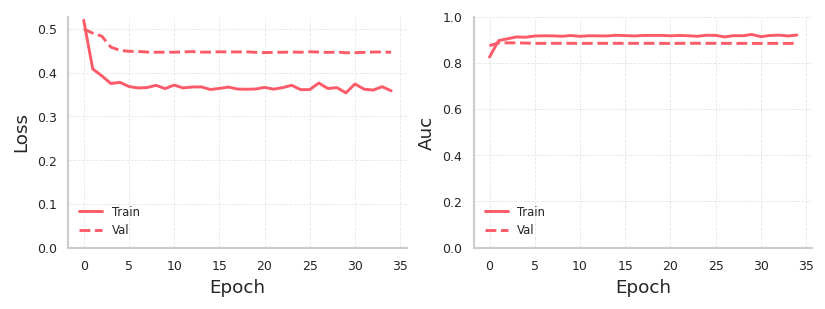

In [ ]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [ ]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Legitimate Transactions Detected (True Negatives):  95
Legitimate Transactions Incorrectly Detected (False Positives):  21
Fraudulent Transactions Missed (False Negatives):  55
Fraudulent Transactions Detected (True Positives):  188
Total Fraudulent Transactions:  243


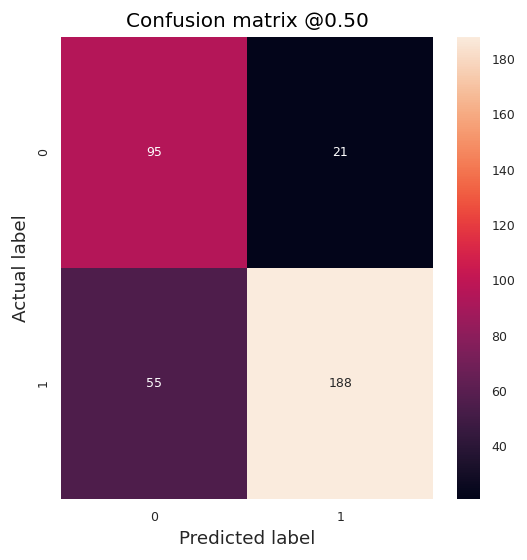

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
#plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v3_all_data_ext.csv")

### 4.3 LSTM-Tab with Transformer v0

In [272]:
inputs.shape

TensorShape([64, 7, 30])

In [283]:
def make_model(metrics=METRICS, units=[32,32],units_tab=[64,32], output_bias=None, gn=0.025, activation="relu", do=0.3):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_tabular = data[:, 6, :]
  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  whole_seq_output, final_memory_state_0, final_carry_state_0 = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0",return_state=True)(data_noised)
  whole_seq_output, final_memory_state_1, final_carry_state_1 = keras.layers.LSTM(units[1], name="lstm_1",return_state=True)(whole_seq_output)

  # print(final_memory_state_0.shape, final_carry_state_0.shape)
  # print(final_memory_state_1.shape, final_carry_state_1.shape)

  # Tabular Section
  data_tabular = keras.layers.Concatenate(name="concat_states")([data_tabular,final_memory_state_0,final_carry_state_0,final_memory_state_1,final_carry_state_1])

  tabx = keras.layers.Dense(units_tab[0], name="dense_0")(data_tabular)
  tabx = keras.layers.BatchNormalization(name="batch_0")(tabx)
  tabx = keras.layers.Activation(activation, name="act_0")(tabx)
  tabx = keras.layers.Dropout(do, name="do_0")(tabx)
  tabx = keras.layers.Dense(units_tab[1], name="dense_1")(tabx)
  tabx = keras.layers.BatchNormalization(name="batch_1")(tabx)
  tabx = keras.layers.Activation(activation, name="act_1")(tabx)
  tabx = keras.layers.Dropout(do, name="do_1")(tabx)

  # Concatenate
  x = keras.layers.Concatenate(name="concat")([whole_seq_output, tabx,data_tabular])
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_tab_v1")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,32],output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

Model: "LSTM_tab_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 30)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ noise_layer               │ (None, 7, 30)          │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_0 (LSTM)             │ [(None, 7, 64), (None, │         24,320 │ noise_layer[0][0]      │
│                           │ 64), (None, 64)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 32), (None,    │         12,416 │ lstm_0[0][0]           │
│                           │ 32), (None, 32)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_436 (GetItem)    │ (None, 30)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_states             │ (None, 222)            │              0 │ get_item_436[0][0],    │
│ (Concatenate)             │                        │                │ lstm_0[0][1],          │
│                           │                        │                │ lstm_0[0][2],          │
│                           │                        │                │ lstm_1[0][1],          │
│                           │                        │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_0 (Dense)           │ (None, 64)             │         14,272 │ concat_states[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_0                   │ (None, 64)             │            256 │ dense_0[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_0 (Activation)        │ (None, 64)             │              0 │ batch_0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ do_0 (Dropout)            │ (None, 64)             │              0 │ act_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ do_0[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_1                   │ (None, 32)             │            128 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_1 (Activation)        │ (None, 32)             │              0 │ batch_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ do_1 (Dropout)            │ (None, 32)             │              0 │ act_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, 286)            │              0 │ lstm_1[0][0],          │
│                      

 Total params: 53,759 (210.00 KB)

 Trainable params: 53,567 (209.25 KB)

 Non-trainable params: 192 (768.00 B)

In [284]:
#plot_model(model, show_shapes=True)

#### Optuna Optimization

In [285]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False, epochs=101):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [286]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [287]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

[I 2025-03-10 01:25:37,232] A new study created in memory with name: no-name-c521f5fe-d9d3-4d8f-99b4-c4776ff403d8


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.8424 - cross entropy: 0.5001 - loss: 0.6014 - prc: 0.8319 - val_auc: 0.8709 - val_cross entropy: 0.4606 - val_loss: 0.4606 - val_prc: 0.9268 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9056 - cross entropy: 0.3882 - loss: 0.3882 - prc: 0.8995 - val_auc: 0.8795 - val_cross entropy: 0.4315 - val_loss: 0.4315 - val_prc: 0.9329 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9035 - cross entropy: 0.3934 - loss: 0.3934 - prc: 0.8993 - val_auc: 0.8809 - val_cross entropy: 0.4692 - val_loss: 0.4692 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9139 - cross entropy: 0.3728 - loss: 0.3728 - prc: 0.9152 - val_auc: 0.8797 - val_cross entropy: 0.4488 - val_loss: 0.4488 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9267 - cross entropy: 0.3462 - loss: 0.3

[I 2025-03-10 01:26:03,544] Trial 0 finished with value: 0.8796651057187455 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.2}. Best is trial 0 with value: 0.8796651057187455.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - auc: 0.8319 - cross entropy: 0.5338 - loss: 0.5772 - prc: 0.8431 - val_auc: 0.8777 - val_cross entropy: 0.4858 - val_loss: 0.4858 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8911 - cross entropy: 0.4167 - loss: 0.4167 - prc: 0.8787 - val_auc: 0.8869 - val_cross entropy: 0.4345 - val_loss: 0.4345 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8937 - cross entropy: 0.4111 - loss: 0.4111 - prc: 0.8865 - val_auc: 0.8786 - val_cross entropy: 0.4829 - val_loss: 0.4829 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8971 - cross entropy: 0.4081 - loss: 0.4081 - prc: 0.8977 - val_auc: 0.8842 - val_cross entropy: 0.4439 - val_loss: 0.4439 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9065 - cross entropy: 0.3891 - loss: 0.3

[I 2025-03-10 01:26:30,590] Trial 1 finished with value: 0.8875053214133674 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.05, 'do': 0.23}. Best is trial 1 with value: 0.8875053214133674.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8146 - cross entropy: 0.5376 - loss: 0.5873 - prc: 0.8303 - val_auc: 0.8613 - val_cross entropy: 0.5050 - val_loss: 0.5050 - val_prc: 0.9215 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8967 - cross entropy: 0.4067 - loss: 0.4067 - prc: 0.8869 - val_auc: 0.8812 - val_cross entropy: 0.4484 - val_loss: 0.4484 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9092 - cross entropy: 0.3830 - loss: 0.3830 - prc: 0.8971 - val_auc: 0.8820 - val_cross entropy: 0.4617 - val_loss: 0.4617 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8994 - cross entropy: 0.4007 - loss: 0.4007 - prc: 0.8973 - val_auc: 0.8858 - val_cross entropy: 0.4538 - val_loss: 0.4538 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9152 - cross entropy: 0.3722 - loss: 0.3

[I 2025-03-10 01:26:56,537] Trial 2 finished with value: 0.8883922236412657 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.36}. Best is trial 2 with value: 0.8883922236412657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - auc: 0.8461 - cross entropy: 0.5224 - loss: 0.5665 - prc: 0.8600 - val_auc: 0.8856 - val_cross entropy: 0.4378 - val_loss: 0.4378 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9033 - cross entropy: 0.3934 - loss: 0.3934 - prc: 0.8982 - val_auc: 0.8824 - val_cross entropy: 0.4498 - val_loss: 0.4498 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8972 - cross entropy: 0.4031 - loss: 0.4031 - prc: 0.8902 - val_auc: 0.8866 - val_cross entropy: 0.4537 - val_loss: 0.4537 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9051 - cross entropy: 0.3892 - loss: 0.3892 - prc: 0.9064 - val_auc: 0.8817 - val_cross entropy: 0.4334 - val_loss: 0.4334 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9050 - cross entropy: 0.3898 - loss: 0.3

[I 2025-03-10 01:27:24,913] Trial 3 finished with value: 0.8828224776500638 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'selu', 'gn': 0.05, 'do': 0.21000000000000002}. Best is trial 2 with value: 0.8883922236412657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - auc: 0.8419 - cross entropy: 0.5207 - loss: 0.5728 - prc: 0.8582 - val_auc: 0.8616 - val_cross entropy: 0.4623 - val_loss: 0.4623 - val_prc: 0.9200 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9071 - cross entropy: 0.3850 - loss: 0.3850 - prc: 0.9046 - val_auc: 0.8712 - val_cross entropy: 0.4556 - val_loss: 0.4556 - val_prc: 0.9268 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9110 - cross entropy: 0.3785 - loss: 0.3785 - prc: 0.9082 - val_auc: 0.8787 - val_cross entropy: 0.4257 - val_loss: 0.4257 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9267 - cross entropy: 0.3489 - loss: 0.3489 - prc: 0.9309 - val_auc: 0.8758 - val_cross entropy: 0.4497 - val_loss: 0.4497 - val_prc: 0.9319 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9299 - cross entropy: 0.3370 - loss: 0.3

[I 2025-03-10 01:27:55,057] Trial 4 finished with value: 0.8760110685398041 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 128, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.2}. Best is trial 2 with value: 0.8883922236412657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - auc: 0.8356 - cross entropy: 0.5154 - loss: 0.5496 - prc: 0.8491 - val_auc: 0.8679 - val_cross entropy: 0.5195 - val_loss: 0.5195 - val_prc: 0.9257 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9032 - cross entropy: 0.3933 - loss: 0.3933 - prc: 0.8915 - val_auc: 0.8835 - val_cross entropy: 0.4414 - val_loss: 0.4414 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9122 - cross entropy: 0.3765 - loss: 0.3765 - prc: 0.9026 - val_auc: 0.8799 - val_cross entropy: 0.4888 - val_loss: 0.4888 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.9195 - cross entropy: 0.3604 - loss: 0.3604 - prc: 0.9179 - val_auc: 0.8824 - val_cross entropy: 0.4480 - val_loss: 0.4480 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9179 - cross entropy: 0.3640 - loss: 0.3

[I 2025-03-10 01:28:29,446] Trial 5 finished with value: 0.8826096211153682 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'silu', 'gn': 0.04, 'do': 0.23}. Best is trial 2 with value: 0.8883922236412657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - auc: 0.8341 - cross entropy: 0.5107 - loss: 0.5428 - prc: 0.8464 - val_auc: 0.8749 - val_cross entropy: 0.4498 - val_loss: 0.4498 - val_prc: 0.9313 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9025 - cross entropy: 0.3933 - loss: 0.3933 - prc: 0.8932 - val_auc: 0.8799 - val_cross entropy: 0.4549 - val_loss: 0.4549 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9173 - cross entropy: 0.3644 - loss: 0.3644 - prc: 0.9100 - val_auc: 0.8777 - val_cross entropy: 0.4529 - val_loss: 0.4529 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9066 - cross entropy: 0.3875 - loss: 0.3875 - prc: 0.9120 - val_auc: 0.8825 - val_cross entropy: 0.4368 - val_loss: 0.4368 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9258 - cross entropy: 0.3480 - loss: 0.3

[I 2025-03-10 01:29:01,379] Trial 6 finished with value: 0.8828934298282958 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.27}. Best is trial 2 with value: 0.8883922236412657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - auc: 0.7946 - cross entropy: 0.5733 - loss: 0.6218 - prc: 0.8114 - val_auc: 0.8726 - val_cross entropy: 0.4745 - val_loss: 0.4745 - val_prc: 0.9311 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9020 - cross entropy: 0.3973 - loss: 0.3973 - prc: 0.8922 - val_auc: 0.8826 - val_cross entropy: 0.4346 - val_loss: 0.4346 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9052 - cross entropy: 0.3896 - loss: 0.3896 - prc: 0.8950 - val_auc: 0.8877 - val_cross entropy: 0.4454 - val_loss: 0.4454 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9092 - cross entropy: 0.3852 - loss: 0.3852 - prc: 0.9129 - val_auc: 0.8854 - val_cross entropy: 0.4478 - val_loss: 0.4478 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9230 - cross entropy: 0.3518 - loss: 0.3

[I 2025-03-10 01:29:33,046] Trial 7 finished with value: 0.8858379452249184 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.05, 'do': 0.30000000000000004}. Best is trial 2 with value: 0.8883922236412657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - auc: 0.8452 - cross entropy: 0.5035 - loss: 0.5311 - prc: 0.8602 - val_auc: 0.8785 - val_cross entropy: 0.4503 - val_loss: 0.4503 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9119 - cross entropy: 0.3761 - loss: 0.3761 - prc: 0.8977 - val_auc: 0.8886 - val_cross entropy: 0.4146 - val_loss: 0.4146 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9094 - cross entropy: 0.3823 - loss: 0.3823 - prc: 0.9006 - val_auc: 0.8795 - val_cross entropy: 0.4625 - val_loss: 0.4625 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9222 - cross entropy: 0.3578 - loss: 0.3578 - prc: 0.9252 - val_auc: 0.8824 - val_cross entropy: 0.4829 - val_loss: 0.4829 - val_prc: 0.9366 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9271 - cross entropy: 0.3437 - loss: 0.3

[I 2025-03-10 01:30:10,034] Trial 8 finished with value: 0.8825741450262523 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.38}. Best is trial 2 with value: 0.8883922236412657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - auc: 0.8152 - cross entropy: 0.5530 - loss: 0.6068 - prc: 0.8226 - val_auc: 0.8654 - val_cross entropy: 0.4762 - val_loss: 0.4762 - val_prc: 0.9193 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.8969 - cross entropy: 0.4074 - loss: 0.4074 - prc: 0.8917 - val_auc: 0.8786 - val_cross entropy: 0.4368 - val_loss: 0.4368 - val_prc: 0.9313 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9023 - cross entropy: 0.3958 - loss: 0.3958 - prc: 0.8965 - val_auc: 0.8870 - val_cross entropy: 0.4339 - val_loss: 0.4339 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9195 - cross entropy: 0.3609 - loss: 0.3609 - prc: 0.9206 - val_auc: 0.8790 - val_cross entropy: 0.4630 - val_loss: 0.4630 - val_prc: 0.9326 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9191 - cross entropy: 0.3628 - loss: 0.3

[I 2025-03-10 01:30:43,904] Trial 9 finished with value: 0.8791684404711225 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'relu', 'gn': 0.09, 'do': 0.29000000000000004}. Best is trial 2 with value: 0.8883922236412657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8142 - cross entropy: 0.5481 - loss: 0.5853 - prc: 0.8270 - val_auc: 0.8617 - val_cross entropy: 0.4764 - val_loss: 0.4764 - val_prc: 0.9191 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8901 - cross entropy: 0.4199 - loss: 0.4199 - prc: 0.8834 - val_auc: 0.8803 - val_cross entropy: 0.4371 - val_loss: 0.4371 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9090 - cross entropy: 0.3835 - loss: 0.3835 - prc: 0.8996 - val_auc: 0.8809 - val_cross entropy: 0.4560 - val_loss: 0.4560 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9037 - cross entropy: 0.3951 - loss: 0.3951 - prc: 0.9077 - val_auc: 0.8870 - val_cross entropy: 0.4454 - val_loss: 0.4454 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9177 - cross entropy: 0.3652 - loss: 0.3

[I 2025-03-10 01:31:10,119] Trial 10 finished with value: 0.888817936710657 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.45}. Best is trial 10 with value: 0.888817936710657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - auc: 0.8179 - cross entropy: 0.5359 - loss: 0.5793 - prc: 0.8349 - val_auc: 0.8652 - val_cross entropy: 0.4786 - val_loss: 0.4786 - val_prc: 0.9243 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8875 - cross entropy: 0.4172 - loss: 0.4172 - prc: 0.8736 - val_auc: 0.8792 - val_cross entropy: 0.4470 - val_loss: 0.4470 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8977 - cross entropy: 0.4072 - loss: 0.4072 - prc: 0.8915 - val_auc: 0.8840 - val_cross entropy: 0.4621 - val_loss: 0.4621 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9128 - cross entropy: 0.3779 - loss: 0.3779 - prc: 0.9121 - val_auc: 0.8887 - val_cross entropy: 0.4391 - val_loss: 0.4391 - val_prc: 0.9428 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9103 - cross entropy: 0.3843 - loss: 0.3

[I 2025-03-10 01:31:36,017] Trial 11 finished with value: 0.8887469845324251 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.45}. Best is trial 10 with value: 0.888817936710657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - auc: 0.8164 - cross entropy: 0.5374 - loss: 0.5872 - prc: 0.8335 - val_auc: 0.8649 - val_cross entropy: 0.4785 - val_loss: 0.4785 - val_prc: 0.9238 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8899 - cross entropy: 0.4194 - loss: 0.4194 - prc: 0.8852 - val_auc: 0.8766 - val_cross entropy: 0.4699 - val_loss: 0.4699 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8951 - cross entropy: 0.4097 - loss: 0.4097 - prc: 0.8856 - val_auc: 0.8846 - val_cross entropy: 0.4842 - val_loss: 0.4842 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9074 - cross entropy: 0.3844 - loss: 0.3844 - prc: 0.9081 - val_auc: 0.8888 - val_cross entropy: 0.4387 - val_loss: 0.4387 - val_prc: 0.9426 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9114 - cross entropy: 0.3776 - loss: 0.3

[I 2025-03-10 01:32:02,286] Trial 12 finished with value: 0.8886760323541933 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.45}. Best is trial 10 with value: 0.888817936710657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - auc: 0.8184 - cross entropy: 0.5374 - loss: 0.5838 - prc: 0.8358 - val_auc: 0.8612 - val_cross entropy: 0.4772 - val_loss: 0.4772 - val_prc: 0.9169 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8864 - cross entropy: 0.4222 - loss: 0.4222 - prc: 0.8748 - val_auc: 0.8742 - val_cross entropy: 0.4580 - val_loss: 0.4580 - val_prc: 0.9299 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8955 - cross entropy: 0.4078 - loss: 0.4078 - prc: 0.8845 - val_auc: 0.8833 - val_cross entropy: 0.4533 - val_loss: 0.4533 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9019 - cross entropy: 0.3972 - loss: 0.3972 - prc: 0.8985 - val_auc: 0.8868 - val_cross entropy: 0.4316 - val_loss: 0.4316 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9033 - cross entropy: 0.3915 - loss: 0.3

[I 2025-03-10 01:32:29,973] Trial 13 finished with value: 0.8869731800766284 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.45}. Best is trial 10 with value: 0.888817936710657.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8208 - cross entropy: 0.5333 - loss: 0.5811 - prc: 0.8368 - val_auc: 0.8626 - val_cross entropy: 0.4550 - val_loss: 0.4550 - val_prc: 0.9144 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8953 - cross entropy: 0.4077 - loss: 0.4077 - prc: 0.8831 - val_auc: 0.8797 - val_cross entropy: 0.4427 - val_loss: 0.4427 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9125 - cross entropy: 0.3774 - loss: 0.3774 - prc: 0.9040 - val_auc: 0.8873 - val_cross entropy: 0.4454 - val_loss: 0.4454 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9103 - cross entropy: 0.3791 - loss: 0.3791 - prc: 0.9089 - val_auc: 0.8889 - val_cross entropy: 0.4597 - val_loss: 0.4597 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9157 - cross entropy: 0.3711 - loss: 0.3

[I 2025-03-10 01:32:55,264] Trial 14 finished with value: 0.8889243649780049 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.41000000000000003}. Best is trial 14 with value: 0.8889243649780049.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8233 - cross entropy: 0.5298 - loss: 0.5699 - prc: 0.8392 - val_auc: 0.8619 - val_cross entropy: 0.4859 - val_loss: 0.4859 - val_prc: 0.9198 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8963 - cross entropy: 0.4058 - loss: 0.4058 - prc: 0.8849 - val_auc: 0.8815 - val_cross entropy: 0.4395 - val_loss: 0.4395 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8976 - cross entropy: 0.4049 - loss: 0.4049 - prc: 0.8913 - val_auc: 0.8835 - val_cross entropy: 0.4570 - val_loss: 0.4570 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9094 - cross entropy: 0.3831 - loss: 0.3831 - prc: 0.9117 - val_auc: 0.8884 - val_cross entropy: 0.4330 - val_loss: 0.4330 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9063 - cross entropy: 0.3861 - loss: 0.3

[I 2025-03-10 01:33:24,646] Trial 15 finished with value: 0.8886050801759614 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.41000000000000003}. Best is trial 14 with value: 0.8889243649780049.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - auc: 0.8223 - cross entropy: 0.5329 - loss: 0.5767 - prc: 0.8376 - val_auc: 0.8655 - val_cross entropy: 0.4784 - val_loss: 0.4784 - val_prc: 0.9239 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8976 - cross entropy: 0.4058 - loss: 0.4058 - prc: 0.8914 - val_auc: 0.8828 - val_cross entropy: 0.4405 - val_loss: 0.4405 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8958 - cross entropy: 0.4065 - loss: 0.4065 - prc: 0.8863 - val_auc: 0.8765 - val_cross entropy: 0.5026 - val_loss: 0.5026 - val_prc: 0.9320 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9087 - cross entropy: 0.3834 - loss: 0.3834 - prc: 0.9071 - val_auc: 0.8875 - val_cross entropy: 0.4527 - val_loss: 0.4527 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9058 - cross entropy: 0.3869 - loss: 0.3

[I 2025-03-10 01:33:52,301] Trial 16 finished with value: 0.8906272172555697 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8209 - cross entropy: 0.5302 - loss: 0.5674 - prc: 0.8375 - val_auc: 0.8640 - val_cross entropy: 0.4780 - val_loss: 0.4780 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8924 - cross entropy: 0.4138 - loss: 0.4138 - prc: 0.8879 - val_auc: 0.8824 - val_cross entropy: 0.4331 - val_loss: 0.4331 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9123 - cross entropy: 0.3782 - loss: 0.3782 - prc: 0.9039 - val_auc: 0.8785 - val_cross entropy: 0.4500 - val_loss: 0.4500 - val_prc: 0.9337 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9054 - cross entropy: 0.3894 - loss: 0.3894 - prc: 0.9081 - val_auc: 0.8853 - val_cross entropy: 0.4354 - val_loss: 0.4354 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9130 - cross entropy: 0.3755 - loss: 0.3

[I 2025-03-10 01:34:19,223] Trial 17 finished with value: 0.8853058038881795 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.03, 'do': 0.35}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8093 - cross entropy: 0.5573 - loss: 0.6184 - prc: 0.8280 - val_auc: 0.8734 - val_cross entropy: 0.4810 - val_loss: 0.4810 - val_prc: 0.9278 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8887 - cross entropy: 0.4212 - loss: 0.4212 - prc: 0.8789 - val_auc: 0.8824 - val_cross entropy: 0.4459 - val_loss: 0.4459 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9007 - cross entropy: 0.3992 - loss: 0.3992 - prc: 0.8956 - val_auc: 0.8817 - val_cross entropy: 0.5140 - val_loss: 0.5140 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8977 - cross entropy: 0.4050 - loss: 0.4050 - prc: 0.8936 - val_auc: 0.8893 - val_cross entropy: 0.4594 - val_loss: 0.4594 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9157 - cross entropy: 0.3674 - loss: 0.3

[I 2025-03-10 01:34:46,573] Trial 18 finished with value: 0.8892791258691642 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.03, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8158 - cross entropy: 0.5512 - loss: 0.6123 - prc: 0.8343 - val_auc: 0.8752 - val_cross entropy: 0.4699 - val_loss: 0.4699 - val_prc: 0.9298 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8956 - cross entropy: 0.4082 - loss: 0.4082 - prc: 0.8828 - val_auc: 0.8816 - val_cross entropy: 0.4506 - val_loss: 0.4506 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9013 - cross entropy: 0.3970 - loss: 0.3970 - prc: 0.8937 - val_auc: 0.8869 - val_cross entropy: 0.4420 - val_loss: 0.4420 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9007 - cross entropy: 0.3991 - loss: 0.3991 - prc: 0.9025 - val_auc: 0.8880 - val_cross entropy: 0.4621 - val_loss: 0.4621 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9037 - cross entropy: 0.3954 - loss: 0.3

[I 2025-03-10 01:35:14,299] Trial 19 finished with value: 0.8875762735915993 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.02, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8326 - cross entropy: 0.5356 - loss: 0.5922 - prc: 0.8421 - val_auc: 0.8820 - val_cross entropy: 0.4842 - val_loss: 0.4842 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8920 - cross entropy: 0.4151 - loss: 0.4151 - prc: 0.8859 - val_auc: 0.8842 - val_cross entropy: 0.4405 - val_loss: 0.4405 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8987 - cross entropy: 0.4022 - loss: 0.4022 - prc: 0.8926 - val_auc: 0.8808 - val_cross entropy: 0.4755 - val_loss: 0.4755 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8977 - cross entropy: 0.4040 - loss: 0.4040 - prc: 0.8941 - val_auc: 0.8893 - val_cross entropy: 0.4256 - val_loss: 0.4256 - val_prc: 0.9436 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9124 - cross entropy: 0.3752 - loss: 0.3

[I 2025-03-10 01:35:42,157] Trial 20 finished with value: 0.889350078047396 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.32}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8410 - cross entropy: 0.5252 - loss: 0.5679 - prc: 0.8542 - val_auc: 0.8764 - val_cross entropy: 0.4765 - val_loss: 0.4765 - val_prc: 0.9298 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8927 - cross entropy: 0.4142 - loss: 0.4142 - prc: 0.8862 - val_auc: 0.8810 - val_cross entropy: 0.4748 - val_loss: 0.4748 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8980 - cross entropy: 0.4016 - loss: 0.4016 - prc: 0.8813 - val_auc: 0.8851 - val_cross entropy: 0.4795 - val_loss: 0.4795 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9021 - cross entropy: 0.3962 - loss: 0.3962 - prc: 0.9023 - val_auc: 0.8893 - val_cross entropy: 0.4457 - val_loss: 0.4457 - val_prc: 0.9426 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9125 - cross entropy: 0.3763 - loss: 0.3

[I 2025-03-10 01:36:10,775] Trial 21 finished with value: 0.8894565063147438 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.33}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.8374 - cross entropy: 0.5343 - loss: 0.5868 - prc: 0.8416 - val_auc: 0.8720 - val_cross entropy: 0.5097 - val_loss: 0.5097 - val_prc: 0.9272 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8972 - cross entropy: 0.4035 - loss: 0.4035 - prc: 0.8857 - val_auc: 0.8846 - val_cross entropy: 0.4395 - val_loss: 0.4395 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8978 - cross entropy: 0.4037 - loss: 0.4037 - prc: 0.8831 - val_auc: 0.8743 - val_cross entropy: 0.4996 - val_loss: 0.4996 - val_prc: 0.9308 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9027 - cross entropy: 0.3987 - loss: 0.3987 - prc: 0.9045 - val_auc: 0.8873 - val_cross entropy: 0.4755 - val_loss: 0.4755 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9143 - cross entropy: 0.3713 - loss: 0.3

[I 2025-03-10 01:36:39,138] Trial 22 finished with value: 0.8875407975024834 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.33}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8405 - cross entropy: 0.5277 - loss: 0.5706 - prc: 0.8476 - val_auc: 0.8786 - val_cross entropy: 0.5021 - val_loss: 0.5021 - val_prc: 0.9343 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8942 - cross entropy: 0.4122 - loss: 0.4122 - prc: 0.8790 - val_auc: 0.8659 - val_cross entropy: 0.5426 - val_loss: 0.5426 - val_prc: 0.9253 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9028 - cross entropy: 0.3951 - loss: 0.3951 - prc: 0.8826 - val_auc: 0.8797 - val_cross entropy: 0.4684 - val_loss: 0.4684 - val_prc: 0.9349 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8993 - cross entropy: 0.4006 - loss: 0.4006 - prc: 0.8975 - val_auc: 0.8849 - val_cross entropy: 0.4670 - val_loss: 0.4670 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9061 - cross entropy: 0.3893 - loss: 0.3

[I 2025-03-10 01:37:07,344] Trial 23 finished with value: 0.8847027103732085 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.32}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8389 - cross entropy: 0.5286 - loss: 0.5703 - prc: 0.8480 - val_auc: 0.8756 - val_cross entropy: 0.4774 - val_loss: 0.4774 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8907 - cross entropy: 0.4192 - loss: 0.4192 - prc: 0.8816 - val_auc: 0.8864 - val_cross entropy: 0.4284 - val_loss: 0.4284 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9013 - cross entropy: 0.3976 - loss: 0.3976 - prc: 0.8823 - val_auc: 0.8830 - val_cross entropy: 0.4524 - val_loss: 0.4524 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8986 - cross entropy: 0.4036 - loss: 0.4036 - prc: 0.9003 - val_auc: 0.8846 - val_cross entropy: 0.4491 - val_loss: 0.4491 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9116 - cross entropy: 0.3758 - loss: 0.3

[I 2025-03-10 01:37:33,915] Trial 24 finished with value: 0.8846317581949766 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.08, 'do': 0.26}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8335 - cross entropy: 0.5365 - loss: 0.5928 - prc: 0.8366 - val_auc: 0.8772 - val_cross entropy: 0.4896 - val_loss: 0.4896 - val_prc: 0.9311 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8861 - cross entropy: 0.4291 - loss: 0.4291 - prc: 0.8772 - val_auc: 0.8828 - val_cross entropy: 0.4550 - val_loss: 0.4550 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8971 - cross entropy: 0.4072 - loss: 0.4072 - prc: 0.8817 - val_auc: 0.8828 - val_cross entropy: 0.4673 - val_loss: 0.4673 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8960 - cross entropy: 0.4078 - loss: 0.4078 - prc: 0.8897 - val_auc: 0.8781 - val_cross entropy: 0.4985 - val_loss: 0.4985 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9093 - cross entropy: 0.3812 - loss: 0.3

[I 2025-03-10 01:38:02,358] Trial 25 finished with value: 0.8879310344827587 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.38}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - auc: 0.8440 - cross entropy: 0.5161 - loss: 0.5589 - prc: 0.8456 - val_auc: 0.8833 - val_cross entropy: 0.4532 - val_loss: 0.4532 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8929 - cross entropy: 0.4113 - loss: 0.4113 - prc: 0.8728 - val_auc: 0.8834 - val_cross entropy: 0.4846 - val_loss: 0.4846 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9072 - cross entropy: 0.3865 - loss: 0.3865 - prc: 0.8996 - val_auc: 0.8920 - val_cross entropy: 0.4421 - val_loss: 0.4421 - val_prc: 0.9441 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9058 - cross entropy: 0.3908 - loss: 0.3908 - prc: 0.9056 - val_auc: 0.8795 - val_cross entropy: 0.5097 - val_loss: 0.5097 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9091 - cross entropy: 0.3830 - loss: 0.3

[I 2025-03-10 01:38:36,824] Trial 26 finished with value: 0.8825386689371363 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.08, 'do': 0.33}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8344 - cross entropy: 0.5390 - loss: 0.5848 - prc: 0.8420 - val_auc: 0.8770 - val_cross entropy: 0.5028 - val_loss: 0.5028 - val_prc: 0.9323 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8921 - cross entropy: 0.4153 - loss: 0.4153 - prc: 0.8843 - val_auc: 0.8800 - val_cross entropy: 0.4418 - val_loss: 0.4418 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8890 - cross entropy: 0.4206 - loss: 0.4206 - prc: 0.8814 - val_auc: 0.8843 - val_cross entropy: 0.4583 - val_loss: 0.4583 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9095 - cross entropy: 0.3799 - loss: 0.3799 - prc: 0.9067 - val_auc: 0.8790 - val_cross entropy: 0.4530 - val_loss: 0.4530 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9123 - cross entropy: 0.3761 - loss: 0.3

[I 2025-03-10 01:39:04,068] Trial 27 finished with value: 0.8869731800766283 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.08, 'do': 0.30000000000000004}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - auc: 0.8077 - cross entropy: 0.5647 - loss: 0.6222 - prc: 0.8230 - val_auc: 0.8624 - val_cross entropy: 0.4588 - val_loss: 0.4588 - val_prc: 0.9175 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8851 - cross entropy: 0.4245 - loss: 0.4245 - prc: 0.8718 - val_auc: 0.8704 - val_cross entropy: 0.4621 - val_loss: 0.4621 - val_prc: 0.9264 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9006 - cross entropy: 0.3999 - loss: 0.3999 - prc: 0.8961 - val_auc: 0.8809 - val_cross entropy: 0.4452 - val_loss: 0.4452 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9029 - cross entropy: 0.3972 - loss: 0.3972 - prc: 0.9053 - val_auc: 0.8816 - val_cross entropy: 0.4290 - val_loss: 0.4290 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9116 - cross entropy: 0.3761 - loss: 0.3

[I 2025-03-10 01:39:32,820] Trial 28 finished with value: 0.8842060451255853 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'relu', 'gn': 0.04, 'do': 0.36}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - auc: 0.8298 - cross entropy: 0.5366 - loss: 0.5881 - prc: 0.8454 - val_auc: 0.8760 - val_cross entropy: 0.4452 - val_loss: 0.4452 - val_prc: 0.9288 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8992 - cross entropy: 0.4023 - loss: 0.4023 - prc: 0.8930 - val_auc: 0.8816 - val_cross entropy: 0.4322 - val_loss: 0.4322 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9061 - cross entropy: 0.3869 - loss: 0.3869 - prc: 0.9012 - val_auc: 0.8829 - val_cross entropy: 0.4557 - val_loss: 0.4557 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9168 - cross entropy: 0.3698 - loss: 0.3698 - prc: 0.9196 - val_auc: 0.8807 - val_cross entropy: 0.4587 - val_loss: 0.4587 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9319 - cross entropy: 0.3356 - loss: 0.3

[I 2025-03-10 01:40:03,091] Trial 29 finished with value: 0.8803391514119484 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.38}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - auc: 0.8226 - cross entropy: 0.5414 - loss: 0.5919 - prc: 0.8390 - val_auc: 0.8571 - val_cross entropy: 0.4962 - val_loss: 0.4962 - val_prc: 0.9157 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8978 - cross entropy: 0.4014 - loss: 0.4014 - prc: 0.8875 - val_auc: 0.8764 - val_cross entropy: 0.4400 - val_loss: 0.4400 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9070 - cross entropy: 0.3847 - loss: 0.3847 - prc: 0.8977 - val_auc: 0.8762 - val_cross entropy: 0.4686 - val_loss: 0.4686 - val_prc: 0.9299 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9158 - cross entropy: 0.3693 - loss: 0.3693 - prc: 0.9191 - val_auc: 0.8793 - val_cross entropy: 0.4408 - val_loss: 0.4408 - val_prc: 0.9355 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9231 - cross entropy: 0.3534 - loss: 0.3

[I 2025-03-10 01:40:32,444] Trial 30 finished with value: 0.8793812970058181 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.04, 'do': 0.32}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8080 - cross entropy: 0.5622 - loss: 0.6119 - prc: 0.8263 - val_auc: 0.8652 - val_cross entropy: 0.5044 - val_loss: 0.5044 - val_prc: 0.9220 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8770 - cross entropy: 0.4444 - loss: 0.4444 - prc: 0.8691 - val_auc: 0.8804 - val_cross entropy: 0.4792 - val_loss: 0.4792 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9004 - cross entropy: 0.3980 - loss: 0.3980 - prc: 0.8858 - val_auc: 0.8857 - val_cross entropy: 0.4568 - val_loss: 0.4568 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9094 - cross entropy: 0.3809 - loss: 0.3809 - prc: 0.9078 - val_auc: 0.8853 - val_cross entropy: 0.4852 - val_loss: 0.4852 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9130 - cross entropy: 0.3741 - loss: 0.3

[I 2025-03-10 01:41:00,560] Trial 31 finished with value: 0.8902015041861785 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.02, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - auc: 0.8087 - cross entropy: 0.5605 - loss: 0.6198 - prc: 0.8296 - val_auc: 0.8747 - val_cross entropy: 0.4763 - val_loss: 0.4763 - val_prc: 0.9295 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.8908 - cross entropy: 0.4161 - loss: 0.4161 - prc: 0.8822 - val_auc: 0.8881 - val_cross entropy: 0.4360 - val_loss: 0.4360 - val_prc: 0.9410 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9015 - cross entropy: 0.3976 - loss: 0.3976 - prc: 0.8916 - val_auc: 0.8864 - val_cross entropy: 0.4447 - val_loss: 0.4447 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9091 - cross entropy: 0.3833 - loss: 0.3833 - prc: 0.9066 - val_auc: 0.8853 - val_cross entropy: 0.4635 - val_loss: 0.4635 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9118 - cross entropy: 0.3779 - loss: 0.3

[I 2025-03-10 01:41:29,513] Trial 32 finished with value: 0.8871150844330921 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.02, 'do': 0.43000000000000005}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8310 - cross entropy: 0.5408 - loss: 0.5957 - prc: 0.8322 - val_auc: 0.8796 - val_cross entropy: 0.4639 - val_loss: 0.4639 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8867 - cross entropy: 0.4258 - loss: 0.4258 - prc: 0.8701 - val_auc: 0.8763 - val_cross entropy: 0.4894 - val_loss: 0.4894 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8956 - cross entropy: 0.4122 - loss: 0.4122 - prc: 0.8768 - val_auc: 0.8752 - val_cross entropy: 0.5104 - val_loss: 0.5104 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8929 - cross entropy: 0.4170 - loss: 0.4170 - prc: 0.8950 - val_auc: 0.8843 - val_cross entropy: 0.4530 - val_loss: 0.4530 - val_prc: 0.9386 - learning_rate: 3.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9035 - cross entropy: 0.3931 - loss:

[I 2025-03-10 01:41:57,540] Trial 33 finished with value: 0.8876117496807152 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.02, 'do': 0.39}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8580 - cross entropy: 0.4851 - loss: 0.5120 - prc: 0.8664 - val_auc: 0.8815 - val_cross entropy: 0.4581 - val_loss: 0.4581 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8936 - cross entropy: 0.4100 - loss: 0.4100 - prc: 0.8754 - val_auc: 0.8833 - val_cross entropy: 0.4595 - val_loss: 0.4595 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8976 - cross entropy: 0.4054 - loss: 0.4054 - prc: 0.8922 - val_auc: 0.8864 - val_cross entropy: 0.4884 - val_loss: 0.4884 - val_prc: 0.9400 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9018 - cross entropy: 0.3957 - loss: 0.3957 - prc: 0.9014 - val_auc: 0.8813 - val_cross entropy: 0.4634 - val_loss: 0.4634 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9163 - cross entropy: 0.3664 - loss: 0.3

[I 2025-03-10 01:42:26,469] Trial 34 finished with value: 0.88381580814531 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.35}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8179 - cross entropy: 0.5449 - loss: 0.5994 - prc: 0.8368 - val_auc: 0.8803 - val_cross entropy: 0.4516 - val_loss: 0.4516 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8919 - cross entropy: 0.4132 - loss: 0.4132 - prc: 0.8765 - val_auc: 0.8860 - val_cross entropy: 0.4236 - val_loss: 0.4236 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9000 - cross entropy: 0.3992 - loss: 0.3992 - prc: 0.8910 - val_auc: 0.8879 - val_cross entropy: 0.4215 - val_loss: 0.4215 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9060 - cross entropy: 0.3885 - loss: 0.3885 - prc: 0.9093 - val_auc: 0.8821 - val_cross entropy: 0.4489 - val_loss: 0.4489 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9155 - cross entropy: 0.3707 - loss: 0.3

[I 2025-03-10 01:42:54,751] Trial 35 finished with value: 0.8820065276003973 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.05, 'do': 0.26}. Best is trial 16 with value: 0.8906272172555697.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - auc: 0.8469 - cross entropy: 0.5145 - loss: 0.5528 - prc: 0.8520 - val_auc: 0.8767 - val_cross entropy: 0.4755 - val_loss: 0.4755 - val_prc: 0.9313 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8783 - cross entropy: 0.4406 - loss: 0.4406 - prc: 0.8644 - val_auc: 0.8901 - val_cross entropy: 0.4204 - val_loss: 0.4204 - val_prc: 0.9439 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8915 - cross entropy: 0.4162 - loss: 0.4162 - prc: 0.8777 - val_auc: 0.8907 - val_cross entropy: 0.4397 - val_loss: 0.4397 - val_prc: 0.9435 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9033 - cross entropy: 0.3945 - loss: 0.3945 - prc: 0.9002 - val_auc: 0.8868 - val_cross entropy: 0.4622 - val_loss: 0.4622 - val_prc: 0.9401 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9023 - cross entropy: 0.3942 - loss: 0.3

[I 2025-03-10 01:43:23,922] Trial 36 finished with value: 0.8921172129984389 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.09, 'do': 0.39}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8200 - cross entropy: 0.5418 - loss: 0.5940 - prc: 0.8337 - val_auc: 0.8754 - val_cross entropy: 0.4626 - val_loss: 0.4626 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8939 - cross entropy: 0.4086 - loss: 0.4086 - prc: 0.8849 - val_auc: 0.8820 - val_cross entropy: 0.4384 - val_loss: 0.4384 - val_prc: 0.9356 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8892 - cross entropy: 0.4189 - loss: 0.4189 - prc: 0.8760 - val_auc: 0.8812 - val_cross entropy: 0.4687 - val_loss: 0.4687 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9041 - cross entropy: 0.3947 - loss: 0.3947 - prc: 0.9051 - val_auc: 0.8843 - val_cross entropy: 0.4650 - val_loss: 0.4650 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9076 - cross entropy: 0.3846 - loss: 0.3

[I 2025-03-10 01:43:50,437] Trial 37 finished with value: 0.8873988931460197 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.43000000000000005}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - auc: 0.8401 - cross entropy: 0.5068 - loss: 0.5409 - prc: 0.8466 - val_auc: 0.8807 - val_cross entropy: 0.4628 - val_loss: 0.4628 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9007 - cross entropy: 0.3984 - loss: 0.3984 - prc: 0.8950 - val_auc: 0.8888 - val_cross entropy: 0.4606 - val_loss: 0.4606 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9051 - cross entropy: 0.3904 - loss: 0.3904 - prc: 0.8878 - val_auc: 0.8849 - val_cross entropy: 0.4689 - val_loss: 0.4689 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9099 - cross entropy: 0.3817 - loss: 0.3817 - prc: 0.9062 - val_auc: 0.8817 - val_cross entropy: 0.4712 - val_loss: 0.4712 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.9183 - cross entropy: 0.3621 - loss: 0.3

[I 2025-03-10 01:44:25,983] Trial 38 finished with value: 0.8819355754221655 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'selu', 'gn': 0.09, 'do': 0.39}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - auc: 0.7982 - cross entropy: 0.5628 - loss: 0.6186 - prc: 0.8128 - val_auc: 0.8617 - val_cross entropy: 0.4559 - val_loss: 0.4559 - val_prc: 0.9198 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8780 - cross entropy: 0.4433 - loss: 0.4433 - prc: 0.8696 - val_auc: 0.8794 - val_cross entropy: 0.4167 - val_loss: 0.4167 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8904 - cross entropy: 0.4174 - loss: 0.4174 - prc: 0.8825 - val_auc: 0.8875 - val_cross entropy: 0.4262 - val_loss: 0.4262 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8979 - cross entropy: 0.4042 - loss: 0.4042 - prc: 0.9001 - val_auc: 0.8890 - val_cross entropy: 0.4411 - val_loss: 0.4411 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9100 - cross entropy: 0.3829 - loss: 0.3

[I 2025-03-10 01:44:50,515] Trial 39 finished with value: 0.8889243649780049 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.43000000000000005}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - auc: 0.8387 - cross entropy: 0.5083 - loss: 0.5471 - prc: 0.8564 - val_auc: 0.8726 - val_cross entropy: 0.4709 - val_loss: 0.4709 - val_prc: 0.9288 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8950 - cross entropy: 0.4069 - loss: 0.4069 - prc: 0.8849 - val_auc: 0.8781 - val_cross entropy: 0.4738 - val_loss: 0.4738 - val_prc: 0.9329 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9097 - cross entropy: 0.3794 - loss: 0.3794 - prc: 0.9006 - val_auc: 0.8759 - val_cross entropy: 0.4673 - val_loss: 0.4673 - val_prc: 0.9320 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9111 - cross entropy: 0.3783 - loss: 0.3783 - prc: 0.9125 - val_auc: 0.8846 - val_cross entropy: 0.4571 - val_loss: 0.4571 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9174 - cross entropy: 0.3633 - loss: 0.3

[I 2025-03-10 01:45:25,216] Trial 40 finished with value: 0.8845962821058607 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'silu', 'gn': 0.09, 'do': 0.36}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - auc: 0.8388 - cross entropy: 0.5495 - loss: 0.5804 - prc: 0.8486 - val_auc: 0.8810 - val_cross entropy: 0.4609 - val_loss: 0.4609 - val_prc: 0.9355 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8923 - cross entropy: 0.4166 - loss: 0.4166 - prc: 0.8869 - val_auc: 0.8772 - val_cross entropy: 0.5065 - val_loss: 0.5065 - val_prc: 0.9313 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8949 - cross entropy: 0.4103 - loss: 0.4103 - prc: 0.8818 - val_auc: 0.8803 - val_cross entropy: 0.5043 - val_loss: 0.5043 - val_prc: 0.9333 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9036 - cross entropy: 0.3958 - loss: 0.3958 - prc: 0.9036 - val_auc: 0.8862 - val_cross entropy: 0.4639 - val_loss: 0.4639 - val_prc: 0.9393 - learning_rate: 3.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9129 - cross entropy: 0.3737 - loss:

[I 2025-03-10 01:46:38,889] Trial 41 finished with value: 0.8862991343834256 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.4}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - auc: 0.8444 - cross entropy: 0.5123 - loss: 0.5504 - prc: 0.8493 - val_auc: 0.8782 - val_cross entropy: 0.4712 - val_loss: 0.4712 - val_prc: 0.9306 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8987 - cross entropy: 0.4021 - loss: 0.4021 - prc: 0.8892 - val_auc: 0.8739 - val_cross entropy: 0.4907 - val_loss: 0.4907 - val_prc: 0.9304 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8902 - cross entropy: 0.4183 - loss: 0.4183 - prc: 0.8793 - val_auc: 0.8799 - val_cross entropy: 0.4731 - val_loss: 0.4731 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8960 - cross entropy: 0.4101 - loss: 0.4101 - prc: 0.8958 - val_auc: 0.8834 - val_cross entropy: 0.4640 - val_loss: 0.4640 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9093 - cross entropy: 0.3812 - loss: 0.

[I 2025-03-10 01:47:13,329] Trial 42 finished with value: 0.8834255711650347 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.08, 'do': 0.28}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - auc: 0.8483 - cross entropy: 0.5165 - loss: 0.5572 - prc: 0.8546 - val_auc: 0.8789 - val_cross entropy: 0.5361 - val_loss: 0.5361 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8884 - cross entropy: 0.4234 - loss: 0.4234 - prc: 0.8772 - val_auc: 0.8874 - val_cross entropy: 0.4513 - val_loss: 0.4513 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9040 - cross entropy: 0.3941 - loss: 0.3941 - prc: 0.9030 - val_auc: 0.8792 - val_cross entropy: 0.4803 - val_loss: 0.4803 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8975 - cross entropy: 0.4069 - loss: 0.4069 - prc: 0.8985 - val_auc: 0.8855 - val_cross entropy: 0.4690 - val_loss: 0.4690 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9131 - cross entropy: 0.3770 - loss: 0.3

[I 2025-03-10 01:47:45,831] Trial 43 finished with value: 0.8857315169575706 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.05, 'do': 0.31}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - auc: 0.8108 - cross entropy: 0.5574 - loss: 0.6180 - prc: 0.8227 - val_auc: 0.8655 - val_cross entropy: 0.4933 - val_loss: 0.4933 - val_prc: 0.9189 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8975 - cross entropy: 0.4032 - loss: 0.4032 - prc: 0.8886 - val_auc: 0.8754 - val_cross entropy: 0.4661 - val_loss: 0.4661 - val_prc: 0.9289 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9076 - cross entropy: 0.3841 - loss: 0.3841 - prc: 0.8957 - val_auc: 0.8776 - val_cross entropy: 0.4525 - val_loss: 0.4525 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9065 - cross entropy: 0.3877 - loss: 0.3877 - prc: 0.9104 - val_auc: 0.8882 - val_cross entropy: 0.4430 - val_loss: 0.4430 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9200 - cross entropy: 0.3590 - loss: 0.3

[I 2025-03-10 01:48:18,548] Trial 44 finished with value: 0.8884631758194977 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.34}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - auc: 0.7968 - cross entropy: 0.5789 - loss: 0.6327 - prc: 0.8164 - val_auc: 0.8682 - val_cross entropy: 0.5041 - val_loss: 0.5041 - val_prc: 0.9226 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8915 - cross entropy: 0.4132 - loss: 0.4132 - prc: 0.8809 - val_auc: 0.8895 - val_cross entropy: 0.4207 - val_loss: 0.4207 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8963 - cross entropy: 0.4070 - loss: 0.4070 - prc: 0.8826 - val_auc: 0.8856 - val_cross entropy: 0.4619 - val_loss: 0.4619 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8977 - cross entropy: 0.4054 - loss: 0.4054 - prc: 0.8981 - val_auc: 0.8900 - val_cross entropy: 0.4477 - val_loss: 0.4477 - val_prc: 0.9427 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9116 - cross entropy: 0.3775 - loss: 0.3

[I 2025-03-10 01:48:49,203] Trial 45 finished with value: 0.889917695473251 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.02, 'do': 0.37}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - auc: 0.8106 - cross entropy: 0.5401 - loss: 0.5900 - prc: 0.8249 - val_auc: 0.8634 - val_cross entropy: 0.4876 - val_loss: 0.4876 - val_prc: 0.9196 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8965 - cross entropy: 0.4071 - loss: 0.4071 - prc: 0.8907 - val_auc: 0.8817 - val_cross entropy: 0.4465 - val_loss: 0.4465 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9051 - cross entropy: 0.3889 - loss: 0.3889 - prc: 0.8935 - val_auc: 0.8871 - val_cross entropy: 0.4631 - val_loss: 0.4631 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9175 - cross entropy: 0.3681 - loss: 0.3681 - prc: 0.9215 - val_auc: 0.8799 - val_cross entropy: 0.4760 - val_loss: 0.4760 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9189 - cross entropy: 0.3624 - loss: 0.3

[I 2025-03-10 01:49:23,355] Trial 46 finished with value: 0.8809777210160352 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.02, 'do': 0.37}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8161 - cross entropy: 0.5492 - loss: 0.5989 - prc: 0.8320 - val_auc: 0.8745 - val_cross entropy: 0.4837 - val_loss: 0.4837 - val_prc: 0.9311 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8858 - cross entropy: 0.4272 - loss: 0.4272 - prc: 0.8845 - val_auc: 0.8821 - val_cross entropy: 0.4480 - val_loss: 0.4480 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8990 - cross entropy: 0.4014 - loss: 0.4014 - prc: 0.8928 - val_auc: 0.8865 - val_cross entropy: 0.4481 - val_loss: 0.4481 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9015 - cross entropy: 0.3937 - loss: 0.3937 - prc: 0.8957 - val_auc: 0.8845 - val_cross entropy: 0.4555 - val_loss: 0.4555 - val_prc: 0.9380 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9162 - cross entropy: 0.3677 - loss: 0.3

[I 2025-03-10 01:49:50,231] Trial 47 finished with value: 0.8891372215127005 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.02, 'do': 0.42000000000000004}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - auc: 0.7834 - cross entropy: 0.5868 - loss: 0.6524 - prc: 0.8025 - val_auc: 0.8547 - val_cross entropy: 0.5146 - val_loss: 0.5146 - val_prc: 0.9154 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8882 - cross entropy: 0.4215 - loss: 0.4215 - prc: 0.8802 - val_auc: 0.8823 - val_cross entropy: 0.4361 - val_loss: 0.4361 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9103 - cross entropy: 0.3816 - loss: 0.3816 - prc: 0.8981 - val_auc: 0.8856 - val_cross entropy: 0.4422 - val_loss: 0.4422 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9064 - cross entropy: 0.3874 - loss: 0.3874 - prc: 0.9025 - val_auc: 0.8816 - val_cross entropy: 0.4759 - val_loss: 0.4759 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9136 - cross entropy: 0.3727 - loss: 0.3

[I 2025-03-10 01:50:20,842] Trial 48 finished with value: 0.8881793671065702 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.39}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8022 - cross entropy: 0.5464 - loss: 0.5880 - prc: 0.8229 - val_auc: 0.8544 - val_cross entropy: 0.4793 - val_loss: 0.4793 - val_prc: 0.9083 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8860 - cross entropy: 0.4262 - loss: 0.4262 - prc: 0.8740 - val_auc: 0.8757 - val_cross entropy: 0.4413 - val_loss: 0.4413 - val_prc: 0.9311 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8957 - cross entropy: 0.4082 - loss: 0.4082 - prc: 0.8837 - val_auc: 0.8851 - val_cross entropy: 0.4225 - val_loss: 0.4225 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9080 - cross entropy: 0.3831 - loss: 0.3831 - prc: 0.9076 - val_auc: 0.8806 - val_cross entropy: 0.4560 - val_loss: 0.4560 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9088 - cross entropy: 0.3825 - loss: 0.3

[I 2025-03-10 01:50:48,084] Trial 49 finished with value: 0.8864410387398893 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.01, 'do': 0.37}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - auc: 0.7978 - cross entropy: 0.5723 - loss: 0.6368 - prc: 0.8157 - val_auc: 0.8763 - val_cross entropy: 0.4672 - val_loss: 0.4672 - val_prc: 0.9302 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8928 - cross entropy: 0.4114 - loss: 0.4114 - prc: 0.8794 - val_auc: 0.8837 - val_cross entropy: 0.4585 - val_loss: 0.4585 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8974 - cross entropy: 0.4052 - loss: 0.4052 - prc: 0.8915 - val_auc: 0.8875 - val_cross entropy: 0.4691 - val_loss: 0.4691 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9057 - cross entropy: 0.3887 - loss: 0.3887 - prc: 0.9004 - val_auc: 0.8872 - val_cross entropy: 0.4525 - val_loss: 0.4525 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9088 - cross entropy: 0.3822 - loss: 0.3

[I 2025-03-10 01:51:17,891] Trial 50 finished with value: 0.8870086561657442 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.03, 'do': 0.44}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.8174 - cross entropy: 0.5468 - loss: 0.6078 - prc: 0.8324 - val_auc: 0.8774 - val_cross entropy: 0.4791 - val_loss: 0.4791 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8866 - cross entropy: 0.4237 - loss: 0.4237 - prc: 0.8746 - val_auc: 0.8834 - val_cross entropy: 0.4490 - val_loss: 0.4490 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9047 - cross entropy: 0.3908 - loss: 0.3908 - prc: 0.8952 - val_auc: 0.8797 - val_cross entropy: 0.4579 - val_loss: 0.4579 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8922 - cross entropy: 0.4141 - loss: 0.4141 - prc: 0.8937 - val_auc: 0.8901 - val_cross entropy: 0.4426 - val_loss: 0.4426 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9153 - cross entropy: 0.3695 - loss: 0.3

[I 2025-03-10 01:51:46,606] Trial 51 finished with value: 0.8901660280970626 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.4}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8150 - cross entropy: 0.5501 - loss: 0.6106 - prc: 0.8329 - val_auc: 0.8790 - val_cross entropy: 0.4525 - val_loss: 0.4525 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8958 - cross entropy: 0.4083 - loss: 0.4083 - prc: 0.8874 - val_auc: 0.8833 - val_cross entropy: 0.4754 - val_loss: 0.4754 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8980 - cross entropy: 0.4039 - loss: 0.4039 - prc: 0.8854 - val_auc: 0.8730 - val_cross entropy: 0.4912 - val_loss: 0.4912 - val_prc: 0.9298 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9009 - cross entropy: 0.3978 - loss: 0.3978 - prc: 0.8989 - val_auc: 0.8826 - val_cross entropy: 0.4440 - val_loss: 0.4440 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9123 - cross entropy: 0.3759 - loss: 0.3

[I 2025-03-10 01:52:15,714] Trial 52 finished with value: 0.8906272172555698 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.4}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8142 - cross entropy: 0.5480 - loss: 0.6097 - prc: 0.8331 - val_auc: 0.8744 - val_cross entropy: 0.4812 - val_loss: 0.4812 - val_prc: 0.9288 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8931 - cross entropy: 0.4130 - loss: 0.4130 - prc: 0.8831 - val_auc: 0.8788 - val_cross entropy: 0.4714 - val_loss: 0.4714 - val_prc: 0.9315 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8956 - cross entropy: 0.4081 - loss: 0.4081 - prc: 0.8841 - val_auc: 0.8814 - val_cross entropy: 0.4751 - val_loss: 0.4751 - val_prc: 0.9337 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8904 - cross entropy: 0.4198 - loss: 0.4198 - prc: 0.8850 - val_auc: 0.8832 - val_cross entropy: 0.4506 - val_loss: 0.4506 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9048 - cross entropy: 0.3926 - loss: 0.3

[I 2025-03-10 01:52:45,293] Trial 53 finished with value: 0.8885696040868455 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.4}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - auc: 0.7950 - cross entropy: 0.5793 - loss: 0.6342 - prc: 0.8109 - val_auc: 0.8666 - val_cross entropy: 0.4900 - val_loss: 0.4900 - val_prc: 0.9219 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8890 - cross entropy: 0.4188 - loss: 0.4188 - prc: 0.8773 - val_auc: 0.8820 - val_cross entropy: 0.4492 - val_loss: 0.4492 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9030 - cross entropy: 0.3938 - loss: 0.3938 - prc: 0.8970 - val_auc: 0.8811 - val_cross entropy: 0.4607 - val_loss: 0.4607 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9090 - cross entropy: 0.3846 - loss: 0.3846 - prc: 0.9137 - val_auc: 0.8824 - val_cross entropy: 0.4683 - val_loss: 0.4683 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9167 - cross entropy: 0.3660 - loss: 0.3

[I 2025-03-10 01:53:15,576] Trial 54 finished with value: 0.882148431956861 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.42000000000000004}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - auc: 0.8166 - cross entropy: 0.5530 - loss: 0.6046 - prc: 0.8381 - val_auc: 0.8751 - val_cross entropy: 0.4711 - val_loss: 0.4711 - val_prc: 0.9290 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8965 - cross entropy: 0.4069 - loss: 0.4069 - prc: 0.8891 - val_auc: 0.8752 - val_cross entropy: 0.4718 - val_loss: 0.4718 - val_prc: 0.9298 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8924 - cross entropy: 0.4121 - loss: 0.4121 - prc: 0.8774 - val_auc: 0.8854 - val_cross entropy: 0.4746 - val_loss: 0.4746 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8999 - cross entropy: 0.4034 - loss: 0.4034 - prc: 0.9007 - val_auc: 0.8786 - val_cross entropy: 0.4769 - val_loss: 0.4769 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9061 - cross entropy: 0.3877 - loss: 0.3

[I 2025-03-10 01:53:44,891] Trial 55 finished with value: 0.8906981694338015 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.4}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8314 - cross entropy: 0.5340 - loss: 0.5807 - prc: 0.8446 - val_auc: 0.8732 - val_cross entropy: 0.4779 - val_loss: 0.4779 - val_prc: 0.9305 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8981 - cross entropy: 0.4003 - loss: 0.4003 - prc: 0.8826 - val_auc: 0.8837 - val_cross entropy: 0.4688 - val_loss: 0.4688 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9061 - cross entropy: 0.3841 - loss: 0.3841 - prc: 0.8949 - val_auc: 0.8892 - val_cross entropy: 0.4450 - val_loss: 0.4450 - val_prc: 0.9423 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9004 - cross entropy: 0.3993 - loss: 0.3993 - prc: 0.9015 - val_auc: 0.8859 - val_cross entropy: 0.4915 - val_loss: 0.4915 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9186 - cross entropy: 0.3622 - loss: 0.3

[I 2025-03-10 01:54:13,051] Trial 56 finished with value: 0.8889598410671208 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.42000000000000004}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - auc: 0.7829 - cross entropy: 0.5732 - loss: 0.6412 - prc: 0.8039 - val_auc: 0.8663 - val_cross entropy: 0.4880 - val_loss: 0.4880 - val_prc: 0.9239 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.8971 - cross entropy: 0.4069 - loss: 0.4069 - prc: 0.8855 - val_auc: 0.8802 - val_cross entropy: 0.4759 - val_loss: 0.4759 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.9077 - cross entropy: 0.3854 - loss: 0.3854 - prc: 0.8997 - val_auc: 0.8860 - val_cross entropy: 0.4735 - val_loss: 0.4735 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9192 - cross entropy: 0.3611 - loss: 0.3611 - prc: 0.9191 - val_auc: 0.8891 - val_cross entropy: 0.4472 - val_loss: 0.4472 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9192 - cross entropy: 0.3621 - loss: 0.3

[I 2025-03-10 01:54:48,428] Trial 57 finished with value: 0.8890307932453526 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.4}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8188 - cross entropy: 0.5554 - loss: 0.6048 - prc: 0.8365 - val_auc: 0.8771 - val_cross entropy: 0.4458 - val_loss: 0.4458 - val_prc: 0.9302 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8883 - cross entropy: 0.4191 - loss: 0.4191 - prc: 0.8742 - val_auc: 0.8788 - val_cross entropy: 0.4417 - val_loss: 0.4417 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9079 - cross entropy: 0.3858 - loss: 0.3858 - prc: 0.9013 - val_auc: 0.8841 - val_cross entropy: 0.4592 - val_loss: 0.4592 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9061 - cross entropy: 0.3890 - loss: 0.3890 - prc: 0.9021 - val_auc: 0.8803 - val_cross entropy: 0.4618 - val_loss: 0.4618 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9029 - cross entropy: 0.3938 - loss: 0.3

[I 2025-03-10 01:55:18,823] Trial 58 finished with value: 0.8849155669079041 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.4}. Best is trial 36 with value: 0.8921172129984389.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8180 - cross entropy: 0.5365 - loss: 0.5831 - prc: 0.8350 - val_auc: 0.8633 - val_cross entropy: 0.4707 - val_loss: 0.4707 - val_prc: 0.9231 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9041 - cross entropy: 0.3924 - loss: 0.3924 - prc: 0.8972 - val_auc: 0.8821 - val_cross entropy: 0.4348 - val_loss: 0.4348 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9082 - cross entropy: 0.3866 - loss: 0.3866 - prc: 0.9037 - val_auc: 0.8856 - val_cross entropy: 0.4552 - val_loss: 0.4552 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9061 - cross entropy: 0.3873 - loss: 0.3873 - prc: 0.9046 - val_auc: 0.8899 - val_cross entropy: 0.4344 - val_loss: 0.4344 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9136 - cross entropy: 0.3724 - loss: 0.3

[I 2025-03-10 01:55:45,074] Trial 59 finished with value: 0.893323400028381 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.08, 'do': 0.41000000000000003}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8197 - cross entropy: 0.5358 - loss: 0.5816 - prc: 0.8362 - val_auc: 0.8602 - val_cross entropy: 0.4965 - val_loss: 0.4965 - val_prc: 0.9187 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8927 - cross entropy: 0.4134 - loss: 0.4134 - prc: 0.8841 - val_auc: 0.8829 - val_cross entropy: 0.4348 - val_loss: 0.4348 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9044 - cross entropy: 0.3926 - loss: 0.3926 - prc: 0.8957 - val_auc: 0.8857 - val_cross entropy: 0.4501 - val_loss: 0.4501 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9101 - cross entropy: 0.3789 - loss: 0.3789 - prc: 0.9100 - val_auc: 0.8875 - val_cross entropy: 0.4574 - val_loss: 0.4574 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9073 - cross entropy: 0.3838 - loss: 0.3

[I 2025-03-10 01:56:12,756] Trial 60 finished with value: 0.8877891301262948 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.08, 'do': 0.44}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8203 - cross entropy: 0.5312 - loss: 0.5777 - prc: 0.8381 - val_auc: 0.8634 - val_cross entropy: 0.4794 - val_loss: 0.4794 - val_prc: 0.9221 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9035 - cross entropy: 0.3944 - loss: 0.3944 - prc: 0.8956 - val_auc: 0.8834 - val_cross entropy: 0.4454 - val_loss: 0.4454 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9029 - cross entropy: 0.3925 - loss: 0.3925 - prc: 0.8924 - val_auc: 0.8846 - val_cross entropy: 0.4568 - val_loss: 0.4568 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9049 - cross entropy: 0.3927 - loss: 0.3927 - prc: 0.9082 - val_auc: 0.8870 - val_cross entropy: 0.4705 - val_loss: 0.4705 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9142 - cross entropy: 0.3717 - loss: 0.3

[I 2025-03-10 01:56:38,933] Trial 61 finished with value: 0.8869022278983965 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.41000000000000003}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8192 - cross entropy: 0.5327 - loss: 0.5779 - prc: 0.8381 - val_auc: 0.8659 - val_cross entropy: 0.4664 - val_loss: 0.4664 - val_prc: 0.9234 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8937 - cross entropy: 0.4122 - loss: 0.4122 - prc: 0.8869 - val_auc: 0.8820 - val_cross entropy: 0.4415 - val_loss: 0.4415 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9072 - cross entropy: 0.3868 - loss: 0.3868 - prc: 0.8969 - val_auc: 0.8873 - val_cross entropy: 0.4425 - val_loss: 0.4425 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9003 - cross entropy: 0.4004 - loss: 0.4004 - prc: 0.8988 - val_auc: 0.8928 - val_cross entropy: 0.4300 - val_loss: 0.4300 - val_prc: 0.9446 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9154 - cross entropy: 0.3693 - loss: 0.3

[I 2025-03-10 01:57:04,394] Trial 62 finished with value: 0.8925784021569462 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.08, 'do': 0.42000000000000004}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8135 - cross entropy: 0.5405 - loss: 0.5891 - prc: 0.8314 - val_auc: 0.8638 - val_cross entropy: 0.4824 - val_loss: 0.4824 - val_prc: 0.9218 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8875 - cross entropy: 0.4207 - loss: 0.4207 - prc: 0.8777 - val_auc: 0.8766 - val_cross entropy: 0.4471 - val_loss: 0.4471 - val_prc: 0.9320 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8957 - cross entropy: 0.4043 - loss: 0.4043 - prc: 0.8853 - val_auc: 0.8828 - val_cross entropy: 0.4606 - val_loss: 0.4606 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9109 - cross entropy: 0.3789 - loss: 0.3789 - prc: 0.9137 - val_auc: 0.8871 - val_cross entropy: 0.4341 - val_loss: 0.4341 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9152 - cross entropy: 0.3722 - loss: 0.3

[I 2025-03-10 01:57:31,689] Trial 63 finished with value: 0.888321271463034 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.08, 'do': 0.44}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8158 - cross entropy: 0.5389 - loss: 0.5850 - prc: 0.8347 - val_auc: 0.8645 - val_cross entropy: 0.4938 - val_loss: 0.4938 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8878 - cross entropy: 0.4226 - loss: 0.4226 - prc: 0.8808 - val_auc: 0.8832 - val_cross entropy: 0.4355 - val_loss: 0.4355 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8964 - cross entropy: 0.4064 - loss: 0.4064 - prc: 0.8831 - val_auc: 0.8882 - val_cross entropy: 0.4358 - val_loss: 0.4358 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9100 - cross entropy: 0.3803 - loss: 0.3803 - prc: 0.9121 - val_auc: 0.8879 - val_cross entropy: 0.4341 - val_loss: 0.4341 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9186 - cross entropy: 0.3656 - loss: 0.3

[I 2025-03-10 01:57:57,849] Trial 64 finished with value: 0.8877181779480631 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.08, 'do': 0.42000000000000004}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8225 - cross entropy: 0.5293 - loss: 0.5771 - prc: 0.8369 - val_auc: 0.8661 - val_cross entropy: 0.4737 - val_loss: 0.4737 - val_prc: 0.9250 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8978 - cross entropy: 0.4065 - loss: 0.4065 - prc: 0.8934 - val_auc: 0.8808 - val_cross entropy: 0.4352 - val_loss: 0.4352 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9000 - cross entropy: 0.3995 - loss: 0.3995 - prc: 0.8942 - val_auc: 0.8887 - val_cross entropy: 0.4410 - val_loss: 0.4410 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9183 - cross entropy: 0.3669 - loss: 0.3669 - prc: 0.9183 - val_auc: 0.8870 - val_cross entropy: 0.4826 - val_loss: 0.4826 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9150 - cross entropy: 0.3703 - loss: 0.3

[I 2025-03-10 01:58:24,529] Trial 65 finished with value: 0.8898467432950191 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.39}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8227 - cross entropy: 0.5312 - loss: 0.5777 - prc: 0.8381 - val_auc: 0.8693 - val_cross entropy: 0.4622 - val_loss: 0.4622 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8960 - cross entropy: 0.4094 - loss: 0.4094 - prc: 0.8873 - val_auc: 0.8831 - val_cross entropy: 0.4438 - val_loss: 0.4438 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9017 - cross entropy: 0.3964 - loss: 0.3964 - prc: 0.8904 - val_auc: 0.8810 - val_cross entropy: 0.4712 - val_loss: 0.4712 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9096 - cross entropy: 0.3828 - loss: 0.3828 - prc: 0.9119 - val_auc: 0.8770 - val_cross entropy: 0.4992 - val_loss: 0.4992 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9101 - cross entropy: 0.3799 - loss: 0.3

[I 2025-03-10 01:58:50,495] Trial 66 finished with value: 0.8880374627501064 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.08, 'do': 0.41000000000000003}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8155 - cross entropy: 0.5369 - loss: 0.5855 - prc: 0.8341 - val_auc: 0.8641 - val_cross entropy: 0.4907 - val_loss: 0.4907 - val_prc: 0.9229 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8922 - cross entropy: 0.4148 - loss: 0.4148 - prc: 0.8853 - val_auc: 0.8787 - val_cross entropy: 0.4659 - val_loss: 0.4659 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9040 - cross entropy: 0.3933 - loss: 0.3933 - prc: 0.8961 - val_auc: 0.8811 - val_cross entropy: 0.4881 - val_loss: 0.4881 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8991 - cross entropy: 0.4030 - loss: 0.4030 - prc: 0.8978 - val_auc: 0.8829 - val_cross entropy: 0.4857 - val_loss: 0.4857 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9189 - cross entropy: 0.3606 - loss: 0.3

[I 2025-03-10 01:59:17,627] Trial 67 finished with value: 0.8913012629487725 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.43000000000000005}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8147 - cross entropy: 0.5382 - loss: 0.5838 - prc: 0.8338 - val_auc: 0.8603 - val_cross entropy: 0.4991 - val_loss: 0.4991 - val_prc: 0.9191 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9003 - cross entropy: 0.4001 - loss: 0.4001 - prc: 0.8945 - val_auc: 0.8777 - val_cross entropy: 0.4738 - val_loss: 0.4738 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9017 - cross entropy: 0.3981 - loss: 0.3981 - prc: 0.8956 - val_auc: 0.8856 - val_cross entropy: 0.4508 - val_loss: 0.4508 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9135 - cross entropy: 0.3735 - loss: 0.3735 - prc: 0.9146 - val_auc: 0.8901 - val_cross entropy: 0.4329 - val_loss: 0.4329 - val_prc: 0.9426 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9124 - cross entropy: 0.3756 - loss: 0.3

[I 2025-03-10 01:59:43,844] Trial 68 finished with value: 0.8901660280970626 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.43000000000000005}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8208 - cross entropy: 0.5353 - loss: 0.5893 - prc: 0.8426 - val_auc: 0.8712 - val_cross entropy: 0.4751 - val_loss: 0.4751 - val_prc: 0.9277 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9013 - cross entropy: 0.3994 - loss: 0.3994 - prc: 0.8964 - val_auc: 0.8848 - val_cross entropy: 0.4367 - val_loss: 0.4367 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9002 - cross entropy: 0.3976 - loss: 0.3976 - prc: 0.8868 - val_auc: 0.8872 - val_cross entropy: 0.4545 - val_loss: 0.4545 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9118 - cross entropy: 0.3784 - loss: 0.3784 - prc: 0.9122 - val_auc: 0.8896 - val_cross entropy: 0.4224 - val_loss: 0.4224 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9074 - cross entropy: 0.3850 - loss: 0.3

[I 2025-03-10 02:00:14,192] Trial 69 finished with value: 0.8897757911167873 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'silu', 'gn': 0.09, 'do': 0.38}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - auc: 0.8220 - cross entropy: 0.5293 - loss: 0.5690 - prc: 0.8354 - val_auc: 0.8682 - val_cross entropy: 0.4577 - val_loss: 0.4577 - val_prc: 0.9237 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8898 - cross entropy: 0.4167 - loss: 0.4167 - prc: 0.8763 - val_auc: 0.8763 - val_cross entropy: 0.4679 - val_loss: 0.4679 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.9023 - cross entropy: 0.3944 - loss: 0.3944 - prc: 0.8923 - val_auc: 0.8893 - val_cross entropy: 0.4526 - val_loss: 0.4526 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9147 - cross entropy: 0.3699 - loss: 0.3699 - prc: 0.9126 - val_auc: 0.8855 - val_cross entropy: 0.4354 - val_loss: 0.4354 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9165 - cross entropy: 0.3692 - loss: 0.3

[I 2025-03-10 02:00:48,871] Trial 70 finished with value: 0.8856250886902228 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.45}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - auc: 0.8253 - cross entropy: 0.5261 - loss: 0.5675 - prc: 0.8426 - val_auc: 0.8647 - val_cross entropy: 0.4793 - val_loss: 0.4793 - val_prc: 0.9214 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8858 - cross entropy: 0.4233 - loss: 0.4233 - prc: 0.8775 - val_auc: 0.8809 - val_cross entropy: 0.4410 - val_loss: 0.4410 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9091 - cross entropy: 0.3824 - loss: 0.3824 - prc: 0.8992 - val_auc: 0.8810 - val_cross entropy: 0.4595 - val_loss: 0.4595 - val_prc: 0.9356 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9127 - cross entropy: 0.3752 - loss: 0.3752 - prc: 0.9104 - val_auc: 0.8847 - val_cross entropy: 0.4764 - val_loss: 0.4764 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9132 - cross entropy: 0.3759 - loss: 0.3

[I 2025-03-10 02:01:17,540] Trial 71 finished with value: 0.8846672342840926 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.08, 'do': 0.42000000000000004}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8179 - cross entropy: 0.5345 - loss: 0.5777 - prc: 0.8357 - val_auc: 0.8639 - val_cross entropy: 0.4756 - val_loss: 0.4756 - val_prc: 0.9219 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8919 - cross entropy: 0.4135 - loss: 0.4135 - prc: 0.8827 - val_auc: 0.8798 - val_cross entropy: 0.4476 - val_loss: 0.4476 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8963 - cross entropy: 0.4095 - loss: 0.4095 - prc: 0.8863 - val_auc: 0.8863 - val_cross entropy: 0.4565 - val_loss: 0.4565 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8989 - cross entropy: 0.3998 - loss: 0.3998 - prc: 0.8974 - val_auc: 0.8865 - val_cross entropy: 0.4670 - val_loss: 0.4670 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9211 - cross entropy: 0.3606 - loss: 0.3

[I 2025-03-10 02:01:46,381] Trial 72 finished with value: 0.8879310344827587 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.44}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - auc: 0.8182 - cross entropy: 0.5379 - loss: 0.5797 - prc: 0.8352 - val_auc: 0.8612 - val_cross entropy: 0.4954 - val_loss: 0.4954 - val_prc: 0.9196 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8979 - cross entropy: 0.4020 - loss: 0.4020 - prc: 0.8894 - val_auc: 0.8795 - val_cross entropy: 0.4466 - val_loss: 0.4466 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9008 - cross entropy: 0.3991 - loss: 0.3991 - prc: 0.8911 - val_auc: 0.8858 - val_cross entropy: 0.4580 - val_loss: 0.4580 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9029 - cross entropy: 0.3942 - loss: 0.3942 - prc: 0.9027 - val_auc: 0.8904 - val_cross entropy: 0.4506 - val_loss: 0.4506 - val_prc: 0.9423 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9002 - cross entropy: 0.3989 - loss: 0.3

[I 2025-03-10 02:02:17,322] Trial 73 finished with value: 0.8898822193841351 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.43000000000000005}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - auc: 0.8117 - cross entropy: 0.5382 - loss: 0.5842 - prc: 0.8305 - val_auc: 0.8603 - val_cross entropy: 0.4992 - val_loss: 0.4992 - val_prc: 0.9191 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8908 - cross entropy: 0.4151 - loss: 0.4151 - prc: 0.8808 - val_auc: 0.8799 - val_cross entropy: 0.4613 - val_loss: 0.4613 - val_prc: 0.9355 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.8888 - cross entropy: 0.4195 - loss: 0.4195 - prc: 0.8803 - val_auc: 0.8825 - val_cross entropy: 0.4541 - val_loss: 0.4541 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9038 - cross entropy: 0.3942 - loss: 0.3942 - prc: 0.9020 - val_auc: 0.8861 - val_cross entropy: 0.4611 - val_loss: 0.4611 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9112 - cross entropy: 0.3781 - loss: 0.3

[I 2025-03-10 02:02:46,616] Trial 74 finished with value: 0.886015325670498 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.08, 'do': 0.41000000000000003}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8220 - cross entropy: 0.5306 - loss: 0.5752 - prc: 0.8369 - val_auc: 0.8648 - val_cross entropy: 0.4815 - val_loss: 0.4815 - val_prc: 0.9237 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8954 - cross entropy: 0.4075 - loss: 0.4075 - prc: 0.8851 - val_auc: 0.8789 - val_cross entropy: 0.4554 - val_loss: 0.4554 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8987 - cross entropy: 0.4014 - loss: 0.4014 - prc: 0.8875 - val_auc: 0.8791 - val_cross entropy: 0.4861 - val_loss: 0.4861 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9056 - cross entropy: 0.3880 - loss: 0.3880 - prc: 0.8992 - val_auc: 0.8878 - val_cross entropy: 0.4262 - val_loss: 0.4262 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9111 - cross entropy: 0.3793 - loss: 0.3

[I 2025-03-10 02:03:15,782] Trial 75 finished with value: 0.8875762735915992 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.41000000000000003}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - auc: 0.8170 - cross entropy: 0.5346 - loss: 0.5764 - prc: 0.8352 - val_auc: 0.8648 - val_cross entropy: 0.4825 - val_loss: 0.4825 - val_prc: 0.9223 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8837 - cross entropy: 0.4298 - loss: 0.4298 - prc: 0.8801 - val_auc: 0.8762 - val_cross entropy: 0.4711 - val_loss: 0.4711 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9128 - cross entropy: 0.3731 - loss: 0.3731 - prc: 0.9023 - val_auc: 0.8826 - val_cross entropy: 0.4621 - val_loss: 0.4621 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9155 - cross entropy: 0.3701 - loss: 0.3701 - prc: 0.9144 - val_auc: 0.8851 - val_cross entropy: 0.4682 - val_loss: 0.4682 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9108 - cross entropy: 0.3804 - loss: 0.3

[I 2025-03-10 02:03:45,804] Trial 76 finished with value: 0.8913722151270044 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.39}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - auc: 0.8321 - cross entropy: 0.5206 - loss: 0.5670 - prc: 0.8459 - val_auc: 0.8763 - val_cross entropy: 0.4497 - val_loss: 0.4497 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9052 - cross entropy: 0.3901 - loss: 0.3901 - prc: 0.8985 - val_auc: 0.8774 - val_cross entropy: 0.4579 - val_loss: 0.4579 - val_prc: 0.9315 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9141 - cross entropy: 0.3719 - loss: 0.3719 - prc: 0.9089 - val_auc: 0.8798 - val_cross entropy: 0.4804 - val_loss: 0.4804 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9278 - cross entropy: 0.3443 - loss: 0.3443 - prc: 0.9337 - val_auc: 0.8799 - val_cross entropy: 0.4245 - val_loss: 0.4245 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9373 - cross entropy: 0.3230 - loss: 0.3

[I 2025-03-10 02:04:19,339] Trial 77 finished with value: 0.8797715339860934 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.22}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - auc: 0.8130 - cross entropy: 0.5462 - loss: 0.5835 - prc: 0.8300 - val_auc: 0.8626 - val_cross entropy: 0.4850 - val_loss: 0.4850 - val_prc: 0.9214 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8863 - cross entropy: 0.4230 - loss: 0.4230 - prc: 0.8778 - val_auc: 0.8776 - val_cross entropy: 0.4491 - val_loss: 0.4491 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9003 - cross entropy: 0.4029 - loss: 0.4029 - prc: 0.8990 - val_auc: 0.8846 - val_cross entropy: 0.4333 - val_loss: 0.4333 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9051 - cross entropy: 0.3920 - loss: 0.3920 - prc: 0.9095 - val_auc: 0.8880 - val_cross entropy: 0.4330 - val_loss: 0.4330 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9201 - cross entropy: 0.3662 - loss: 0.3

[I 2025-03-10 02:04:50,961] Trial 78 finished with value: 0.8881793671065702 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.39}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - auc: 0.8163 - cross entropy: 0.5352 - loss: 0.5800 - prc: 0.8342 - val_auc: 0.8624 - val_cross entropy: 0.4866 - val_loss: 0.4866 - val_prc: 0.9205 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8902 - cross entropy: 0.4169 - loss: 0.4169 - prc: 0.8818 - val_auc: 0.8810 - val_cross entropy: 0.4401 - val_loss: 0.4401 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9016 - cross entropy: 0.3986 - loss: 0.3986 - prc: 0.8964 - val_auc: 0.8820 - val_cross entropy: 0.4605 - val_loss: 0.4605 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9061 - cross entropy: 0.3883 - loss: 0.3883 - prc: 0.9068 - val_auc: 0.8844 - val_cross entropy: 0.4573 - val_loss: 0.4573 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.9120 - cross entropy: 0.3759 - loss: 0.3

[I 2025-03-10 02:05:24,054] Trial 79 finished with value: 0.8845608060167447 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.38}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - auc: 0.8174 - cross entropy: 0.5357 - loss: 0.5814 - prc: 0.8352 - val_auc: 0.8579 - val_cross entropy: 0.5032 - val_loss: 0.5032 - val_prc: 0.9181 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8928 - cross entropy: 0.4129 - loss: 0.4129 - prc: 0.8862 - val_auc: 0.8785 - val_cross entropy: 0.4521 - val_loss: 0.4521 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8997 - cross entropy: 0.4012 - loss: 0.4012 - prc: 0.8921 - val_auc: 0.8868 - val_cross entropy: 0.4427 - val_loss: 0.4427 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9149 - cross entropy: 0.3726 - loss: 0.3726 - prc: 0.9173 - val_auc: 0.8820 - val_cross entropy: 0.4588 - val_loss: 0.4588 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9213 - cross entropy: 0.3561 - loss: 0.3

[I 2025-03-10 02:05:54,146] Trial 80 finished with value: 0.8886050801759614 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.08, 'do': 0.4}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - auc: 0.8299 - cross entropy: 0.5353 - loss: 0.5833 - prc: 0.8421 - val_auc: 0.8791 - val_cross entropy: 0.4524 - val_loss: 0.4524 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8875 - cross entropy: 0.4202 - loss: 0.4202 - prc: 0.8805 - val_auc: 0.8843 - val_cross entropy: 0.4382 - val_loss: 0.4382 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9000 - cross entropy: 0.4012 - loss: 0.4012 - prc: 0.8940 - val_auc: 0.8878 - val_cross entropy: 0.4655 - val_loss: 0.4655 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9145 - cross entropy: 0.3729 - loss: 0.3729 - prc: 0.9107 - val_auc: 0.8868 - val_cross entropy: 0.4616 - val_loss: 0.4616 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9048 - cross entropy: 0.3879 - loss: 0.3

[I 2025-03-10 02:06:26,247] Trial 81 finished with value: 0.8907691216120335 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.42000000000000004}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8175 - cross entropy: 0.5325 - loss: 0.5809 - prc: 0.8333 - val_auc: 0.8582 - val_cross entropy: 0.4873 - val_loss: 0.4873 - val_prc: 0.9150 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8948 - cross entropy: 0.4093 - loss: 0.4093 - prc: 0.8896 - val_auc: 0.8779 - val_cross entropy: 0.4570 - val_loss: 0.4570 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9014 - cross entropy: 0.3964 - loss: 0.3964 - prc: 0.8939 - val_auc: 0.8809 - val_cross entropy: 0.4752 - val_loss: 0.4752 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9005 - cross entropy: 0.4031 - loss: 0.4031 - prc: 0.9042 - val_auc: 0.8854 - val_cross entropy: 0.4593 - val_loss: 0.4593 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9053 - cross entropy: 0.3902 - loss: 0.3

[I 2025-03-10 02:06:54,139] Trial 82 finished with value: 0.8883922236412657 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.09, 'do': 0.39}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - auc: 0.8194 - cross entropy: 0.5359 - loss: 0.5793 - prc: 0.8382 - val_auc: 0.8644 - val_cross entropy: 0.4845 - val_loss: 0.4845 - val_prc: 0.9231 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8959 - cross entropy: 0.4108 - loss: 0.4108 - prc: 0.8942 - val_auc: 0.8804 - val_cross entropy: 0.4594 - val_loss: 0.4594 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9029 - cross entropy: 0.3951 - loss: 0.3951 - prc: 0.8953 - val_auc: 0.8872 - val_cross entropy: 0.4617 - val_loss: 0.4617 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9122 - cross entropy: 0.3767 - loss: 0.3767 - prc: 0.9135 - val_auc: 0.8892 - val_cross entropy: 0.4602 - val_loss: 0.4602 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9205 - cross entropy: 0.3590 - loss: 0.3

[I 2025-03-10 02:07:24,334] Trial 83 finished with value: 0.8912657868596566 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.42000000000000004}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - auc: 0.8224 - cross entropy: 0.5320 - loss: 0.5752 - prc: 0.8401 - val_auc: 0.8598 - val_cross entropy: 0.5066 - val_loss: 0.5066 - val_prc: 0.9194 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8917 - cross entropy: 0.4169 - loss: 0.4169 - prc: 0.8836 - val_auc: 0.8775 - val_cross entropy: 0.4377 - val_loss: 0.4377 - val_prc: 0.9331 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8987 - cross entropy: 0.4014 - loss: 0.4014 - prc: 0.8853 - val_auc: 0.8787 - val_cross entropy: 0.4747 - val_loss: 0.4747 - val_prc: 0.9342 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9031 - cross entropy: 0.3957 - loss: 0.3957 - prc: 0.9032 - val_auc: 0.8849 - val_cross entropy: 0.4619 - val_loss: 0.4619 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9166 - cross entropy: 0.3676 - loss: 0.3

[I 2025-03-10 02:07:53,344] Trial 84 finished with value: 0.8851638995317157 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.42000000000000004}. Best is trial 59 with value: 0.893323400028381.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc: 0.8213 - cross entropy: 0.5465 - loss: 0.6015 - prc: 0.8361 - val_auc: 0.8749 - val_cross entropy: 0.4831 - val_loss: 0.4831 - val_prc: 0.9306 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8891 - cross entropy: 0.4205 - loss: 0.4205 - prc: 0.8749 - val_auc: 0.8808 - val_cross entropy: 0.4865 - val_loss: 0.4865 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9017 - cross entropy: 0.3955 - loss: 0.3955 - prc: 0.8807 - val_auc: 0.8856 - val_cross entropy: 0.4544 - val_loss: 0.4544 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8982 - cross entropy: 0.4025 - loss: 0.4025 - prc: 0.8976 - val_auc: 0.8966 - val_cross entropy: 0.4360 - val_loss: 0.4360 - val_prc: 0.9477 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9041 - cross entropy: 0.3913 - loss: 0.3

[I 2025-03-10 02:08:24,578] Trial 85 finished with value: 0.8963743436923514 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.44}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8112 - cross entropy: 0.5365 - loss: 0.5841 - prc: 0.8286 - val_auc: 0.8595 - val_cross entropy: 0.4892 - val_loss: 0.4892 - val_prc: 0.9188 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8878 - cross entropy: 0.4206 - loss: 0.4206 - prc: 0.8759 - val_auc: 0.8786 - val_cross entropy: 0.4403 - val_loss: 0.4403 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8969 - cross entropy: 0.4060 - loss: 0.4060 - prc: 0.8894 - val_auc: 0.8865 - val_cross entropy: 0.4438 - val_loss: 0.4438 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9130 - cross entropy: 0.3761 - loss: 0.3761 - prc: 0.9117 - val_auc: 0.8856 - val_cross entropy: 0.4692 - val_loss: 0.4692 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9108 - cross entropy: 0.3800 - loss: 0.3

[I 2025-03-10 02:08:51,896] Trial 86 finished with value: 0.8869022278983966 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.45}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - auc: 0.8324 - cross entropy: 0.5179 - loss: 0.5623 - prc: 0.8493 - val_auc: 0.8798 - val_cross entropy: 0.4837 - val_loss: 0.4837 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8972 - cross entropy: 0.4054 - loss: 0.4054 - prc: 0.8861 - val_auc: 0.8831 - val_cross entropy: 0.4650 - val_loss: 0.4650 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8907 - cross entropy: 0.4186 - loss: 0.4186 - prc: 0.8776 - val_auc: 0.8815 - val_cross entropy: 0.4861 - val_loss: 0.4861 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - auc: 0.9059 - cross entropy: 0.3921 - loss: 0.3921 - prc: 0.9039 - val_auc: 0.8865 - val_cross entropy: 0.4413 - val_loss: 0.4413 - val_prc: 0.9400 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9127 - cross entropy: 0.3751 - loss: 0.3

[I 2025-03-10 02:09:27,339] Trial 87 finished with value: 0.8865474670072371 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.43000000000000005}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - auc: 0.8159 - cross entropy: 0.5416 - loss: 0.5813 - prc: 0.8309 - val_auc: 0.8660 - val_cross entropy: 0.4794 - val_loss: 0.4794 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8958 - cross entropy: 0.4075 - loss: 0.4075 - prc: 0.8890 - val_auc: 0.8813 - val_cross entropy: 0.4437 - val_loss: 0.4437 - val_prc: 0.9356 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.9002 - cross entropy: 0.4015 - loss: 0.4015 - prc: 0.8889 - val_auc: 0.8804 - val_cross entropy: 0.4633 - val_loss: 0.4633 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9070 - cross entropy: 0.3896 - loss: 0.3896 - prc: 0.9101 - val_auc: 0.8909 - val_cross entropy: 0.4195 - val_loss: 0.4195 - val_prc: 0.9437 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9127 - cross entropy: 0.3748 - loss: 0.3

[I 2025-03-10 02:09:57,321] Trial 88 finished with value: 0.8907691216120335 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.44}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - auc: 0.8111 - cross entropy: 0.5469 - loss: 0.6091 - prc: 0.8302 - val_auc: 0.8697 - val_cross entropy: 0.4797 - val_loss: 0.4797 - val_prc: 0.9252 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.8958 - cross entropy: 0.4064 - loss: 0.4064 - prc: 0.8846 - val_auc: 0.8855 - val_cross entropy: 0.4321 - val_loss: 0.4321 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - auc: 0.9117 - cross entropy: 0.3771 - loss: 0.3771 - prc: 0.9049 - val_auc: 0.8848 - val_cross entropy: 0.4309 - val_loss: 0.4309 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9138 - cross entropy: 0.3744 - loss: 0.3744 - prc: 0.9156 - val_auc: 0.8898 - val_cross entropy: 0.4327 - val_loss: 0.4327 - val_prc: 0.9419 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.9158 - cross entropy: 0.3678 - loss: 0.3

[I 2025-03-10 02:10:32,177] Trial 89 finished with value: 0.8897048389385555 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.44}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8130 - cross entropy: 0.5379 - loss: 0.5858 - prc: 0.8313 - val_auc: 0.8645 - val_cross entropy: 0.4889 - val_loss: 0.4889 - val_prc: 0.9244 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8893 - cross entropy: 0.4202 - loss: 0.4202 - prc: 0.8767 - val_auc: 0.8763 - val_cross entropy: 0.4825 - val_loss: 0.4825 - val_prc: 0.9329 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8936 - cross entropy: 0.4131 - loss: 0.4131 - prc: 0.8838 - val_auc: 0.8750 - val_cross entropy: 0.4937 - val_loss: 0.4937 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9016 - cross entropy: 0.3989 - loss: 0.3989 - prc: 0.9049 - val_auc: 0.8881 - val_cross entropy: 0.4431 - val_loss: 0.4431 - val_prc: 0.9415 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9045 - cross entropy: 0.3930 - loss: 0.3

[I 2025-03-10 02:11:00,004] Trial 90 finished with value: 0.8889953171562366 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.45}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - auc: 0.8167 - cross entropy: 0.5408 - loss: 0.5882 - prc: 0.8348 - val_auc: 0.8637 - val_cross entropy: 0.4855 - val_loss: 0.4855 - val_prc: 0.9222 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8873 - cross entropy: 0.4239 - loss: 0.4239 - prc: 0.8857 - val_auc: 0.8763 - val_cross entropy: 0.4652 - val_loss: 0.4652 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8999 - cross entropy: 0.4006 - loss: 0.4006 - prc: 0.8936 - val_auc: 0.8869 - val_cross entropy: 0.4574 - val_loss: 0.4574 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9074 - cross entropy: 0.3872 - loss: 0.3872 - prc: 0.9061 - val_auc: 0.8857 - val_cross entropy: 0.4791 - val_loss: 0.4791 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9138 - cross entropy: 0.3726 - loss: 0.3

[I 2025-03-10 02:11:27,286] Trial 91 finished with value: 0.8889243649780048 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.43000000000000005}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8144 - cross entropy: 0.5389 - loss: 0.5867 - prc: 0.8305 - val_auc: 0.8605 - val_cross entropy: 0.5066 - val_loss: 0.5066 - val_prc: 0.9204 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8892 - cross entropy: 0.4180 - loss: 0.4180 - prc: 0.8800 - val_auc: 0.8820 - val_cross entropy: 0.4500 - val_loss: 0.4500 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8989 - cross entropy: 0.4036 - loss: 0.4036 - prc: 0.8906 - val_auc: 0.8889 - val_cross entropy: 0.4414 - val_loss: 0.4414 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9088 - cross entropy: 0.3852 - loss: 0.3852 - prc: 0.9073 - val_auc: 0.8903 - val_cross entropy: 0.4446 - val_loss: 0.4446 - val_prc: 0.9431 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9079 - cross entropy: 0.3882 - loss: 0.3

[I 2025-03-10 02:11:54,147] Trial 92 finished with value: 0.8900950759188307 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.44}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8322 - cross entropy: 0.5263 - loss: 0.5756 - prc: 0.8489 - val_auc: 0.8723 - val_cross entropy: 0.4920 - val_loss: 0.4920 - val_prc: 0.9285 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8861 - cross entropy: 0.4239 - loss: 0.4239 - prc: 0.8690 - val_auc: 0.8833 - val_cross entropy: 0.4576 - val_loss: 0.4576 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9007 - cross entropy: 0.3972 - loss: 0.3972 - prc: 0.8869 - val_auc: 0.8888 - val_cross entropy: 0.4754 - val_loss: 0.4754 - val_prc: 0.9423 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8947 - cross entropy: 0.4091 - loss: 0.4091 - prc: 0.8856 - val_auc: 0.8927 - val_cross entropy: 0.4497 - val_loss: 0.4497 - val_prc: 0.9446 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8997 - cross entropy: 0.3975 - loss: 0.3

[I 2025-03-10 02:12:21,819] Trial 93 finished with value: 0.8930041152263375 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.42000000000000004}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - auc: 0.8285 - cross entropy: 0.5320 - loss: 0.5787 - prc: 0.8413 - val_auc: 0.8705 - val_cross entropy: 0.5066 - val_loss: 0.5066 - val_prc: 0.9281 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8919 - cross entropy: 0.4141 - loss: 0.4141 - prc: 0.8839 - val_auc: 0.8823 - val_cross entropy: 0.4432 - val_loss: 0.4432 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8918 - cross entropy: 0.4160 - loss: 0.4160 - prc: 0.8832 - val_auc: 0.8823 - val_cross entropy: 0.4750 - val_loss: 0.4750 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.9130 - cross entropy: 0.3763 - loss: 0.3763 - prc: 0.9163 - val_auc: 0.8818 - val_cross entropy: 0.4742 - val_loss: 0.4742 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9105 - cross entropy: 0.3807 - loss: 0.3

[I 2025-03-10 02:12:49,077] Trial 94 finished with value: 0.8899531715623671 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.43000000000000005}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8163 - cross entropy: 0.5356 - loss: 0.5832 - prc: 0.8326 - val_auc: 0.8645 - val_cross entropy: 0.4657 - val_loss: 0.4657 - val_prc: 0.9212 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9038 - cross entropy: 0.3954 - loss: 0.3954 - prc: 0.8993 - val_auc: 0.8802 - val_cross entropy: 0.4365 - val_loss: 0.4365 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9054 - cross entropy: 0.3918 - loss: 0.3918 - prc: 0.8991 - val_auc: 0.8847 - val_cross entropy: 0.4507 - val_loss: 0.4507 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9054 - cross entropy: 0.3914 - loss: 0.3914 - prc: 0.9066 - val_auc: 0.8838 - val_cross entropy: 0.4608 - val_loss: 0.4608 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9187 - cross entropy: 0.3625 - loss: 0.3

[I 2025-03-10 02:13:17,940] Trial 95 finished with value: 0.890485312899106 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.42000000000000004}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8267 - cross entropy: 0.5371 - loss: 0.5870 - prc: 0.8382 - val_auc: 0.8708 - val_cross entropy: 0.5112 - val_loss: 0.5112 - val_prc: 0.9286 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8956 - cross entropy: 0.4088 - loss: 0.4088 - prc: 0.8806 - val_auc: 0.8833 - val_cross entropy: 0.4619 - val_loss: 0.4619 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8996 - cross entropy: 0.3996 - loss: 0.3996 - prc: 0.8887 - val_auc: 0.8857 - val_cross entropy: 0.4677 - val_loss: 0.4677 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8940 - cross entropy: 0.4101 - loss: 0.4101 - prc: 0.8927 - val_auc: 0.8917 - val_cross entropy: 0.4372 - val_loss: 0.4372 - val_prc: 0.9447 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9116 - cross entropy: 0.3783 - loss: 0.3

[I 2025-03-10 02:13:44,317] Trial 96 finished with value: 0.8917269760181638 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.41000000000000003}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - auc: 0.8516 - cross entropy: 0.5069 - loss: 0.5464 - prc: 0.8606 - val_auc: 0.8815 - val_cross entropy: 0.4578 - val_loss: 0.4578 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8763 - cross entropy: 0.4444 - loss: 0.4444 - prc: 0.8628 - val_auc: 0.8856 - val_cross entropy: 0.4479 - val_loss: 0.4479 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8953 - cross entropy: 0.4109 - loss: 0.4109 - prc: 0.8853 - val_auc: 0.8821 - val_cross entropy: 0.4768 - val_loss: 0.4768 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8928 - cross entropy: 0.4150 - loss: 0.4150 - prc: 0.8929 - val_auc: 0.8745 - val_cross entropy: 0.5073 - val_loss: 0.5073 - val_prc: 0.9321 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9024 - cross entropy: 0.3976 - loss: 0.3

[I 2025-03-10 02:14:11,821] Trial 97 finished with value: 0.8928622108698737 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.41000000000000003}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8260 - cross entropy: 0.5448 - loss: 0.6043 - prc: 0.8305 - val_auc: 0.8760 - val_cross entropy: 0.5083 - val_loss: 0.5083 - val_prc: 0.9313 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8827 - cross entropy: 0.4327 - loss: 0.4327 - prc: 0.8657 - val_auc: 0.8849 - val_cross entropy: 0.4343 - val_loss: 0.4343 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8986 - cross entropy: 0.4048 - loss: 0.4048 - prc: 0.8907 - val_auc: 0.8847 - val_cross entropy: 0.4362 - val_loss: 0.4362 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8875 - cross entropy: 0.4233 - loss: 0.4233 - prc: 0.8842 - val_auc: 0.8876 - val_cross entropy: 0.4815 - val_loss: 0.4815 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8995 - cross entropy: 0.4038 - loss: 0.4

[I 2025-03-10 02:14:36,935] Trial 98 finished with value: 0.888214843195686 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.41000000000000003}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8482 - cross entropy: 0.5216 - loss: 0.5642 - prc: 0.8517 - val_auc: 0.8701 - val_cross entropy: 0.5093 - val_loss: 0.5093 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8794 - cross entropy: 0.4423 - loss: 0.4423 - prc: 0.8656 - val_auc: 0.8823 - val_cross entropy: 0.4709 - val_loss: 0.4709 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8867 - cross entropy: 0.4261 - loss: 0.4261 - prc: 0.8725 - val_auc: 0.8890 - val_cross entropy: 0.4515 - val_loss: 0.4515 - val_prc: 0.9423 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8990 - cross entropy: 0.4050 - loss: 0.4050 - prc: 0.9011 - val_auc: 0.8830 - val_cross entropy: 0.4899 - val_loss: 0.4899 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8938 - cross entropy: 0.4122 - loss: 0.4

[I 2025-03-10 02:15:02,848] Trial 99 finished with value: 0.8871150844330922 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.41000000000000003}. Best is trial 85 with value: 0.8963743436923514.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.8459 - cross entropy: 0.5049 - loss: 0.5457 - prc: 0.8518 - val_auc: 0.8790 - val_cross entropy: 0.5050 - val_loss: 0.5050 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.8882 - cross entropy: 0.4216 - loss: 0.4216 - prc: 0.8794 - val_auc: 0.8817 - val_cross entropy: 0.4704 - val_loss: 0.4704 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.8983 - cross entropy: 0.4017 - loss: 0.4017 - prc: 0.8892 - val_auc: 0.8846 - val_cross entropy: 0.4827 - val_loss: 0.4827 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.9109 - cross entropy: 0.3813 - loss: 0.3813 - prc: 0.9094 - val_auc: 0.8868 - val_cross entropy: 0.4440 - val_loss: 0.4440 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.9113 - cross entropy: 0.3785 - loss: 0.3

[I 2025-03-10 02:15:34,584] Trial 100 finished with value: 0.8869377039875124 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.42000000000000004}. Best is trial 85 with value: 0.8963743436923514.


{'units_0': 64,
 'units_1': 32,
 'units_tab_0': 128,
 'units_tab_1': 32,
 'activation': 'selu',
 'gn': 0.09999999999999999,
 'do': 0.44}

 * Trial 21 finished with value: 0.8943167305236271
    * parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.30781160547467370}.

 * Trial 41 finished with value: 0.8956648219100326
    * parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.25}.

* Best is trial 25 with value: 0.8865119909181212.
    * {'units_0': 64,
 'units_1': 32,
 'units_tab_0': 256,
 'units_tab_1': 128,
 'activation': 'selu',
 'gn': 0.08,
 'do': 0.32}


#### Fit the model

In [ ]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
model= make_model(units=[64,64], units_tab=[128,32], activation="gelu", gn=0.09, do=0.39, output_bias=0) # Model v3 (best 0.86323)

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

1645 539


52

In [ ]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=epochs,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.7890 - cross entropy: 0.5519 - loss: 0.5957 - prc: 0.8115 - val_auc: 0.8745 - val_cross entropy: 0.5001 - val_loss: 0.5001 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8922 - cross entropy: 0.4175 - loss: 0.4175 - prc: 0.8644 - val_auc: 0.8863 - val_cross entropy: 0.4904 - val_loss: 0.4904 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9072 - cross entropy: 0.3888 - loss: 0.3888 - prc: 0.8962 - val_auc: 0.8868 - val_cross entropy: 0.4835 - val_loss: 0.4835 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9117 - cross entropy: 0.3781 - loss: 0.3781 - prc: 0.9039 - val_auc: 0.8865 - val_cross entropy: 0.4585 - val_loss: 0.4585 - val_prc: 0.9416 - learning_rate: 3.0000e-04
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9119 - cross entropy: 0.3766 - 

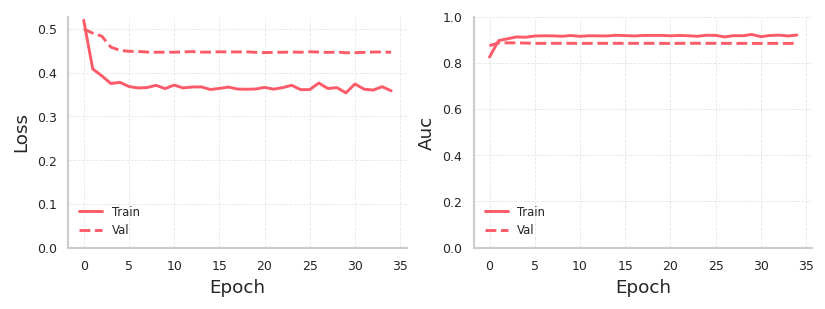

In [ ]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [ ]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Legitimate Transactions Detected (True Negatives):  95
Legitimate Transactions Incorrectly Detected (False Positives):  21
Fraudulent Transactions Missed (False Negatives):  55
Fraudulent Transactions Detected (True Positives):  188
Total Fraudulent Transactions:  243


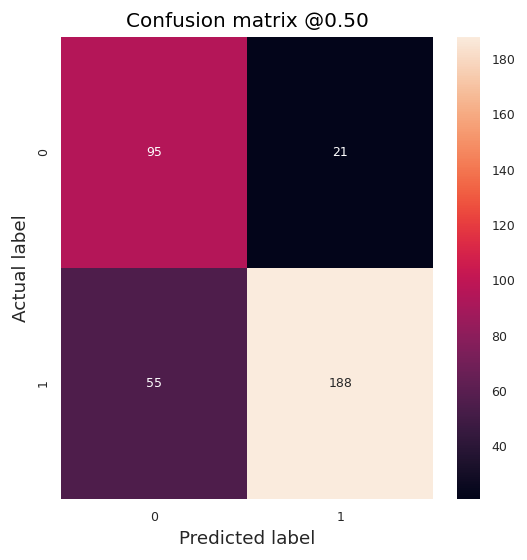

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
#plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v3_all_data_ext.csv")

### 4.3 CNN Classifier

In [ ]:
def make_model_cnn(metrics=METRICS, filters=64, kernel_size=2, kr=0.01, sdo=0.2,
               units_dense=256, output_bias=None, gn=0.025, activation="relu", do=0.3):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")

  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  # Cnn Layers
  # Layer 0
  cnn_out = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1,
                                kernel_regularizer=keras.regularizers.l2(kr),
                                padding="same", activation=None, name="cnn_0")(data_noised)
  cnn_out = keras.layers.LayerNormalization(name="ln_0")(cnn_out)
  cnn_out = keras.layers.Activation("relu", name="act_0")(cnn_out)
  cnn_out = keras.layers.SpatialDropout1D(sdo, name="sdo_0")(cnn_out)
  cnn_out = keras.layers.MaxPooling1D(pool_size=2, name="max_pool_1")(cnn_out)
  # Layer 1
  cnn_out = keras.layers.Conv1D(filters=int(filters*2), kernel_size=kernel_size, strides=1,
                                kernel_regularizer=keras.regularizers.l2(kr),
                                padding="same", activation=None, name="cnn_1")(cnn_out)
  cnn_out = keras.layers.LayerNormalization(name="ln_1")(cnn_out)
  cnn_out = keras.layers.Activation("relu", name="act_1")(cnn_out)
  cnn_out = keras.layers.SpatialDropout1D(sdo, name="sdo_1")(cnn_out)

  #outputs
  cnn_out_ave = keras.layers.GlobalAveragePooling1D(name="average_pool_final")(cnn_out)
  cnn_out_max = keras.layers.GlobalMaxPooling1D(name="max_pool_final")(cnn_out)

  x = keras.layers.Concatenate(name="concat")([cnn_out_ave, cnn_out_max])

  # Dense Layer
  x = keras.layers.Dense(units_dense, name="dense_1")(x)
  x = keras.layers.BatchNormalization(name="batch_dense")(x)
  x = keras.layers.Activation(activation, name="act_dense")(x)
  x = keras.layers.Dropout(do, name="do_dense")(x)

  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="cnn_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=5e-4),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model_cnn(output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

Model: "cnn_v0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 30)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ noise_layer               │ (None, 7, 30)          │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_0 (Conv1D)            │ (None, 7, 64)          │          3,904 │ noise_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln_0 (LayerNormalization) │ (None, 7, 64)          │            128 │ cnn_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_0 (Activation)        │ (None, 7, 64)          │              0 │ ln_0[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sdo_0 (SpatialDropout1D)  │ (None, 7, 64)          │              0 │ act_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_1 (MaxPooling1D) │ (None, 3, 64)          │              0 │ sdo_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_1 (Conv1D)            │ (None, 3, 128)         │         16,512 │ max_pool_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln_1 (LayerNormalization) │ (None, 3, 128)         │            256 │ cnn_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_1 (Activation)        │ (None, 3, 128)         │              0 │ ln_1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sdo_1 (SpatialDropout1D)  │ (None, 3, 128)         │              0 │ act_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pool_final        │ (None, 128)            │              0 │ sdo_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_final            │ (None, 128)            │              0 │ sdo_1[0][0]            │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, 256)            │              0 │ average_pool_final[0]… │
│                           │                        │                │ max_pool_final[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ concat[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_dense               │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_dense (Activation)    │ (None, 256)            │              0 │ batch_dense[0][0]      │
├──────────────────────

 Total params: 87,873 (343.25 KB)

 Trainable params: 87,361 (341.25 KB)

 Non-trainable params: 512 (2.00 KB)

#### Optuna Optimization

In [261]:
def objective_nn(trial, train_data, validation_data, model=make_model_cnn, use_gpu=False, rs=42, fit_scaling=False, epochs=21):

    model_class = model

    params = {
              'filters': trial.suggest_categorical('filters', [16,32,64]),
              'kernel_size': trial.suggest_categorical('kernel_size', [2,3]),
              'units_dense': trial.suggest_categorical('units_dense', [256, 128, 64]),
              'sdo': trial.suggest_float('sdo', 0.20, 0.45, step=0.01),
              'kr': trial.suggest_float('kr', 0.01, 0.1, step=0.01),
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=9, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=make_model_cnn, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model_cnn, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

[I 2025-03-09 15:47:07,030] A new study created in memory with name: no-name-3336e2a7-c4b2-4c31-a25b-61e45c5943a1


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6774 - cross entropy: 0.7308 - loss: 2.0633 - prc: 0.7105 - val_auc: 0.7505 - val_cross entropy: 0.5940 - val_loss: 1.6863 - val_prc: 0.8457 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6918 - cross entropy: 0.6465 - loss: 1.6989 - prc: 0.6863 - val_auc: 0.7953 - val_cross entropy: 0.6212 - val_loss: 1.5612 - val_prc: 0.8727 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7326 - cross entropy: 0.6137 - loss: 1.5202 - prc: 0.7232 - val_auc: 0.8330 - val_cross entropy: 0.5415 - val_loss: 1.3536 - val_prc: 0.9006 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7841 - cross entropy: 0.5643 - loss: 1.3481 - prc: 0.7838 - val_auc: 0.8421 - val_cross entropy: 0.5281 - val_loss: 1.2323 - val_prc: 0.8939 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7862 - cross entropy: 0.

[I 2025-03-09 15:47:23,902] Trial 0 finished with value: 0.8604725415070242 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.39, 'kr': 0.01, 'activation': 'silu', 'gn': 0.09, 'do': 0.22}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6469 - cross entropy: 0.8628 - loss: 6.7378 - prc: 0.6535 - val_auc: 0.7429 - val_cross entropy: 0.6293 - val_loss: 4.8119 - val_prc: 0.8278 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7060 - cross entropy: 0.6418 - loss: 4.4243 - prc: 0.6982 - val_auc: 0.8097 - val_cross entropy: 0.7190 - val_loss: 3.4801 - val_prc: 0.8773 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7804 - cross entropy: 0.5739 - loss: 3.0824 - prc: 0.7708 - val_auc: 0.8290 - val_cross entropy: 0.5436 - val_loss: 2.4108 - val_prc: 0.8635 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8243 - cross entropy: 0.5218 - loss: 2.2303 - prc: 0.8214 - val_auc: 0.8350 - val_cross entropy: 0.6768 - val_loss: 1.9809 - val_prc: 0.8897 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8377 - cross entropy: 0.

[I 2025-03-09 15:47:39,592] Trial 1 finished with value: 0.8491201929899248 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.23, 'kr': 0.05, 'activation': 'relu', 'gn': 0.08, 'do': 0.24000000000000002}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - auc: 0.6333 - cross entropy: 0.7698 - loss: 2.2288 - prc: 0.6803 - val_auc: 0.7266 - val_cross entropy: 0.6112 - val_loss: 1.8450 - val_prc: 0.7988 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6438 - cross entropy: 0.6822 - loss: 1.8606 - prc: 0.6546 - val_auc: 0.7508 - val_cross entropy: 0.6597 - val_loss: 1.6806 - val_prc: 0.8165 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7012 - cross entropy: 0.6360 - loss: 1.6102 - prc: 0.6929 - val_auc: 0.7769 - val_cross entropy: 0.6653 - val_loss: 1.5089 - val_prc: 0.8291 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6971 - cross entropy: 0.6408 - loss: 1.4462 - prc: 0.7009 - val_auc: 0.7989 - val_cross entropy: 0.6142 - val_loss: 1.3134 - val_prc: 0.8445 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7340 - cross entropy: 0.6157

[I 2025-03-09 15:47:53,682] Trial 2 finished with value: 0.8510004257130694 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.36, 'kr': 0.02, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.22}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - auc: 0.6003 - cross entropy: 0.8005 - loss: 5.0058 - prc: 0.6126 - val_auc: 0.6105 - val_cross entropy: 0.6523 - val_loss: 3.8557 - val_prc: 0.7678 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6105 - cross entropy: 0.7281 - loss: 3.6839 - prc: 0.6104 - val_auc: 0.6641 - val_cross entropy: 0.6536 - val_loss: 2.9473 - val_prc: 0.7991 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6345 - cross entropy: 0.6945 - loss: 2.8109 - prc: 0.6252 - val_auc: 0.7275 - val_cross entropy: 0.6623 - val_loss: 2.3082 - val_prc: 0.8311 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6797 - cross entropy: 0.6641 - loss: 2.1852 - prc: 0.6803 - val_auc: 0.7858 - val_cross entropy: 0.6019 - val_loss: 1.7922 - val_prc: 0.8614 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7306 - cross entropy: 0.

[I 2025-03-09 15:48:08,539] Trial 3 finished with value: 0.8463175819497658 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.03, 'do': 0.29000000000000004}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - auc: 0.6334 - cross entropy: 0.8958 - loss: 1.7624 - prc: 0.6384 - val_auc: 0.7319 - val_cross entropy: 0.6593 - val_loss: 1.3484 - val_prc: 0.8203 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6747 - cross entropy: 0.6847 - loss: 1.3616 - prc: 0.6562 - val_auc: 0.7691 - val_cross entropy: 0.6292 - val_loss: 1.2698 - val_prc: 0.8398 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7306 - cross entropy: 0.6285 - loss: 1.2574 - prc: 0.7155 - val_auc: 0.8087 - val_cross entropy: 0.6015 - val_loss: 1.1963 - val_prc: 0.8726 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7741 - cross entropy: 0.5862 - loss: 1.1702 - prc: 0.7697 - val_auc: 0.8211 - val_cross entropy: 0.5577 - val_loss: 1.1097 - val_prc: 0.8832 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7589 - cross entropy: 0.

[I 2025-03-09 15:48:23,845] Trial 4 finished with value: 0.8525613736341705 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.22, 'kr': 0.01, 'activation': 'relu', 'gn': 0.05, 'do': 0.39}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6529 - cross entropy: 0.8511 - loss: 10.0599 - prc: 0.6597 - val_auc: 0.7783 - val_cross entropy: 0.6323 - val_loss: 6.9565 - val_prc: 0.8533 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7153 - cross entropy: 0.6334 - loss: 6.2722 - prc: 0.6987 - val_auc: 0.8196 - val_cross entropy: 0.5828 - val_loss: 4.4977 - val_prc: 0.8845 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7614 - cross entropy: 0.5922 - loss: 4.0905 - prc: 0.7454 - val_auc: 0.8377 - val_cross entropy: 0.4772 - val_loss: 2.9261 - val_prc: 0.8814 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7891 - cross entropy: 0.5666 - loss: 2.7624 - prc: 0.7848 - val_auc: 0.8537 - val_cross entropy: 0.5314 - val_loss: 2.0931 - val_prc: 0.9128 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8302 - cross entropy: 0

[I 2025-03-09 15:48:41,684] Trial 5 finished with value: 0.8537675606641124 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.29000000000000004, 'kr': 0.08, 'activation': 'relu', 'gn': 0.09, 'do': 0.2}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6429 - cross entropy: 0.7365 - loss: 2.4552 - prc: 0.6833 - val_auc: 0.6850 - val_cross entropy: 0.6214 - val_loss: 2.0429 - val_prc: 0.7953 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.5977 - cross entropy: 0.7210 - loss: 2.0764 - prc: 0.5952 - val_auc: 0.7168 - val_cross entropy: 0.6310 - val_loss: 1.8008 - val_prc: 0.8269 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6464 - cross entropy: 0.6811 - loss: 1.7959 - prc: 0.6278 - val_auc: 0.7362 - val_cross entropy: 0.6568 - val_loss: 1.6173 - val_prc: 0.8446 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6407 - cross entropy: 0.6828 - loss: 1.5982 - prc: 0.6430 - val_auc: 0.7671 - val_cross entropy: 0.6205 - val_loss: 1.4099 - val_prc: 0.8573 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6978 - cross entropy: 0.6380

[I 2025-03-09 15:48:55,442] Trial 6 finished with value: 0.8436568752660707 and parameters: {'filters': 16, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.21000000000000002, 'kr': 0.04, 'activation': 'gelu', 'gn': 0.05, 'do': 0.25}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6208 - cross entropy: 0.8027 - loss: 7.6769 - prc: 0.6273 - val_auc: 0.6319 - val_cross entropy: 0.6983 - val_loss: 5.8749 - val_prc: 0.7743 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.5345 - cross entropy: 0.8638 - loss: 5.6049 - prc: 0.5365 - val_auc: 0.6666 - val_cross entropy: 0.8657 - val_loss: 4.4529 - val_prc: 0.7829 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.5749 - cross entropy: 0.7967 - loss: 4.0807 - prc: 0.5811 - val_auc: 0.7134 - val_cross entropy: 0.8283 - val_loss: 3.3162 - val_prc: 0.8050 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6205 - cross entropy: 0.7590 - loss: 3.0397 - prc: 0.6133 - val_auc: 0.7586 - val_cross entropy: 0.7439 - val_loss: 2.4831 - val_prc: 0.8353 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6522 - cross entropy: 0.7

[I 2025-03-09 15:49:10,837] Trial 7 finished with value: 0.85178089967362 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.36, 'kr': 0.09999999999999999, 'activation': 'selu', 'gn': 0.03, 'do': 0.44}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - auc: 0.5891 - cross entropy: 0.8865 - loss: 4.2383 - prc: 0.6195 - val_auc: 0.6684 - val_cross entropy: 0.6862 - val_loss: 3.4151 - val_prc: 0.7835 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.5365 - cross entropy: 0.8333 - loss: 3.4067 - prc: 0.5312 - val_auc: 0.6778 - val_cross entropy: 0.7480 - val_loss: 2.8892 - val_prc: 0.7854 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.5648 - cross entropy: 0.7931 - loss: 2.8100 - prc: 0.5545 - val_auc: 0.6706 - val_cross entropy: 0.6945 - val_loss: 2.3685 - val_prc: 0.7862 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5817 - cross entropy: 0.7796 - loss: 2.3562 - prc: 0.5824 - val_auc: 0.7356 - val_cross entropy: 0.7150 - val_loss: 2.0245 - val_prc: 0.8247 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6097 - cross entropy: 0.7

[I 2025-03-09 15:49:24,626] Trial 8 finished with value: 0.8153824322406699 and parameters: {'filters': 16, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.33, 'kr': 0.08, 'activation': 'selu', 'gn': 0.04, 'do': 0.45}. Best is trial 0 with value: 0.8604725415070242.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - auc: 0.5945 - cross entropy: 0.9064 - loss: 7.1636 - prc: 0.5931 - val_auc: 0.6947 - val_cross entropy: 0.6976 - val_loss: 5.4122 - val_prc: 0.7942 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6616 - cross entropy: 0.6732 - loss: 5.0034 - prc: 0.6742 - val_auc: 0.7429 - val_cross entropy: 0.7079 - val_loss: 4.0127 - val_prc: 0.8183 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6963 - cross entropy: 0.6449 - loss: 3.6763 - prc: 0.6890 - val_auc: 0.7918 - val_cross entropy: 0.6135 - val_loss: 2.9225 - val_prc: 0.8539 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7392 - cross entropy: 0.6116 - loss: 2.7301 - prc: 0.7434 - val_auc: 0.8173 - val_cross entropy: 0.5870 - val_loss: 2.2039 - val_prc: 0.8748 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7889 - cross entropy: 0.

[I 2025-03-09 15:49:39,766] Trial 9 finished with value: 0.8610046828437634 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.27, 'kr': 0.09, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.23}. Best is trial 9 with value: 0.8610046828437634.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6039 - cross entropy: 0.8426 - loss: 7.7423 - prc: 0.6230 - val_auc: 0.6887 - val_cross entropy: 0.6683 - val_loss: 5.8243 - val_prc: 0.7900 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5966 - cross entropy: 0.7291 - loss: 5.4454 - prc: 0.5836 - val_auc: 0.7165 - val_cross entropy: 0.6810 - val_loss: 4.2342 - val_prc: 0.8102 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6184 - cross entropy: 0.7078 - loss: 3.9542 - prc: 0.6030 - val_auc: 0.7449 - val_cross entropy: 0.6880 - val_loss: 3.1266 - val_prc: 0.8325 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6421 - cross entropy: 0.6903 - loss: 2.9170 - prc: 0.6387 - val_auc: 0.7730 - val_cross entropy: 0.6186 - val_loss: 2.2908 - val_prc: 0.8451 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6545 - cross entropy: 0.

[I 2025-03-09 15:50:03,588] Trial 10 finished with value: 0.8512842344259969 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.45, 'kr': 0.09999999999999999, 'activation': 'gelu', 'gn': 0.01, 'do': 0.34}. Best is trial 9 with value: 0.8610046828437634.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - auc: 0.6536 - cross entropy: 0.7475 - loss: 4.3489 - prc: 0.6718 - val_auc: 0.7467 - val_cross entropy: 0.6667 - val_loss: 3.4037 - val_prc: 0.8444 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6715 - cross entropy: 0.6749 - loss: 3.2025 - prc: 0.6655 - val_auc: 0.7965 - val_cross entropy: 0.6339 - val_loss: 2.6080 - val_prc: 0.8628 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7113 - cross entropy: 0.6366 - loss: 2.4642 - prc: 0.7036 - val_auc: 0.8320 - val_cross entropy: 0.5050 - val_loss: 1.9453 - val_prc: 0.8937 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7613 - cross entropy: 0.5923 - loss: 1.9304 - prc: 0.7672 - val_auc: 0.8442 - val_cross entropy: 0.5602 - val_loss: 1.6276 - val_prc: 0.8940 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7789 - cross entropy: 0.

[I 2025-03-09 15:50:21,257] Trial 11 finished with value: 0.8571732652192422 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.42000000000000004, 'kr': 0.03, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.28}. Best is trial 9 with value: 0.8610046828437634.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6516 - cross entropy: 0.7527 - loss: 8.7823 - prc: 0.6692 - val_auc: 0.7502 - val_cross entropy: 0.6349 - val_loss: 6.1752 - val_prc: 0.8468 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6697 - cross entropy: 0.6763 - loss: 5.6186 - prc: 0.6708 - val_auc: 0.7866 - val_cross entropy: 0.6326 - val_loss: 4.0639 - val_prc: 0.8622 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7158 - cross entropy: 0.6311 - loss: 3.6959 - prc: 0.6995 - val_auc: 0.8223 - val_cross entropy: 0.5383 - val_loss: 2.6838 - val_prc: 0.8768 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7756 - cross entropy: 0.5760 - loss: 2.5007 - prc: 0.7778 - val_auc: 0.8493 - val_cross entropy: 0.4923 - val_loss: 1.8624 - val_prc: 0.8963 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7859 - cross entropy: 0.

[I 2025-03-09 15:50:39,252] Trial 12 finished with value: 0.8577054065559813 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.39, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.33}. Best is trial 9 with value: 0.8610046828437634.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6972 - cross entropy: 0.7175 - loss: 2.0283 - prc: 0.7085 - val_auc: 0.7971 - val_cross entropy: 0.5652 - val_loss: 1.6668 - val_prc: 0.8687 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7077 - cross entropy: 0.6423 - loss: 1.7063 - prc: 0.7104 - val_auc: 0.8343 - val_cross entropy: 0.5401 - val_loss: 1.4978 - val_prc: 0.8838 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7778 - cross entropy: 0.5748 - loss: 1.5003 - prc: 0.7621 - val_auc: 0.8513 - val_cross entropy: 0.5066 - val_loss: 1.3416 - val_prc: 0.8989 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8025 - cross entropy: 0.5459 - loss: 1.3537 - prc: 0.8103 - val_auc: 0.8573 - val_cross entropy: 0.4808 - val_loss: 1.2118 - val_prc: 0.9120 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8275 - cross entropy: 0.

[I 2025-03-09 15:50:57,251] Trial 13 finished with value: 0.8689158507166169 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.27, 'kr': 0.01, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.28}. Best is trial 13 with value: 0.8689158507166169.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6054 - cross entropy: 0.9072 - loss: 2.7183 - prc: 0.6186 - val_auc: 0.6408 - val_cross entropy: 0.6703 - val_loss: 2.1174 - val_prc: 0.7866 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.5852 - cross entropy: 0.7274 - loss: 2.1123 - prc: 0.5753 - val_auc: 0.6541 - val_cross entropy: 0.6731 - val_loss: 1.8810 - val_prc: 0.8087 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6499 - cross entropy: 0.6804 - loss: 1.8350 - prc: 0.6358 - val_auc: 0.7107 - val_cross entropy: 0.7143 - val_loss: 1.7187 - val_prc: 0.8220 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6449 - cross entropy: 0.6833 - loss: 1.6433 - prc: 0.6437 - val_auc: 0.7420 - val_cross entropy: 0.6372 - val_loss: 1.4730 - val_prc: 0.8492 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6861 - cross entropy: 0.6

[I 2025-03-09 15:51:12,141] Trial 14 finished with value: 0.8297502483326239 and parameters: {'filters': 16, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.27, 'kr': 0.04, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.28}. Best is trial 13 with value: 0.8689158507166169.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6263 - cross entropy: 0.7408 - loss: 6.9157 - prc: 0.6472 - val_auc: 0.7283 - val_cross entropy: 0.6170 - val_loss: 5.2434 - val_prc: 0.8051 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6486 - cross entropy: 0.6890 - loss: 4.9183 - prc: 0.6334 - val_auc: 0.7590 - val_cross entropy: 0.6606 - val_loss: 3.8395 - val_prc: 0.8286 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6943 - cross entropy: 0.6466 - loss: 3.5491 - prc: 0.6678 - val_auc: 0.7942 - val_cross entropy: 0.6905 - val_loss: 2.8680 - val_prc: 0.8529 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7310 - cross entropy: 0.6168 - loss: 2.6049 - prc: 0.7264 - val_auc: 0.8167 - val_cross entropy: 0.5804 - val_loss: 2.0734 - val_prc: 0.8640 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7524 - cross entropy: 0.

[I 2025-03-09 15:51:27,643] Trial 15 finished with value: 0.8527387540797502 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.31, 'kr': 0.09, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.30000000000000004}. Best is trial 13 with value: 0.8689158507166169.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6748 - cross entropy: 0.7674 - loss: 7.8771 - prc: 0.6855 - val_auc: 0.8149 - val_cross entropy: 0.6694 - val_loss: 6.0799 - val_prc: 0.8627 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6972 - cross entropy: 0.7124 - loss: 5.6842 - prc: 0.6839 - val_auc: 0.8280 - val_cross entropy: 0.7166 - val_loss: 4.5317 - val_prc: 0.8908 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7250 - cross entropy: 0.6680 - loss: 4.1792 - prc: 0.7196 - val_auc: 0.8511 - val_cross entropy: 0.6714 - val_loss: 3.3818 - val_prc: 0.9100 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7687 - cross entropy: 0.6083 - loss: 3.1091 - prc: 0.7772 - val_auc: 0.8552 - val_cross entropy: 0.5658 - val_loss: 2.5178 - val_prc: 0.8975 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8103 - cross entropy: 0.

[I 2025-03-09 15:51:45,157] Trial 16 finished with value: 0.8718603661132397 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.08, 'do': 0.37}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6911 - cross entropy: 0.7633 - loss: 7.8741 - prc: 0.7096 - val_auc: 0.8053 - val_cross entropy: 0.7201 - val_loss: 6.1406 - val_prc: 0.8832 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6998 - cross entropy: 0.7040 - loss: 5.6870 - prc: 0.6842 - val_auc: 0.8386 - val_cross entropy: 0.6860 - val_loss: 4.5126 - val_prc: 0.8970 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7486 - cross entropy: 0.6282 - loss: 4.1488 - prc: 0.7358 - val_auc: 0.8369 - val_cross entropy: 0.5914 - val_loss: 3.3067 - val_prc: 0.9061 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7767 - cross entropy: 0.5984 - loss: 3.1038 - prc: 0.7740 - val_auc: 0.8542 - val_cross entropy: 0.5956 - val_loss: 2.5500 - val_prc: 0.8928 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8120 - cross entropy: 0.

[I 2025-03-09 15:52:02,440] Trial 17 finished with value: 0.8665034766567333 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.37}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - auc: 0.6830 - cross entropy: 0.7657 - loss: 6.7092 - prc: 0.7149 - val_auc: 0.7601 - val_cross entropy: 0.7084 - val_loss: 5.2976 - val_prc: 0.8577 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6643 - cross entropy: 0.7335 - loss: 4.9705 - prc: 0.6527 - val_auc: 0.8094 - val_cross entropy: 0.7255 - val_loss: 4.0241 - val_prc: 0.8834 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7431 - cross entropy: 0.6400 - loss: 3.6887 - prc: 0.7137 - val_auc: 0.8313 - val_cross entropy: 0.5442 - val_loss: 2.9324 - val_prc: 0.8889 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7851 - cross entropy: 0.5885 - loss: 2.8028 - prc: 0.7892 - val_auc: 0.8497 - val_cross entropy: 0.5390 - val_loss: 2.2967 - val_prc: 0.9146 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8000 - cross entropy: 0.

[I 2025-03-09 15:52:21,071] Trial 18 finished with value: 0.8518518518518519 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.25, 'kr': 0.05, 'activation': 'selu', 'gn': 0.08, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6854 - cross entropy: 0.7606 - loss: 4.4339 - prc: 0.7101 - val_auc: 0.8459 - val_cross entropy: 0.5999 - val_loss: 3.6442 - val_prc: 0.9088 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7171 - cross entropy: 0.6757 - loss: 3.5516 - prc: 0.7065 - val_auc: 0.8579 - val_cross entropy: 0.5101 - val_loss: 2.9212 - val_prc: 0.9131 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7725 - cross entropy: 0.6038 - loss: 2.8819 - prc: 0.7564 - val_auc: 0.8502 - val_cross entropy: 0.5278 - val_loss: 2.4414 - val_prc: 0.9082 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7904 - cross entropy: 0.5822 - loss: 2.3927 - prc: 0.7844 - val_auc: 0.8588 - val_cross entropy: 0.4979 - val_loss: 2.0266 - val_prc: 0.9189 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8261 - cross entropy: 0.

[I 2025-03-09 15:52:37,561] Trial 19 finished with value: 0.8643039591315453 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.2, 'kr': 0.03, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.35}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6789 - cross entropy: 0.7811 - loss: 8.8449 - prc: 0.7063 - val_auc: 0.7720 - val_cross entropy: 0.6455 - val_loss: 6.2852 - val_prc: 0.8551 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6896 - cross entropy: 0.6656 - loss: 5.7212 - prc: 0.6786 - val_auc: 0.8050 - val_cross entropy: 0.6310 - val_loss: 4.2060 - val_prc: 0.8698 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7401 - cross entropy: 0.6127 - loss: 3.8240 - prc: 0.7326 - val_auc: 0.8336 - val_cross entropy: 0.5114 - val_loss: 2.8018 - val_prc: 0.8897 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7877 - cross entropy: 0.5660 - loss: 2.6317 - prc: 0.7837 - val_auc: 0.8463 - val_cross entropy: 0.4819 - val_loss: 1.9787 - val_prc: 0.9039 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8262 - cross entropy: 0.

[I 2025-03-09 15:52:55,417] Trial 20 finished with value: 0.8621753937845893 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.31, 'kr': 0.06999999999999999, 'activation': 'gelu', 'gn': 0.08, 'do': 0.31}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6912 - cross entropy: 0.7511 - loss: 7.8703 - prc: 0.6998 - val_auc: 0.8012 - val_cross entropy: 0.6490 - val_loss: 6.0551 - val_prc: 0.8607 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7077 - cross entropy: 0.6847 - loss: 5.6470 - prc: 0.6896 - val_auc: 0.8369 - val_cross entropy: 0.7184 - val_loss: 4.5156 - val_prc: 0.8887 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7476 - cross entropy: 0.6383 - loss: 4.1317 - prc: 0.7259 - val_auc: 0.8379 - val_cross entropy: 0.6392 - val_loss: 3.3338 - val_prc: 0.8814 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7667 - cross entropy: 0.6227 - loss: 3.1093 - prc: 0.7681 - val_auc: 0.8564 - val_cross entropy: 0.5817 - val_loss: 2.5234 - val_prc: 0.9203 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7964 - cross entropy: 0.

[I 2025-03-09 15:53:13,194] Trial 21 finished with value: 0.8626720590322122 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.37}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6806 - cross entropy: 0.7973 - loss: 9.0558 - prc: 0.7030 - val_auc: 0.8183 - val_cross entropy: 0.7180 - val_loss: 6.9014 - val_prc: 0.8741 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6840 - cross entropy: 0.7204 - loss: 6.3727 - prc: 0.6785 - val_auc: 0.8280 - val_cross entropy: 0.6429 - val_loss: 4.9031 - val_prc: 0.8754 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7237 - cross entropy: 0.6771 - loss: 4.5774 - prc: 0.6954 - val_auc: 0.8569 - val_cross entropy: 0.7256 - val_loss: 3.6888 - val_prc: 0.9167 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7614 - cross entropy: 0.6155 - loss: 3.3362 - prc: 0.7540 - val_auc: 0.8577 - val_cross entropy: 0.5784 - val_loss: 2.6653 - val_prc: 0.9033 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8055 - cross entropy: 0.

[I 2025-03-09 15:53:30,321] Trial 22 finished with value: 0.8680644245778346 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6856 - cross entropy: 0.7826 - loss: 9.0236 - prc: 0.7102 - val_auc: 0.8059 - val_cross entropy: 0.7316 - val_loss: 6.9213 - val_prc: 0.8629 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7047 - cross entropy: 0.7051 - loss: 6.3667 - prc: 0.6954 - val_auc: 0.8387 - val_cross entropy: 0.7343 - val_loss: 5.0112 - val_prc: 0.8916 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7199 - cross entropy: 0.6798 - loss: 4.5965 - prc: 0.7116 - val_auc: 0.8441 - val_cross entropy: 0.5380 - val_loss: 3.5148 - val_prc: 0.8934 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7476 - cross entropy: 0.6485 - loss: 3.3831 - prc: 0.7494 - val_auc: 0.8603 - val_cross entropy: 0.5367 - val_loss: 2.6376 - val_prc: 0.9001 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7921 - cross entropy: 0.

[I 2025-03-09 15:53:47,580] Trial 23 finished with value: 0.8668582375478926 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6793 - cross entropy: 0.7834 - loss: 5.6303 - prc: 0.6997 - val_auc: 0.7851 - val_cross entropy: 0.6926 - val_loss: 4.6164 - val_prc: 0.8504 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6880 - cross entropy: 0.7268 - loss: 4.4060 - prc: 0.6773 - val_auc: 0.8210 - val_cross entropy: 0.8371 - val_loss: 3.8533 - val_prc: 0.8822 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7171 - cross entropy: 0.6915 - loss: 3.5232 - prc: 0.7026 - val_auc: 0.8509 - val_cross entropy: 0.7455 - val_loss: 3.0774 - val_prc: 0.9041 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7515 - cross entropy: 0.6475 - loss: 2.8408 - prc: 0.7356 - val_auc: 0.8532 - val_cross entropy: 0.6025 - val_loss: 2.4193 - val_prc: 0.8996 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7675 - cross entropy: 0.

[I 2025-03-09 15:54:05,211] Trial 24 finished with value: 0.8613594437349227 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.29000000000000004, 'kr': 0.04, 'activation': 'selu', 'gn': 0.09, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.6801 - cross entropy: 0.7457 - loss: 9.8816 - prc: 0.6958 - val_auc: 0.7794 - val_cross entropy: 0.6334 - val_loss: 6.9152 - val_prc: 0.8569 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7020 - cross entropy: 0.6540 - loss: 6.2451 - prc: 0.6883 - val_auc: 0.8174 - val_cross entropy: 0.5893 - val_loss: 4.4389 - val_prc: 0.8741 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7368 - cross entropy: 0.6196 - loss: 4.0505 - prc: 0.7141 - val_auc: 0.8450 - val_cross entropy: 0.4818 - val_loss: 2.8651 - val_prc: 0.8954 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7858 - cross entropy: 0.5666 - loss: 2.6993 - prc: 0.7798 - val_auc: 0.8456 - val_cross entropy: 0.5703 - val_loss: 2.0735 - val_prc: 0.9022 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8195 - cross entropy: 0.

[I 2025-03-09 15:54:24,106] Trial 25 finished with value: 0.8596211153682418 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.29000000000000004, 'kr': 0.08, 'activation': 'silu', 'gn': 0.04, 'do': 0.37}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6087 - cross entropy: 0.8454 - loss: 3.0162 - prc: 0.6454 - val_auc: 0.6564 - val_cross entropy: 0.7167 - val_loss: 2.5173 - val_prc: 0.7584 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5522 - cross entropy: 0.8129 - loss: 2.5347 - prc: 0.5511 - val_auc: 0.6273 - val_cross entropy: 0.8540 - val_loss: 2.3531 - val_prc: 0.7673 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.5911 - cross entropy: 0.7739 - loss: 2.2066 - prc: 0.5731 - val_auc: 0.6565 - val_cross entropy: 0.8128 - val_loss: 2.0584 - val_prc: 0.7563 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5877 - cross entropy: 0.7793 - loss: 1.9701 - prc: 0.5946 - val_auc: 0.6841 - val_cross entropy: 0.7675 - val_loss: 1.8048 - val_prc: 0.7861 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6057 - cross entropy: 0.

[I 2025-03-09 15:54:39,060] Trial 26 finished with value: 0.8238612175393785 and parameters: {'filters': 16, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.33, 'kr': 0.05, 'activation': 'selu', 'gn': 0.08, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6869 - cross entropy: 0.7389 - loss: 3.2493 - prc: 0.6956 - val_auc: 0.8217 - val_cross entropy: 0.6135 - val_loss: 2.7785 - val_prc: 0.8749 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7132 - cross entropy: 0.6736 - loss: 2.7532 - prc: 0.7050 - val_auc: 0.8362 - val_cross entropy: 0.7349 - val_loss: 2.5717 - val_prc: 0.8977 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7677 - cross entropy: 0.6136 - loss: 2.3780 - prc: 0.7495 - val_auc: 0.8428 - val_cross entropy: 0.6415 - val_loss: 2.2018 - val_prc: 0.8933 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8050 - cross entropy: 0.5628 - loss: 2.0625 - prc: 0.8091 - val_auc: 0.8510 - val_cross entropy: 0.6546 - val_loss: 1.9840 - val_prc: 0.9082 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8303 - cross entropy: 0.

[I 2025-03-09 15:54:56,577] Trial 27 finished with value: 0.8663260962111536 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.22, 'kr': 0.02, 'activation': 'selu', 'gn': 0.05, 'do': 0.32}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6692 - cross entropy: 0.7262 - loss: 8.7398 - prc: 0.7045 - val_auc: 0.7847 - val_cross entropy: 0.6249 - val_loss: 6.2009 - val_prc: 0.8682 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7168 - cross entropy: 0.6440 - loss: 5.6264 - prc: 0.7041 - val_auc: 0.8259 - val_cross entropy: 0.5812 - val_loss: 4.0583 - val_prc: 0.8853 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7646 - cross entropy: 0.5885 - loss: 3.6987 - prc: 0.7525 - val_auc: 0.8376 - val_cross entropy: 0.5605 - val_loss: 2.7479 - val_prc: 0.9048 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8132 - cross entropy: 0.5342 - loss: 2.4992 - prc: 0.8148 - val_auc: 0.8495 - val_cross entropy: 0.4975 - val_loss: 1.9034 - val_prc: 0.9039 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8254 - cross entropy: 0.

[I 2025-03-09 15:55:13,799] Trial 28 finished with value: 0.851248758336881 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.25, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.35}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6949 - cross entropy: 0.6888 - loss: 1.9721 - prc: 0.7314 - val_auc: 0.8076 - val_cross entropy: 0.5679 - val_loss: 1.6636 - val_prc: 0.8801 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7480 - cross entropy: 0.6110 - loss: 1.6667 - prc: 0.7372 - val_auc: 0.8379 - val_cross entropy: 0.5516 - val_loss: 1.4941 - val_prc: 0.8970 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8083 - cross entropy: 0.5415 - loss: 1.4501 - prc: 0.7962 - val_auc: 0.8458 - val_cross entropy: 0.5200 - val_loss: 1.3330 - val_prc: 0.9064 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8205 - cross entropy: 0.5240 - loss: 1.3086 - prc: 0.8176 - val_auc: 0.8582 - val_cross entropy: 0.4848 - val_loss: 1.1896 - val_prc: 0.9184 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8434 - cross entropy: 0.

[I 2025-03-09 15:55:37,609] Trial 29 finished with value: 0.8597630197247056 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.2, 'kr': 0.01, 'activation': 'silu', 'gn': 0.09, 'do': 0.26}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6621 - cross entropy: 0.7984 - loss: 7.7982 - prc: 0.6839 - val_auc: 0.7559 - val_cross entropy: 0.6384 - val_loss: 5.6761 - val_prc: 0.8472 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6753 - cross entropy: 0.6850 - loss: 5.2427 - prc: 0.6714 - val_auc: 0.8029 - val_cross entropy: 0.5896 - val_loss: 3.9148 - val_prc: 0.8733 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7384 - cross entropy: 0.6182 - loss: 3.6337 - prc: 0.7200 - val_auc: 0.8367 - val_cross entropy: 0.5235 - val_loss: 2.7433 - val_prc: 0.8923 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7889 - cross entropy: 0.5666 - loss: 2.5870 - prc: 0.7787 - val_auc: 0.8496 - val_cross entropy: 0.5415 - val_loss: 2.0489 - val_prc: 0.9007 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8042 - cross entropy: 0.

[I 2025-03-09 15:55:54,982] Trial 30 finished with value: 0.8623527742301688 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.30000000000000004, 'kr': 0.060000000000000005, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.38}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6829 - cross entropy: 0.7719 - loss: 9.0188 - prc: 0.6930 - val_auc: 0.7866 - val_cross entropy: 0.8364 - val_loss: 7.0347 - val_prc: 0.8441 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6958 - cross entropy: 0.7117 - loss: 6.3875 - prc: 0.6987 - val_auc: 0.8220 - val_cross entropy: 0.5890 - val_loss: 4.8969 - val_prc: 0.8844 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7286 - cross entropy: 0.6825 - loss: 4.6349 - prc: 0.7129 - val_auc: 0.8495 - val_cross entropy: 0.6350 - val_loss: 3.6560 - val_prc: 0.9069 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7649 - cross entropy: 0.6306 - loss: 3.4087 - prc: 0.7682 - val_auc: 0.8513 - val_cross entropy: 0.6007 - val_loss: 2.7417 - val_prc: 0.9012 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7858 - cross entropy: 0.

[I 2025-03-09 15:56:12,558] Trial 31 finished with value: 0.8682772811125301 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.43000000000000005}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6870 - cross entropy: 0.7914 - loss: 9.0503 - prc: 0.7097 - val_auc: 0.8173 - val_cross entropy: 0.6374 - val_loss: 6.8605 - val_prc: 0.8677 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6994 - cross entropy: 0.7158 - loss: 6.4141 - prc: 0.6908 - val_auc: 0.8376 - val_cross entropy: 0.7726 - val_loss: 5.0945 - val_prc: 0.8929 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7361 - cross entropy: 0.6602 - loss: 4.6239 - prc: 0.7305 - val_auc: 0.8614 - val_cross entropy: 0.5614 - val_loss: 3.5873 - val_prc: 0.9180 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7921 - cross entropy: 0.5915 - loss: 3.3742 - prc: 0.7992 - val_auc: 0.8586 - val_cross entropy: 0.4723 - val_loss: 2.6176 - val_prc: 0.9046 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7915 - cross entropy: 0.

[I 2025-03-09 15:56:29,824] Trial 32 finished with value: 0.8659713353199943 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.23, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.08, 'do': 0.43000000000000005}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6754 - cross entropy: 0.8065 - loss: 10.1820 - prc: 0.6917 - val_auc: 0.7948 - val_cross entropy: 0.6969 - val_loss: 7.6338 - val_prc: 0.8573 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6991 - cross entropy: 0.7220 - loss: 7.0359 - prc: 0.6815 - val_auc: 0.8294 - val_cross entropy: 0.6863 - val_loss: 5.3818 - val_prc: 0.8846 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7170 - cross entropy: 0.6871 - loss: 4.9697 - prc: 0.7082 - val_auc: 0.8470 - val_cross entropy: 0.7379 - val_loss: 3.9484 - val_prc: 0.9032 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7573 - cross entropy: 0.6429 - loss: 3.5794 - prc: 0.7522 - val_auc: 0.8521 - val_cross entropy: 0.5706 - val_loss: 2.7985 - val_prc: 0.8911 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7572 - cross entropy: 0

[I 2025-03-09 15:56:47,025] Trial 33 finished with value: 0.861749680715198 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.27, 'kr': 0.08, 'activation': 'selu', 'gn': 0.08, 'do': 0.45}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6714 - cross entropy: 0.7879 - loss: 6.7417 - prc: 0.6921 - val_auc: 0.7598 - val_cross entropy: 0.7965 - val_loss: 5.4303 - val_prc: 0.8200 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6799 - cross entropy: 0.7190 - loss: 5.0037 - prc: 0.6686 - val_auc: 0.7999 - val_cross entropy: 0.7194 - val_loss: 4.0774 - val_prc: 0.8570 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7338 - cross entropy: 0.6634 - loss: 3.7761 - prc: 0.7112 - val_auc: 0.8342 - val_cross entropy: 0.5167 - val_loss: 2.9814 - val_prc: 0.8818 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7750 - cross entropy: 0.6101 - loss: 2.9024 - prc: 0.7686 - val_auc: 0.8382 - val_cross entropy: 0.6827 - val_loss: 2.5170 - val_prc: 0.8902 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8125 - cross entropy: 0.

[I 2025-03-09 15:57:04,129] Trial 34 finished with value: 0.8425216404143607 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.05, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.39}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6816 - cross entropy: 0.7855 - loss: 7.8799 - prc: 0.7148 - val_auc: 0.8086 - val_cross entropy: 0.7312 - val_loss: 6.1822 - val_prc: 0.8595 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6948 - cross entropy: 0.7107 - loss: 5.7315 - prc: 0.6812 - val_auc: 0.8260 - val_cross entropy: 0.6629 - val_loss: 4.5438 - val_prc: 0.8778 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7266 - cross entropy: 0.6693 - loss: 4.2479 - prc: 0.6914 - val_auc: 0.8477 - val_cross entropy: 0.5786 - val_loss: 3.3585 - val_prc: 0.9087 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7569 - cross entropy: 0.6291 - loss: 3.1980 - prc: 0.7501 - val_auc: 0.8595 - val_cross entropy: 0.5333 - val_loss: 2.5449 - val_prc: 0.9153 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7751 - cross entropy: 0.

[I 2025-03-09 15:57:21,331] Trial 35 finished with value: 0.859514687100894 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.28, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6682 - cross entropy: 0.7226 - loss: 10.9481 - prc: 0.7059 - val_auc: 0.7860 - val_cross entropy: 0.6073 - val_loss: 7.5993 - val_prc: 0.8656 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7198 - cross entropy: 0.6437 - loss: 6.8492 - prc: 0.7154 - val_auc: 0.8267 - val_cross entropy: 0.5321 - val_loss: 4.7545 - val_prc: 0.8947 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7581 - cross entropy: 0.6001 - loss: 4.3453 - prc: 0.7493 - val_auc: 0.8466 - val_cross entropy: 0.5277 - val_loss: 3.0846 - val_prc: 0.8946 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8105 - cross entropy: 0.5353 - loss: 2.8110 - prc: 0.8101 - val_auc: 0.8445 - val_cross entropy: 0.5577 - val_loss: 2.1321 - val_prc: 0.9114 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8163 - cross entropy: 0

[I 2025-03-09 15:57:36,776] Trial 36 finished with value: 0.8575635021995175 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.09, 'activation': 'silu', 'gn': 0.09, 'do': 0.43000000000000005}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - auc: 0.6377 - cross entropy: 0.8060 - loss: 1.7639 - prc: 0.6685 - val_auc: 0.6572 - val_cross entropy: 0.7218 - val_loss: 1.5208 - val_prc: 0.7910 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.5813 - cross entropy: 0.7933 - loss: 1.5765 - prc: 0.5631 - val_auc: 0.6727 - val_cross entropy: 0.6873 - val_loss: 1.4236 - val_prc: 0.8054 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6211 - cross entropy: 0.7514 - loss: 1.4727 - prc: 0.6067 - val_auc: 0.7168 - val_cross entropy: 0.8200 - val_loss: 1.4968 - val_prc: 0.8377 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6226 - cross entropy: 0.7576 - loss: 1.4203 - prc: 0.6326 - val_auc: 0.7369 - val_cross entropy: 0.7172 - val_loss: 1.3391 - val_prc: 0.8384 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6505 - cross entropy: 0.

[I 2025-03-09 15:58:09,633] Trial 37 finished with value: 0.8332978572442175 and parameters: {'filters': 16, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.02, 'activation': 'selu', 'gn': 0.05, 'do': 0.39}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - auc: 0.6296 - cross entropy: 0.7765 - loss: 6.5435 - prc: 0.6381 - val_auc: 0.7014 - val_cross entropy: 0.6762 - val_loss: 4.7458 - val_prc: 0.7884 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6341 - cross entropy: 0.7145 - loss: 4.3763 - prc: 0.6224 - val_auc: 0.7635 - val_cross entropy: 0.6603 - val_loss: 3.2894 - val_prc: 0.8378 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7265 - cross entropy: 0.6285 - loss: 3.0037 - prc: 0.7162 - val_auc: 0.8202 - val_cross entropy: 0.5495 - val_loss: 2.2826 - val_prc: 0.8737 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7759 - cross entropy: 0.5739 - loss: 2.1501 - prc: 0.7720 - val_auc: 0.8330 - val_cross entropy: 0.5336 - val_loss: 1.7104 - val_prc: 0.8920 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7970 - cross entropy: 0.

[I 2025-03-09 15:58:29,570] Trial 38 finished with value: 0.8430183056619838 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.36, 'kr': 0.05, 'activation': 'silu', 'gn': 0.04, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6379 - cross entropy: 0.7801 - loss: 5.5057 - prc: 0.6835 - val_auc: 0.7656 - val_cross entropy: 0.6101 - val_loss: 4.1227 - val_prc: 0.8565 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6671 - cross entropy: 0.6831 - loss: 3.8946 - prc: 0.6654 - val_auc: 0.8125 - val_cross entropy: 0.5739 - val_loss: 2.9971 - val_prc: 0.8818 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7340 - cross entropy: 0.6130 - loss: 2.8316 - prc: 0.7191 - val_auc: 0.8391 - val_cross entropy: 0.5351 - val_loss: 2.2221 - val_prc: 0.8970 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7583 - cross entropy: 0.5902 - loss: 2.1409 - prc: 0.7624 - val_auc: 0.8557 - val_cross entropy: 0.5125 - val_loss: 1.7083 - val_prc: 0.9081 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8227 - cross entropy: 0.

[I 2025-03-09 15:58:46,785] Trial 39 finished with value: 0.855612317298141 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.34, 'kr': 0.04, 'activation': 'relu', 'gn': 0.08, 'do': 0.2}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6441 - cross entropy: 0.7488 - loss: 3.3129 - prc: 0.6592 - val_auc: 0.6561 - val_cross entropy: 0.7261 - val_loss: 2.8592 - val_prc: 0.7927 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5835 - cross entropy: 0.7501 - loss: 2.7789 - prc: 0.5769 - val_auc: 0.6595 - val_cross entropy: 0.7471 - val_loss: 2.4820 - val_prc: 0.8077 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6303 - cross entropy: 0.7190 - loss: 2.3673 - prc: 0.6198 - val_auc: 0.7145 - val_cross entropy: 0.7954 - val_loss: 2.2016 - val_prc: 0.8361 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6335 - cross entropy: 0.7197 - loss: 2.0553 - prc: 0.6469 - val_auc: 0.7424 - val_cross entropy: 0.6521 - val_loss: 1.7915 - val_prc: 0.8288 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6577 - cross entropy: 0.

[I 2025-03-09 15:59:02,409] Trial 40 finished with value: 0.8448630622960125 and parameters: {'filters': 16, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.05, 'do': 0.26}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6593 - cross entropy: 0.8102 - loss: 9.0490 - prc: 0.6608 - val_auc: 0.8008 - val_cross entropy: 0.6819 - val_loss: 6.8965 - val_prc: 0.8635 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6921 - cross entropy: 0.7281 - loss: 6.4167 - prc: 0.6862 - val_auc: 0.8252 - val_cross entropy: 0.7254 - val_loss: 5.0369 - val_prc: 0.8886 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7074 - cross entropy: 0.7023 - loss: 4.6557 - prc: 0.6878 - val_auc: 0.8471 - val_cross entropy: 0.7878 - val_loss: 3.8038 - val_prc: 0.8906 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7707 - cross entropy: 0.6143 - loss: 3.3864 - prc: 0.7662 - val_auc: 0.8562 - val_cross entropy: 0.6393 - val_loss: 2.7747 - val_prc: 0.9170 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7901 - cross entropy: 0.

[I 2025-03-09 15:59:20,775] Trial 41 finished with value: 0.8648006243791684 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.28, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.43000000000000005}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6819 - cross entropy: 0.7895 - loss: 10.1336 - prc: 0.7003 - val_auc: 0.8140 - val_cross entropy: 0.7427 - val_loss: 7.6197 - val_prc: 0.8667 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6882 - cross entropy: 0.7251 - loss: 6.9726 - prc: 0.6702 - val_auc: 0.8226 - val_cross entropy: 0.6265 - val_loss: 5.2448 - val_prc: 0.8870 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7353 - cross entropy: 0.6673 - loss: 4.8709 - prc: 0.7176 - val_auc: 0.8488 - val_cross entropy: 0.5855 - val_loss: 3.7162 - val_prc: 0.9099 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7784 - cross entropy: 0.6053 - loss: 3.4632 - prc: 0.7753 - val_auc: 0.8622 - val_cross entropy: 0.5737 - val_loss: 2.7270 - val_prc: 0.9229 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7973 - cross entropy: 0

[I 2025-03-09 15:59:38,968] Trial 42 finished with value: 0.8659358592308785 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.08, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6923 - cross entropy: 0.7821 - loss: 9.0323 - prc: 0.7135 - val_auc: 0.8059 - val_cross entropy: 0.6206 - val_loss: 6.8521 - val_prc: 0.8689 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7119 - cross entropy: 0.6945 - loss: 6.4049 - prc: 0.7024 - val_auc: 0.8288 - val_cross entropy: 0.7653 - val_loss: 5.1047 - val_prc: 0.8842 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7539 - cross entropy: 0.6569 - loss: 4.6390 - prc: 0.7361 - val_auc: 0.8413 - val_cross entropy: 0.5532 - val_loss: 3.6008 - val_prc: 0.8972 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7808 - cross entropy: 0.6121 - loss: 3.4166 - prc: 0.7759 - val_auc: 0.8575 - val_cross entropy: 0.5455 - val_loss: 2.7138 - val_prc: 0.9069 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7951 - cross entropy: 0.

[I 2025-03-09 15:59:56,899] Trial 43 finished with value: 0.8658294309635305 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.23, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.44}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - auc: 0.6282 - cross entropy: 0.8521 - loss: 6.4422 - prc: 0.6634 - val_auc: 0.7137 - val_cross entropy: 0.6655 - val_loss: 4.9506 - val_prc: 0.8052 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6422 - cross entropy: 0.7084 - loss: 4.6648 - prc: 0.6354 - val_auc: 0.7625 - val_cross entropy: 0.6144 - val_loss: 3.6893 - val_prc: 0.8357 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7030 - cross entropy: 0.6484 - loss: 3.4853 - prc: 0.6917 - val_auc: 0.7926 - val_cross entropy: 0.6089 - val_loss: 2.8122 - val_prc: 0.8467 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7327 - cross entropy: 0.6251 - loss: 2.6587 - prc: 0.7284 - val_auc: 0.8155 - val_cross entropy: 0.5823 - val_loss: 2.1647 - val_prc: 0.8725 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7614 - cross entropy: 0.

[I 2025-03-09 16:00:16,764] Trial 44 finished with value: 0.8543351780899674 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.08, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - auc: 0.6823 - cross entropy: 0.7506 - loss: 8.9684 - prc: 0.6947 - val_auc: 0.7956 - val_cross entropy: 0.7737 - val_loss: 6.8956 - val_prc: 0.8665 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.7060 - cross entropy: 0.6875 - loss: 6.2712 - prc: 0.6995 - val_auc: 0.8364 - val_cross entropy: 0.6314 - val_loss: 4.8102 - val_prc: 0.8797 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.7691 - cross entropy: 0.6080 - loss: 4.4251 - prc: 0.7549 - val_auc: 0.8419 - val_cross entropy: 0.6022 - val_loss: 3.4832 - val_prc: 0.9134 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8012 - cross entropy: 0.5793 - loss: 3.2225 - prc: 0.7985 - val_auc: 0.8574 - val_cross entropy: 0.6729 - val_loss: 2.6968 - val_prc: 0.9093 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8199 - cross entropy: 0.

[I 2025-03-09 16:00:37,015] Trial 45 finished with value: 0.8646941961118206 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.22, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.01, 'do': 0.36}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6399 - cross entropy: 0.8500 - loss: 11.0017 - prc: 0.6876 - val_auc: 0.6516 - val_cross entropy: 0.6876 - val_loss: 7.4087 - val_prc: 0.8008 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6375 - cross entropy: 0.7288 - loss: 6.6507 - prc: 0.6485 - val_auc: 0.7602 - val_cross entropy: 0.6099 - val_loss: 4.5535 - val_prc: 0.8601 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6936 - cross entropy: 0.6736 - loss: 4.1573 - prc: 0.6748 - val_auc: 0.8218 - val_cross entropy: 0.5768 - val_loss: 2.9320 - val_prc: 0.8901 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7644 - cross entropy: 0.5980 - loss: 2.6925 - prc: 0.7650 - val_auc: 0.8398 - val_cross entropy: 0.5576 - val_loss: 2.0137 - val_prc: 0.9004 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7996 - cross entropy: 0

[I 2025-03-09 16:00:55,388] Trial 46 finished with value: 0.8580246913580247 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.31, 'kr': 0.09, 'activation': 'relu', 'gn': 0.09, 'do': 0.45}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6583 - cross entropy: 0.7890 - loss: 5.0648 - prc: 0.6875 - val_auc: 0.7468 - val_cross entropy: 0.7861 - val_loss: 4.2688 - val_prc: 0.8340 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6289 - cross entropy: 0.7496 - loss: 4.0248 - prc: 0.6129 - val_auc: 0.7716 - val_cross entropy: 0.7636 - val_loss: 3.4660 - val_prc: 0.8469 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6968 - cross entropy: 0.6890 - loss: 3.2290 - prc: 0.6745 - val_auc: 0.7849 - val_cross entropy: 0.7239 - val_loss: 2.8196 - val_prc: 0.8634 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7209 - cross entropy: 0.6625 - loss: 2.6331 - prc: 0.7153 - val_auc: 0.8122 - val_cross entropy: 0.6311 - val_loss: 2.2610 - val_prc: 0.8732 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7400 - cross entropy: 0.

[I 2025-03-09 16:01:12,844] Trial 47 finished with value: 0.8525258975450545 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.28, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.02, 'do': 0.38}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6935 - cross entropy: 0.7243 - loss: 4.3220 - prc: 0.7205 - val_auc: 0.8101 - val_cross entropy: 0.5682 - val_loss: 3.3528 - val_prc: 0.8580 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7516 - cross entropy: 0.6022 - loss: 3.1842 - prc: 0.7508 - val_auc: 0.8368 - val_cross entropy: 0.5171 - val_loss: 2.5661 - val_prc: 0.8932 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7990 - cross entropy: 0.5515 - loss: 2.4583 - prc: 0.7754 - val_auc: 0.8505 - val_cross entropy: 0.4946 - val_loss: 2.0237 - val_prc: 0.9053 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8253 - cross entropy: 0.5177 - loss: 1.9455 - prc: 0.8243 - val_auc: 0.8548 - val_cross entropy: 0.5411 - val_loss: 1.6997 - val_prc: 0.9089 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8506 - cross entropy: 0.

[I 2025-03-09 16:01:31,699] Trial 48 finished with value: 0.8646232439335887 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.21000000000000002, 'kr': 0.03, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.29000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6971 - cross entropy: 0.7454 - loss: 10.0559 - prc: 0.7310 - val_auc: 0.8100 - val_cross entropy: 0.9055 - val_loss: 7.7522 - val_prc: 0.8583 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6972 - cross entropy: 0.7129 - loss: 6.9306 - prc: 0.6881 - val_auc: 0.8360 - val_cross entropy: 0.6342 - val_loss: 5.2202 - val_prc: 0.9050 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7438 - cross entropy: 0.6400 - loss: 4.8115 - prc: 0.7192 - val_auc: 0.8514 - val_cross entropy: 0.6942 - val_loss: 3.7927 - val_prc: 0.9002 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7765 - cross entropy: 0.6056 - loss: 3.4333 - prc: 0.7706 - val_auc: 0.8564 - val_cross entropy: 0.5059 - val_loss: 2.6341 - val_prc: 0.9014 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7953 - cross entropy: 0

[I 2025-03-09 16:01:50,796] Trial 49 finished with value: 0.8584858805165319 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.27, 'kr': 0.08, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6188 - cross entropy: 0.7907 - loss: 3.7134 - prc: 0.6621 - val_auc: 0.6720 - val_cross entropy: 0.6190 - val_loss: 2.9949 - val_prc: 0.7690 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6415 - cross entropy: 0.6871 - loss: 2.9263 - prc: 0.6163 - val_auc: 0.7005 - val_cross entropy: 0.6413 - val_loss: 2.5015 - val_prc: 0.7965 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6516 - cross entropy: 0.6740 - loss: 2.4255 - prc: 0.6360 - val_auc: 0.7286 - val_cross entropy: 0.6648 - val_loss: 2.1160 - val_prc: 0.8146 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6696 - cross entropy: 0.6632 - loss: 2.0287 - prc: 0.6653 - val_auc: 0.7615 - val_cross entropy: 0.6368 - val_loss: 1.7675 - val_prc: 0.8256 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7042 - cross entropy: 0.

[I 2025-03-09 16:02:06,186] Trial 50 finished with value: 0.8386547467007236 and parameters: {'filters': 16, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.24000000000000002, 'kr': 0.06999999999999999, 'activation': 'gelu', 'gn': 0.08, 'do': 0.33}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6802 - cross entropy: 0.7652 - loss: 7.8853 - prc: 0.6805 - val_auc: 0.8026 - val_cross entropy: 0.6762 - val_loss: 6.1354 - val_prc: 0.8693 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6855 - cross entropy: 0.7338 - loss: 5.7642 - prc: 0.6739 - val_auc: 0.8337 - val_cross entropy: 0.6340 - val_loss: 4.5292 - val_prc: 0.8913 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7348 - cross entropy: 0.6521 - loss: 4.2461 - prc: 0.7174 - val_auc: 0.8450 - val_cross entropy: 0.6437 - val_loss: 3.4428 - val_prc: 0.9008 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7684 - cross entropy: 0.6291 - loss: 3.2184 - prc: 0.7744 - val_auc: 0.8533 - val_cross entropy: 0.5808 - val_loss: 2.6157 - val_prc: 0.9022 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8024 - cross entropy: 0.

[I 2025-03-09 16:02:25,126] Trial 51 finished with value: 0.8631332481907195 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - auc: 0.6942 - cross entropy: 0.7601 - loss: 6.7378 - prc: 0.7145 - val_auc: 0.8048 - val_cross entropy: 0.6693 - val_loss: 5.3298 - val_prc: 0.8761 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7170 - cross entropy: 0.6790 - loss: 4.9959 - prc: 0.7071 - val_auc: 0.8398 - val_cross entropy: 0.6949 - val_loss: 4.0956 - val_prc: 0.8957 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7555 - cross entropy: 0.6249 - loss: 3.7792 - prc: 0.7421 - val_auc: 0.8424 - val_cross entropy: 0.6004 - val_loss: 3.1000 - val_prc: 0.9056 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7921 - cross entropy: 0.5786 - loss: 2.9029 - prc: 0.7869 - val_auc: 0.8478 - val_cross entropy: 0.5261 - val_loss: 2.3844 - val_prc: 0.8994 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8079 - cross entropy: 0.

[I 2025-03-09 16:02:43,407] Trial 52 finished with value: 0.8643749113097772 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.05, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.35}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6886 - cross entropy: 0.7597 - loss: 7.8634 - prc: 0.7088 - val_auc: 0.8043 - val_cross entropy: 0.7276 - val_loss: 6.1431 - val_prc: 0.8707 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6895 - cross entropy: 0.7159 - loss: 5.6941 - prc: 0.6681 - val_auc: 0.8338 - val_cross entropy: 0.5299 - val_loss: 4.3526 - val_prc: 0.8939 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7328 - cross entropy: 0.6614 - loss: 4.1810 - prc: 0.7169 - val_auc: 0.8518 - val_cross entropy: 0.6375 - val_loss: 3.3591 - val_prc: 0.9128 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7793 - cross entropy: 0.6039 - loss: 3.1161 - prc: 0.7673 - val_auc: 0.8596 - val_cross entropy: 0.6170 - val_loss: 2.5801 - val_prc: 0.9119 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8069 - cross entropy: 0.

[I 2025-03-09 16:03:01,486] Trial 53 finished with value: 0.8660422874982262 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.05, 'do': 0.37}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - auc: 0.6857 - cross entropy: 0.7844 - loss: 9.0182 - prc: 0.7087 - val_auc: 0.7836 - val_cross entropy: 0.7825 - val_loss: 6.9467 - val_prc: 0.8550 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6781 - cross entropy: 0.7424 - loss: 6.3790 - prc: 0.6680 - val_auc: 0.8237 - val_cross entropy: 0.8163 - val_loss: 5.0744 - val_prc: 0.8834 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7276 - cross entropy: 0.6684 - loss: 4.5696 - prc: 0.7095 - val_auc: 0.8454 - val_cross entropy: 0.6413 - val_loss: 3.6103 - val_prc: 0.8979 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7593 - cross entropy: 0.6359 - loss: 3.3640 - prc: 0.7548 - val_auc: 0.8544 - val_cross entropy: 0.5885 - val_loss: 2.6865 - val_prc: 0.9011 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7869 - cross entropy: 0.

[I 2025-03-09 16:03:19,905] Trial 54 finished with value: 0.863381580814531 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.30000000000000004, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.44}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6930 - cross entropy: 0.7531 - loss: 7.8614 - prc: 0.7109 - val_auc: 0.8204 - val_cross entropy: 0.6950 - val_loss: 6.1148 - val_prc: 0.8834 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6921 - cross entropy: 0.7205 - loss: 5.7057 - prc: 0.6762 - val_auc: 0.8269 - val_cross entropy: 0.6139 - val_loss: 4.4542 - val_prc: 0.8734 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7562 - cross entropy: 0.6323 - loss: 4.1698 - prc: 0.7348 - val_auc: 0.8603 - val_cross entropy: 0.4558 - val_loss: 3.1985 - val_prc: 0.9174 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7870 - cross entropy: 0.5899 - loss: 3.1240 - prc: 0.7783 - val_auc: 0.8605 - val_cross entropy: 0.5209 - val_loss: 2.5071 - val_prc: 0.9123 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8162 - cross entropy: 0.

[I 2025-03-09 16:03:37,855] Trial 55 finished with value: 0.8641620547750816 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.23, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.38}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6181 - cross entropy: 0.8182 - loss: 4.3636 - prc: 0.6610 - val_auc: 0.5926 - val_cross entropy: 0.6740 - val_loss: 3.4495 - val_prc: 0.7549 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5928 - cross entropy: 0.7402 - loss: 3.3259 - prc: 0.5870 - val_auc: 0.6668 - val_cross entropy: 0.6573 - val_loss: 2.7272 - val_prc: 0.7933 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6466 - cross entropy: 0.6876 - loss: 2.6151 - prc: 0.6405 - val_auc: 0.7275 - val_cross entropy: 0.6545 - val_loss: 2.1984 - val_prc: 0.8213 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6460 - cross entropy: 0.6936 - loss: 2.1332 - prc: 0.6735 - val_auc: 0.7768 - val_cross entropy: 0.6367 - val_loss: 1.7973 - val_prc: 0.8551 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7086 - cross entropy: 0.

[I 2025-03-09 16:03:53,056] Trial 56 finished with value: 0.8422378317014332 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.29000000000000004, 'kr': 0.05, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.34}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6804 - cross entropy: 0.7505 - loss: 10.0447 - prc: 0.7019 - val_auc: 0.7900 - val_cross entropy: 0.6555 - val_loss: 7.3885 - val_prc: 0.8653 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6985 - cross entropy: 0.6869 - loss: 6.7711 - prc: 0.6848 - val_auc: 0.8277 - val_cross entropy: 0.6731 - val_loss: 5.0866 - val_prc: 0.8866 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7413 - cross entropy: 0.6367 - loss: 4.6303 - prc: 0.7292 - val_auc: 0.8466 - val_cross entropy: 0.5734 - val_loss: 3.4902 - val_prc: 0.9072 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7753 - cross entropy: 0.5952 - loss: 3.2425 - prc: 0.7731 - val_auc: 0.8488 - val_cross entropy: 0.6274 - val_loss: 2.5824 - val_prc: 0.8884 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7997 - cross entropy: 0

[I 2025-03-09 16:04:11,475] Trial 57 finished with value: 0.862317298141053 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.27, 'kr': 0.08, 'activation': 'selu', 'gn': 0.08, 'do': 0.31}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - auc: 0.7035 - cross entropy: 0.7337 - loss: 8.7936 - prc: 0.7291 - val_auc: 0.8036 - val_cross entropy: 0.5573 - val_loss: 6.2646 - val_prc: 0.8655 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7340 - cross entropy: 0.6306 - loss: 5.7590 - prc: 0.7251 - val_auc: 0.8390 - val_cross entropy: 0.5493 - val_loss: 4.2023 - val_prc: 0.8860 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7798 - cross entropy: 0.5826 - loss: 3.8718 - prc: 0.7570 - val_auc: 0.8514 - val_cross entropy: 0.4737 - val_loss: 2.8400 - val_prc: 0.9086 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8180 - cross entropy: 0.5311 - loss: 2.6710 - prc: 0.8196 - val_auc: 0.8580 - val_cross entropy: 0.5129 - val_loss: 2.0800 - val_prc: 0.9163 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8261 - cross entropy: 0.

[I 2025-03-09 16:04:29,396] Trial 58 finished with value: 0.8650489570029799 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.21000000000000002, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.04, 'do': 0.44}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6955 - cross entropy: 0.7416 - loss: 2.0645 - prc: 0.7211 - val_auc: 0.8109 - val_cross entropy: 0.6852 - val_loss: 1.8534 - val_prc: 0.8772 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6926 - cross entropy: 0.7092 - loss: 1.8530 - prc: 0.6806 - val_auc: 0.8458 - val_cross entropy: 0.5581 - val_loss: 1.6297 - val_prc: 0.9062 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7280 - cross entropy: 0.6588 - loss: 1.7075 - prc: 0.7151 - val_auc: 0.8558 - val_cross entropy: 0.4998 - val_loss: 1.4817 - val_prc: 0.9135 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7752 - cross entropy: 0.6029 - loss: 1.5636 - prc: 0.7720 - val_auc: 0.8615 - val_cross entropy: 0.5401 - val_loss: 1.4389 - val_prc: 0.9168 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8002 - cross entropy: 0.

[I 2025-03-09 16:04:46,041] Trial 59 finished with value: 0.8663615723002697 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.25, 'kr': 0.01, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6592 - cross entropy: 0.7913 - loss: 7.8852 - prc: 0.6810 - val_auc: 0.7698 - val_cross entropy: 0.6365 - val_loss: 5.9884 - val_prc: 0.8384 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6612 - cross entropy: 0.7376 - loss: 5.6436 - prc: 0.6503 - val_auc: 0.7952 - val_cross entropy: 0.9444 - val_loss: 4.6733 - val_prc: 0.8723 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6862 - cross entropy: 0.7010 - loss: 4.1222 - prc: 0.6704 - val_auc: 0.8393 - val_cross entropy: 0.5555 - val_loss: 3.1723 - val_prc: 0.8995 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7344 - cross entropy: 0.6398 - loss: 3.0469 - prc: 0.7366 - val_auc: 0.8417 - val_cross entropy: 0.6689 - val_loss: 2.5273 - val_prc: 0.9008 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7623 - cross entropy: 0.

[I 2025-03-09 16:05:03,505] Trial 60 finished with value: 0.8616432524478501 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.39, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.05, 'do': 0.36}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6862 - cross entropy: 0.7556 - loss: 2.0783 - prc: 0.7071 - val_auc: 0.8213 - val_cross entropy: 0.7234 - val_loss: 1.8906 - val_prc: 0.8916 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6819 - cross entropy: 0.7293 - loss: 1.8724 - prc: 0.6646 - val_auc: 0.8385 - val_cross entropy: 0.6118 - val_loss: 1.6835 - val_prc: 0.8891 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7459 - cross entropy: 0.6456 - loss: 1.6943 - prc: 0.7238 - val_auc: 0.8520 - val_cross entropy: 0.5251 - val_loss: 1.5073 - val_prc: 0.9081 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7704 - cross entropy: 0.6120 - loss: 1.5730 - prc: 0.7718 - val_auc: 0.8597 - val_cross entropy: 0.5504 - val_loss: 1.4498 - val_prc: 0.9160 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7961 - cross entropy: 0.

[I 2025-03-09 16:05:20,766] Trial 61 finished with value: 0.8693415637860082 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.25, 'kr': 0.01, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6932 - cross entropy: 0.7093 - loss: 3.2103 - prc: 0.7307 - val_auc: 0.8137 - val_cross entropy: 0.6274 - val_loss: 2.7457 - val_prc: 0.8829 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7260 - cross entropy: 0.6427 - loss: 2.6656 - prc: 0.7156 - val_auc: 0.8364 - val_cross entropy: 0.5916 - val_loss: 2.3471 - val_prc: 0.8945 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7763 - cross entropy: 0.5887 - loss: 2.2658 - prc: 0.7605 - val_auc: 0.8494 - val_cross entropy: 0.5838 - val_loss: 2.0418 - val_prc: 0.9031 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8148 - cross entropy: 0.5382 - loss: 1.9324 - prc: 0.8025 - val_auc: 0.8562 - val_cross entropy: 0.5028 - val_loss: 1.7196 - val_prc: 0.9137 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8368 - cross entropy: 0.

[I 2025-03-09 16:05:37,410] Trial 62 finished with value: 0.8618206328934297 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.24000000000000002, 'kr': 0.02, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.22}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6848 - cross entropy: 0.7487 - loss: 2.0556 - prc: 0.7070 - val_auc: 0.8185 - val_cross entropy: 0.6750 - val_loss: 1.8407 - val_prc: 0.8912 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6824 - cross entropy: 0.7324 - loss: 1.8737 - prc: 0.6770 - val_auc: 0.8447 - val_cross entropy: 0.6290 - val_loss: 1.6981 - val_prc: 0.9040 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7368 - cross entropy: 0.6448 - loss: 1.6910 - prc: 0.7281 - val_auc: 0.8516 - val_cross entropy: 0.5664 - val_loss: 1.5456 - val_prc: 0.9074 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7718 - cross entropy: 0.6072 - loss: 1.5652 - prc: 0.7775 - val_auc: 0.8584 - val_cross entropy: 0.5577 - val_loss: 1.4539 - val_prc: 0.9150 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8007 - cross entropy: 0.

[I 2025-03-09 16:05:53,700] Trial 63 finished with value: 0.8639491982403861 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.26, 'kr': 0.01, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.39}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6682 - cross entropy: 0.7743 - loss: 3.3055 - prc: 0.6930 - val_auc: 0.8016 - val_cross entropy: 0.7865 - val_loss: 2.9685 - val_prc: 0.8802 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6848 - cross entropy: 0.7074 - loss: 2.8069 - prc: 0.6794 - val_auc: 0.8259 - val_cross entropy: 0.7405 - val_loss: 2.6033 - val_prc: 0.8845 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7102 - cross entropy: 0.6891 - loss: 2.4804 - prc: 0.6933 - val_auc: 0.8421 - val_cross entropy: 0.5444 - val_loss: 2.1330 - val_prc: 0.8977 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7625 - cross entropy: 0.6157 - loss: 2.1437 - prc: 0.7642 - val_auc: 0.8545 - val_cross entropy: 0.5549 - val_loss: 1.9120 - val_prc: 0.9105 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7911 - cross entropy: 0.

[I 2025-03-09 16:06:11,014] Trial 64 finished with value: 0.8654391939832553 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.28, 'kr': 0.02, 'activation': 'selu', 'gn': 0.08, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6868 - cross entropy: 0.7186 - loss: 2.0132 - prc: 0.7176 - val_auc: 0.7973 - val_cross entropy: 0.5888 - val_loss: 1.7089 - val_prc: 0.8733 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7352 - cross entropy: 0.6219 - loss: 1.7072 - prc: 0.7311 - val_auc: 0.8373 - val_cross entropy: 0.5498 - val_loss: 1.5358 - val_prc: 0.9047 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7891 - cross entropy: 0.5643 - loss: 1.5199 - prc: 0.7847 - val_auc: 0.8568 - val_cross entropy: 0.5102 - val_loss: 1.3793 - val_prc: 0.9195 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8121 - cross entropy: 0.5420 - loss: 1.3847 - prc: 0.8103 - val_auc: 0.8543 - val_cross entropy: 0.4937 - val_loss: 1.2616 - val_prc: 0.9200 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8331 - cross entropy: 0.

[I 2025-03-09 16:06:27,943] Trial 65 finished with value: 0.8657939548744147 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.23, 'kr': 0.01, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6654 - cross entropy: 0.7749 - loss: 5.6122 - prc: 0.6802 - val_auc: 0.7532 - val_cross entropy: 0.6382 - val_loss: 4.4861 - val_prc: 0.8345 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6264 - cross entropy: 0.7618 - loss: 4.3542 - prc: 0.6177 - val_auc: 0.7858 - val_cross entropy: 0.8901 - val_loss: 3.7907 - val_prc: 0.8583 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6348 - cross entropy: 0.7447 - loss: 3.4558 - prc: 0.6246 - val_auc: 0.8092 - val_cross entropy: 0.7524 - val_loss: 2.9536 - val_prc: 0.8636 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7052 - cross entropy: 0.6829 - loss: 2.7443 - prc: 0.7094 - val_auc: 0.8306 - val_cross entropy: 0.6102 - val_loss: 2.2940 - val_prc: 0.8693 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7045 - cross entropy: 0.

[I 2025-03-09 16:06:45,110] Trial 66 finished with value: 0.8597630197247056 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.45, 'kr': 0.04, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.38}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - auc: 0.6268 - cross entropy: 0.7859 - loss: 3.7124 - prc: 0.6562 - val_auc: 0.6453 - val_cross entropy: 0.7149 - val_loss: 3.0966 - val_prc: 0.7819 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.5696 - cross entropy: 0.7476 - loss: 2.9917 - prc: 0.5694 - val_auc: 0.6804 - val_cross entropy: 0.7273 - val_loss: 2.5875 - val_prc: 0.8108 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.5950 - cross entropy: 0.7189 - loss: 2.4681 - prc: 0.5781 - val_auc: 0.7139 - val_cross entropy: 0.6846 - val_loss: 2.1280 - val_prc: 0.8242 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6181 - cross entropy: 0.7065 - loss: 2.0631 - prc: 0.6232 - val_auc: 0.7385 - val_cross entropy: 0.6180 - val_loss: 1.7370 - val_prc: 0.8558 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6412 - cross entropy: 0.6948

[I 2025-03-09 16:06:58,851] Trial 67 finished with value: 0.8333333333333333 and parameters: {'filters': 16, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.05, 'do': 0.24000000000000002}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6286 - cross entropy: 0.8258 - loss: 4.4771 - prc: 0.6352 - val_auc: 0.7433 - val_cross entropy: 0.6135 - val_loss: 3.4894 - val_prc: 0.8419 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6361 - cross entropy: 0.7239 - loss: 3.4115 - prc: 0.6404 - val_auc: 0.7794 - val_cross entropy: 0.6271 - val_loss: 2.8076 - val_prc: 0.8705 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6833 - cross entropy: 0.6814 - loss: 2.7227 - prc: 0.6696 - val_auc: 0.8214 - val_cross entropy: 0.5272 - val_loss: 2.1936 - val_prc: 0.8870 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7265 - cross entropy: 0.6284 - loss: 2.1916 - prc: 0.7314 - val_auc: 0.8389 - val_cross entropy: 0.5403 - val_loss: 1.8253 - val_prc: 0.8954 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7573 - cross entropy: 0.

[I 2025-03-09 16:07:17,469] Trial 68 finished with value: 0.8612175393784588 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.41000000000000003, 'kr': 0.03, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.43000000000000005}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6610 - cross entropy: 0.7596 - loss: 1.5816 - prc: 0.6785 - val_auc: 0.7425 - val_cross entropy: 0.6563 - val_loss: 1.3363 - val_prc: 0.8272 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6790 - cross entropy: 0.6676 - loss: 1.3334 - prc: 0.6756 - val_auc: 0.7856 - val_cross entropy: 0.6377 - val_loss: 1.2614 - val_prc: 0.8531 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7537 - cross entropy: 0.5985 - loss: 1.2088 - prc: 0.7379 - val_auc: 0.8112 - val_cross entropy: 0.6057 - val_loss: 1.1771 - val_prc: 0.8716 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7876 - cross entropy: 0.5608 - loss: 1.1200 - prc: 0.7867 - val_auc: 0.8253 - val_cross entropy: 0.5420 - val_loss: 1.0657 - val_prc: 0.8711 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7986 - cross entropy: 0.

[I 2025-03-09 16:07:34,326] Trial 69 finished with value: 0.8508585213566056 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.21000000000000002, 'kr': 0.01, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.39}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6647 - cross entropy: 0.7411 - loss: 7.7979 - prc: 0.6750 - val_auc: 0.8063 - val_cross entropy: 0.7252 - val_loss: 5.9829 - val_prc: 0.8872 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6956 - cross entropy: 0.6736 - loss: 5.4692 - prc: 0.6857 - val_auc: 0.8420 - val_cross entropy: 0.6202 - val_loss: 4.2044 - val_prc: 0.9059 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7333 - cross entropy: 0.6386 - loss: 3.9103 - prc: 0.7141 - val_auc: 0.8322 - val_cross entropy: 0.5028 - val_loss: 2.9637 - val_prc: 0.9040 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7641 - cross entropy: 0.6043 - loss: 2.8587 - prc: 0.7650 - val_auc: 0.8437 - val_cross entropy: 0.5485 - val_loss: 2.2667 - val_prc: 0.9002 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7970 - cross entropy: 0.

[I 2025-03-09 16:07:50,896] Trial 70 finished with value: 0.8600468284376331 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.30000000000000004, 'kr': 0.060000000000000005, 'activation': 'selu', 'gn': 0.08, 'do': 0.27}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6862 - cross entropy: 0.7624 - loss: 2.0801 - prc: 0.7069 - val_auc: 0.8095 - val_cross entropy: 0.7042 - val_loss: 1.8727 - val_prc: 0.8687 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7055 - cross entropy: 0.6978 - loss: 1.8423 - prc: 0.7027 - val_auc: 0.8334 - val_cross entropy: 0.5444 - val_loss: 1.6177 - val_prc: 0.8928 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7383 - cross entropy: 0.6497 - loss: 1.7000 - prc: 0.7054 - val_auc: 0.8537 - val_cross entropy: 0.5361 - val_loss: 1.5191 - val_prc: 0.9117 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7682 - cross entropy: 0.6205 - loss: 1.5822 - prc: 0.7687 - val_auc: 0.8567 - val_cross entropy: 0.5433 - val_loss: 1.4427 - val_prc: 0.9066 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7948 - cross entropy: 0.

[I 2025-03-09 16:08:07,779] Trial 71 finished with value: 0.8673549027955159 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.25, 'kr': 0.01, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6810 - cross entropy: 0.7512 - loss: 3.2759 - prc: 0.7114 - val_auc: 0.8222 - val_cross entropy: 0.6725 - val_loss: 2.8584 - val_prc: 0.8877 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6910 - cross entropy: 0.7207 - loss: 2.8252 - prc: 0.6932 - val_auc: 0.8421 - val_cross entropy: 0.6746 - val_loss: 2.5462 - val_prc: 0.9008 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7389 - cross entropy: 0.6489 - loss: 2.4496 - prc: 0.7195 - val_auc: 0.8530 - val_cross entropy: 0.5843 - val_loss: 2.1847 - val_prc: 0.9096 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7652 - cross entropy: 0.6223 - loss: 2.1628 - prc: 0.7643 - val_auc: 0.8563 - val_cross entropy: 0.5681 - val_loss: 1.9397 - val_prc: 0.9165 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8098 - cross entropy: 0.

[I 2025-03-09 16:08:23,580] Trial 72 finished with value: 0.86068539804172 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.24000000000000002, 'kr': 0.02, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6791 - cross entropy: 0.7617 - loss: 2.0805 - prc: 0.7013 - val_auc: 0.8032 - val_cross entropy: 0.7591 - val_loss: 1.9274 - val_prc: 0.8815 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6971 - cross entropy: 0.7051 - loss: 1.8489 - prc: 0.6757 - val_auc: 0.8338 - val_cross entropy: 0.5608 - val_loss: 1.6322 - val_prc: 0.9019 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7208 - cross entropy: 0.6815 - loss: 1.7298 - prc: 0.6926 - val_auc: 0.8489 - val_cross entropy: 0.6632 - val_loss: 1.6440 - val_prc: 0.9149 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7726 - cross entropy: 0.6083 - loss: 1.5676 - prc: 0.7723 - val_auc: 0.8544 - val_cross entropy: 0.6086 - val_loss: 1.5055 - val_prc: 0.9145 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7835 - cross entropy: 0.

[I 2025-03-09 16:08:38,961] Trial 73 finished with value: 0.8649780048247481 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.27, 'kr': 0.01, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6863 - cross entropy: 0.7547 - loss: 2.0769 - prc: 0.7140 - val_auc: 0.8112 - val_cross entropy: 0.7753 - val_loss: 1.9442 - val_prc: 0.8816 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6829 - cross entropy: 0.7310 - loss: 1.8760 - prc: 0.6749 - val_auc: 0.8370 - val_cross entropy: 0.6503 - val_loss: 1.7249 - val_prc: 0.8953 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7329 - cross entropy: 0.6530 - loss: 1.7048 - prc: 0.7253 - val_auc: 0.8566 - val_cross entropy: 0.5253 - val_loss: 1.5106 - val_prc: 0.9142 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7476 - cross entropy: 0.6488 - loss: 1.6130 - prc: 0.7413 - val_auc: 0.8657 - val_cross entropy: 0.5058 - val_loss: 1.4091 - val_prc: 0.9237 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7936 - cross entropy: 0.

[I 2025-03-09 16:08:55,331] Trial 74 finished with value: 0.8704413225486022 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.26, 'kr': 0.01, 'activation': 'selu', 'gn': 0.05, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6823 - cross entropy: 0.7620 - loss: 2.0948 - prc: 0.7015 - val_auc: 0.8110 - val_cross entropy: 0.6988 - val_loss: 1.8693 - val_prc: 0.8883 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6968 - cross entropy: 0.7120 - loss: 1.8585 - prc: 0.6869 - val_auc: 0.8313 - val_cross entropy: 0.5898 - val_loss: 1.6656 - val_prc: 0.8976 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7258 - cross entropy: 0.6688 - loss: 1.7219 - prc: 0.7054 - val_auc: 0.8537 - val_cross entropy: 0.6035 - val_loss: 1.5899 - val_prc: 0.9144 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7751 - cross entropy: 0.6080 - loss: 1.5732 - prc: 0.7584 - val_auc: 0.8556 - val_cross entropy: 0.5496 - val_loss: 1.4532 - val_prc: 0.9168 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7919 - cross entropy: 0.

[I 2025-03-09 16:09:11,758] Trial 75 finished with value: 0.8630977721016035 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.26, 'kr': 0.01, 'activation': 'selu', 'gn': 0.04, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6586 - cross entropy: 0.8013 - loss: 3.3247 - prc: 0.6805 - val_auc: 0.7713 - val_cross entropy: 0.6100 - val_loss: 2.7047 - val_prc: 0.8511 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7133 - cross entropy: 0.6602 - loss: 2.6574 - prc: 0.7020 - val_auc: 0.8248 - val_cross entropy: 0.5854 - val_loss: 2.3104 - val_prc: 0.8842 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7653 - cross entropy: 0.5979 - loss: 2.2435 - prc: 0.7389 - val_auc: 0.8554 - val_cross entropy: 0.5618 - val_loss: 1.9868 - val_prc: 0.9167 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8072 - cross entropy: 0.5486 - loss: 1.9097 - prc: 0.8011 - val_auc: 0.8639 - val_cross entropy: 0.5096 - val_loss: 1.6945 - val_prc: 0.9222 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8228 - cross entropy: 0.

[I 2025-03-09 16:09:28,023] Trial 76 finished with value: 0.8660068114091103 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.23, 'kr': 0.02, 'activation': 'relu', 'gn': 0.05, 'do': 0.43000000000000005}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6683 - cross entropy: 0.7692 - loss: 2.1079 - prc: 0.7018 - val_auc: 0.8074 - val_cross entropy: 0.7900 - val_loss: 1.9592 - val_prc: 0.8738 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6986 - cross entropy: 0.7005 - loss: 1.8454 - prc: 0.6880 - val_auc: 0.8325 - val_cross entropy: 0.5605 - val_loss: 1.6332 - val_prc: 0.9020 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7176 - cross entropy: 0.6810 - loss: 1.7306 - prc: 0.6954 - val_auc: 0.8509 - val_cross entropy: 0.6038 - val_loss: 1.5860 - val_prc: 0.9141 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7587 - cross entropy: 0.6270 - loss: 1.5878 - prc: 0.7591 - val_auc: 0.8595 - val_cross entropy: 0.6645 - val_loss: 1.5632 - val_prc: 0.9172 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7785 - cross entropy: 0.

[I 2025-03-09 16:09:43,965] Trial 77 finished with value: 0.8652618135376757 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.28, 'kr': 0.01, 'activation': 'selu', 'gn': 0.05, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6911 - cross entropy: 0.7511 - loss: 2.0747 - prc: 0.7134 - val_auc: 0.8071 - val_cross entropy: 0.7699 - val_loss: 1.9419 - val_prc: 0.8761 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6869 - cross entropy: 0.7415 - loss: 1.8904 - prc: 0.6814 - val_auc: 0.8285 - val_cross entropy: 0.5672 - val_loss: 1.6477 - val_prc: 0.8936 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7174 - cross entropy: 0.6790 - loss: 1.7375 - prc: 0.6954 - val_auc: 0.8462 - val_cross entropy: 0.5304 - val_loss: 1.5243 - val_prc: 0.9042 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7857 - cross entropy: 0.5979 - loss: 1.5712 - prc: 0.7848 - val_auc: 0.8494 - val_cross entropy: 0.6100 - val_loss: 1.5235 - val_prc: 0.9051 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7964 - cross entropy: 0.

[I 2025-03-09 16:09:59,869] Trial 78 finished with value: 0.8630268199233717 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.25, 'kr': 0.01, 'activation': 'selu', 'gn': 0.03, 'do': 0.44}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6080 - cross entropy: 0.7788 - loss: 1.6947 - prc: 0.6585 - val_auc: 0.6896 - val_cross entropy: 0.6140 - val_loss: 1.3716 - val_prc: 0.7976 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.5681 - cross entropy: 0.7405 - loss: 1.4747 - prc: 0.5614 - val_auc: 0.7169 - val_cross entropy: 0.6339 - val_loss: 1.3005 - val_prc: 0.8163 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6219 - cross entropy: 0.6943 - loss: 1.3399 - prc: 0.6001 - val_auc: 0.7336 - val_cross entropy: 0.6443 - val_loss: 1.2295 - val_prc: 0.8190 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6328 - cross entropy: 0.6874 - loss: 1.2544 - prc: 0.6318 - val_auc: 0.7537 - val_cross entropy: 0.6228 - val_loss: 1.1377 - val_prc: 0.8425 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6560 - cross entropy: 0.

[I 2025-03-09 16:10:14,751] Trial 79 finished with value: 0.833475237689797 and parameters: {'filters': 16, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.27, 'kr': 0.02, 'activation': 'silu', 'gn': 0.08, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6552 - cross entropy: 0.7800 - loss: 3.3150 - prc: 0.6540 - val_auc: 0.8114 - val_cross entropy: 0.7162 - val_loss: 2.9038 - val_prc: 0.8770 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7008 - cross entropy: 0.6951 - loss: 2.8019 - prc: 0.6998 - val_auc: 0.8218 - val_cross entropy: 0.6146 - val_loss: 2.4894 - val_prc: 0.8902 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7069 - cross entropy: 0.7041 - loss: 2.5083 - prc: 0.6688 - val_auc: 0.8410 - val_cross entropy: 0.5735 - val_loss: 2.1776 - val_prc: 0.9016 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7705 - cross entropy: 0.6110 - loss: 2.1552 - prc: 0.7769 - val_auc: 0.8511 - val_cross entropy: 0.5758 - val_loss: 1.9506 - val_prc: 0.9088 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7948 - cross entropy: 0.

[I 2025-03-09 16:10:31,253] Trial 80 finished with value: 0.8628494394777919 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.26, 'kr': 0.02, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6890 - cross entropy: 0.7563 - loss: 8.9581 - prc: 0.7044 - val_auc: 0.8097 - val_cross entropy: 0.7270 - val_loss: 6.8462 - val_prc: 0.8658 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6990 - cross entropy: 0.7066 - loss: 6.2904 - prc: 0.6845 - val_auc: 0.8279 - val_cross entropy: 0.6069 - val_loss: 4.7898 - val_prc: 0.8943 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7536 - cross entropy: 0.6296 - loss: 4.4498 - prc: 0.7345 - val_auc: 0.8489 - val_cross entropy: 0.6207 - val_loss: 3.4990 - val_prc: 0.9093 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7932 - cross entropy: 0.5779 - loss: 3.2138 - prc: 0.7956 - val_auc: 0.8486 - val_cross entropy: 0.5659 - val_loss: 2.5728 - val_prc: 0.8840 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8071 - cross entropy: 0.

[I 2025-03-09 16:10:47,807] Trial 81 finished with value: 0.8564282673478076 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.36}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6942 - cross entropy: 0.7708 - loss: 2.0943 - prc: 0.7172 - val_auc: 0.8053 - val_cross entropy: 0.6966 - val_loss: 1.8673 - val_prc: 0.8646 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7113 - cross entropy: 0.6941 - loss: 1.8414 - prc: 0.7110 - val_auc: 0.8337 - val_cross entropy: 0.5338 - val_loss: 1.6120 - val_prc: 0.8827 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7386 - cross entropy: 0.6537 - loss: 1.7097 - prc: 0.7217 - val_auc: 0.8594 - val_cross entropy: 0.5887 - val_loss: 1.5796 - val_prc: 0.9061 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7819 - cross entropy: 0.5923 - loss: 1.5626 - prc: 0.7797 - val_auc: 0.8553 - val_cross entropy: 0.6229 - val_loss: 1.5329 - val_prc: 0.8893 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7943 - cross entropy: 0.

[I 2025-03-09 16:11:04,772] Trial 82 finished with value: 0.8665744288349653 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.01, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.39}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6886 - cross entropy: 0.7663 - loss: 2.1071 - prc: 0.7084 - val_auc: 0.8125 - val_cross entropy: 0.7434 - val_loss: 1.9151 - val_prc: 0.8644 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7194 - cross entropy: 0.6830 - loss: 1.8309 - prc: 0.7024 - val_auc: 0.8318 - val_cross entropy: 0.7133 - val_loss: 1.7917 - val_prc: 0.8851 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7395 - cross entropy: 0.6547 - loss: 1.7111 - prc: 0.7195 - val_auc: 0.8461 - val_cross entropy: 0.5190 - val_loss: 1.5111 - val_prc: 0.8918 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7890 - cross entropy: 0.5876 - loss: 1.5593 - prc: 0.7799 - val_auc: 0.8593 - val_cross entropy: 0.5144 - val_loss: 1.4267 - val_prc: 0.8965 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7759 - cross entropy: 0.

[I 2025-03-09 16:11:22,081] Trial 83 finished with value: 0.8654746700723713 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.01, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6925 - cross entropy: 0.7487 - loss: 2.0762 - prc: 0.7097 - val_auc: 0.8045 - val_cross entropy: 0.8344 - val_loss: 2.0034 - val_prc: 0.8711 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7008 - cross entropy: 0.6975 - loss: 1.8428 - prc: 0.7043 - val_auc: 0.8317 - val_cross entropy: 0.6145 - val_loss: 1.6898 - val_prc: 0.8919 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7284 - cross entropy: 0.6652 - loss: 1.7182 - prc: 0.7236 - val_auc: 0.8462 - val_cross entropy: 0.5941 - val_loss: 1.5820 - val_prc: 0.9088 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7779 - cross entropy: 0.5984 - loss: 1.5658 - prc: 0.7761 - val_auc: 0.8584 - val_cross entropy: 0.5808 - val_loss: 1.4880 - val_prc: 0.9103 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7792 - cross entropy: 0.

[I 2025-03-09 16:11:38,356] Trial 84 finished with value: 0.8622108698737051 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.01, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.39}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6717 - cross entropy: 0.7953 - loss: 2.1489 - prc: 0.6887 - val_auc: 0.8136 - val_cross entropy: 0.5870 - val_loss: 1.7615 - val_prc: 0.8856 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6740 - cross entropy: 0.7404 - loss: 1.8914 - prc: 0.6645 - val_auc: 0.8427 - val_cross entropy: 0.5837 - val_loss: 1.6656 - val_prc: 0.9041 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7544 - cross entropy: 0.6363 - loss: 1.6960 - prc: 0.7495 - val_auc: 0.8489 - val_cross entropy: 0.5482 - val_loss: 1.5429 - val_prc: 0.9061 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7667 - cross entropy: 0.6328 - loss: 1.6067 - prc: 0.7658 - val_auc: 0.8580 - val_cross entropy: 0.5434 - val_loss: 1.4568 - val_prc: 0.9077 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8049 - cross entropy: 0.

[I 2025-03-09 16:11:53,816] Trial 85 finished with value: 0.8623527742301688 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.01, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.45}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6873 - cross entropy: 0.7803 - loss: 3.3042 - prc: 0.6990 - val_auc: 0.7946 - val_cross entropy: 0.5585 - val_loss: 2.6436 - val_prc: 0.8654 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7121 - cross entropy: 0.6591 - loss: 2.6454 - prc: 0.6985 - val_auc: 0.8381 - val_cross entropy: 0.5334 - val_loss: 2.2444 - val_prc: 0.8938 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7579 - cross entropy: 0.6097 - loss: 2.2413 - prc: 0.7482 - val_auc: 0.8471 - val_cross entropy: 0.5099 - val_loss: 1.9210 - val_prc: 0.9033 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8155 - cross entropy: 0.5324 - loss: 1.8797 - prc: 0.8133 - val_auc: 0.8528 - val_cross entropy: 0.5107 - val_loss: 1.6806 - val_prc: 0.9086 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8282 - cross entropy: 0.

[I 2025-03-09 16:12:11,550] Trial 86 finished with value: 0.8601887327940968 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.23, 'kr': 0.02, 'activation': 'gelu', 'gn': 0.05, 'do': 0.43000000000000005}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6882 - cross entropy: 0.7697 - loss: 2.1015 - prc: 0.7095 - val_auc: 0.8052 - val_cross entropy: 0.7097 - val_loss: 1.8800 - val_prc: 0.8727 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6914 - cross entropy: 0.7090 - loss: 1.8554 - prc: 0.6864 - val_auc: 0.8263 - val_cross entropy: 0.7341 - val_loss: 1.8102 - val_prc: 0.8860 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7208 - cross entropy: 0.6804 - loss: 1.7343 - prc: 0.7056 - val_auc: 0.8454 - val_cross entropy: 0.5826 - val_loss: 1.5715 - val_prc: 0.9070 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7673 - cross entropy: 0.6185 - loss: 1.5867 - prc: 0.7658 - val_auc: 0.8501 - val_cross entropy: 0.5230 - val_loss: 1.4310 - val_prc: 0.8966 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7833 - cross entropy: 0.

[I 2025-03-09 16:12:29,219] Trial 87 finished with value: 0.8615013480913865 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.28, 'kr': 0.01, 'activation': 'selu', 'gn': 0.09, 'do': 0.4}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - auc: 0.6547 - cross entropy: 0.7869 - loss: 6.4044 - prc: 0.6579 - val_auc: 0.7538 - val_cross entropy: 0.6785 - val_loss: 5.1166 - val_prc: 0.8239 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6261 - cross entropy: 0.7571 - loss: 4.8845 - prc: 0.6091 - val_auc: 0.7747 - val_cross entropy: 0.7685 - val_loss: 4.0537 - val_prc: 0.8416 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7049 - cross entropy: 0.6701 - loss: 3.7233 - prc: 0.6821 - val_auc: 0.8030 - val_cross entropy: 0.6901 - val_loss: 3.1176 - val_prc: 0.8629 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7044 - cross entropy: 0.6801 - loss: 2.9366 - prc: 0.6886 - val_auc: 0.8168 - val_cross entropy: 0.7330 - val_loss: 2.5299 - val_prc: 0.8602 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7580 - cross entropy: 0.6

[I 2025-03-09 16:12:43,903] Trial 88 finished with value: 0.8589115935859231 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.27, 'kr': 0.08, 'activation': 'selu', 'gn': 0.08, 'do': 0.38}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6553 - cross entropy: 0.8652 - loss: 12.3214 - prc: 0.6564 - val_auc: 0.7704 - val_cross entropy: 0.5870 - val_loss: 8.4546 - val_prc: 0.8423 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7047 - cross entropy: 0.6586 - loss: 7.6635 - prc: 0.7052 - val_auc: 0.8149 - val_cross entropy: 0.5666 - val_loss: 5.3955 - val_prc: 0.8759 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7358 - cross entropy: 0.6285 - loss: 4.9322 - prc: 0.7133 - val_auc: 0.8465 - val_cross entropy: 0.5111 - val_loss: 3.4976 - val_prc: 0.8967 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7816 - cross entropy: 0.5802 - loss: 3.2512 - prc: 0.7787 - val_auc: 0.8533 - val_cross entropy: 0.4643 - val_loss: 2.3442 - val_prc: 0.9169 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8114 - cross entropy: 0

[I 2025-03-09 16:13:00,606] Trial 89 finished with value: 0.8630977721016035 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.09999999999999999, 'activation': 'relu', 'gn': 0.060000000000000005, 'do': 0.42000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6799 - cross entropy: 0.7462 - loss: 3.2282 - prc: 0.7063 - val_auc: 0.7835 - val_cross entropy: 0.6252 - val_loss: 2.6548 - val_prc: 0.8496 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7231 - cross entropy: 0.6437 - loss: 2.5665 - prc: 0.7050 - val_auc: 0.8333 - val_cross entropy: 0.5998 - val_loss: 2.2293 - val_prc: 0.8897 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7499 - cross entropy: 0.6061 - loss: 2.1527 - prc: 0.7369 - val_auc: 0.8467 - val_cross entropy: 0.5078 - val_loss: 1.8263 - val_prc: 0.8992 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7997 - cross entropy: 0.5516 - loss: 1.8052 - prc: 0.7920 - val_auc: 0.8578 - val_cross entropy: 0.4844 - val_loss: 1.5599 - val_prc: 0.9126 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8131 - cross entropy: 0.

[I 2025-03-09 16:13:17,904] Trial 90 finished with value: 0.8610046828437633 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.29000000000000004, 'kr': 0.02, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.41000000000000003}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6982 - cross entropy: 0.7383 - loss: 8.9455 - prc: 0.7123 - val_auc: 0.7937 - val_cross entropy: 0.8397 - val_loss: 6.9476 - val_prc: 0.8486 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6974 - cross entropy: 0.7006 - loss: 6.2724 - prc: 0.6838 - val_auc: 0.8330 - val_cross entropy: 0.6607 - val_loss: 4.8325 - val_prc: 0.8939 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7617 - cross entropy: 0.6167 - loss: 4.4280 - prc: 0.7444 - val_auc: 0.8431 - val_cross entropy: 0.5179 - val_loss: 3.3927 - val_prc: 0.8893 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7933 - cross entropy: 0.5782 - loss: 3.2132 - prc: 0.8015 - val_auc: 0.8565 - val_cross entropy: 0.6660 - val_loss: 2.6773 - val_prc: 0.9075 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8108 - cross entropy: 0.

[I 2025-03-09 16:13:34,675] Trial 91 finished with value: 0.8673903788846318 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.37}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6980 - cross entropy: 0.7556 - loss: 8.9810 - prc: 0.7204 - val_auc: 0.8205 - val_cross entropy: 0.5877 - val_loss: 6.7209 - val_prc: 0.8763 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6809 - cross entropy: 0.7202 - loss: 6.3201 - prc: 0.6557 - val_auc: 0.8333 - val_cross entropy: 0.6303 - val_loss: 4.8355 - val_prc: 0.8826 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7528 - cross entropy: 0.6407 - loss: 4.4855 - prc: 0.7114 - val_auc: 0.8514 - val_cross entropy: 0.5546 - val_loss: 3.4626 - val_prc: 0.9136 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7877 - cross entropy: 0.5973 - loss: 3.2646 - prc: 0.7884 - val_auc: 0.8486 - val_cross entropy: 0.5377 - val_loss: 2.5780 - val_prc: 0.9104 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8079 - cross entropy: 0.

[I 2025-03-09 16:13:51,464] Trial 92 finished with value: 0.863417056903647 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.22, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.37}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6945 - cross entropy: 0.7639 - loss: 8.9644 - prc: 0.7184 - val_auc: 0.8141 - val_cross entropy: 0.7286 - val_loss: 6.8735 - val_prc: 0.8584 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6893 - cross entropy: 0.7204 - loss: 6.3357 - prc: 0.6758 - val_auc: 0.8318 - val_cross entropy: 0.6456 - val_loss: 4.8733 - val_prc: 0.8861 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7344 - cross entropy: 0.6618 - loss: 4.5299 - prc: 0.7209 - val_auc: 0.8500 - val_cross entropy: 0.7106 - val_loss: 3.6404 - val_prc: 0.8938 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7666 - cross entropy: 0.6257 - loss: 3.3134 - prc: 0.7521 - val_auc: 0.8559 - val_cross entropy: 0.5206 - val_loss: 2.5773 - val_prc: 0.9136 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7963 - cross entropy: 0.

[I 2025-03-09 16:14:08,267] Trial 93 finished with value: 0.8638072938839223 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.05, 'do': 0.39}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.6979 - cross entropy: 0.7365 - loss: 10.0236 - prc: 0.7262 - val_auc: 0.8170 - val_cross entropy: 0.6621 - val_loss: 7.4404 - val_prc: 0.8650 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7104 - cross entropy: 0.6741 - loss: 6.8109 - prc: 0.7007 - val_auc: 0.8298 - val_cross entropy: 0.6681 - val_loss: 5.1436 - val_prc: 0.8850 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7277 - cross entropy: 0.6634 - loss: 4.7191 - prc: 0.7224 - val_auc: 0.8438 - val_cross entropy: 0.5683 - val_loss: 3.5485 - val_prc: 0.8832 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7670 - cross entropy: 0.6063 - loss: 3.3161 - prc: 0.7747 - val_auc: 0.8538 - val_cross entropy: 0.5622 - val_loss: 2.5769 - val_prc: 0.9092 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8063 - cross entropy: 0

[I 2025-03-09 16:14:25,209] Trial 94 finished with value: 0.8674258549737477 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.08, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.32}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.7107 - cross entropy: 0.7347 - loss: 11.1322 - prc: 0.7320 - val_auc: 0.8088 - val_cross entropy: 0.7408 - val_loss: 8.2013 - val_prc: 0.8724 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7120 - cross entropy: 0.6720 - loss: 7.3918 - prc: 0.6976 - val_auc: 0.8428 - val_cross entropy: 0.8515 - val_loss: 5.6657 - val_prc: 0.9007 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7459 - cross entropy: 0.6372 - loss: 4.9754 - prc: 0.7286 - val_auc: 0.8510 - val_cross entropy: 0.5746 - val_loss: 3.7004 - val_prc: 0.9056 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7869 - cross entropy: 0.5833 - loss: 3.4087 - prc: 0.7851 - val_auc: 0.8455 - val_cross entropy: 0.6020 - val_loss: 2.6628 - val_prc: 0.9015 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8070 - cross entropy: 0

[I 2025-03-09 16:14:41,652] Trial 95 finished with value: 0.8634170569036469 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.09, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.32}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.7082 - cross entropy: 0.7232 - loss: 9.9852 - prc: 0.7328 - val_auc: 0.8112 - val_cross entropy: 0.7216 - val_loss: 7.4213 - val_prc: 0.8776 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6880 - cross entropy: 0.7058 - loss: 6.7619 - prc: 0.6669 - val_auc: 0.8304 - val_cross entropy: 0.6084 - val_loss: 5.0013 - val_prc: 0.8963 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7522 - cross entropy: 0.6288 - loss: 4.6020 - prc: 0.7327 - val_auc: 0.8484 - val_cross entropy: 0.6256 - val_loss: 3.5240 - val_prc: 0.9021 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7720 - cross entropy: 0.5985 - loss: 3.2290 - prc: 0.7727 - val_auc: 0.8553 - val_cross entropy: 0.5206 - val_loss: 2.4618 - val_prc: 0.9057 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8116 - cross entropy: 0.

[I 2025-03-09 16:14:58,160] Trial 96 finished with value: 0.8626720590322122 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.26, 'kr': 0.08, 'activation': 'selu', 'gn': 0.05, 'do': 0.29000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6902 - cross entropy: 0.7391 - loss: 9.8689 - prc: 0.7094 - val_auc: 0.7614 - val_cross entropy: 0.7186 - val_loss: 7.0996 - val_prc: 0.8595 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7005 - cross entropy: 0.6627 - loss: 6.3628 - prc: 0.7052 - val_auc: 0.8147 - val_cross entropy: 0.6928 - val_loss: 4.6681 - val_prc: 0.8883 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7734 - cross entropy: 0.5936 - loss: 4.1526 - prc: 0.7558 - val_auc: 0.8319 - val_cross entropy: 0.6197 - val_loss: 3.1378 - val_prc: 0.8943 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7939 - cross entropy: 0.5762 - loss: 2.8449 - prc: 0.8020 - val_auc: 0.8465 - val_cross entropy: 0.5322 - val_loss: 2.1783 - val_prc: 0.9171 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8226 - cross entropy: 0.

[I 2025-03-09 16:15:15,056] Trial 97 finished with value: 0.8484816233858379 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.23, 'kr': 0.08, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.30000000000000004}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6441 - cross entropy: 0.8056 - loss: 3.7480 - prc: 0.6824 - val_auc: 0.6564 - val_cross entropy: 0.7219 - val_loss: 3.1967 - val_prc: 0.7904 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.5838 - cross entropy: 0.7664 - loss: 3.1178 - prc: 0.5773 - val_auc: 0.6749 - val_cross entropy: 0.7498 - val_loss: 2.7547 - val_prc: 0.8128 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6132 - cross entropy: 0.7390 - loss: 2.6417 - prc: 0.6131 - val_auc: 0.7118 - val_cross entropy: 0.7610 - val_loss: 2.3785 - val_prc: 0.8374 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6169 - cross entropy: 0.7422 - loss: 2.2767 - prc: 0.6288 - val_auc: 0.7447 - val_cross entropy: 0.6952 - val_loss: 1.9996 - val_prc: 0.8238 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6792 - cross entropy: 0.

[I 2025-03-09 16:15:29,437] Trial 98 finished with value: 0.8396480771959699 and parameters: {'filters': 16, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.33}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.6654 - cross entropy: 0.7590 - loss: 10.0592 - prc: 0.6761 - val_auc: 0.8154 - val_cross entropy: 0.7250 - val_loss: 7.4309 - val_prc: 0.8783 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.6873 - cross entropy: 0.6885 - loss: 6.7386 - prc: 0.6714 - val_auc: 0.8328 - val_cross entropy: 0.6033 - val_loss: 4.9654 - val_prc: 0.8885 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7296 - cross entropy: 0.6455 - loss: 4.5849 - prc: 0.7143 - val_auc: 0.8508 - val_cross entropy: 0.5498 - val_loss: 3.4061 - val_prc: 0.9062 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7676 - cross entropy: 0.6048 - loss: 3.1909 - prc: 0.7686 - val_auc: 0.8507 - val_cross entropy: 0.5259 - val_loss: 2.4224 - val_prc: 0.9021 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8051 - cross entropy: 0

[I 2025-03-09 16:15:45,344] Trial 99 finished with value: 0.8598694479920533 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.08, 'activation': 'selu', 'gn': 0.04, 'do': 0.34}. Best is trial 16 with value: 0.8718603661132397.


Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.6965 - cross entropy: 0.7308 - loss: 7.6502 - prc: 0.7192 - val_auc: 0.7889 - val_cross entropy: 0.6350 - val_loss: 5.5018 - val_prc: 0.8632 - learning_rate: 5.0000e-04
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7231 - cross entropy: 0.6252 - loss: 4.9975 - prc: 0.7192 - val_auc: 0.8368 - val_cross entropy: 0.5495 - val_loss: 3.6622 - val_prc: 0.8944 - learning_rate: 5.0000e-04
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7759 - cross entropy: 0.5775 - loss: 3.3806 - prc: 0.7546 - val_auc: 0.8464 - val_cross entropy: 0.4659 - val_loss: 2.4851 - val_prc: 0.9045 - learning_rate: 5.0000e-04
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8096 - cross entropy: 0.5358 - loss: 2.3619 - prc: 0.8212 - val_auc: 0.8588 - val_cross entropy: 0.4781 - val_loss: 1.8166 - val_prc: 0.9161 - learning_rate: 5.0000e-04
Epoch 5/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8452 - cross entropy: 0.

[I 2025-03-09 16:16:02,189] Trial 100 finished with value: 0.861749680715198 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.25, 'kr': 0.060000000000000005, 'activation': 'silu', 'gn': 0.05, 'do': 0.27}. Best is trial 16 with value: 0.8718603661132397.


{'filters': 64,
 'kernel_size': 2,
 'units_dense': 256,
 'sdo': 0.25,
 'kr': 0.060000000000000005,
 'activation': 'selu',
 'gn': 0.08,
 'do': 0.37}

*  Best is trial 66 with value: 0.895310061
    * {'filters': 64,
 'kernel_size': 2,
 'units_dense': 256,
 'do': 0.39,
 'sdo': 0.39,
 'kr': 0.09999999999999999,
 'activation': 'gelu',
 'gn': 0.09999999999999999}


#### Fit the model

In [262]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
model= make_model_cnn(**{'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'do': 0.39, 'sdo': 0.39, 'kr': 0.1, 'activation': 'gelu', 'gn': 0.1}) # Model v

model.summary()

Model: "cnn_v0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 30)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ noise_layer               │ (None, 7, 30)          │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_0 (Conv1D)            │ (None, 7, 64)          │          3,904 │ noise_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln_0 (LayerNormalization) │ (None, 7, 64)          │            128 │ cnn_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_0 (Activation)        │ (None, 7, 64)          │              0 │ ln_0[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sdo_0 (SpatialDropout1D)  │ (None, 7, 64)          │              0 │ act_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_1 (MaxPooling1D) │ (None, 3, 64)          │              0 │ sdo_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_1 (Conv1D)            │ (None, 3, 128)         │         16,512 │ max_pool_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln_1 (LayerNormalization) │ (None, 3, 128)         │            256 │ cnn_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_1 (Activation)        │ (None, 3, 128)         │              0 │ ln_1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sdo_1 (SpatialDropout1D)  │ (None, 3, 128)         │              0 │ act_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pool_final        │ (None, 128)            │              0 │ sdo_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_final            │ (None, 128)            │              0 │ sdo_1[0][0]            │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, 256)            │              0 │ average_pool_final[0]… │
│                           │                        │                │ max_pool_final[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ concat[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_dense               │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_dense (Activation)    │ (None, 256)            │              0 │ batch_dense[0][0]      │
├──────────────────────

 Total params: 87,873 (343.25 KB)

 Trainable params: 87,361 (341.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [263]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

1645 539


52

In [264]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=2201,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001),
                                         keras.callbacks.EarlyStopping(patience=101, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

Epoch 1/2201
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.6336 - cross entropy: 0.8068 - loss: 12.0835 - prc: 0.6615 - val_auc: 0.7960 - val_cross entropy: 0.5237 - val_loss: 8.1761 - val_prc: 0.8748 - learning_rate: 5.0000e-04
Epoch 2/2201
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.6561 - cross entropy: 0.6941 - loss: 7.4821 - prc: 0.6605 - val_auc: 0.8196 - val_cross entropy: 0.4790 - val_loss: 5.0980 - val_prc: 0.8816 - learning_rate: 5.0000e-04
Epoch 3/2201
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7044 - cross entropy: 0.6553 - loss: 4.7561 - prc: 0.6915 - val_auc: 0.8426 - val_cross entropy: 0.4583 - val_loss: 3.2661 - val_prc: 0.8939 - learning_rate: 5.0000e-04
Epoch 4/2201
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7311 - cross entropy: 0.6285 - loss: 3.2749 - prc: 0.7362 - val_auc: 0.8399 - val_cross entropy: 0.4516 - val_loss: 2.6574 - val_prc: 0.8904 - learning_rate: 2.5000e-04
Epoch 5/2201
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7339 - cross 

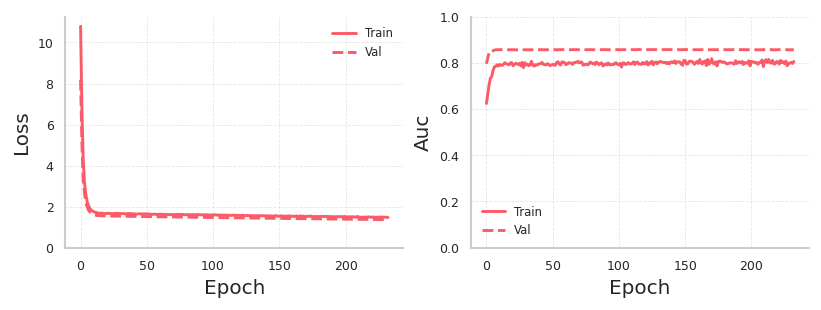

In [265]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [266]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Legitimate Transactions Detected (True Negatives):  81
Legitimate Transactions Incorrectly Detected (False Positives):  35
Fraudulent Transactions Missed (False Negatives):  42
Fraudulent Transactions Detected (True Positives):  201
Total Fraudulent Transactions:  243


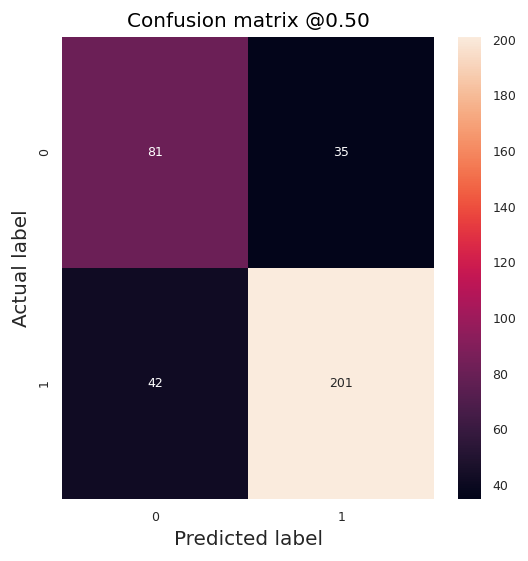

In [267]:
plot_cm(y_valid, valid_predictions_resampled)

Legitimate Transactions Detected (True Negatives):  88
Legitimate Transactions Incorrectly Detected (False Positives):  28
Fraudulent Transactions Missed (False Negatives):  48
Fraudulent Transactions Detected (True Positives):  195
Total Fraudulent Transactions:  243


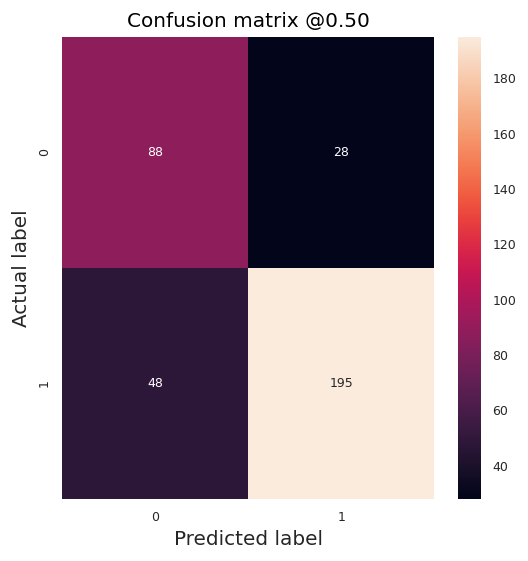

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [269]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_v2_all_data_ext.csv")

### 4.4 CNN Classifier - Tab v0

In [ ]:
def make_model_cnn(metrics=METRICS, filters=64, kernel_size=2, kr=0.01, sdo=0.2,
                   units_dense=256, output_bias=None, gn=0.025, activation="relu",
                   do=0.3, units_tab=[128,128], lr=5e-4):

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_tabular = data[:, 6, :]

  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  # Cnn Layers
  # Layer 0
  cnn_out = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1,
                                kernel_regularizer=keras.regularizers.l2(kr),
                                padding="same", activation=None, name="cnn_0")(data_noised)
  cnn_out = keras.layers.LayerNormalization(name="ln_cnn_0")(cnn_out)
  cnn_out = keras.layers.Activation("relu", name="act_cnn_0")(cnn_out)
  cnn_out = keras.layers.SpatialDropout1D(sdo, name="sdo_cnn_0")(cnn_out)
  cnn_out = keras.layers.MaxPooling1D(pool_size=2, name="max_pool_cnn_1")(cnn_out)
  # Layer 1
  cnn_out = keras.layers.Conv1D(filters=int(filters*2), kernel_size=kernel_size, strides=1,
                                kernel_regularizer=keras.regularizers.l2(kr),
                                padding="same", activation=None, name="cnn_1")(cnn_out)
  cnn_out = keras.layers.LayerNormalization(name="ln_cnn_1")(cnn_out)
  cnn_out = keras.layers.Activation("relu", name="act_cnn_1")(cnn_out)
  cnn_out = keras.layers.SpatialDropout1D(sdo, name="sdo_cnn_1")(cnn_out)

  #outputs
  cnn_out_ave = keras.layers.GlobalAveragePooling1D(name="average_pool_final")(cnn_out)
  cnn_out_max = keras.layers.GlobalMaxPooling1D(name="max_pool_final")(cnn_out)

  x = keras.layers.Concatenate(name="concat")([cnn_out_ave, cnn_out_max])

  # Dense Layer
  x = keras.layers.Dense(units_dense, name="dense_conv_1")(x)
  x = keras.layers.BatchNormalization(name="batch_dense_conv")(x)
  x = keras.layers.Activation(activation, name="act_dense_conv")(x)
  x = keras.layers.Dropout(do, name="do_dense_conv")(x)

  # Tabular Section
  tabx = keras.layers.Dense(units_tab[0], name="dense_0")(data_tabular)
  tabx = keras.layers.BatchNormalization(name="batch_0")(tabx)
  tabx = keras.layers.Activation(activation, name="act_0")(tabx)
  tabx = keras.layers.Dropout(do, name="do_0")(tabx)
  tabx = keras.layers.Dense(units_tab[1], name="dense_1")(tabx)
  tabx = keras.layers.BatchNormalization(name="batch_1")(tabx)
  tabx = keras.layers.Activation(activation, name="act_1")(tabx)
  tabx = keras.layers.Dropout(do, name="do_1")(tabx)

  # Final Concatenation
  x = keras.layers.Concatenate(name="final_concat")([x, tabx])

  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="cnn_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model_cnn(output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

Model: "cnn_v0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 30)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ noise_layer               │ (None, 7, 30)          │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_0 (Conv1D)            │ (None, 7, 64)          │          3,904 │ noise_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln_cnn_0                  │ (None, 7, 64)          │            128 │ cnn_0[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_cnn_0 (Activation)    │ (None, 7, 64)          │              0 │ ln_cnn_0[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sdo_cnn_0                 │ (None, 7, 64)          │              0 │ act_cnn_0[0][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_cnn_1            │ (None, 3, 64)          │              0 │ sdo_cnn_0[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_1 (Conv1D)            │ (None, 3, 128)         │         16,512 │ max_pool_cnn_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln_cnn_1                  │ (None, 3, 128)         │            256 │ cnn_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_420 (GetItem)    │ (None, 30)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_cnn_1 (Activation)    │ (None, 3, 128)         │              0 │ ln_cnn_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_0 (Dense)           │ (None, 128)            │          3,968 │ get_item_420[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sdo_cnn_1                 │ (None, 3, 128)         │              0 │ act_cnn_1[0][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_0                   │ (None, 128)            │            512 │ dense_0[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pool_final        │ (None, 128)            │              0 │ sdo_cnn_1[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_final       

 Total params: 109,505 (427.75 KB)

 Trainable params: 108,481 (423.75 KB)

 Non-trainable params: 1,024 (4.00 KB)

#### Optuna Optimization

In [ ]:
def objective_nn(trial, train_data, validation_data, model=make_model_cnn, use_gpu=False, rs=42, fit_scaling=False,epochs=51):

    model_class = model

    params = {
              'filters': trial.suggest_categorical('filters', [32,64,128]),
              'kernel_size': trial.suggest_categorical('kernel_size', [2,3]),
              'units_dense': trial.suggest_categorical('units_dense', [256, 128, 64]),
              'sdo': trial.suggest_float('sdo', 0.20, 0.45, step=0.01),
              'kr': trial.suggest_float('kr', 0.01, 0.1, step=0.01),
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01),
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model_cnn, n_trials=151, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

[I 2025-03-09 16:16:02,993] A new study created in memory with name: no-name-98512983-6fbe-4b8e-b035-e7d086e64649


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.7867 - cross entropy: 0.5859 - loss: 4.8793 - prc: 0.8051 - val_auc: 0.8809 - val_cross entropy: 0.4101 - val_loss: 2.5080 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8720 - cross entropy: 0.4499 - loss: 2.1369 - prc: 0.8637 - val_auc: 0.8841 - val_cross entropy: 0.4135 - val_loss: 1.2180 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8899 - cross entropy: 0.4199 - loss: 1.0715 - prc: 0.8847 - val_auc: 0.8915 - val_cross entropy: 0.3897 - val_loss: 0.7166 - val_prc: 0.9437 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8936 - cross entropy: 0.4113 - loss: 0.6816 - prc: 0.8956 - val_auc: 0.8947 - val_cross entropy: 0.4060 - val_loss: 0.5554 - val_prc: 0.9456 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8978 - cross entropy: 0.4040 - loss: 0.5

[I 2025-03-09 16:16:21,700] Trial 0 finished with value: 0.8949198240385979 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.38, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.31, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - auc: 0.8251 - cross entropy: 0.6113 - loss: 2.7306 - prc: 0.8270 - val_auc: 0.8824 - val_cross entropy: 0.5952 - val_loss: 2.1181 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8669 - cross entropy: 0.4924 - loss: 1.8716 - prc: 0.8463 - val_auc: 0.8604 - val_cross entropy: 0.4548 - val_loss: 1.4586 - val_prc: 0.9220 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8787 - cross entropy: 0.4602 - loss: 1.3703 - prc: 0.8540 - val_auc: 0.8714 - val_cross entropy: 0.4510 - val_loss: 1.1209 - val_prc: 0.9247 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8848 - cross entropy: 0.4353 - loss: 1.0732 - prc: 0.8658 - val_auc: 0.8807 - val_cross entropy: 0.4721 - val_loss: 1.0191 - val_prc: 0.9341 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8985 - cross entropy: 0.4089 - loss:

[I 2025-03-09 16:16:46,167] Trial 1 finished with value: 0.8809067688378034 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.35, 'kr': 0.01, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.29000000000000004, 'units_tab_0': 256, 'units_tab_1': 64}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.7731 - cross entropy: 0.6003 - loss: 2.6173 - prc: 0.7925 - val_auc: 0.8688 - val_cross entropy: 0.4668 - val_loss: 1.7531 - val_prc: 0.9266 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8659 - cross entropy: 0.4614 - loss: 1.5867 - prc: 0.8529 - val_auc: 0.8794 - val_cross entropy: 0.4319 - val_loss: 1.1625 - val_prc: 0.9349 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8736 - cross entropy: 0.4505 - loss: 1.0917 - prc: 0.8627 - val_auc: 0.8807 - val_cross entropy: 0.4425 - val_loss: 0.8676 - val_prc: 0.9366 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8864 - cross entropy: 0.4291 - loss: 0.8057 - prc: 0.8874 - val_auc: 0.8863 - val_cross entropy: 0.4323 - val_loss: 0.6919 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8955 - cross entropy: 0.4092 - loss: 0.64

[I 2025-03-09 16:17:07,138] Trial 2 finished with value: 0.8887115084433092 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.37, 'kr': 0.03, 'activation': 'relu', 'gn': 0.01, 'do': 0.36, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.8369 - cross entropy: 0.5394 - loss: 5.6171 - prc: 0.8507 - val_auc: 0.8833 - val_cross entropy: 0.4432 - val_loss: 2.6373 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8687 - cross entropy: 0.4660 - loss: 2.1913 - prc: 0.8611 - val_auc: 0.8849 - val_cross entropy: 0.4397 - val_loss: 1.2091 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8820 - cross entropy: 0.4386 - loss: 1.0539 - prc: 0.8705 - val_auc: 0.8842 - val_cross entropy: 0.4163 - val_loss: 0.7157 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8870 - cross entropy: 0.4317 - loss: 0.6798 - prc: 0.8879 - val_auc: 0.8850 - val_cross entropy: 0.4228 - val_loss: 0.5605 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8898 - cross entropy: 0.4223 - loss: 0.5

[I 2025-03-09 16:17:28,744] Trial 3 finished with value: 0.8879665105718746 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.33, 'kr': 0.05, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.38, 'units_tab_0': 64, 'units_tab_1': 128}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8132 - cross entropy: 0.5486 - loss: 6.6584 - prc: 0.8247 - val_auc: 0.8785 - val_cross entropy: 0.4435 - val_loss: 3.1040 - val_prc: 0.9323 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8883 - cross entropy: 0.4230 - loss: 2.5075 - prc: 0.8810 - val_auc: 0.8837 - val_cross entropy: 0.4393 - val_loss: 1.3513 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8880 - cross entropy: 0.4254 - loss: 1.1535 - prc: 0.8815 - val_auc: 0.8855 - val_cross entropy: 0.4033 - val_loss: 0.7547 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9019 - cross entropy: 0.3967 - loss: 0.6863 - prc: 0.9046 - val_auc: 0.8812 - val_cross entropy: 0.4409 - val_loss: 0.6016 - val_prc: 0.9349 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9028 - cross entropy: 0.3940 - loss: 0.5

[I 2025-03-09 16:18:04,389] Trial 4 finished with value: 0.8840996168582377 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.33, 'kr': 0.060000000000000005, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.25, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.7839 - cross entropy: 0.6544 - loss: 7.0707 - prc: 0.7924 - val_auc: 0.8769 - val_cross entropy: 0.4458 - val_loss: 4.0345 - val_prc: 0.9319 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8686 - cross entropy: 0.4855 - loss: 3.4791 - prc: 0.8575 - val_auc: 0.8830 - val_cross entropy: 0.4832 - val_loss: 2.1067 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8798 - cross entropy: 0.4521 - loss: 1.8043 - prc: 0.8679 - val_auc: 0.8780 - val_cross entropy: 0.5517 - val_loss: 1.2951 - val_prc: 0.9291 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8821 - cross entropy: 0.4413 - loss: 1.0664 - prc: 0.8762 - val_auc: 0.8807 - val_cross entropy: 0.5380 - val_loss: 0.8997 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8882 - cross entropy: 0.4272 - loss: 0.76

[I 2025-03-09 16:18:25,116] Trial 5 finished with value: 0.88608627784873 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 128, 'sdo': 0.29000000000000004, 'kr': 0.09999999999999999, 'activation': 'selu', 'gn': 0.02, 'do': 0.33, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc: 0.7421 - cross entropy: 0.6256 - loss: 3.2899 - prc: 0.7403 - val_auc: 0.8585 - val_cross entropy: 0.4386 - val_loss: 2.1333 - val_prc: 0.9095 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8287 - cross entropy: 0.5086 - loss: 1.9862 - prc: 0.7963 - val_auc: 0.8769 - val_cross entropy: 0.4265 - val_loss: 1.3752 - val_prc: 0.9299 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8756 - cross entropy: 0.4450 - loss: 1.2729 - prc: 0.8566 - val_auc: 0.8856 - val_cross entropy: 0.4228 - val_loss: 0.9598 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8659 - cross entropy: 0.4632 - loss: 0.9358 - prc: 0.8546 - val_auc: 0.8877 - val_cross entropy: 0.4250 - val_loss: 0.7424 - val_prc: 0.9401 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8820 - cross entropy: 0.4315 - loss: 0.7

[I 2025-03-09 16:18:45,328] Trial 6 finished with value: 0.8937845891868881 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.38, 'kr': 0.04, 'activation': 'relu', 'gn': 0.05, 'do': 0.45, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.7870 - cross entropy: 0.6513 - loss: 9.5583 - prc: 0.7924 - val_auc: 0.8774 - val_cross entropy: 0.6172 - val_loss: 3.9324 - val_prc: 0.9329 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8764 - cross entropy: 0.4765 - loss: 2.9754 - prc: 0.8635 - val_auc: 0.8833 - val_cross entropy: 0.4854 - val_loss: 1.4426 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8735 - cross entropy: 0.4692 - loss: 1.2152 - prc: 0.8607 - val_auc: 0.8885 - val_cross entropy: 0.4461 - val_loss: 0.7843 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8910 - cross entropy: 0.4219 - loss: 0.6999 - prc: 0.8898 - val_auc: 0.8854 - val_cross entropy: 0.4889 - val_loss: 0.6425 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8920 - cross entropy: 0.4167 - loss: 0.5

[I 2025-03-09 16:19:07,582] Trial 7 finished with value: 0.8882148431956861 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.32, 'kr': 0.09, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.23, 'units_tab_0': 64, 'units_tab_1': 64}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.7644 - cross entropy: 0.6195 - loss: 4.3933 - prc: 0.7817 - val_auc: 0.8676 - val_cross entropy: 0.6244 - val_loss: 2.6074 - val_prc: 0.9260 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8719 - cross entropy: 0.4499 - loss: 2.0925 - prc: 0.8657 - val_auc: 0.8646 - val_cross entropy: 0.4719 - val_loss: 1.3793 - val_prc: 0.9239 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8855 - cross entropy: 0.4288 - loss: 1.2021 - prc: 0.8758 - val_auc: 0.8814 - val_cross entropy: 0.4502 - val_loss: 0.9268 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9063 - cross entropy: 0.3877 - loss: 0.8065 - prc: 0.9077 - val_auc: 0.8721 - val_cross entropy: 0.4556 - val_loss: 0.7401 - val_prc: 0.9280 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9082 - cross entropy: 0.3846 - loss: 0.6

[I 2025-03-09 16:19:34,820] Trial 8 finished with value: 0.8813679579963104 and parameters: {'filters': 128, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.02, 'activation': 'gelu', 'gn': 0.09, 'do': 0.25, 'units_tab_0': 64, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.8042 - cross entropy: 0.6632 - loss: 5.1705 - prc: 0.8125 - val_auc: 0.8824 - val_cross entropy: 0.4427 - val_loss: 2.9751 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8650 - cross entropy: 0.5123 - loss: 2.6318 - prc: 0.8518 - val_auc: 0.8833 - val_cross entropy: 0.4658 - val_loss: 1.6414 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8805 - cross entropy: 0.4610 - loss: 1.4511 - prc: 0.8675 - val_auc: 0.8861 - val_cross entropy: 0.5014 - val_loss: 1.0720 - val_prc: 0.9400 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8665 - cross entropy: 0.4767 - loss: 0.9655 - prc: 0.8581 - val_auc: 0.8879 - val_cross entropy: 0.4502 - val_loss: 0.7515 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8742 - cross entropy: 0.4594 - loss: 0.7

[I 2025-03-09 16:19:56,472] Trial 9 finished with value: 0.8885341279977295 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.28, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.37, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8372 - cross entropy: 0.5125 - loss: 5.3106 - prc: 0.8535 - val_auc: 0.8817 - val_cross entropy: 0.4002 - val_loss: 2.6132 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8848 - cross entropy: 0.4293 - loss: 2.1808 - prc: 0.8702 - val_auc: 0.8845 - val_cross entropy: 0.4060 - val_loss: 1.1923 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8913 - cross entropy: 0.4180 - loss: 1.0460 - prc: 0.8810 - val_auc: 0.8864 - val_cross entropy: 0.4232 - val_loss: 0.7243 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9041 - cross entropy: 0.3931 - loss: 0.6399 - prc: 0.9036 - val_auc: 0.8901 - val_cross entropy: 0.3942 - val_loss: 0.5255 - val_prc: 0.9428 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9047 - cross entropy: 0.3914 - loss: 0.5

[I 2025-03-09 16:20:21,666] Trial 10 finished with value: 0.8902015041861785 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.45, 'kr': 0.08, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.7533 - cross entropy: 0.6024 - loss: 3.2669 - prc: 0.7644 - val_auc: 0.8635 - val_cross entropy: 0.4392 - val_loss: 2.0898 - val_prc: 0.9170 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8399 - cross entropy: 0.4940 - loss: 1.9212 - prc: 0.8109 - val_auc: 0.8725 - val_cross entropy: 0.4363 - val_loss: 1.3254 - val_prc: 0.9279 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8778 - cross entropy: 0.4380 - loss: 1.2090 - prc: 0.8558 - val_auc: 0.8792 - val_cross entropy: 0.4721 - val_loss: 0.9638 - val_prc: 0.9349 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8866 - cross entropy: 0.4252 - loss: 0.8569 - prc: 0.8732 - val_auc: 0.8939 - val_cross entropy: 0.4192 - val_loss: 0.7075 - val_prc: 0.9456 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8710 - cross entropy: 0.4578 - loss: 0.7

[I 2025-03-09 16:20:44,227] Trial 11 finished with value: 0.8936781609195402 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.41000000000000003, 'kr': 0.04, 'activation': 'relu', 'gn': 0.04, 'do': 0.41000000000000003, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7418 - cross entropy: 0.6133 - loss: 3.8926 - prc: 0.7585 - val_auc: 0.8483 - val_cross entropy: 0.4596 - val_loss: 2.4072 - val_prc: 0.8971 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8382 - cross entropy: 0.4936 - loss: 2.1565 - prc: 0.8036 - val_auc: 0.8673 - val_cross entropy: 0.4244 - val_loss: 1.4175 - val_prc: 0.9196 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8668 - cross entropy: 0.4560 - loss: 1.3076 - prc: 0.8353 - val_auc: 0.8899 - val_cross entropy: 0.4103 - val_loss: 0.9338 - val_prc: 0.9443 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8731 - cross entropy: 0.4509 - loss: 0.9059 - prc: 0.8569 - val_auc: 0.8890 - val_cross entropy: 0.4078 - val_loss: 0.7015 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8921 - cross entropy: 0.4137 - loss: 0.6

[I 2025-03-09 16:21:07,255] Trial 12 finished with value: 0.8923655456222506 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.39, 'kr': 0.05, 'activation': 'relu', 'gn': 0.04, 'do': 0.45, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7850 - cross entropy: 0.5641 - loss: 4.9204 - prc: 0.7917 - val_auc: 0.8588 - val_cross entropy: 0.4237 - val_loss: 2.6496 - val_prc: 0.9069 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8449 - cross entropy: 0.4868 - loss: 2.3025 - prc: 0.8238 - val_auc: 0.8800 - val_cross entropy: 0.4047 - val_loss: 1.3198 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8704 - cross entropy: 0.4566 - loss: 1.2086 - prc: 0.8533 - val_auc: 0.8802 - val_cross entropy: 0.4394 - val_loss: 0.8407 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8934 - cross entropy: 0.4147 - loss: 0.7521 - prc: 0.8984 - val_auc: 0.8855 - val_cross entropy: 0.4149 - val_loss: 0.6098 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8927 - cross entropy: 0.4146 - loss: 0.5

[I 2025-03-09 16:21:31,122] Trial 13 finished with value: 0.8855896126011069 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.43000000000000005, 'kr': 0.06999999999999999, 'activation': 'gelu', 'gn': 0.06999999999999999, 'do': 0.30000000000000004, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.7689 - cross entropy: 0.6032 - loss: 3.2676 - prc: 0.7870 - val_auc: 0.8673 - val_cross entropy: 0.4710 - val_loss: 2.1372 - val_prc: 0.9223 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8433 - cross entropy: 0.4909 - loss: 1.9359 - prc: 0.8257 - val_auc: 0.8821 - val_cross entropy: 0.4206 - val_loss: 1.3309 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8888 - cross entropy: 0.4226 - loss: 1.2138 - prc: 0.8803 - val_auc: 0.8813 - val_cross entropy: 0.4492 - val_loss: 0.9566 - val_prc: 0.9336 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8823 - cross entropy: 0.4349 - loss: 0.8805 - prc: 0.8808 - val_auc: 0.8794 - val_cross entropy: 0.5146 - val_loss: 0.8132 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8980 - cross entropy: 0.4063 - loss: 0.6

[I 2025-03-09 16:21:56,303] Trial 14 finished with value: 0.8894919824038598 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.2, 'kr': 0.04, 'activation': 'silu', 'gn': 0.04, 'do': 0.44, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8127 - cross entropy: 0.5719 - loss: 9.7923 - prc: 0.8315 - val_auc: 0.8746 - val_cross entropy: 0.8794 - val_loss: 2.9510 - val_prc: 0.9331 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8713 - cross entropy: 0.4601 - loss: 1.8868 - prc: 0.8559 - val_auc: 0.8658 - val_cross entropy: 0.4884 - val_loss: 0.8992 - val_prc: 0.9212 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8904 - cross entropy: 0.4206 - loss: 0.7342 - prc: 0.8768 - val_auc: 0.8801 - val_cross entropy: 0.4749 - val_loss: 0.6259 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8899 - cross entropy: 0.4243 - loss: 0.5543 - prc: 0.8882 - val_auc: 0.8894 - val_cross entropy: 0.4367 - val_loss: 0.5277 - val_prc: 0.9427 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9008 - cross entropy: 0.3985 - loss: 0.4

[I 2025-03-09 16:22:26,280] Trial 15 finished with value: 0.8893146019582802 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.39, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.08, 'do': 0.33, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.7851 - cross entropy: 0.5731 - loss: 5.4830 - prc: 0.7994 - val_auc: 0.8712 - val_cross entropy: 0.4082 - val_loss: 2.8041 - val_prc: 0.9224 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8618 - cross entropy: 0.4586 - loss: 2.3830 - prc: 0.8368 - val_auc: 0.8769 - val_cross entropy: 0.4225 - val_loss: 1.3368 - val_prc: 0.9290 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9008 - cross entropy: 0.3982 - loss: 1.1375 - prc: 0.8903 - val_auc: 0.8780 - val_cross entropy: 0.4218 - val_loss: 0.7911 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8859 - cross entropy: 0.4295 - loss: 0.7362 - prc: 0.8844 - val_auc: 0.8916 - val_cross entropy: 0.3899 - val_loss: 0.5640 - val_prc: 0.9440 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8962 - cross entropy: 0.4064 - loss: 0.5

[I 2025-03-09 16:22:48,880] Trial 16 finished with value: 0.8917269760181638 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.37, 'kr': 0.08, 'activation': 'silu', 'gn': 0.05, 'do': 0.30000000000000004, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7528 - cross entropy: 0.6045 - loss: 2.6614 - prc: 0.7685 - val_auc: 0.8573 - val_cross entropy: 0.4485 - val_loss: 1.8228 - val_prc: 0.9009 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8414 - cross entropy: 0.4880 - loss: 1.7066 - prc: 0.8059 - val_auc: 0.8780 - val_cross entropy: 0.4213 - val_loss: 1.2498 - val_prc: 0.9287 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8739 - cross entropy: 0.4493 - loss: 1.1853 - prc: 0.8457 - val_auc: 0.8902 - val_cross entropy: 0.4157 - val_loss: 0.9237 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8771 - cross entropy: 0.4465 - loss: 0.9019 - prc: 0.8691 - val_auc: 0.8919 - val_cross entropy: 0.4074 - val_loss: 0.7304 - val_prc: 0.9435 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8962 - cross entropy: 0.4088 - loss: 0.6

[I 2025-03-09 16:23:10,850] Trial 17 finished with value: 0.8917269760181636 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.42000000000000004, 'kr': 0.03, 'activation': 'relu', 'gn': 0.03, 'do': 0.41000000000000003, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.8097 - cross entropy: 0.5698 - loss: 4.7580 - prc: 0.8135 - val_auc: 0.8848 - val_cross entropy: 0.5323 - val_loss: 2.4749 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8748 - cross entropy: 0.4526 - loss: 2.0079 - prc: 0.8592 - val_auc: 0.8803 - val_cross entropy: 0.4587 - val_loss: 1.2021 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8830 - cross entropy: 0.4335 - loss: 1.0402 - prc: 0.8714 - val_auc: 0.8863 - val_cross entropy: 0.4750 - val_loss: 0.7914 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8947 - cross entropy: 0.4134 - loss: 0.6795 - prc: 0.8992 - val_auc: 0.8833 - val_cross entropy: 0.4799 - val_loss: 0.6375 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9102 - cross entropy: 0.3799 - loss: 0.5

[I 2025-03-09 16:23:37,611] Trial 18 finished with value: 0.8885341279977296 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.29000000000000004, 'kr': 0.04, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.35, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.7693 - cross entropy: 0.6331 - loss: 11.3975 - prc: 0.7929 - val_auc: 0.8684 - val_cross entropy: 0.5151 - val_loss: 3.0708 - val_prc: 0.9204 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8797 - cross entropy: 0.4384 - loss: 2.2201 - prc: 0.8668 - val_auc: 0.8872 - val_cross entropy: 0.3850 - val_loss: 0.9387 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8777 - cross entropy: 0.4413 - loss: 0.8677 - prc: 0.8595 - val_auc: 0.8695 - val_cross entropy: 0.5202 - val_loss: 0.7120 - val_prc: 0.9292 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8817 - cross entropy: 0.4360 - loss: 0.6020 - prc: 0.8787 - val_auc: 0.8840 - val_cross entropy: 0.4218 - val_loss: 0.5450 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8942 - cross entropy: 0.4141 - loss: 0.

[I 2025-03-09 16:24:09,972] Trial 19 finished with value: 0.8906626933446856 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.36, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.08, 'do': 0.28, 'units_tab_0': 64, 'units_tab_1': 64}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7688 - cross entropy: 0.6007 - loss: 6.6847 - prc: 0.7930 - val_auc: 0.8717 - val_cross entropy: 0.4278 - val_loss: 3.3288 - val_prc: 0.9269 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8662 - cross entropy: 0.4615 - loss: 2.7765 - prc: 0.8537 - val_auc: 0.8804 - val_cross entropy: 0.4152 - val_loss: 1.4809 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8750 - cross entropy: 0.4473 - loss: 1.3007 - prc: 0.8509 - val_auc: 0.8833 - val_cross entropy: 0.4063 - val_loss: 0.8166 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8832 - cross entropy: 0.4350 - loss: 0.7715 - prc: 0.8804 - val_auc: 0.8816 - val_cross entropy: 0.4242 - val_loss: 0.6052 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9026 - cross entropy: 0.4009 - loss: 0.5

[I 2025-03-09 16:24:31,672] Trial 20 finished with value: 0.8845608060167447 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.45, 'kr': 0.09999999999999999, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.4, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.7594 - cross entropy: 0.5937 - loss: 3.2584 - prc: 0.7728 - val_auc: 0.8697 - val_cross entropy: 0.4405 - val_loss: 2.1039 - val_prc: 0.9164 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8371 - cross entropy: 0.4966 - loss: 1.9388 - prc: 0.8022 - val_auc: 0.8675 - val_cross entropy: 0.4275 - val_loss: 1.3341 - val_prc: 0.9194 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8679 - cross entropy: 0.4537 - loss: 1.2419 - prc: 0.8412 - val_auc: 0.8794 - val_cross entropy: 0.4435 - val_loss: 0.9499 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8839 - cross entropy: 0.4268 - loss: 0.8718 - prc: 0.8730 - val_auc: 0.8880 - val_cross entropy: 0.4474 - val_loss: 0.7452 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8841 - cross entropy: 0.4306 - loss: 0.6

[I 2025-03-09 16:24:54,430] Trial 21 finished with value: 0.8901660280970627 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.4, 'kr': 0.04, 'activation': 'relu', 'gn': 0.04, 'do': 0.42000000000000004, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7449 - cross entropy: 0.6151 - loss: 2.6866 - prc: 0.7539 - val_auc: 0.8752 - val_cross entropy: 0.4647 - val_loss: 1.8548 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8278 - cross entropy: 0.5061 - loss: 1.7428 - prc: 0.7913 - val_auc: 0.8807 - val_cross entropy: 0.4244 - val_loss: 1.2750 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8578 - cross entropy: 0.4762 - loss: 1.2341 - prc: 0.8316 - val_auc: 0.8816 - val_cross entropy: 0.4240 - val_loss: 0.9506 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8814 - cross entropy: 0.4409 - loss: 0.9129 - prc: 0.8778 - val_auc: 0.8892 - val_cross entropy: 0.4115 - val_loss: 0.7477 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8902 - cross entropy: 0.4176 - loss: 0.7

[I 2025-03-09 16:25:17,057] Trial 22 finished with value: 0.8892791258691642 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.42000000000000004, 'kr': 0.03, 'activation': 'relu', 'gn': 0.05, 'do': 0.43000000000000005, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.7611 - cross entropy: 0.5907 - loss: 3.8313 - prc: 0.7722 - val_auc: 0.8643 - val_cross entropy: 0.4865 - val_loss: 2.3757 - val_prc: 0.9137 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8443 - cross entropy: 0.4859 - loss: 2.0895 - prc: 0.8156 - val_auc: 0.8710 - val_cross entropy: 0.4339 - val_loss: 1.3716 - val_prc: 0.9232 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8608 - cross entropy: 0.4642 - loss: 1.2650 - prc: 0.8316 - val_auc: 0.8780 - val_cross entropy: 0.4359 - val_loss: 0.9228 - val_prc: 0.9295 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8893 - cross entropy: 0.4199 - loss: 0.8417 - prc: 0.8828 - val_auc: 0.8892 - val_cross entropy: 0.4067 - val_loss: 0.6760 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8810 - cross entropy: 0.4378 - loss: 0.6

[I 2025-03-09 16:25:39,728] Trial 23 finished with value: 0.893252447850149 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.4, 'kr': 0.05, 'activation': 'relu', 'gn': 0.03, 'do': 0.39, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7417 - cross entropy: 0.6227 - loss: 2.0741 - prc: 0.7507 - val_auc: 0.8589 - val_cross entropy: 0.4564 - val_loss: 1.5305 - val_prc: 0.9013 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8327 - cross entropy: 0.5022 - loss: 1.4909 - prc: 0.7984 - val_auc: 0.8704 - val_cross entropy: 0.4597 - val_loss: 1.2199 - val_prc: 0.9229 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8737 - cross entropy: 0.4418 - loss: 1.1407 - prc: 0.8529 - val_auc: 0.8832 - val_cross entropy: 0.4498 - val_loss: 0.9868 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8833 - cross entropy: 0.4334 - loss: 0.9285 - prc: 0.8781 - val_auc: 0.8880 - val_cross entropy: 0.4380 - val_loss: 0.8224 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8832 - cross entropy: 0.4311 - loss: 0.7

[I 2025-03-09 16:26:02,716] Trial 24 finished with value: 0.8914076912161204 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.38, 'kr': 0.02, 'activation': 'relu', 'gn': 0.03, 'do': 0.45, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.7696 - cross entropy: 0.5847 - loss: 4.3891 - prc: 0.7794 - val_auc: 0.8693 - val_cross entropy: 0.4370 - val_loss: 2.5259 - val_prc: 0.9170 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8615 - cross entropy: 0.4596 - loss: 2.1973 - prc: 0.8304 - val_auc: 0.8771 - val_cross entropy: 0.4277 - val_loss: 1.3714 - val_prc: 0.9280 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8766 - cross entropy: 0.4392 - loss: 1.2295 - prc: 0.8598 - val_auc: 0.8885 - val_cross entropy: 0.4158 - val_loss: 0.8660 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8953 - cross entropy: 0.4125 - loss: 0.7968 - prc: 0.8893 - val_auc: 0.8893 - val_cross entropy: 0.4051 - val_loss: 0.6384 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8820 - cross entropy: 0.4348 - loss: 0.6

[I 2025-03-09 16:26:25,028] Trial 25 finished with value: 0.8891372215127004 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.42000000000000004, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.05, 'do': 0.35, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7773 - cross entropy: 0.5864 - loss: 3.2498 - prc: 0.7963 - val_auc: 0.8747 - val_cross entropy: 0.4223 - val_loss: 2.0876 - val_prc: 0.9242 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8608 - cross entropy: 0.4640 - loss: 1.9090 - prc: 0.8388 - val_auc: 0.8876 - val_cross entropy: 0.4054 - val_loss: 1.3174 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8770 - cross entropy: 0.4383 - loss: 1.2313 - prc: 0.8603 - val_auc: 0.8880 - val_cross entropy: 0.4006 - val_loss: 0.9093 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8803 - cross entropy: 0.4353 - loss: 0.8822 - prc: 0.8753 - val_auc: 0.8876 - val_cross entropy: 0.4380 - val_loss: 0.7355 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8853 - cross entropy: 0.4248 - loss: 0.6

[I 2025-03-09 16:26:48,799] Trial 26 finished with value: 0.890520788988222 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.35, 'kr': 0.04, 'activation': 'silu', 'gn': 0.02, 'do': 0.42000000000000004, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - auc: 0.7692 - cross entropy: 0.5831 - loss: 5.5521 - prc: 0.7813 - val_auc: 0.8682 - val_cross entropy: 0.4286 - val_loss: 2.9412 - val_prc: 0.9153 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8635 - cross entropy: 0.4555 - loss: 2.4943 - prc: 0.8416 - val_auc: 0.8855 - val_cross entropy: 0.4060 - val_loss: 1.4107 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8849 - cross entropy: 0.4265 - loss: 1.2458 - prc: 0.8639 - val_auc: 0.8897 - val_cross entropy: 0.3943 - val_loss: 0.8196 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8958 - cross entropy: 0.4071 - loss: 0.7629 - prc: 0.8912 - val_auc: 0.8908 - val_cross entropy: 0.3967 - val_loss: 0.5996 - val_prc: 0.9433 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8917 - cross entropy: 0.4145 - loss: 0.

[I 2025-03-09 16:27:36,283] Trial 27 finished with value: 0.8908400737902653 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.32, 'kr': 0.08, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.32, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - auc: 0.8013 - cross entropy: 0.5714 - loss: 4.2761 - prc: 0.8086 - val_auc: 0.8734 - val_cross entropy: 0.5191 - val_loss: 2.3294 - val_prc: 0.9319 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8751 - cross entropy: 0.4559 - loss: 1.9322 - prc: 0.8672 - val_auc: 0.8852 - val_cross entropy: 0.4053 - val_loss: 1.1689 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8752 - cross entropy: 0.4522 - loss: 1.0920 - prc: 0.8541 - val_auc: 0.8808 - val_cross entropy: 0.4176 - val_loss: 0.7863 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8828 - cross entropy: 0.4402 - loss: 0.7581 - prc: 0.8793 - val_auc: 0.8857 - val_cross entropy: 0.5086 - val_loss: 0.7169 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8891 - cross entropy: 0.4268 - loss: 0.6

[I 2025-03-09 16:28:10,824] Trial 28 finished with value: 0.8892436497800482 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.41000000000000003, 'kr': 0.02, 'activation': 'relu', 'gn': 0.08, 'do': 0.4, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.7915 - cross entropy: 0.6675 - loss: 5.9193 - prc: 0.7967 - val_auc: 0.8834 - val_cross entropy: 0.4831 - val_loss: 2.8835 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8679 - cross entropy: 0.5027 - loss: 2.4152 - prc: 0.8540 - val_auc: 0.8771 - val_cross entropy: 0.5627 - val_loss: 1.4778 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8730 - cross entropy: 0.4704 - loss: 1.2211 - prc: 0.8536 - val_auc: 0.8878 - val_cross entropy: 0.4379 - val_loss: 0.8363 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8754 - cross entropy: 0.4538 - loss: 0.7898 - prc: 0.8707 - val_auc: 0.8885 - val_cross entropy: 0.4667 - val_loss: 0.6643 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8772 - cross entropy: 0.4495 - loss: 0.6

[I 2025-03-09 16:28:37,933] Trial 29 finished with value: 0.8912303107705406 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.44, 'kr': 0.05, 'activation': 'selu', 'gn': 0.04, 'do': 0.27, 'units_tab_0': 64, 'units_tab_1': 64}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - auc: 0.7948 - cross entropy: 0.6017 - loss: 2.6300 - prc: 0.8101 - val_auc: 0.8713 - val_cross entropy: 0.5598 - val_loss: 1.8546 - val_prc: 0.9257 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8796 - cross entropy: 0.4404 - loss: 1.5735 - prc: 0.8638 - val_auc: 0.8801 - val_cross entropy: 0.4091 - val_loss: 1.1532 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8986 - cross entropy: 0.4062 - loss: 1.0645 - prc: 0.8907 - val_auc: 0.8828 - val_cross entropy: 0.4558 - val_loss: 0.9090 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9013 - cross entropy: 0.3990 - loss: 0.8064 - prc: 0.9048 - val_auc: 0.8668 - val_cross entropy: 0.4711 - val_loss: 0.7661 - val_prc: 0.9250 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9052 - cross entropy: 0.3932 - loss: 0.6

[I 2025-03-09 16:29:12,078] Trial 30 finished with value: 0.8907336455229177 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.35, 'kr': 0.01, 'activation': 'silu', 'gn': 0.09, 'do': 0.31, 'units_tab_0': 256, 'units_tab_1': 64}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7450 - cross entropy: 0.6343 - loss: 3.8771 - prc: 0.7663 - val_auc: 0.8707 - val_cross entropy: 0.4664 - val_loss: 2.3714 - val_prc: 0.9173 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8480 - cross entropy: 0.4818 - loss: 2.0965 - prc: 0.8172 - val_auc: 0.8826 - val_cross entropy: 0.4511 - val_loss: 1.3894 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8668 - cross entropy: 0.4634 - loss: 1.2627 - prc: 0.8386 - val_auc: 0.8821 - val_cross entropy: 0.4340 - val_loss: 0.9139 - val_prc: 0.9349 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8952 - cross entropy: 0.4115 - loss: 0.8268 - prc: 0.8884 - val_auc: 0.8858 - val_cross entropy: 0.4325 - val_loss: 0.6972 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8937 - cross entropy: 0.4134 - loss: 0.6

[I 2025-03-09 16:29:38,968] Trial 31 finished with value: 0.8917979281963956 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.4, 'kr': 0.05, 'activation': 'relu', 'gn': 0.03, 'do': 0.39, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7425 - cross entropy: 0.6176 - loss: 4.4682 - prc: 0.7550 - val_auc: 0.8584 - val_cross entropy: 0.4502 - val_loss: 2.6408 - val_prc: 0.9062 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8298 - cross entropy: 0.5078 - loss: 2.3497 - prc: 0.8013 - val_auc: 0.8761 - val_cross entropy: 0.4370 - val_loss: 1.4743 - val_prc: 0.9305 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8684 - cross entropy: 0.4547 - loss: 1.3309 - prc: 0.8458 - val_auc: 0.8799 - val_cross entropy: 0.4627 - val_loss: 0.9735 - val_prc: 0.9329 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8852 - cross entropy: 0.4279 - loss: 0.8658 - prc: 0.8719 - val_auc: 0.8849 - val_cross entropy: 0.4349 - val_loss: 0.7043 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8781 - cross entropy: 0.4394 - loss: 0.6

[I 2025-03-09 16:30:08,922] Trial 32 finished with value: 0.8890662693344685 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.38, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.02, 'do': 0.43000000000000005, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - auc: 0.7699 - cross entropy: 0.5844 - loss: 3.2284 - prc: 0.7737 - val_auc: 0.8601 - val_cross entropy: 0.4532 - val_loss: 2.0975 - val_prc: 0.9009 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8455 - cross entropy: 0.4870 - loss: 1.9114 - prc: 0.8188 - val_auc: 0.8719 - val_cross entropy: 0.4160 - val_loss: 1.3091 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8789 - cross entropy: 0.4361 - loss: 1.2114 - prc: 0.8511 - val_auc: 0.8831 - val_cross entropy: 0.4335 - val_loss: 0.9295 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8814 - cross entropy: 0.4355 - loss: 0.8713 - prc: 0.8728 - val_auc: 0.8852 - val_cross entropy: 0.4457 - val_loss: 0.7383 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8883 - cross entropy: 0.4270 - loss: 0.6

[I 2025-03-09 16:30:39,810] Trial 33 finished with value: 0.8884276997303817 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.36, 'kr': 0.04, 'activation': 'relu', 'gn': 0.03, 'do': 0.38, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.7568 - cross entropy: 0.5960 - loss: 2.6502 - prc: 0.7763 - val_auc: 0.8663 - val_cross entropy: 0.4592 - val_loss: 1.8436 - val_prc: 0.9099 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8406 - cross entropy: 0.4962 - loss: 1.7262 - prc: 0.8133 - val_auc: 0.8725 - val_cross entropy: 0.4161 - val_loss: 1.2568 - val_prc: 0.9239 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8703 - cross entropy: 0.4543 - loss: 1.2015 - prc: 0.8451 - val_auc: 0.8865 - val_cross entropy: 0.3987 - val_loss: 0.9145 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8792 - cross entropy: 0.4376 - loss: 0.8987 - prc: 0.8717 - val_auc: 0.8870 - val_cross entropy: 0.4158 - val_loss: 0.7411 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8846 - cross entropy: 0.4277 - loss: 0.7

[I 2025-03-09 16:31:07,441] Trial 34 finished with value: 0.8906626933446857 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.4, 'kr': 0.03, 'activation': 'relu', 'gn': 0.01, 'do': 0.41000000000000003, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.7732 - cross entropy: 0.5800 - loss: 3.8388 - prc: 0.7961 - val_auc: 0.8721 - val_cross entropy: 0.4278 - val_loss: 2.3636 - val_prc: 0.9257 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8750 - cross entropy: 0.4447 - loss: 2.0944 - prc: 0.8622 - val_auc: 0.8801 - val_cross entropy: 0.4162 - val_loss: 1.3895 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8839 - cross entropy: 0.4315 - loss: 1.2608 - prc: 0.8663 - val_auc: 0.8793 - val_cross entropy: 0.4285 - val_loss: 0.9222 - val_prc: 0.9331 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8911 - cross entropy: 0.4184 - loss: 0.8429 - prc: 0.8903 - val_auc: 0.8819 - val_cross entropy: 0.4398 - val_loss: 0.7028 - val_prc: 0.9355 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8857 - cross entropy: 0.4285 - loss: 0.6

[I 2025-03-09 16:31:35,172] Trial 35 finished with value: 0.8842415212147013 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.38, 'kr': 0.05, 'activation': 'relu', 'gn': 0.05, 'do': 0.36, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.7919 - cross entropy: 0.6038 - loss: 7.4731 - prc: 0.8021 - val_auc: 0.8772 - val_cross entropy: 0.4691 - val_loss: 2.9508 - val_prc: 0.9321 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8829 - cross entropy: 0.4324 - loss: 2.2982 - prc: 0.8711 - val_auc: 0.8848 - val_cross entropy: 0.4802 - val_loss: 1.2009 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8824 - cross entropy: 0.4328 - loss: 0.9997 - prc: 0.8750 - val_auc: 0.8984 - val_cross entropy: 0.4287 - val_loss: 0.6967 - val_prc: 0.9487 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8910 - cross entropy: 0.4201 - loss: 0.6424 - prc: 0.8976 - val_auc: 0.8886 - val_cross entropy: 0.4083 - val_loss: 0.5402 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9040 - cross entropy: 0.3938 - loss: 0.5

[I 2025-03-09 16:32:04,482] Trial 36 finished with value: 0.8931105434936852 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.34, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.01, 'do': 0.34, 'units_tab_0': 256, 'units_tab_1': 64}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - auc: 0.7300 - cross entropy: 0.7346 - loss: 4.1552 - prc: 0.7527 - val_auc: 0.8807 - val_cross entropy: 0.4740 - val_loss: 2.7130 - val_prc: 0.9303 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8396 - cross entropy: 0.5180 - loss: 2.4841 - prc: 0.8181 - val_auc: 0.8824 - val_cross entropy: 0.6442 - val_loss: 1.9285 - val_prc: 0.9337 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8591 - cross entropy: 0.4954 - loss: 1.6220 - prc: 0.8303 - val_auc: 0.8844 - val_cross entropy: 0.5902 - val_loss: 1.3331 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8544 - cross entropy: 0.4977 - loss: 1.1543 - prc: 0.8394 - val_auc: 0.8772 - val_cross entropy: 0.6089 - val_loss: 1.0552 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8713 - cross entropy: 0.4647 - loss: 0.8

[I 2025-03-09 16:32:33,335] Trial 37 finished with value: 0.8903434085426423 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.43000000000000005, 'kr': 0.05, 'activation': 'selu', 'gn': 0.04, 'do': 0.39, 'units_tab_0': 64, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.7374 - cross entropy: 0.6204 - loss: 6.1494 - prc: 0.7613 - val_auc: 0.8641 - val_cross entropy: 0.4743 - val_loss: 3.2166 - val_prc: 0.9251 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8524 - cross entropy: 0.4809 - loss: 2.6933 - prc: 0.8254 - val_auc: 0.8806 - val_cross entropy: 0.4246 - val_loss: 1.4915 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8719 - cross entropy: 0.4489 - loss: 1.3137 - prc: 0.8527 - val_auc: 0.8905 - val_cross entropy: 0.4410 - val_loss: 0.8745 - val_prc: 0.9431 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8819 - cross entropy: 0.4378 - loss: 0.7961 - prc: 0.8705 - val_auc: 0.8895 - val_cross entropy: 0.4655 - val_loss: 0.6629 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8796 - cross entropy: 0.4380 - loss: 0.6

[I 2025-03-09 16:32:56,810] Trial 38 finished with value: 0.8947424435930184 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.31, 'kr': 0.09, 'activation': 'relu', 'gn': 0.02, 'do': 0.37, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.8123 - cross entropy: 0.5507 - loss: 9.1409 - prc: 0.8239 - val_auc: 0.8831 - val_cross entropy: 0.5524 - val_loss: 3.3649 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8748 - cross entropy: 0.4558 - loss: 2.5202 - prc: 0.8639 - val_auc: 0.8832 - val_cross entropy: 0.4975 - val_loss: 1.2105 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8842 - cross entropy: 0.4362 - loss: 0.9792 - prc: 0.8692 - val_auc: 0.8848 - val_cross entropy: 0.4788 - val_loss: 0.7066 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8983 - cross entropy: 0.4043 - loss: 0.5897 - prc: 0.8883 - val_auc: 0.8845 - val_cross entropy: 0.4530 - val_loss: 0.5573 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.9015 - cross entropy: 0.3976 - loss: 0.4

[I 2025-03-09 16:33:24,279] Trial 39 finished with value: 0.8880019866609905 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.30000000000000004, 'kr': 0.09, 'activation': 'relu', 'gn': 0.02, 'do': 0.37, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.7622 - cross entropy: 0.6134 - loss: 6.2961 - prc: 0.7907 - val_auc: 0.8658 - val_cross entropy: 0.4407 - val_loss: 3.5350 - val_prc: 0.9208 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8544 - cross entropy: 0.4789 - loss: 3.0462 - prc: 0.8365 - val_auc: 0.8794 - val_cross entropy: 0.4410 - val_loss: 1.8055 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8686 - cross entropy: 0.4550 - loss: 1.5833 - prc: 0.8537 - val_auc: 0.8826 - val_cross entropy: 0.4426 - val_loss: 1.0447 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8851 - cross entropy: 0.4301 - loss: 0.9322 - prc: 0.8787 - val_auc: 0.8844 - val_cross entropy: 0.4311 - val_loss: 0.7112 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8917 - cross entropy: 0.4170 - loss: 0.6

[I 2025-03-09 16:33:49,186] Trial 40 finished with value: 0.8900241237405989 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.09, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.44, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.7427 - cross entropy: 0.6157 - loss: 6.7383 - prc: 0.7654 - val_auc: 0.8612 - val_cross entropy: 0.4923 - val_loss: 3.4626 - val_prc: 0.9173 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8514 - cross entropy: 0.4816 - loss: 2.8612 - prc: 0.8275 - val_auc: 0.8871 - val_cross entropy: 0.4253 - val_loss: 1.5387 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8618 - cross entropy: 0.4696 - loss: 1.3655 - prc: 0.8409 - val_auc: 0.8862 - val_cross entropy: 0.4378 - val_loss: 0.8757 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8828 - cross entropy: 0.4329 - loss: 0.7936 - prc: 0.8728 - val_auc: 0.8782 - val_cross entropy: 0.4922 - val_loss: 0.6886 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8796 - cross entropy: 0.4380 - loss: 0.6

[I 2025-03-09 16:34:17,580] Trial 41 finished with value: 0.8858379452249184 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.31, 'kr': 0.09999999999999999, 'activation': 'relu', 'gn': 0.03, 'do': 0.38, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 0 with value: 0.8949198240385979.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7405 - cross entropy: 0.6135 - loss: 5.6069 - prc: 0.7651 - val_auc: 0.8569 - val_cross entropy: 0.4904 - val_loss: 3.0737 - val_prc: 0.9156 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8357 - cross entropy: 0.4999 - loss: 2.6123 - prc: 0.8160 - val_auc: 0.8766 - val_cross entropy: 0.4423 - val_loss: 1.5096 - val_prc: 0.9320 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8617 - cross entropy: 0.4707 - loss: 1.3462 - prc: 0.8490 - val_auc: 0.8887 - val_cross entropy: 0.4307 - val_loss: 0.8924 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8706 - cross entropy: 0.4590 - loss: 0.8445 - prc: 0.8625 - val_auc: 0.8933 - val_cross entropy: 0.4485 - val_loss: 0.6643 - val_prc: 0.9455 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8909 - cross entropy: 0.4156 - loss: 0.5

[I 2025-03-09 16:34:40,621] Trial 42 finished with value: 0.8958422023556122 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.08, 'activation': 'relu', 'gn': 0.02, 'do': 0.4, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7309 - cross entropy: 0.6304 - loss: 5.6314 - prc: 0.7611 - val_auc: 0.8604 - val_cross entropy: 0.5011 - val_loss: 3.0908 - val_prc: 0.9176 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8441 - cross entropy: 0.4967 - loss: 2.6149 - prc: 0.8225 - val_auc: 0.8785 - val_cross entropy: 0.4528 - val_loss: 1.5254 - val_prc: 0.9300 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8658 - cross entropy: 0.4602 - loss: 1.3402 - prc: 0.8446 - val_auc: 0.8862 - val_cross entropy: 0.4678 - val_loss: 0.9297 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8731 - cross entropy: 0.4509 - loss: 0.8380 - prc: 0.8623 - val_auc: 0.8847 - val_cross entropy: 0.4554 - val_loss: 0.6777 - val_prc: 0.9380 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8849 - cross entropy: 0.4301 - loss: 0.6

[I 2025-03-09 16:35:02,168] Trial 43 finished with value: 0.8884631758194976 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.08, 'activation': 'relu', 'gn': 0.01, 'do': 0.41000000000000003, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7254 - cross entropy: 0.6380 - loss: 6.2201 - prc: 0.7573 - val_auc: 0.8663 - val_cross entropy: 0.4706 - val_loss: 3.2696 - val_prc: 0.9241 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8447 - cross entropy: 0.4943 - loss: 2.7630 - prc: 0.8229 - val_auc: 0.8788 - val_cross entropy: 0.4504 - val_loss: 1.5626 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8653 - cross entropy: 0.4635 - loss: 1.3675 - prc: 0.8443 - val_auc: 0.8868 - val_cross entropy: 0.4204 - val_loss: 0.8793 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8768 - cross entropy: 0.4442 - loss: 0.8256 - prc: 0.8718 - val_auc: 0.8880 - val_cross entropy: 0.4568 - val_loss: 0.6716 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8892 - cross entropy: 0.4188 - loss: 0.6

[I 2025-03-09 16:35:24,927] Trial 44 finished with value: 0.8906272172555697 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.09, 'activation': 'gelu', 'gn': 0.02, 'do': 0.43000000000000005, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.7808 - cross entropy: 0.6653 - loss: 5.2268 - prc: 0.7883 - val_auc: 0.8795 - val_cross entropy: 0.5222 - val_loss: 3.1360 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8645 - cross entropy: 0.5137 - loss: 2.7119 - prc: 0.8483 - val_auc: 0.8795 - val_cross entropy: 0.5158 - val_loss: 1.7542 - val_prc: 0.9349 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8721 - cross entropy: 0.4832 - loss: 1.5293 - prc: 0.8532 - val_auc: 0.8756 - val_cross entropy: 0.5124 - val_loss: 1.1201 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8790 - cross entropy: 0.4507 - loss: 1.0110 - prc: 0.8697 - val_auc: 0.8824 - val_cross entropy: 0.4896 - val_loss: 0.9261 - val_prc: 0.9354 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8840 - cross entropy: 0.4396 - loss:

[I 2025-03-09 16:35:46,316] Trial 45 finished with value: 0.888711508443309 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.2, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.02, 'do': 0.36, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - auc: 0.7298 - cross entropy: 0.6452 - loss: 5.6281 - prc: 0.7582 - val_auc: 0.8652 - val_cross entropy: 0.4722 - val_loss: 3.0694 - val_prc: 0.9238 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8303 - cross entropy: 0.5120 - loss: 2.6390 - prc: 0.8036 - val_auc: 0.8774 - val_cross entropy: 0.4677 - val_loss: 1.5489 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8537 - cross entropy: 0.4834 - loss: 1.3707 - prc: 0.8335 - val_auc: 0.8825 - val_cross entropy: 0.4513 - val_loss: 0.9164 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8727 - cross entropy: 0.4498 - loss: 0.8388 - prc: 0.8692 - val_auc: 0.8861 - val_cross entropy: 0.4745 - val_loss: 0.6956 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8821 - cross entropy: 0.4359 - loss: 0.6

[I 2025-03-09 16:36:09,990] Trial 46 finished with value: 0.8930395913154533 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.31, 'kr': 0.08, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.45, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - auc: 0.7735 - cross entropy: 0.5791 - loss: 14.3685 - prc: 0.7912 - val_auc: 0.8729 - val_cross entropy: 0.6144 - val_loss: 3.6805 - val_prc: 0.9282 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8688 - cross entropy: 0.4551 - loss: 2.5530 - prc: 0.8568 - val_auc: 0.8674 - val_cross entropy: 0.4462 - val_loss: 1.0331 - val_prc: 0.9271 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8827 - cross entropy: 0.4321 - loss: 0.8768 - prc: 0.8641 - val_auc: 0.8794 - val_cross entropy: 0.4520 - val_loss: 0.6549 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8860 - cross entropy: 0.4260 - loss: 0.6022 - prc: 0.8821 - val_auc: 0.8895 - val_cross entropy: 0.4665 - val_loss: 0.5881 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8895 - cross entropy: 0.4160 - loss: 0.

[I 2025-03-09 16:36:43,510] Trial 47 finished with value: 0.8908755498793813 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.33, 'kr': 0.09, 'activation': 'relu', 'gn': 0.04, 'do': 0.32, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8303 - cross entropy: 0.5526 - loss: 5.3624 - prc: 0.8394 - val_auc: 0.8812 - val_cross entropy: 0.4235 - val_loss: 2.6106 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8835 - cross entropy: 0.4327 - loss: 2.1602 - prc: 0.8715 - val_auc: 0.8860 - val_cross entropy: 0.4282 - val_loss: 1.1987 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8813 - cross entropy: 0.4364 - loss: 1.0500 - prc: 0.8684 - val_auc: 0.8878 - val_cross entropy: 0.4328 - val_loss: 0.7218 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8928 - cross entropy: 0.4143 - loss: 0.6507 - prc: 0.8925 - val_auc: 0.8796 - val_cross entropy: 0.4487 - val_loss: 0.5749 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9046 - cross entropy: 0.3914 - loss: 0.5

[I 2025-03-09 16:37:06,156] Trial 48 finished with value: 0.8851284234425996 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.08, 'activation': 'silu', 'gn': 0.05, 'do': 0.26, 'units_tab_0': 64, 'units_tab_1': 128}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - auc: 0.8197 - cross entropy: 0.5357 - loss: 4.2603 - prc: 0.8360 - val_auc: 0.8773 - val_cross entropy: 0.4824 - val_loss: 2.3748 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8934 - cross entropy: 0.4109 - loss: 1.9532 - prc: 0.8805 - val_auc: 0.8890 - val_cross entropy: 0.4397 - val_loss: 1.2143 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8907 - cross entropy: 0.4180 - loss: 1.0547 - prc: 0.8853 - val_auc: 0.8905 - val_cross entropy: 0.4335 - val_loss: 0.7708 - val_prc: 0.9415 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9070 - cross entropy: 0.3859 - loss: 0.6697 - prc: 0.9093 - val_auc: 0.8810 - val_cross entropy: 0.4484 - val_loss: 0.6168 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9093 - cross entropy: 0.3809 - loss: 0.5

[I 2025-03-09 16:37:28,737] Trial 49 finished with value: 0.893820065276004 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8328 - cross entropy: 0.5304 - loss: 7.5673 - prc: 0.8494 - val_auc: 0.8798 - val_cross entropy: 0.6449 - val_loss: 3.6054 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8894 - cross entropy: 0.4207 - loss: 2.7171 - prc: 0.8810 - val_auc: 0.8750 - val_cross entropy: 0.4875 - val_loss: 1.4552 - val_prc: 0.9294 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8975 - cross entropy: 0.4061 - loss: 1.1701 - prc: 0.8926 - val_auc: 0.8815 - val_cross entropy: 0.4786 - val_loss: 0.8342 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9063 - cross entropy: 0.3882 - loss: 0.6780 - prc: 0.9083 - val_auc: 0.8821 - val_cross entropy: 0.5093 - val_loss: 0.6614 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9126 - cross entropy: 0.3746 - loss: 0.5

[I 2025-03-09 16:37:56,071] Trial 50 finished with value: 0.8839577125017738 and parameters: {'filters': 64, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.06999999999999999, 'activation': 'gelu', 'gn': 0.09, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - auc: 0.8022 - cross entropy: 0.5659 - loss: 4.3014 - prc: 0.8213 - val_auc: 0.8755 - val_cross entropy: 0.4875 - val_loss: 2.4100 - val_prc: 0.9301 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8846 - cross entropy: 0.4262 - loss: 1.9995 - prc: 0.8759 - val_auc: 0.8778 - val_cross entropy: 0.4441 - val_loss: 1.2509 - val_prc: 0.9326 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8922 - cross entropy: 0.4177 - loss: 1.0827 - prc: 0.8787 - val_auc: 0.8893 - val_cross entropy: 0.4431 - val_loss: 0.7978 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8837 - cross entropy: 0.4318 - loss: 0.7298 - prc: 0.8825 - val_auc: 0.8821 - val_cross entropy: 0.4542 - val_loss: 0.6270 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8984 - cross entropy: 0.4033 - loss: 0.5

[I 2025-03-09 16:38:19,414] Trial 51 finished with value: 0.8894565063147438 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.28, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.29000000000000004, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.8222 - cross entropy: 0.5279 - loss: 4.8230 - prc: 0.8419 - val_auc: 0.8776 - val_cross entropy: 0.4839 - val_loss: 2.5911 - val_prc: 0.9337 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8837 - cross entropy: 0.4341 - loss: 2.1340 - prc: 0.8733 - val_auc: 0.8922 - val_cross entropy: 0.4411 - val_loss: 1.2654 - val_prc: 0.9438 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8955 - cross entropy: 0.4103 - loss: 1.0810 - prc: 0.8829 - val_auc: 0.8987 - val_cross entropy: 0.4222 - val_loss: 0.7676 - val_prc: 0.9494 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8912 - cross entropy: 0.4191 - loss: 0.7076 - prc: 0.8891 - val_auc: 0.8920 - val_cross entropy: 0.4236 - val_loss: 0.5881 - val_prc: 0.9439 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9001 - cross entropy: 0.4000 - loss: 0.5

[I 2025-03-09 16:38:40,324] Trial 52 finished with value: 0.8917979281963956 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.06999999999999999, 'activation': 'relu', 'gn': 0.09, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8244 - cross entropy: 0.5267 - loss: 4.2593 - prc: 0.8440 - val_auc: 0.8769 - val_cross entropy: 0.5088 - val_loss: 2.4103 - val_prc: 0.9333 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8938 - cross entropy: 0.4110 - loss: 1.9618 - prc: 0.8781 - val_auc: 0.8923 - val_cross entropy: 0.4330 - val_loss: 1.2148 - val_prc: 0.9432 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8956 - cross entropy: 0.4079 - loss: 1.0501 - prc: 0.8842 - val_auc: 0.8954 - val_cross entropy: 0.4411 - val_loss: 0.7830 - val_prc: 0.9460 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9099 - cross entropy: 0.3806 - loss: 0.6681 - prc: 0.9092 - val_auc: 0.8918 - val_cross entropy: 0.4097 - val_loss: 0.5792 - val_prc: 0.9451 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9135 - cross entropy: 0.3702 - loss: 0.5

[I 2025-03-09 16:39:01,211] Trial 53 finished with value: 0.8943522066127431 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.8232 - cross entropy: 0.5324 - loss: 4.2518 - prc: 0.8456 - val_auc: 0.8721 - val_cross entropy: 0.5141 - val_loss: 2.3974 - val_prc: 0.9281 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8928 - cross entropy: 0.4137 - loss: 1.9457 - prc: 0.8902 - val_auc: 0.8819 - val_cross entropy: 0.4865 - val_loss: 1.2517 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8991 - cross entropy: 0.4049 - loss: 1.0322 - prc: 0.8971 - val_auc: 0.8904 - val_cross entropy: 0.4876 - val_loss: 0.8202 - val_prc: 0.9429 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9068 - cross entropy: 0.3891 - loss: 0.6697 - prc: 0.9079 - val_auc: 0.8786 - val_cross entropy: 0.5043 - val_loss: 0.6722 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9142 - cross entropy: 0.3707 - loss: 0.5

[I 2025-03-09 16:39:22,898] Trial 54 finished with value: 0.8922591173549028 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8170 - cross entropy: 0.5418 - loss: 4.2688 - prc: 0.8345 - val_auc: 0.8822 - val_cross entropy: 0.4523 - val_loss: 2.3586 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8913 - cross entropy: 0.4179 - loss: 1.9733 - prc: 0.8772 - val_auc: 0.8841 - val_cross entropy: 0.4498 - val_loss: 1.2352 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8920 - cross entropy: 0.4147 - loss: 1.0611 - prc: 0.8759 - val_auc: 0.8890 - val_cross entropy: 0.4365 - val_loss: 0.7846 - val_prc: 0.9418 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9014 - cross entropy: 0.3984 - loss: 0.6930 - prc: 0.9041 - val_auc: 0.8870 - val_cross entropy: 0.4458 - val_loss: 0.6234 - val_prc: 0.9405 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9096 - cross entropy: 0.3813 - loss: 0.5

[I 2025-03-09 16:39:44,349] Trial 55 finished with value: 0.8912303107705406 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.21000000000000002, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.8220 - cross entropy: 0.5376 - loss: 4.8220 - prc: 0.8406 - val_auc: 0.8782 - val_cross entropy: 0.5222 - val_loss: 2.6339 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8869 - cross entropy: 0.4256 - loss: 2.1311 - prc: 0.8793 - val_auc: 0.8884 - val_cross entropy: 0.4648 - val_loss: 1.2956 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8910 - cross entropy: 0.4140 - loss: 1.0910 - prc: 0.8781 - val_auc: 0.8878 - val_cross entropy: 0.4523 - val_loss: 0.7995 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8921 - cross entropy: 0.4185 - loss: 0.7075 - prc: 0.8891 - val_auc: 0.8862 - val_cross entropy: 0.4330 - val_loss: 0.5956 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9010 - cross entropy: 0.3987 - loss: 0.5

[I 2025-03-09 16:40:09,757] Trial 56 finished with value: 0.8910884064140768 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.06999999999999999, 'activation': 'relu', 'gn': 0.08, 'do': 0.25, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.8334 - cross entropy: 0.5416 - loss: 6.5286 - prc: 0.8495 - val_auc: 0.8858 - val_cross entropy: 0.4325 - val_loss: 3.1367 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8951 - cross entropy: 0.4098 - loss: 2.5359 - prc: 0.8869 - val_auc: 0.8883 - val_cross entropy: 0.4388 - val_loss: 1.3600 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8947 - cross entropy: 0.4104 - loss: 1.1356 - prc: 0.8808 - val_auc: 0.8907 - val_cross entropy: 0.5076 - val_loss: 0.8346 - val_prc: 0.9425 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8974 - cross entropy: 0.4054 - loss: 0.6698 - prc: 0.8981 - val_auc: 0.8949 - val_cross entropy: 0.4420 - val_loss: 0.5771 - val_prc: 0.9458 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8961 - cross entropy: 0.4051 - loss: 0.5

[I 2025-03-09 16:40:31,412] Trial 57 finished with value: 0.8948133957712502 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.8321 - cross entropy: 0.5425 - loss: 6.5389 - prc: 0.8512 - val_auc: 0.8849 - val_cross entropy: 0.4388 - val_loss: 3.1449 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8933 - cross entropy: 0.4133 - loss: 2.5421 - prc: 0.8911 - val_auc: 0.8885 - val_cross entropy: 0.4595 - val_loss: 1.3895 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8978 - cross entropy: 0.4016 - loss: 1.1369 - prc: 0.8883 - val_auc: 0.8882 - val_cross entropy: 0.4497 - val_loss: 0.7859 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8993 - cross entropy: 0.4020 - loss: 0.6759 - prc: 0.8982 - val_auc: 0.8847 - val_cross entropy: 0.4166 - val_loss: 0.5638 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9058 - cross entropy: 0.3885 - loss: 0.5

[I 2025-03-09 16:40:54,230] Trial 58 finished with value: 0.8885696040868455 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.8309 - cross entropy: 0.5518 - loss: 15.2972 - prc: 0.8493 - val_auc: 0.8660 - val_cross entropy: 0.8473 - val_loss: 3.4898 - val_prc: 0.9165 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8928 - cross entropy: 0.4150 - loss: 2.1421 - prc: 0.8887 - val_auc: 0.8913 - val_cross entropy: 0.5900 - val_loss: 0.9844 - val_prc: 0.9430 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8982 - cross entropy: 0.4061 - loss: 0.7029 - prc: 0.8853 - val_auc: 0.8707 - val_cross entropy: 0.6150 - val_loss: 0.7585 - val_prc: 0.9259 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8999 - cross entropy: 0.3997 - loss: 0.5214 - prc: 0.8957 - val_auc: 0.8820 - val_cross entropy: 0.4665 - val_loss: 0.5595 - val_prc: 0.9315 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9049 - cross entropy: 0.3899 - loss: 0.

[I 2025-03-09 16:41:25,303] Trial 59 finished with value: 0.8946714914147864 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - auc: 0.8363 - cross entropy: 0.5532 - loss: 15.3002 - prc: 0.8547 - val_auc: 0.8802 - val_cross entropy: 0.7401 - val_loss: 3.3774 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8982 - cross entropy: 0.4060 - loss: 2.1323 - prc: 0.8954 - val_auc: 0.8804 - val_cross entropy: 0.4909 - val_loss: 0.8944 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9013 - cross entropy: 0.4006 - loss: 0.6944 - prc: 0.8965 - val_auc: 0.8864 - val_cross entropy: 0.5476 - val_loss: 0.6767 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8984 - cross entropy: 0.4037 - loss: 0.5128 - prc: 0.8920 - val_auc: 0.8744 - val_cross entropy: 0.5461 - val_loss: 0.6297 - val_prc: 0.9288 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8989 - cross entropy: 0.4000 - loss: 0.

[I 2025-03-09 16:41:54,918] Trial 60 finished with value: 0.889988647651483 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.21000000000000002, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - auc: 0.8368 - cross entropy: 0.5439 - loss: 15.2855 - prc: 0.8560 - val_auc: 0.8491 - val_cross entropy: 0.7729 - val_loss: 3.4189 - val_prc: 0.9181 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8845 - cross entropy: 0.4326 - loss: 2.1628 - prc: 0.8781 - val_auc: 0.8614 - val_cross entropy: 0.6118 - val_loss: 1.0086 - val_prc: 0.9203 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9023 - cross entropy: 0.3973 - loss: 0.6938 - prc: 0.8936 - val_auc: 0.8711 - val_cross entropy: 0.4624 - val_loss: 0.6144 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8968 - cross entropy: 0.4051 - loss: 0.5324 - prc: 0.8941 - val_auc: 0.8817 - val_cross entropy: 0.4692 - val_loss: 0.5522 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8918 - cross entropy: 0.4145 - loss: 0.

[I 2025-03-09 16:42:30,063] Trial 61 finished with value: 0.8901660280970627 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.8359 - cross entropy: 0.5504 - loss: 13.8637 - prc: 0.8527 - val_auc: 0.8718 - val_cross entropy: 0.6937 - val_loss: 3.1449 - val_prc: 0.9301 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8941 - cross entropy: 0.4128 - loss: 2.0191 - prc: 0.8893 - val_auc: 0.8616 - val_cross entropy: 0.5160 - val_loss: 0.8985 - val_prc: 0.9141 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8980 - cross entropy: 0.4043 - loss: 0.6882 - prc: 0.8859 - val_auc: 0.8760 - val_cross entropy: 0.4499 - val_loss: 0.5848 - val_prc: 0.9306 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8971 - cross entropy: 0.4095 - loss: 0.5299 - prc: 0.8966 - val_auc: 0.8892 - val_cross entropy: 0.4841 - val_loss: 0.5730 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9084 - cross entropy: 0.3826 - loss: 0.

[I 2025-03-09 16:42:58,797] Trial 62 finished with value: 0.8902369802752945 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.21000000000000002, 'kr': 0.09, 'activation': 'silu', 'gn': 0.09, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.8279 - cross entropy: 0.5668 - loss: 13.9039 - prc: 0.8452 - val_auc: 0.8585 - val_cross entropy: 0.6931 - val_loss: 3.1805 - val_prc: 0.9198 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8948 - cross entropy: 0.4123 - loss: 2.0523 - prc: 0.8842 - val_auc: 0.8792 - val_cross entropy: 1.0049 - val_loss: 1.4215 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8891 - cross entropy: 0.4234 - loss: 0.7379 - prc: 0.8789 - val_auc: 0.8674 - val_cross entropy: 0.4714 - val_loss: 0.6233 - val_prc: 0.9274 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8899 - cross entropy: 0.4210 - loss: 0.5501 - prc: 0.8873 - val_auc: 0.8888 - val_cross entropy: 0.4170 - val_loss: 0.5052 - val_prc: 0.9410 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8977 - cross entropy: 0.4023 - loss: 0.

[I 2025-03-09 16:43:29,404] Trial 63 finished with value: 0.889953171562367 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.09, 'activation': 'silu', 'gn': 0.09, 'do': 0.26, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - auc: 0.8330 - cross entropy: 0.5494 - loss: 15.2777 - prc: 0.8524 - val_auc: 0.8457 - val_cross entropy: 0.6181 - val_loss: 3.2500 - val_prc: 0.9075 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8870 - cross entropy: 0.4296 - loss: 2.1479 - prc: 0.8785 - val_auc: 0.8721 - val_cross entropy: 0.5365 - val_loss: 0.9253 - val_prc: 0.9252 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8947 - cross entropy: 0.4134 - loss: 0.7074 - prc: 0.8920 - val_auc: 0.8859 - val_cross entropy: 0.4564 - val_loss: 0.5882 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8958 - cross entropy: 0.4091 - loss: 0.5258 - prc: 0.8957 - val_auc: 0.8814 - val_cross entropy: 0.4748 - val_loss: 0.5660 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8994 - cross entropy: 0.4003 - loss: 0.

[I 2025-03-09 16:44:03,546] Trial 64 finished with value: 0.8873634170569037 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8250 - cross entropy: 0.5734 - loss: 5.3972 - prc: 0.8456 - val_auc: 0.8807 - val_cross entropy: 0.4112 - val_loss: 2.6630 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8827 - cross entropy: 0.4322 - loss: 2.2209 - prc: 0.8763 - val_auc: 0.8831 - val_cross entropy: 0.4330 - val_loss: 1.2474 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8928 - cross entropy: 0.4155 - loss: 1.0669 - prc: 0.8759 - val_auc: 0.8882 - val_cross entropy: 0.4287 - val_loss: 0.7424 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9040 - cross entropy: 0.3922 - loss: 0.6504 - prc: 0.9057 - val_auc: 0.8897 - val_cross entropy: 0.4941 - val_loss: 0.6350 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8968 - cross entropy: 0.4065 - loss: 0.5

[I 2025-03-09 16:44:24,797] Trial 65 finished with value: 0.8928622108698736 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.28, 'kr': 0.08, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8330 - cross entropy: 0.5393 - loss: 6.5252 - prc: 0.8539 - val_auc: 0.8795 - val_cross entropy: 0.4307 - val_loss: 3.1200 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8964 - cross entropy: 0.4072 - loss: 2.5196 - prc: 0.8857 - val_auc: 0.8853 - val_cross entropy: 0.4676 - val_loss: 1.3798 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8970 - cross entropy: 0.4048 - loss: 1.1218 - prc: 0.8843 - val_auc: 0.8970 - val_cross entropy: 0.4615 - val_loss: 0.7836 - val_prc: 0.9474 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8998 - cross entropy: 0.4003 - loss: 0.6600 - prc: 0.8996 - val_auc: 0.8940 - val_cross entropy: 0.4332 - val_loss: 0.5637 - val_prc: 0.9452 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9026 - cross entropy: 0.3959 - loss: 0.5

[I 2025-03-09 16:44:45,247] Trial 66 finished with value: 0.8943522066127431 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.08, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8189 - cross entropy: 0.5606 - loss: 6.5763 - prc: 0.8388 - val_auc: 0.8775 - val_cross entropy: 0.4548 - val_loss: 3.1835 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8938 - cross entropy: 0.4109 - loss: 2.5628 - prc: 0.8872 - val_auc: 0.8909 - val_cross entropy: 0.4533 - val_loss: 1.4027 - val_prc: 0.9431 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8960 - cross entropy: 0.4082 - loss: 1.1614 - prc: 0.8899 - val_auc: 0.8860 - val_cross entropy: 0.4662 - val_loss: 0.8157 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9017 - cross entropy: 0.3968 - loss: 0.6815 - prc: 0.9022 - val_auc: 0.8838 - val_cross entropy: 0.4052 - val_loss: 0.5596 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9119 - cross entropy: 0.3741 - loss: 0.5

[I 2025-03-09 16:45:07,696] Trial 67 finished with value: 0.8861927061160778 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.22, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - auc: 0.8347 - cross entropy: 0.5416 - loss: 13.9249 - prc: 0.8518 - val_auc: 0.8821 - val_cross entropy: 0.6815 - val_loss: 3.1910 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8846 - cross entropy: 0.4334 - loss: 2.0976 - prc: 0.8716 - val_auc: 0.8474 - val_cross entropy: 0.5816 - val_loss: 0.9973 - val_prc: 0.9136 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9000 - cross entropy: 0.4004 - loss: 0.7096 - prc: 0.8925 - val_auc: 0.8664 - val_cross entropy: 0.5089 - val_loss: 0.6478 - val_prc: 0.9226 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9017 - cross entropy: 0.4001 - loss: 0.5190 - prc: 0.9067 - val_auc: 0.8836 - val_cross entropy: 0.4223 - val_loss: 0.5045 - val_prc: 0.9380 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9121 - cross entropy: 0.3763 - loss

[I 2025-03-09 16:45:40,207] Trial 68 finished with value: 0.8894919824038597 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.2, 'kr': 0.09, 'activation': 'silu', 'gn': 0.08, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7733 - cross entropy: 0.6561 - loss: 6.8712 - prc: 0.7976 - val_auc: 0.8677 - val_cross entropy: 0.4580 - val_loss: 3.7371 - val_prc: 0.9233 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8705 - cross entropy: 0.4546 - loss: 3.1462 - prc: 0.8558 - val_auc: 0.8747 - val_cross entropy: 0.4473 - val_loss: 1.8196 - val_prc: 0.9271 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8968 - cross entropy: 0.4060 - loss: 1.5262 - prc: 0.8847 - val_auc: 0.8796 - val_cross entropy: 0.4367 - val_loss: 1.0041 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8999 - cross entropy: 0.3979 - loss: 0.8652 - prc: 0.8897 - val_auc: 0.8814 - val_cross entropy: 0.4708 - val_loss: 0.7209 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8948 - cross entropy: 0.4068 - loss: 0.6

[I 2025-03-09 16:46:05,375] Trial 69 finished with value: 0.8839577125017738 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.08, 'do': 0.28, 'units_tab_0': 64, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.8348 - cross entropy: 0.5421 - loss: 9.0344 - prc: 0.8488 - val_auc: 0.8814 - val_cross entropy: 0.4816 - val_loss: 3.1518 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8901 - cross entropy: 0.4190 - loss: 2.3568 - prc: 0.8827 - val_auc: 0.8942 - val_cross entropy: 0.4864 - val_loss: 1.1214 - val_prc: 0.9459 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8982 - cross entropy: 0.4051 - loss: 0.8858 - prc: 0.8873 - val_auc: 0.8949 - val_cross entropy: 0.4844 - val_loss: 0.6874 - val_prc: 0.9461 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9104 - cross entropy: 0.3809 - loss: 0.5472 - prc: 0.9126 - val_auc: 0.8867 - val_cross entropy: 0.4278 - val_loss: 0.5297 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9068 - cross entropy: 0.3851 - loss: 0.4

[I 2025-03-09 16:46:32,386] Trial 70 finished with value: 0.891017454235845 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.09, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8390 - cross entropy: 0.5945 - loss: 6.6906 - prc: 0.8471 - val_auc: 0.8795 - val_cross entropy: 0.4645 - val_loss: 3.4038 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8791 - cross entropy: 0.4646 - loss: 2.8159 - prc: 0.8711 - val_auc: 0.8788 - val_cross entropy: 0.4864 - val_loss: 1.5792 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8796 - cross entropy: 0.4522 - loss: 1.3287 - prc: 0.8693 - val_auc: 0.8876 - val_cross entropy: 0.4858 - val_loss: 0.9105 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8722 - cross entropy: 0.4618 - loss: 0.8129 - prc: 0.8739 - val_auc: 0.8851 - val_cross entropy: 0.4872 - val_loss: 0.6811 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8833 - cross entropy: 0.4377 - loss: 0.6

[I 2025-03-09 16:46:55,282] Trial 71 finished with value: 0.8877891301262948 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.09999999999999999, 'activation': 'selu', 'gn': 0.09, 'do': 0.26, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8202 - cross entropy: 0.5611 - loss: 5.9681 - prc: 0.8409 - val_auc: 0.8807 - val_cross entropy: 0.4506 - val_loss: 2.9328 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8934 - cross entropy: 0.4121 - loss: 2.3732 - prc: 0.8850 - val_auc: 0.8871 - val_cross entropy: 0.4431 - val_loss: 1.3131 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8923 - cross entropy: 0.4141 - loss: 1.1045 - prc: 0.8846 - val_auc: 0.8898 - val_cross entropy: 0.4309 - val_loss: 0.7529 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8944 - cross entropy: 0.4112 - loss: 0.6730 - prc: 0.8932 - val_auc: 0.8905 - val_cross entropy: 0.4375 - val_loss: 0.5747 - val_prc: 0.9426 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8989 - cross entropy: 0.4017 - loss: 0.5

[I 2025-03-09 16:47:16,958] Trial 72 finished with value: 0.8913722151270044 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.09, 'activation': 'silu', 'gn': 0.09, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8356 - cross entropy: 0.5358 - loss: 4.7883 - prc: 0.8552 - val_auc: 0.8825 - val_cross entropy: 0.4333 - val_loss: 2.4360 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8867 - cross entropy: 0.4259 - loss: 2.0229 - prc: 0.8829 - val_auc: 0.8796 - val_cross entropy: 0.4225 - val_loss: 1.1629 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8911 - cross entropy: 0.4180 - loss: 1.0135 - prc: 0.8798 - val_auc: 0.8897 - val_cross entropy: 0.4259 - val_loss: 0.7187 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9006 - cross entropy: 0.3998 - loss: 0.6417 - prc: 0.9046 - val_auc: 0.8842 - val_cross entropy: 0.4592 - val_loss: 0.5961 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9015 - cross entropy: 0.3995 - loss: 0.5

[I 2025-03-09 16:47:40,732] Trial 73 finished with value: 0.8881084149283383 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.29000000000000004, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.8279 - cross entropy: 0.5319 - loss: 5.3914 - prc: 0.8452 - val_auc: 0.8780 - val_cross entropy: 0.4440 - val_loss: 2.7446 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8829 - cross entropy: 0.4318 - loss: 2.2671 - prc: 0.8713 - val_auc: 0.8846 - val_cross entropy: 0.4607 - val_loss: 1.3081 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9074 - cross entropy: 0.3869 - loss: 1.0660 - prc: 0.9014 - val_auc: 0.8895 - val_cross entropy: 0.4023 - val_loss: 0.7318 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8922 - cross entropy: 0.4155 - loss: 0.6877 - prc: 0.8951 - val_auc: 0.8888 - val_cross entropy: 0.4406 - val_loss: 0.5921 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9067 - cross entropy: 0.3868 - loss: 0.5

[I 2025-03-09 16:48:03,478] Trial 74 finished with value: 0.8934653043848446 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.08, 'activation': 'gelu', 'gn': 0.09, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.8313 - cross entropy: 0.5457 - loss: 6.5463 - prc: 0.8466 - val_auc: 0.8856 - val_cross entropy: 0.4437 - val_loss: 3.1602 - val_prc: 0.9400 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8918 - cross entropy: 0.4128 - loss: 2.5526 - prc: 0.8827 - val_auc: 0.8873 - val_cross entropy: 0.4524 - val_loss: 1.3850 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8904 - cross entropy: 0.4207 - loss: 1.1548 - prc: 0.8713 - val_auc: 0.8835 - val_cross entropy: 0.4419 - val_loss: 0.7727 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8956 - cross entropy: 0.4076 - loss: 0.6758 - prc: 0.8982 - val_auc: 0.8803 - val_cross entropy: 0.4817 - val_loss: 0.6228 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9037 - cross entropy: 0.3895 - loss: 0.5

[I 2025-03-09 16:48:29,955] Trial 75 finished with value: 0.8908045977011494 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.25, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7851 - cross entropy: 0.5891 - loss: 5.5056 - prc: 0.8059 - val_auc: 0.8806 - val_cross entropy: 0.4965 - val_loss: 2.8883 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8828 - cross entropy: 0.4302 - loss: 2.3520 - prc: 0.8721 - val_auc: 0.8800 - val_cross entropy: 0.4261 - val_loss: 1.3367 - val_prc: 0.9349 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8916 - cross entropy: 0.4141 - loss: 1.1492 - prc: 0.8815 - val_auc: 0.8859 - val_cross entropy: 0.4449 - val_loss: 0.8125 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8968 - cross entropy: 0.4057 - loss: 0.7108 - prc: 0.8935 - val_auc: 0.8865 - val_cross entropy: 0.4783 - val_loss: 0.6517 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9008 - cross entropy: 0.3984 - loss: 0.5

[I 2025-03-09 16:48:50,822] Trial 76 finished with value: 0.8867957996310487 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.27, 'kr': 0.08, 'activation': 'relu', 'gn': 0.09, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.8321 - cross entropy: 0.5424 - loss: 4.2335 - prc: 0.8497 - val_auc: 0.8857 - val_cross entropy: 0.4094 - val_loss: 2.2164 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8938 - cross entropy: 0.4123 - loss: 1.8718 - prc: 0.8864 - val_auc: 0.8913 - val_cross entropy: 0.4491 - val_loss: 1.1623 - val_prc: 0.9428 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8976 - cross entropy: 0.4047 - loss: 0.9874 - prc: 0.8891 - val_auc: 0.8923 - val_cross entropy: 0.4204 - val_loss: 0.7294 - val_prc: 0.9440 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9012 - cross entropy: 0.3939 - loss: 0.6548 - prc: 0.9008 - val_auc: 0.8885 - val_cross entropy: 0.4217 - val_loss: 0.5779 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9090 - cross entropy: 0.3814 - loss: 0.5

[I 2025-03-09 16:49:13,647] Trial 77 finished with value: 0.8941748261671633 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.060000000000000005, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8235 - cross entropy: 0.5667 - loss: 5.9901 - prc: 0.8427 - val_auc: 0.8848 - val_cross entropy: 0.4204 - val_loss: 2.8532 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8902 - cross entropy: 0.4197 - loss: 2.3324 - prc: 0.8824 - val_auc: 0.8935 - val_cross entropy: 0.4178 - val_loss: 1.2515 - val_prc: 0.9452 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8918 - cross entropy: 0.4166 - loss: 1.0751 - prc: 0.8849 - val_auc: 0.8841 - val_cross entropy: 0.4598 - val_loss: 0.7567 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9099 - cross entropy: 0.3787 - loss: 0.6176 - prc: 0.9063 - val_auc: 0.8899 - val_cross entropy: 0.4070 - val_loss: 0.5293 - val_prc: 0.9429 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9039 - cross entropy: 0.3936 - loss: 0.5

[I 2025-03-09 16:49:34,633] Trial 78 finished with value: 0.8900950759188307 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.09, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.27, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7635 - cross entropy: 0.6281 - loss: 6.7120 - prc: 0.7854 - val_auc: 0.8763 - val_cross entropy: 0.4322 - val_loss: 3.2739 - val_prc: 0.9310 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8661 - cross entropy: 0.4631 - loss: 2.7202 - prc: 0.8483 - val_auc: 0.8794 - val_cross entropy: 0.4801 - val_loss: 1.5004 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8860 - cross entropy: 0.4276 - loss: 1.2408 - prc: 0.8634 - val_auc: 0.8870 - val_cross entropy: 0.4520 - val_loss: 0.8391 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8849 - cross entropy: 0.4302 - loss: 0.7477 - prc: 0.8765 - val_auc: 0.8819 - val_cross entropy: 0.4820 - val_loss: 0.6519 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8922 - cross entropy: 0.4155 - loss: 0.5

[I 2025-03-09 16:49:56,567] Trial 79 finished with value: 0.8842415212147012 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.21000000000000002, 'kr': 0.09999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.37, 'units_tab_0': 64, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.7705 - cross entropy: 0.6038 - loss: 4.4653 - prc: 0.7911 - val_auc: 0.8630 - val_cross entropy: 0.4498 - val_loss: 2.6497 - val_prc: 0.9204 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8600 - cross entropy: 0.4675 - loss: 2.3202 - prc: 0.8398 - val_auc: 0.8819 - val_cross entropy: 0.4519 - val_loss: 1.4950 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8702 - cross entropy: 0.4565 - loss: 1.3341 - prc: 0.8566 - val_auc: 0.8828 - val_cross entropy: 0.4330 - val_loss: 0.9316 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8909 - cross entropy: 0.4152 - loss: 0.8386 - prc: 0.8826 - val_auc: 0.8869 - val_cross entropy: 0.4324 - val_loss: 0.6848 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8889 - cross entropy: 0.4214 - loss: 0.6

[I 2025-03-09 16:50:21,352] Trial 80 finished with value: 0.8900950759188307 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.060000000000000005, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.33, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.8315 - cross entropy: 0.5391 - loss: 4.2227 - prc: 0.8464 - val_auc: 0.8803 - val_cross entropy: 0.4400 - val_loss: 2.2156 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8875 - cross entropy: 0.4232 - loss: 1.8493 - prc: 0.8760 - val_auc: 0.8849 - val_cross entropy: 0.4297 - val_loss: 1.1087 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8934 - cross entropy: 0.4107 - loss: 0.9607 - prc: 0.8857 - val_auc: 0.8756 - val_cross entropy: 0.4649 - val_loss: 0.7421 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8995 - cross entropy: 0.4028 - loss: 0.6332 - prc: 0.9016 - val_auc: 0.8897 - val_cross entropy: 0.4206 - val_loss: 0.5521 - val_prc: 0.9418 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9018 - cross entropy: 0.3957 - loss: 0.5

[I 2025-03-09 16:50:43,350] Trial 81 finished with value: 0.8912657868596565 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.30000000000000004, 'kr': 0.060000000000000005, 'activation': 'silu', 'gn': 0.09, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8167 - cross entropy: 0.5408 - loss: 4.2686 - prc: 0.8356 - val_auc: 0.8846 - val_cross entropy: 0.4775 - val_loss: 2.3585 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8914 - cross entropy: 0.4175 - loss: 1.9480 - prc: 0.8781 - val_auc: 0.8813 - val_cross entropy: 0.4632 - val_loss: 1.2305 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8932 - cross entropy: 0.4151 - loss: 1.0451 - prc: 0.8834 - val_auc: 0.8852 - val_cross entropy: 0.4506 - val_loss: 0.7848 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8985 - cross entropy: 0.4042 - loss: 0.6847 - prc: 0.8973 - val_auc: 0.8915 - val_cross entropy: 0.4481 - val_loss: 0.6133 - val_prc: 0.9437 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9052 - cross entropy: 0.3883 - loss: 0.5

[I 2025-03-09 16:51:04,593] Trial 82 finished with value: 0.8945650631474387 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.8420 - cross entropy: 0.5713 - loss: 4.9474 - prc: 0.8501 - val_auc: 0.8788 - val_cross entropy: 0.4491 - val_loss: 2.7023 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8667 - cross entropy: 0.4958 - loss: 2.3343 - prc: 0.8589 - val_auc: 0.8897 - val_cross entropy: 0.4175 - val_loss: 1.3416 - val_prc: 0.9425 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8825 - cross entropy: 0.4453 - loss: 1.2034 - prc: 0.8728 - val_auc: 0.8868 - val_cross entropy: 0.4885 - val_loss: 0.8886 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8867 - cross entropy: 0.4297 - loss: 0.7655 - prc: 0.8879 - val_auc: 0.8864 - val_cross entropy: 0.5473 - val_loss: 0.7417 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8826 - cross entropy: 0.4384 - loss: 0.6

[I 2025-03-09 16:51:25,755] Trial 83 finished with value: 0.8875762735915994 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.34, 'kr': 0.06999999999999999, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.8173 - cross entropy: 0.5371 - loss: 3.6652 - prc: 0.8361 - val_auc: 0.8771 - val_cross entropy: 0.4755 - val_loss: 2.1447 - val_prc: 0.9321 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8753 - cross entropy: 0.4464 - loss: 1.8274 - prc: 0.8530 - val_auc: 0.8859 - val_cross entropy: 0.4388 - val_loss: 1.1749 - val_prc: 0.9401 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8906 - cross entropy: 0.4176 - loss: 1.0317 - prc: 0.8768 - val_auc: 0.8853 - val_cross entropy: 0.4768 - val_loss: 0.8221 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8985 - cross entropy: 0.4041 - loss: 0.6982 - prc: 0.8980 - val_auc: 0.8907 - val_cross entropy: 0.4326 - val_loss: 0.6114 - val_prc: 0.9432 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9067 - cross entropy: 0.3872 - loss: 0.5

[I 2025-03-09 16:51:45,804] Trial 84 finished with value: 0.8912303107705408 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.25, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.7785 - cross entropy: 0.5928 - loss: 4.3562 - prc: 0.7999 - val_auc: 0.8698 - val_cross entropy: 0.4495 - val_loss: 2.4089 - val_prc: 0.9275 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8739 - cross entropy: 0.4455 - loss: 2.0531 - prc: 0.8596 - val_auc: 0.8806 - val_cross entropy: 0.4747 - val_loss: 1.3049 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8809 - cross entropy: 0.4343 - loss: 1.1194 - prc: 0.8652 - val_auc: 0.8860 - val_cross entropy: 0.4443 - val_loss: 0.8117 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8888 - cross entropy: 0.4237 - loss: 0.7349 - prc: 0.8779 - val_auc: 0.8918 - val_cross entropy: 0.4394 - val_loss: 0.6276 - val_prc: 0.9446 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9054 - cross entropy: 0.3881 - loss: 0.5

[I 2025-03-09 16:52:08,140] Trial 85 finished with value: 0.8929331630481055 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.060000000000000005, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.31, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8063 - cross entropy: 0.5613 - loss: 7.4296 - prc: 0.8226 - val_auc: 0.8663 - val_cross entropy: 0.5987 - val_loss: 3.1556 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8792 - cross entropy: 0.4428 - loss: 2.3780 - prc: 0.8677 - val_auc: 0.8802 - val_cross entropy: 0.5035 - val_loss: 1.2571 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8807 - cross entropy: 0.4388 - loss: 1.0305 - prc: 0.8682 - val_auc: 0.8872 - val_cross entropy: 0.4374 - val_loss: 0.7129 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8885 - cross entropy: 0.4237 - loss: 0.6518 - prc: 0.8924 - val_auc: 0.8809 - val_cross entropy: 0.4731 - val_loss: 0.6096 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8913 - cross entropy: 0.4192 - loss: 0.5

[I 2025-03-09 16:52:32,336] Trial 86 finished with value: 0.8873988931460196 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.28, 'kr': 0.06999999999999999, 'activation': 'relu', 'gn': 0.01, 'do': 0.35, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7860 - cross entropy: 0.5813 - loss: 5.4737 - prc: 0.8104 - val_auc: 0.8692 - val_cross entropy: 0.4619 - val_loss: 2.8142 - val_prc: 0.9282 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8794 - cross entropy: 0.4351 - loss: 2.3170 - prc: 0.8643 - val_auc: 0.8826 - val_cross entropy: 0.4544 - val_loss: 1.3299 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8812 - cross entropy: 0.4354 - loss: 1.1393 - prc: 0.8692 - val_auc: 0.8892 - val_cross entropy: 0.4459 - val_loss: 0.7905 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8942 - cross entropy: 0.4088 - loss: 0.6934 - prc: 0.8928 - val_auc: 0.8823 - val_cross entropy: 0.4275 - val_loss: 0.5848 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8994 - cross entropy: 0.4004 - loss: 0.5

[I 2025-03-09 16:52:53,301] Trial 87 finished with value: 0.8862991343834256 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.08, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - auc: 0.7969 - cross entropy: 0.5898 - loss: 15.5862 - prc: 0.8169 - val_auc: 0.8678 - val_cross entropy: 0.6627 - val_loss: 3.6180 - val_prc: 0.9231 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8814 - cross entropy: 0.4377 - loss: 2.4067 - prc: 0.8773 - val_auc: 0.8702 - val_cross entropy: 0.6027 - val_loss: 1.0955 - val_prc: 0.9250 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8863 - cross entropy: 0.4297 - loss: 0.7992 - prc: 0.8689 - val_auc: 0.8755 - val_cross entropy: 0.4654 - val_loss: 0.6555 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9025 - cross entropy: 0.3963 - loss: 0.5562 - prc: 0.9039 - val_auc: 0.8863 - val_cross entropy: 0.4987 - val_loss: 0.6041 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9017 - cross entropy: 0.3987 - loss: 0.

[I 2025-03-09 16:53:24,680] Trial 88 finished with value: 0.8901305520079467 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.24000000000000002, 'kr': 0.09999999999999999, 'activation': 'gelu', 'gn': 0.08, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7655 - cross entropy: 0.5990 - loss: 4.3455 - prc: 0.7919 - val_auc: 0.8718 - val_cross entropy: 0.4496 - val_loss: 2.4171 - val_prc: 0.9277 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8707 - cross entropy: 0.4484 - loss: 2.0614 - prc: 0.8577 - val_auc: 0.8834 - val_cross entropy: 0.4377 - val_loss: 1.2639 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8764 - cross entropy: 0.4459 - loss: 1.1255 - prc: 0.8593 - val_auc: 0.8873 - val_cross entropy: 0.4303 - val_loss: 0.7916 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8961 - cross entropy: 0.4085 - loss: 0.7113 - prc: 0.8873 - val_auc: 0.8864 - val_cross entropy: 0.4442 - val_loss: 0.6204 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9006 - cross entropy: 0.3955 - loss: 0.5

[I 2025-03-09 16:53:48,136] Trial 89 finished with value: 0.8907336455229176 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.37, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.02, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.7372 - cross entropy: 0.6346 - loss: 6.1981 - prc: 0.7583 - val_auc: 0.8575 - val_cross entropy: 0.4954 - val_loss: 3.2383 - val_prc: 0.9144 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8597 - cross entropy: 0.4718 - loss: 2.6864 - prc: 0.8377 - val_auc: 0.8764 - val_cross entropy: 0.4852 - val_loss: 1.5573 - val_prc: 0.9292 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8616 - cross entropy: 0.4682 - loss: 1.3392 - prc: 0.8462 - val_auc: 0.8841 - val_cross entropy: 0.4782 - val_loss: 0.9191 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8741 - cross entropy: 0.4504 - loss: 0.8167 - prc: 0.8579 - val_auc: 0.8812 - val_cross entropy: 0.4874 - val_loss: 0.6920 - val_prc: 0.9349 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8864 - cross entropy: 0.4270 - loss: 0.6

[I 2025-03-09 16:54:13,689] Trial 90 finished with value: 0.8862281822051937 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.2, 'kr': 0.09, 'activation': 'relu', 'gn': 0.09, 'do': 0.4, 'units_tab_0': 64, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - auc: 0.8109 - cross entropy: 0.5505 - loss: 4.2742 - prc: 0.8228 - val_auc: 0.8797 - val_cross entropy: 0.4483 - val_loss: 2.3392 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8880 - cross entropy: 0.4220 - loss: 1.9626 - prc: 0.8744 - val_auc: 0.8864 - val_cross entropy: 0.4945 - val_loss: 1.2666 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8935 - cross entropy: 0.4121 - loss: 1.0451 - prc: 0.8824 - val_auc: 0.8917 - val_cross entropy: 0.4727 - val_loss: 0.8081 - val_prc: 0.9445 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9067 - cross entropy: 0.3872 - loss: 0.6693 - prc: 0.9089 - val_auc: 0.8838 - val_cross entropy: 0.4453 - val_loss: 0.6121 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8971 - cross entropy: 0.4075 - loss: 0.5

[I 2025-03-09 16:54:37,640] Trial 91 finished with value: 0.891123882503193 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8154 - cross entropy: 0.5409 - loss: 3.6944 - prc: 0.8330 - val_auc: 0.8817 - val_cross entropy: 0.4711 - val_loss: 2.1328 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8908 - cross entropy: 0.4184 - loss: 1.7886 - prc: 0.8806 - val_auc: 0.8830 - val_cross entropy: 0.4587 - val_loss: 1.1835 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8870 - cross entropy: 0.4251 - loss: 1.0288 - prc: 0.8798 - val_auc: 0.8895 - val_cross entropy: 0.4113 - val_loss: 0.7485 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9057 - cross entropy: 0.3910 - loss: 0.6779 - prc: 0.9067 - val_auc: 0.8854 - val_cross entropy: 0.4481 - val_loss: 0.6221 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9069 - cross entropy: 0.3872 - loss: 0.5

[I 2025-03-09 16:54:58,834] Trial 92 finished with value: 0.8944941109692068 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.8275 - cross entropy: 0.5271 - loss: 3.6554 - prc: 0.8457 - val_auc: 0.8728 - val_cross entropy: 0.4651 - val_loss: 2.1020 - val_prc: 0.9291 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8862 - cross entropy: 0.4269 - loss: 1.7728 - prc: 0.8838 - val_auc: 0.8855 - val_cross entropy: 0.4424 - val_loss: 1.1446 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9044 - cross entropy: 0.3916 - loss: 0.9742 - prc: 0.8978 - val_auc: 0.8934 - val_cross entropy: 0.4470 - val_loss: 0.7678 - val_prc: 0.9448 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9017 - cross entropy: 0.3967 - loss: 0.6692 - prc: 0.9021 - val_auc: 0.8932 - val_cross entropy: 0.4380 - val_loss: 0.6026 - val_prc: 0.9435 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9033 - cross entropy: 0.3927 - loss: 0.5

[I 2025-03-09 16:55:20,305] Trial 93 finished with value: 0.8933234000283808 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.29000000000000004, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.8236 - cross entropy: 0.5320 - loss: 3.6849 - prc: 0.8377 - val_auc: 0.8727 - val_cross entropy: 0.5117 - val_loss: 2.2043 - val_prc: 0.9288 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8899 - cross entropy: 0.4185 - loss: 1.8198 - prc: 0.8834 - val_auc: 0.8871 - val_cross entropy: 0.4355 - val_loss: 1.1855 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8877 - cross entropy: 0.4227 - loss: 1.0493 - prc: 0.8774 - val_auc: 0.8807 - val_cross entropy: 0.4755 - val_loss: 0.8277 - val_prc: 0.9361 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8999 - cross entropy: 0.4034 - loss: 0.7028 - prc: 0.9025 - val_auc: 0.8908 - val_cross entropy: 0.4643 - val_loss: 0.6462 - val_prc: 0.9423 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9041 - cross entropy: 0.3896 - loss: 0.5

[I 2025-03-09 16:55:44,298] Trial 94 finished with value: 0.8934653043848446 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8181 - cross entropy: 0.5438 - loss: 3.6783 - prc: 0.8314 - val_auc: 0.8755 - val_cross entropy: 0.5435 - val_loss: 2.1981 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8918 - cross entropy: 0.4154 - loss: 1.7798 - prc: 0.8776 - val_auc: 0.8825 - val_cross entropy: 0.4551 - val_loss: 1.1755 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8868 - cross entropy: 0.4222 - loss: 1.0206 - prc: 0.8745 - val_auc: 0.8911 - val_cross entropy: 0.4569 - val_loss: 0.7867 - val_prc: 0.9440 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9010 - cross entropy: 0.4014 - loss: 0.6815 - prc: 0.9061 - val_auc: 0.8948 - val_cross entropy: 0.4461 - val_loss: 0.6157 - val_prc: 0.9460 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8977 - cross entropy: 0.4010 - loss: 0.5

[I 2025-03-09 16:56:04,929] Trial 95 finished with value: 0.894884347949482 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8035 - cross entropy: 0.5403 - loss: 3.7061 - prc: 0.8179 - val_auc: 0.8784 - val_cross entropy: 0.4457 - val_loss: 2.1461 - val_prc: 0.9319 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8766 - cross entropy: 0.4403 - loss: 1.8477 - prc: 0.8736 - val_auc: 0.8839 - val_cross entropy: 0.4308 - val_loss: 1.1796 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8962 - cross entropy: 0.4063 - loss: 1.0301 - prc: 0.8850 - val_auc: 0.8910 - val_cross entropy: 0.4313 - val_loss: 0.7792 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8951 - cross entropy: 0.4125 - loss: 0.7087 - prc: 0.8998 - val_auc: 0.8810 - val_cross entropy: 0.4648 - val_loss: 0.6438 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9128 - cross entropy: 0.3757 - loss: 0.5

[I 2025-03-09 16:56:26,165] Trial 96 finished with value: 0.8865829430963531 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.36, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.21000000000000002, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.8221 - cross entropy: 0.5381 - loss: 3.1314 - prc: 0.8370 - val_auc: 0.8791 - val_cross entropy: 0.4639 - val_loss: 1.9427 - val_prc: 0.9342 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8873 - cross entropy: 0.4223 - loss: 1.6708 - prc: 0.8757 - val_auc: 0.8865 - val_cross entropy: 0.4259 - val_loss: 1.1387 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8998 - cross entropy: 0.3991 - loss: 1.0018 - prc: 0.8931 - val_auc: 0.8798 - val_cross entropy: 0.4325 - val_loss: 0.7831 - val_prc: 0.9343 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9019 - cross entropy: 0.3952 - loss: 0.6956 - prc: 0.9028 - val_auc: 0.8858 - val_cross entropy: 0.4505 - val_loss: 0.6351 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9138 - cross entropy: 0.3730 - loss: 0.5

[I 2025-03-09 16:56:45,550] Trial 97 finished with value: 0.8919043564637434 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.04, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.8277 - cross entropy: 0.5255 - loss: 8.4584 - prc: 0.8436 - val_auc: 0.8717 - val_cross entropy: 0.8273 - val_loss: 2.8985 - val_prc: 0.9263 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8994 - cross entropy: 0.4032 - loss: 1.8751 - prc: 0.8953 - val_auc: 0.8705 - val_cross entropy: 0.4674 - val_loss: 0.9480 - val_prc: 0.9295 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8883 - cross entropy: 0.4269 - loss: 0.7962 - prc: 0.8728 - val_auc: 0.8706 - val_cross entropy: 0.5812 - val_loss: 0.7532 - val_prc: 0.9272 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9040 - cross entropy: 0.3935 - loss: 0.5470 - prc: 0.9061 - val_auc: 0.8854 - val_cross entropy: 0.4419 - val_loss: 0.5465 - val_prc: 0.9391 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9087 - cross entropy: 0.3822 - loss:

[I 2025-03-09 16:57:13,816] Trial 98 finished with value: 0.8873988931460196 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.32, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - auc: 0.7641 - cross entropy: 0.5939 - loss: 6.6749 - prc: 0.7892 - val_auc: 0.8764 - val_cross entropy: 0.5048 - val_loss: 3.3992 - val_prc: 0.9319 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8743 - cross entropy: 0.4444 - loss: 2.7485 - prc: 0.8655 - val_auc: 0.8782 - val_cross entropy: 0.4547 - val_loss: 1.5031 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8757 - cross entropy: 0.4432 - loss: 1.2798 - prc: 0.8523 - val_auc: 0.8829 - val_cross entropy: 0.4829 - val_loss: 0.8780 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8914 - cross entropy: 0.4158 - loss: 0.7395 - prc: 0.8858 - val_auc: 0.8840 - val_cross entropy: 0.4800 - val_loss: 0.6550 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9012 - cross entropy: 0.3970 - loss: 0.5

[I 2025-03-09 16:57:34,841] Trial 99 finished with value: 0.8903079324535264 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.28, 'kr': 0.09999999999999999, 'activation': 'relu', 'gn': 0.02, 'do': 0.25, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.7964 - cross entropy: 0.5687 - loss: 3.1956 - prc: 0.8209 - val_auc: 0.8742 - val_cross entropy: 0.4969 - val_loss: 2.0438 - val_prc: 0.9293 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8695 - cross entropy: 0.4632 - loss: 1.7833 - prc: 0.8650 - val_auc: 0.8794 - val_cross entropy: 0.4677 - val_loss: 1.2545 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8851 - cross entropy: 0.4292 - loss: 1.1038 - prc: 0.8748 - val_auc: 0.8785 - val_cross entropy: 0.4670 - val_loss: 0.8790 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8929 - cross entropy: 0.4189 - loss: 0.7759 - prc: 0.8905 - val_auc: 0.8836 - val_cross entropy: 0.4389 - val_loss: 0.6680 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8958 - cross entropy: 0.4086 - loss: 0.6

[I 2025-03-09 16:57:54,816] Trial 100 finished with value: 0.8864765148290052 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.04, 'activation': 'relu', 'gn': 0.03, 'do': 0.42000000000000004, 'units_tab_0': 256, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - auc: 0.8294 - cross entropy: 0.5413 - loss: 3.6542 - prc: 0.8488 - val_auc: 0.8776 - val_cross entropy: 0.4476 - val_loss: 2.0220 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8869 - cross entropy: 0.4251 - loss: 1.7099 - prc: 0.8769 - val_auc: 0.8874 - val_cross entropy: 0.4135 - val_loss: 1.0686 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8979 - cross entropy: 0.4058 - loss: 0.9462 - prc: 0.8811 - val_auc: 0.8916 - val_cross entropy: 0.4418 - val_loss: 0.7349 - val_prc: 0.9432 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8985 - cross entropy: 0.4033 - loss: 0.6522 - prc: 0.9011 - val_auc: 0.8938 - val_cross entropy: 0.4039 - val_loss: 0.5559 - val_prc: 0.9435 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8972 - cross entropy: 0.4055 - loss: 0.5

[I 2025-03-09 16:58:15,541] Trial 101 finished with value: 0.893749113097772 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.05, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - auc: 0.8159 - cross entropy: 0.5393 - loss: 4.2839 - prc: 0.8310 - val_auc: 0.8819 - val_cross entropy: 0.5046 - val_loss: 2.4500 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8743 - cross entropy: 0.4529 - loss: 2.0520 - prc: 0.8586 - val_auc: 0.8766 - val_cross entropy: 0.4814 - val_loss: 1.3146 - val_prc: 0.9315 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8913 - cross entropy: 0.4195 - loss: 1.1105 - prc: 0.8799 - val_auc: 0.8808 - val_cross entropy: 0.4677 - val_loss: 0.8458 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8988 - cross entropy: 0.4027 - loss: 0.7484 - prc: 0.8940 - val_auc: 0.8858 - val_cross entropy: 0.4537 - val_loss: 0.7145 - val_prc: 0.9387 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8899 - cross entropy: 0.4226 - loss:

[I 2025-03-09 16:58:41,100] Trial 102 finished with value: 0.8925429260678304 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.34, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.8230 - cross entropy: 0.5564 - loss: 4.8208 - prc: 0.8391 - val_auc: 0.8836 - val_cross entropy: 0.4188 - val_loss: 2.4428 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8917 - cross entropy: 0.4174 - loss: 2.0379 - prc: 0.8828 - val_auc: 0.8794 - val_cross entropy: 0.4678 - val_loss: 1.2320 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8818 - cross entropy: 0.4359 - loss: 1.0539 - prc: 0.8657 - val_auc: 0.8856 - val_cross entropy: 0.4211 - val_loss: 0.7333 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9021 - cross entropy: 0.3962 - loss: 0.6568 - prc: 0.9027 - val_auc: 0.8875 - val_cross entropy: 0.4789 - val_loss: 0.6309 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8996 - cross entropy: 0.4006 - loss: 0.5

[I 2025-03-09 16:59:04,466] Trial 103 finished with value: 0.8889243649780048 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8444 - cross entropy: 0.5706 - loss: 3.7884 - prc: 0.8430 - val_auc: 0.8803 - val_cross entropy: 0.4648 - val_loss: 2.2793 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8771 - cross entropy: 0.4679 - loss: 1.9920 - prc: 0.8738 - val_auc: 0.8901 - val_cross entropy: 0.5353 - val_loss: 1.3941 - val_prc: 0.9426 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8814 - cross entropy: 0.4485 - loss: 1.1742 - prc: 0.8691 - val_auc: 0.8817 - val_cross entropy: 0.4681 - val_loss: 0.8937 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9007 - cross entropy: 0.4033 - loss: 0.7698 - prc: 0.9028 - val_auc: 0.8821 - val_cross entropy: 0.4531 - val_loss: 0.6844 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8965 - cross entropy: 0.4071 - loss: 0.6

[I 2025-03-09 16:59:28,262] Trial 104 finished with value: 0.8845253299276288 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.05, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8209 - cross entropy: 0.5399 - loss: 6.4401 - prc: 0.8355 - val_auc: 0.8820 - val_cross entropy: 0.6607 - val_loss: 2.9062 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8969 - cross entropy: 0.4029 - loss: 2.1125 - prc: 0.8834 - val_auc: 0.8768 - val_cross entropy: 0.5175 - val_loss: 1.2066 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8956 - cross entropy: 0.4098 - loss: 0.9594 - prc: 0.8866 - val_auc: 0.8739 - val_cross entropy: 0.5838 - val_loss: 0.8581 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8982 - cross entropy: 0.4062 - loss: 0.6535 - prc: 0.8947 - val_auc: 0.8920 - val_cross entropy: 0.4280 - val_loss: 0.6052 - val_prc: 0.9449 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9123 - cross entropy: 0.3760 - loss:

[I 2025-03-09 16:59:50,590] Trial 105 finished with value: 0.892081736909323 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.8096 - cross entropy: 0.5821 - loss: 6.0398 - prc: 0.8274 - val_auc: 0.8793 - val_cross entropy: 0.4248 - val_loss: 2.9835 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8817 - cross entropy: 0.4360 - loss: 2.4718 - prc: 0.8738 - val_auc: 0.8836 - val_cross entropy: 0.4296 - val_loss: 1.3590 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8789 - cross entropy: 0.4434 - loss: 1.1872 - prc: 0.8607 - val_auc: 0.8833 - val_cross entropy: 0.4524 - val_loss: 0.8073 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8845 - cross entropy: 0.4367 - loss: 0.7263 - prc: 0.8714 - val_auc: 0.8839 - val_cross entropy: 0.4329 - val_loss: 0.5876 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8945 - cross entropy: 0.4148 - loss: 0.5

[I 2025-03-09 17:00:15,030] Trial 106 finished with value: 0.8891726976018163 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.21000000000000002, 'kr': 0.09, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.39, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - auc: 0.7725 - cross entropy: 0.5758 - loss: 4.9260 - prc: 0.7956 - val_auc: 0.8638 - val_cross entropy: 0.5077 - val_loss: 2.7437 - val_prc: 0.9244 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8655 - cross entropy: 0.4579 - loss: 2.2828 - prc: 0.8488 - val_auc: 0.8843 - val_cross entropy: 0.4417 - val_loss: 1.3643 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8831 - cross entropy: 0.4303 - loss: 1.1884 - prc: 0.8643 - val_auc: 0.8905 - val_cross entropy: 0.4292 - val_loss: 0.8319 - val_prc: 0.9438 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8900 - cross entropy: 0.4218 - loss: 0.7606 - prc: 0.8899 - val_auc: 0.8876 - val_cross entropy: 0.4504 - val_loss: 0.6462 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8926 - cross entropy: 0.4153 - loss: 0.5

[I 2025-03-09 17:00:42,758] Trial 107 finished with value: 0.8898467432950191 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.06999999999999999, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.27, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - auc: 0.8165 - cross entropy: 0.5528 - loss: 15.4629 - prc: 0.8353 - val_auc: 0.8673 - val_cross entropy: 0.7973 - val_loss: 3.6990 - val_prc: 0.9215 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8806 - cross entropy: 0.4384 - loss: 2.3730 - prc: 0.8738 - val_auc: 0.8885 - val_cross entropy: 0.4179 - val_loss: 0.9070 - val_prc: 0.9427 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8868 - cross entropy: 0.4228 - loss: 0.7921 - prc: 0.8729 - val_auc: 0.8879 - val_cross entropy: 0.4768 - val_loss: 0.6467 - val_prc: 0.9428 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8939 - cross entropy: 0.4097 - loss: 0.5515 - prc: 0.8954 - val_auc: 0.8891 - val_cross entropy: 0.4879 - val_loss: 0.5793 - val_prc: 0.9430 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9085 - cross entropy: 0.3826 - loss: 0.

[I 2025-03-09 17:01:14,409] Trial 108 finished with value: 0.8891372215127005 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.30000000000000004, 'kr': 0.09999999999999999, 'activation': 'gelu', 'gn': 0.09999999999999999, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.8243 - cross entropy: 0.5545 - loss: 5.3793 - prc: 0.8438 - val_auc: 0.8847 - val_cross entropy: 0.4085 - val_loss: 2.6404 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8815 - cross entropy: 0.4372 - loss: 2.2054 - prc: 0.8713 - val_auc: 0.8863 - val_cross entropy: 0.4198 - val_loss: 1.2165 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8974 - cross entropy: 0.4042 - loss: 1.0397 - prc: 0.8855 - val_auc: 0.8870 - val_cross entropy: 0.4595 - val_loss: 0.7636 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9008 - cross entropy: 0.4005 - loss: 0.6505 - prc: 0.8998 - val_auc: 0.8854 - val_cross entropy: 0.4832 - val_loss: 0.6184 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9060 - cross entropy: 0.3874 - loss: 0.5

[I 2025-03-09 17:01:39,227] Trial 109 finished with value: 0.892081736909323 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.08, 'activation': 'silu', 'gn': 0.09, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.7878 - cross entropy: 0.5675 - loss: 3.7812 - prc: 0.8104 - val_auc: 0.8823 - val_cross entropy: 0.4552 - val_loss: 2.2579 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8753 - cross entropy: 0.4432 - loss: 1.9546 - prc: 0.8615 - val_auc: 0.8859 - val_cross entropy: 0.4325 - val_loss: 1.2781 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8866 - cross entropy: 0.4259 - loss: 1.1395 - prc: 0.8733 - val_auc: 0.8847 - val_cross entropy: 0.4902 - val_loss: 0.9060 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8935 - cross entropy: 0.4103 - loss: 0.7683 - prc: 0.8907 - val_auc: 0.8886 - val_cross entropy: 0.3904 - val_loss: 0.6161 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9102 - cross entropy: 0.3820 - loss: 0.5

[I 2025-03-09 17:02:01,533] Trial 110 finished with value: 0.890485312899106 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.30000000000000004, 'units_tab_0': 256, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8178 - cross entropy: 0.5428 - loss: 4.2594 - prc: 0.8323 - val_auc: 0.8718 - val_cross entropy: 0.4820 - val_loss: 2.3608 - val_prc: 0.9283 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8935 - cross entropy: 0.4126 - loss: 1.9410 - prc: 0.8863 - val_auc: 0.8863 - val_cross entropy: 0.4552 - val_loss: 1.2224 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8897 - cross entropy: 0.4190 - loss: 1.0493 - prc: 0.8787 - val_auc: 0.8904 - val_cross entropy: 0.4475 - val_loss: 0.7817 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8937 - cross entropy: 0.4130 - loss: 0.6932 - prc: 0.8910 - val_auc: 0.8941 - val_cross entropy: 0.4272 - val_loss: 0.5913 - val_prc: 0.9452 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8971 - cross entropy: 0.4051 - loss: 0.5

[I 2025-03-09 17:02:23,852] Trial 111 finished with value: 0.8942457783453952 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.8154 - cross entropy: 0.5424 - loss: 4.2653 - prc: 0.8289 - val_auc: 0.8852 - val_cross entropy: 0.4664 - val_loss: 2.3573 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8850 - cross entropy: 0.4264 - loss: 1.9670 - prc: 0.8711 - val_auc: 0.8816 - val_cross entropy: 0.4445 - val_loss: 1.2174 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8964 - cross entropy: 0.4070 - loss: 1.0406 - prc: 0.8859 - val_auc: 0.8955 - val_cross entropy: 0.4156 - val_loss: 0.7507 - val_prc: 0.9459 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9095 - cross entropy: 0.3807 - loss: 0.6622 - prc: 0.9070 - val_auc: 0.8908 - val_cross entropy: 0.4435 - val_loss: 0.6078 - val_prc: 0.9425 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9016 - cross entropy: 0.3984 - loss: 0.5

[I 2025-03-09 17:02:45,476] Trial 112 finished with value: 0.8907691216120335 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - auc: 0.8230 - cross entropy: 0.5296 - loss: 4.2512 - prc: 0.8450 - val_auc: 0.8857 - val_cross entropy: 0.4573 - val_loss: 2.3481 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8837 - cross entropy: 0.4302 - loss: 1.9729 - prc: 0.8743 - val_auc: 0.8904 - val_cross entropy: 0.4256 - val_loss: 1.2034 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8911 - cross entropy: 0.4183 - loss: 1.0570 - prc: 0.8846 - val_auc: 0.8823 - val_cross entropy: 0.4423 - val_loss: 0.7799 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8898 - cross entropy: 0.4220 - loss: 0.7059 - prc: 0.8926 - val_auc: 0.8928 - val_cross entropy: 0.4278 - val_loss: 0.5919 - val_prc: 0.9436 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8946 - cross entropy: 0.4093 - loss: 0.

[I 2025-03-09 17:03:38,984] Trial 113 finished with value: 0.894316730523627 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - auc: 0.8102 - cross entropy: 0.5521 - loss: 4.2903 - prc: 0.8273 - val_auc: 0.8770 - val_cross entropy: 0.4780 - val_loss: 2.3888 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8846 - cross entropy: 0.4274 - loss: 1.9878 - prc: 0.8666 - val_auc: 0.8910 - val_cross entropy: 0.4628 - val_loss: 1.2546 - val_prc: 0.9425 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8873 - cross entropy: 0.4262 - loss: 1.0780 - prc: 0.8808 - val_auc: 0.8906 - val_cross entropy: 0.4291 - val_loss: 0.7770 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8979 - cross entropy: 0.4043 - loss: 0.6964 - prc: 0.8972 - val_auc: 0.8841 - val_cross entropy: 0.4520 - val_loss: 0.6198 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9010 - cross entropy: 0.3967 - loss: 0.5

[I 2025-03-09 17:04:05,617] Trial 114 finished with value: 0.8895984106712077 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.08, 'do': 0.26, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - auc: 0.7925 - cross entropy: 0.5686 - loss: 6.6361 - prc: 0.8117 - val_auc: 0.8769 - val_cross entropy: 0.4801 - val_loss: 3.3430 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8725 - cross entropy: 0.4517 - loss: 2.7331 - prc: 0.8664 - val_auc: 0.8836 - val_cross entropy: 0.4448 - val_loss: 1.4934 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8733 - cross entropy: 0.4564 - loss: 1.2954 - prc: 0.8460 - val_auc: 0.8820 - val_cross entropy: 0.4824 - val_loss: 0.8807 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8826 - cross entropy: 0.4370 - loss: 0.7624 - prc: 0.8805 - val_auc: 0.8906 - val_cross entropy: 0.4151 - val_loss: 0.5904 - val_prc: 0.9430 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8921 - cross entropy: 0.4133 - loss: 0.5

[I 2025-03-09 17:04:30,042] Trial 115 finished with value: 0.8901660280970626 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.29000000000000004, 'kr': 0.09999999999999999, 'activation': 'relu', 'gn': 0.09, 'do': 0.38, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - auc: 0.7695 - cross entropy: 0.5927 - loss: 5.0348 - prc: 0.7871 - val_auc: 0.8597 - val_cross entropy: 0.4734 - val_loss: 2.9023 - val_prc: 0.9148 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8704 - cross entropy: 0.4538 - loss: 2.4737 - prc: 0.8411 - val_auc: 0.8761 - val_cross entropy: 0.4444 - val_loss: 1.5302 - val_prc: 0.9296 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8715 - cross entropy: 0.4549 - loss: 1.3568 - prc: 0.8466 - val_auc: 0.8798 - val_cross entropy: 0.4491 - val_loss: 0.9397 - val_prc: 0.9326 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8888 - cross entropy: 0.4206 - loss: 0.8322 - prc: 0.8776 - val_auc: 0.8774 - val_cross entropy: 0.4487 - val_loss: 0.6829 - val_prc: 0.9326 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8978 - cross entropy: 0.4051 - loss: 0.6

[I 2025-03-09 17:04:59,963] Trial 116 finished with value: 0.8802681992337165 and parameters: {'filters': 32, 'kernel_size': 2, 'units_dense': 64, 'sdo': 0.34, 'kr': 0.06999999999999999, 'activation': 'relu', 'gn': 0.09, 'do': 0.24000000000000002, 'units_tab_0': 64, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - auc: 0.8219 - cross entropy: 0.5387 - loss: 4.2273 - prc: 0.8259 - val_auc: 0.8825 - val_cross entropy: 0.4627 - val_loss: 2.2393 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8893 - cross entropy: 0.4208 - loss: 1.8487 - prc: 0.8847 - val_auc: 0.8894 - val_cross entropy: 0.4282 - val_loss: 1.1075 - val_prc: 0.9410 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8914 - cross entropy: 0.4160 - loss: 0.9664 - prc: 0.8816 - val_auc: 0.8890 - val_cross entropy: 0.4425 - val_loss: 0.7220 - val_prc: 0.9426 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9021 - cross entropy: 0.4003 - loss: 0.6337 - prc: 0.9064 - val_auc: 0.8886 - val_cross entropy: 0.4619 - val_loss: 0.5940 - val_prc: 0.9428 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9118 - cross entropy: 0.3794 - loss: 0.5

[I 2025-03-09 17:05:25,723] Trial 117 finished with value: 0.893323400028381 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.08, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 128}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8133 - cross entropy: 0.5456 - loss: 3.6974 - prc: 0.8355 - val_auc: 0.8808 - val_cross entropy: 0.4731 - val_loss: 2.1493 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8866 - cross entropy: 0.4274 - loss: 1.8119 - prc: 0.8715 - val_auc: 0.8885 - val_cross entropy: 0.4274 - val_loss: 1.1577 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8867 - cross entropy: 0.4257 - loss: 1.0330 - prc: 0.8679 - val_auc: 0.8963 - val_cross entropy: 0.4123 - val_loss: 0.7481 - val_prc: 0.9459 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8985 - cross entropy: 0.4042 - loss: 0.6893 - prc: 0.8959 - val_auc: 0.8902 - val_cross entropy: 0.4219 - val_loss: 0.5918 - val_prc: 0.9427 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8992 - cross entropy: 0.4000 - loss: 0.5

[I 2025-03-09 17:05:48,268] Trial 118 finished with value: 0.8901305520079467 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.28, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09, 'do': 0.24000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.7844 - cross entropy: 0.5666 - loss: 2.6290 - prc: 0.8087 - val_auc: 0.8544 - val_cross entropy: 0.5606 - val_loss: 1.9413 - val_prc: 0.9052 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8861 - cross entropy: 0.4249 - loss: 1.6413 - prc: 0.8787 - val_auc: 0.8785 - val_cross entropy: 0.5080 - val_loss: 1.3193 - val_prc: 0.9306 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9035 - cross entropy: 0.3947 - loss: 1.1144 - prc: 0.8995 - val_auc: 0.8815 - val_cross entropy: 0.4437 - val_loss: 0.9455 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9047 - cross entropy: 0.3939 - loss: 0.8481 - prc: 0.9059 - val_auc: 0.8769 - val_cross entropy: 0.4519 - val_loss: 0.7925 - val_prc: 0.9336 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9130 - cross entropy: 0.3748 - loss: 0.6

[I 2025-03-09 17:06:20,880] Trial 119 finished with value: 0.8770043990350505 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.01, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.25, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8213 - cross entropy: 0.5556 - loss: 6.5474 - prc: 0.8326 - val_auc: 0.8834 - val_cross entropy: 0.5065 - val_loss: 3.2768 - val_prc: 0.9380 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8901 - cross entropy: 0.4195 - loss: 2.6096 - prc: 0.8758 - val_auc: 0.8894 - val_cross entropy: 0.4263 - val_loss: 1.3973 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8921 - cross entropy: 0.4132 - loss: 1.1833 - prc: 0.8812 - val_auc: 0.8903 - val_cross entropy: 0.4346 - val_loss: 0.7926 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9074 - cross entropy: 0.3869 - loss: 0.6778 - prc: 0.9112 - val_auc: 0.8849 - val_cross entropy: 0.4747 - val_loss: 0.6245 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9071 - cross entropy: 0.3848 - loss: 0.5

[I 2025-03-09 17:06:49,450] Trial 120 finished with value: 0.8850219951752519 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.09999999999999999, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.8324 - cross entropy: 0.5418 - loss: 4.2242 - prc: 0.8465 - val_auc: 0.8823 - val_cross entropy: 0.4336 - val_loss: 2.2191 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8860 - cross entropy: 0.4273 - loss: 1.8660 - prc: 0.8762 - val_auc: 0.8883 - val_cross entropy: 0.4302 - val_loss: 1.1229 - val_prc: 0.9401 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8906 - cross entropy: 0.4177 - loss: 0.9804 - prc: 0.8822 - val_auc: 0.8821 - val_cross entropy: 0.4813 - val_loss: 0.7715 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8969 - cross entropy: 0.4046 - loss: 0.6478 - prc: 0.8957 - val_auc: 0.8894 - val_cross entropy: 0.4135 - val_loss: 0.5539 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8983 - cross entropy: 0.4018 - loss: 0.5

[I 2025-03-09 17:07:13,529] Trial 121 finished with value: 0.8919398325528594 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.31, 'kr': 0.060000000000000005, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.23, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8218 - cross entropy: 0.5580 - loss: 4.2858 - prc: 0.8423 - val_auc: 0.8821 - val_cross entropy: 0.4329 - val_loss: 2.3058 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8827 - cross entropy: 0.4347 - loss: 1.9578 - prc: 0.8746 - val_auc: 0.8878 - val_cross entropy: 0.4067 - val_loss: 1.1719 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8836 - cross entropy: 0.4312 - loss: 1.0625 - prc: 0.8600 - val_auc: 0.8872 - val_cross entropy: 0.4268 - val_loss: 0.7687 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8955 - cross entropy: 0.4077 - loss: 0.6969 - prc: 0.8946 - val_auc: 0.8883 - val_cross entropy: 0.4482 - val_loss: 0.6205 - val_prc: 0.9395 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8926 - cross entropy: 0.4144 - loss: 0.5

[I 2025-03-09 17:07:39,370] Trial 122 finished with value: 0.8944231587909748 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.36, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.8058 - cross entropy: 0.5555 - loss: 4.3002 - prc: 0.8237 - val_auc: 0.8788 - val_cross entropy: 0.5122 - val_loss: 2.4577 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8738 - cross entropy: 0.4534 - loss: 2.0505 - prc: 0.8568 - val_auc: 0.8867 - val_cross entropy: 0.4426 - val_loss: 1.2682 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8700 - cross entropy: 0.4576 - loss: 1.1398 - prc: 0.8509 - val_auc: 0.8857 - val_cross entropy: 0.4298 - val_loss: 0.7974 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8839 - cross entropy: 0.4339 - loss: 0.7442 - prc: 0.8816 - val_auc: 0.8829 - val_cross entropy: 0.4864 - val_loss: 0.6724 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8918 - cross entropy: 0.4195 - loss: 0.5

[I 2025-03-09 17:08:03,581] Trial 123 finished with value: 0.8916560238399319 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.33, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.8184 - cross entropy: 0.5663 - loss: 4.8691 - prc: 0.8363 - val_auc: 0.8807 - val_cross entropy: 0.4192 - val_loss: 2.5193 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8747 - cross entropy: 0.4488 - loss: 2.1436 - prc: 0.8627 - val_auc: 0.8925 - val_cross entropy: 0.4340 - val_loss: 1.2571 - val_prc: 0.9443 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8918 - cross entropy: 0.4148 - loss: 1.0839 - prc: 0.8804 - val_auc: 0.8934 - val_cross entropy: 0.4427 - val_loss: 0.7853 - val_prc: 0.9446 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8941 - cross entropy: 0.4102 - loss: 0.6967 - prc: 0.8932 - val_auc: 0.8913 - val_cross entropy: 0.4385 - val_loss: 0.6024 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8898 - cross entropy: 0.4182 - loss: 0.5

[I 2025-03-09 17:08:27,034] Trial 124 finished with value: 0.8913012629487724 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.37, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.7936 - cross entropy: 0.5708 - loss: 4.3496 - prc: 0.8076 - val_auc: 0.8765 - val_cross entropy: 0.4805 - val_loss: 2.4512 - val_prc: 0.9300 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8648 - cross entropy: 0.4667 - loss: 2.0870 - prc: 0.8493 - val_auc: 0.8910 - val_cross entropy: 0.4531 - val_loss: 1.2965 - val_prc: 0.9432 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8851 - cross entropy: 0.4327 - loss: 1.1296 - prc: 0.8731 - val_auc: 0.8886 - val_cross entropy: 0.4479 - val_loss: 0.8250 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8900 - cross entropy: 0.4220 - loss: 0.7416 - prc: 0.8848 - val_auc: 0.8837 - val_cross entropy: 0.4560 - val_loss: 0.6459 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8933 - cross entropy: 0.4135 - loss: 0.5

[I 2025-03-09 17:08:50,188] Trial 125 finished with value: 0.8888534127997729 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.36, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8281 - cross entropy: 0.5942 - loss: 6.1816 - prc: 0.8231 - val_auc: 0.8780 - val_cross entropy: 0.5070 - val_loss: 3.3233 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8654 - cross entropy: 0.5127 - loss: 2.7956 - prc: 0.8494 - val_auc: 0.8831 - val_cross entropy: 0.4757 - val_loss: 1.5962 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8711 - cross entropy: 0.4683 - loss: 1.3811 - prc: 0.8559 - val_auc: 0.8846 - val_cross entropy: 0.4748 - val_loss: 0.9402 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8656 - cross entropy: 0.4787 - loss: 0.8656 - prc: 0.8592 - val_auc: 0.8835 - val_cross entropy: 0.4447 - val_loss: 0.6626 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8844 - cross entropy: 0.4360 - loss: 0.6

[I 2025-03-09 17:09:17,059] Trial 126 finished with value: 0.8880019866609905 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.09, 'activation': 'selu', 'gn': 0.02, 'do': 0.35, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.7572 - cross entropy: 0.6487 - loss: 5.7280 - prc: 0.7784 - val_auc: 0.8705 - val_cross entropy: 0.4566 - val_loss: 2.6298 - val_prc: 0.9232 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8618 - cross entropy: 0.4646 - loss: 2.1729 - prc: 0.8479 - val_auc: 0.8786 - val_cross entropy: 0.4526 - val_loss: 1.2305 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8783 - cross entropy: 0.4404 - loss: 1.0716 - prc: 0.8573 - val_auc: 0.8875 - val_cross entropy: 0.4585 - val_loss: 0.7855 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8946 - cross entropy: 0.4093 - loss: 0.6853 - prc: 0.8887 - val_auc: 0.8815 - val_cross entropy: 0.4644 - val_loss: 0.6334 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8951 - cross entropy: 0.4093 - loss: 0.5

[I 2025-03-09 17:09:46,288] Trial 127 finished with value: 0.8919753086419753 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 128, 'sdo': 0.39, 'kr': 0.05, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.32, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.7958 - cross entropy: 0.5791 - loss: 4.9387 - prc: 0.8199 - val_auc: 0.8792 - val_cross entropy: 0.4848 - val_loss: 2.7234 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8734 - cross entropy: 0.4558 - loss: 2.2859 - prc: 0.8561 - val_auc: 0.8821 - val_cross entropy: 0.4622 - val_loss: 1.3936 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8837 - cross entropy: 0.4394 - loss: 1.2061 - prc: 0.8754 - val_auc: 0.8793 - val_cross entropy: 0.4760 - val_loss: 0.8840 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8930 - cross entropy: 0.4178 - loss: 0.7604 - prc: 0.8852 - val_auc: 0.8906 - val_cross entropy: 0.4547 - val_loss: 0.6526 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8979 - cross entropy: 0.4044 - loss: 0.5

[I 2025-03-09 17:10:11,133] Trial 128 finished with value: 0.8905562650773379 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.06999999999999999, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.41000000000000003, 'units_tab_0': 256, 'units_tab_1': 64}. Best is trial 42 with value: 0.8958422023556122.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.7777 - cross entropy: 0.5760 - loss: 4.4021 - prc: 0.7947 - val_auc: 0.8698 - val_cross entropy: 0.4580 - val_loss: 2.5884 - val_prc: 0.9233 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8651 - cross entropy: 0.4628 - loss: 2.2408 - prc: 0.8444 - val_auc: 0.8888 - val_cross entropy: 0.4324 - val_loss: 1.4085 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8806 - cross entropy: 0.4408 - loss: 1.2602 - prc: 0.8624 - val_auc: 0.8904 - val_cross entropy: 0.4380 - val_loss: 0.9066 - val_prc: 0.9414 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8845 - cross entropy: 0.4363 - loss: 0.8377 - prc: 0.8814 - val_auc: 0.8979 - val_cross entropy: 0.3907 - val_loss: 0.6403 - val_prc: 0.9480 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8921 - cross entropy: 0.4138 - loss: 0.6

[I 2025-03-09 17:10:35,726] Trial 129 finished with value: 0.897686958989641 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.21000000000000002, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.34, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.7861 - cross entropy: 0.5820 - loss: 3.2000 - prc: 0.7988 - val_auc: 0.8747 - val_cross entropy: 0.4795 - val_loss: 2.0271 - val_prc: 0.9298 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8932 - cross entropy: 0.4127 - loss: 1.7308 - prc: 0.8859 - val_auc: 0.8852 - val_cross entropy: 0.4426 - val_loss: 1.2229 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8948 - cross entropy: 0.4077 - loss: 1.0770 - prc: 0.8737 - val_auc: 0.8842 - val_cross entropy: 0.4252 - val_loss: 0.8388 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8897 - cross entropy: 0.4219 - loss: 0.7844 - prc: 0.8896 - val_auc: 0.8934 - val_cross entropy: 0.4312 - val_loss: 0.6731 - val_prc: 0.9459 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8904 - cross entropy: 0.4188 - loss: 0.6

[I 2025-03-09 17:10:59,699] Trial 130 finished with value: 0.893749113097772 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.21000000000000002, 'kr': 0.04, 'activation': 'silu', 'gn': 0.06999999999999999, 'do': 0.34, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7745 - cross entropy: 0.5841 - loss: 4.4136 - prc: 0.7937 - val_auc: 0.8675 - val_cross entropy: 0.4942 - val_loss: 2.6380 - val_prc: 0.9225 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8652 - cross entropy: 0.4650 - loss: 2.2560 - prc: 0.8395 - val_auc: 0.8778 - val_cross entropy: 0.4378 - val_loss: 1.4273 - val_prc: 0.9342 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8837 - cross entropy: 0.4269 - loss: 1.2589 - prc: 0.8713 - val_auc: 0.8868 - val_cross entropy: 0.4819 - val_loss: 0.9604 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8926 - cross entropy: 0.4208 - loss: 0.8308 - prc: 0.8906 - val_auc: 0.8889 - val_cross entropy: 0.4803 - val_loss: 0.7363 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8990 - cross entropy: 0.4034 - loss: 0.6

[I 2025-03-09 17:11:25,447] Trial 131 finished with value: 0.8913012629487725 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.2, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.08, 'do': 0.35, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.7816 - cross entropy: 0.5783 - loss: 4.3819 - prc: 0.8001 - val_auc: 0.8784 - val_cross entropy: 0.4397 - val_loss: 2.5294 - val_prc: 0.9303 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8795 - cross entropy: 0.4328 - loss: 2.1686 - prc: 0.8658 - val_auc: 0.8840 - val_cross entropy: 0.4185 - val_loss: 1.3518 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8903 - cross entropy: 0.4167 - loss: 1.1959 - prc: 0.8653 - val_auc: 0.8843 - val_cross entropy: 0.4415 - val_loss: 0.8803 - val_prc: 0.9380 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8894 - cross entropy: 0.4200 - loss: 0.7957 - prc: 0.8821 - val_auc: 0.8885 - val_cross entropy: 0.4564 - val_loss: 0.6901 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8933 - cross entropy: 0.4132 - loss: 0.6

[I 2025-03-09 17:11:48,881] Trial 132 finished with value: 0.8963033915141195 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.22, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.08, 'do': 0.31, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.7855 - cross entropy: 0.5677 - loss: 4.3896 - prc: 0.8063 - val_auc: 0.8670 - val_cross entropy: 0.5080 - val_loss: 2.6146 - val_prc: 0.9218 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8613 - cross entropy: 0.4670 - loss: 2.2232 - prc: 0.8382 - val_auc: 0.8817 - val_cross entropy: 0.4518 - val_loss: 1.4107 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8817 - cross entropy: 0.4332 - loss: 1.2374 - prc: 0.8538 - val_auc: 0.8891 - val_cross entropy: 0.4712 - val_loss: 0.9281 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8919 - cross entropy: 0.4255 - loss: 0.8155 - prc: 0.8973 - val_auc: 0.8915 - val_cross entropy: 0.4321 - val_loss: 0.6716 - val_prc: 0.9431 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9018 - cross entropy: 0.3987 - loss: 0.6

[I 2025-03-09 17:12:12,537] Trial 133 finished with value: 0.8914076912161203 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.22, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.34, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.7832 - cross entropy: 0.5720 - loss: 3.8044 - prc: 0.8031 - val_auc: 0.8847 - val_cross entropy: 0.4936 - val_loss: 2.3678 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8828 - cross entropy: 0.4296 - loss: 2.0122 - prc: 0.8620 - val_auc: 0.8829 - val_cross entropy: 0.4527 - val_loss: 1.3582 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8844 - cross entropy: 0.4264 - loss: 1.1957 - prc: 0.8684 - val_auc: 0.8851 - val_cross entropy: 0.4568 - val_loss: 0.9140 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8911 - cross entropy: 0.4200 - loss: 0.8149 - prc: 0.8821 - val_auc: 0.8852 - val_cross entropy: 0.4453 - val_loss: 0.6970 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9024 - cross entropy: 0.3969 - loss: 0.6

[I 2025-03-09 17:12:38,386] Trial 134 finished with value: 0.8900950759188306 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.21000000000000002, 'kr': 0.05, 'activation': 'relu', 'gn': 0.08, 'do': 0.32, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7948 - cross entropy: 0.5607 - loss: 3.7667 - prc: 0.8105 - val_auc: 0.8805 - val_cross entropy: 0.4600 - val_loss: 2.3074 - val_prc: 0.9331 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8665 - cross entropy: 0.4493 - loss: 2.0063 - prc: 0.8451 - val_auc: 0.8943 - val_cross entropy: 0.4356 - val_loss: 1.3217 - val_prc: 0.9459 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8816 - cross entropy: 0.4335 - loss: 1.1853 - prc: 0.8738 - val_auc: 0.8901 - val_cross entropy: 0.4400 - val_loss: 0.8845 - val_prc: 0.9432 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8815 - cross entropy: 0.4383 - loss: 0.8217 - prc: 0.8750 - val_auc: 0.8813 - val_cross entropy: 0.4552 - val_loss: 0.6974 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9026 - cross entropy: 0.3995 - loss: 0.6

[I 2025-03-09 17:13:02,601] Trial 135 finished with value: 0.8925429260678303 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.22, 'kr': 0.05, 'activation': 'relu', 'gn': 0.08, 'do': 0.29000000000000004, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - auc: 0.7916 - cross entropy: 0.5790 - loss: 10.6594 - prc: 0.8072 - val_auc: 0.8536 - val_cross entropy: 0.6510 - val_loss: 4.2535 - val_prc: 0.9047 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc: 0.8890 - cross entropy: 0.4205 - loss: 3.1470 - prc: 0.8827 - val_auc: 0.8493 - val_cross entropy: 0.4801 - val_loss: 1.5692 - val_prc: 0.9060 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8946 - cross entropy: 0.4139 - loss: 1.2832 - prc: 0.8843 - val_auc: 0.8714 - val_cross entropy: 0.4758 - val_loss: 0.9162 - val_prc: 0.9281 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8992 - cross entropy: 0.4061 - loss: 0.7760 - prc: 0.8992 - val_auc: 0.8635 - val_cross entropy: 0.4871 - val_loss: 0.7198 - val_prc: 0.9244 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8981 - cross entropy: 0.4065 - loss: 0.

[I 2025-03-09 17:13:37,055] Trial 136 finished with value: 0.8699091812118631 and parameters: {'filters': 128, 'kernel_size': 2, 'units_dense': 256, 'sdo': 0.2, 'kr': 0.060000000000000005, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.31, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.7442 - cross entropy: 0.6410 - loss: 5.6031 - prc: 0.7640 - val_auc: 0.8614 - val_cross entropy: 0.4687 - val_loss: 3.0387 - val_prc: 0.9142 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8615 - cross entropy: 0.4646 - loss: 2.5604 - prc: 0.8266 - val_auc: 0.8785 - val_cross entropy: 0.4484 - val_loss: 1.4994 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8817 - cross entropy: 0.4322 - loss: 1.2933 - prc: 0.8553 - val_auc: 0.8867 - val_cross entropy: 0.4585 - val_loss: 0.9121 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8926 - cross entropy: 0.4160 - loss: 0.7967 - prc: 0.8838 - val_auc: 0.8809 - val_cross entropy: 0.4799 - val_loss: 0.6990 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8863 - cross entropy: 0.4281 - loss: 0.6

[I 2025-03-09 17:14:00,359] Trial 137 finished with value: 0.8863346104725415 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.24000000000000002, 'kr': 0.08, 'activation': 'relu', 'gn': 0.01, 'do': 0.31, 'units_tab_0': 64, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.7949 - cross entropy: 0.5658 - loss: 6.0670 - prc: 0.8038 - val_auc: 0.8746 - val_cross entropy: 0.5086 - val_loss: 3.1751 - val_prc: 0.9295 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8725 - cross entropy: 0.4467 - loss: 2.5847 - prc: 0.8499 - val_auc: 0.8785 - val_cross entropy: 0.4233 - val_loss: 1.4284 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8975 - cross entropy: 0.4050 - loss: 1.2153 - prc: 0.8875 - val_auc: 0.8908 - val_cross entropy: 0.4176 - val_loss: 0.8187 - val_prc: 0.9427 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8902 - cross entropy: 0.4221 - loss: 0.7529 - prc: 0.8878 - val_auc: 0.8895 - val_cross entropy: 0.4595 - val_loss: 0.6428 - val_prc: 0.9429 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8915 - cross entropy: 0.4156 - loss: 0.5

[I 2025-03-09 17:14:23,375] Trial 138 finished with value: 0.8896338867603235 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.21000000000000002, 'kr': 0.09, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.36, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8252 - cross entropy: 0.5286 - loss: 6.5769 - prc: 0.8321 - val_auc: 0.8853 - val_cross entropy: 0.4478 - val_loss: 3.3241 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8777 - cross entropy: 0.4478 - loss: 2.7424 - prc: 0.8515 - val_auc: 0.8782 - val_cross entropy: 0.4156 - val_loss: 1.4747 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8813 - cross entropy: 0.4382 - loss: 1.2885 - prc: 0.8708 - val_auc: 0.8858 - val_cross entropy: 0.4092 - val_loss: 0.8196 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9030 - cross entropy: 0.4030 - loss: 0.7397 - prc: 0.9050 - val_auc: 0.8746 - val_cross entropy: 0.4121 - val_loss: 0.5953 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9033 - cross entropy: 0.3949 - loss: 0.5

[I 2025-03-09 17:14:47,344] Trial 139 finished with value: 0.8897757911167873 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.23, 'kr': 0.09999999999999999, 'activation': 'relu', 'gn': 0.09, 'do': 0.37, 'units_tab_0': 256, 'units_tab_1': 128}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.7754 - cross entropy: 0.5901 - loss: 4.9560 - prc: 0.7996 - val_auc: 0.8796 - val_cross entropy: 0.4532 - val_loss: 2.7010 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8704 - cross entropy: 0.4511 - loss: 2.2858 - prc: 0.8517 - val_auc: 0.8778 - val_cross entropy: 0.4612 - val_loss: 1.3856 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8822 - cross entropy: 0.4345 - loss: 1.1938 - prc: 0.8640 - val_auc: 0.8748 - val_cross entropy: 0.4826 - val_loss: 0.8898 - val_prc: 0.9313 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8907 - cross entropy: 0.4224 - loss: 0.7942 - prc: 0.8822 - val_auc: 0.8848 - val_cross entropy: 0.4287 - val_loss: 0.7073 - val_prc: 0.9382 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8988 - cross entropy: 0.4033 - loss:

[I 2025-03-09 17:15:12,176] Trial 140 finished with value: 0.8883212714630339 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'sdo': 0.22, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.29000000000000004, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - auc: 0.8181 - cross entropy: 0.5393 - loss: 4.2621 - prc: 0.8335 - val_auc: 0.8823 - val_cross entropy: 0.4954 - val_loss: 2.3785 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8784 - cross entropy: 0.4399 - loss: 1.9744 - prc: 0.8726 - val_auc: 0.8889 - val_cross entropy: 0.4415 - val_loss: 1.2177 - val_prc: 0.9411 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8894 - cross entropy: 0.4205 - loss: 1.0600 - prc: 0.8755 - val_auc: 0.8832 - val_cross entropy: 0.4331 - val_loss: 0.7771 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9015 - cross entropy: 0.3994 - loss: 0.6909 - prc: 0.8984 - val_auc: 0.8867 - val_cross entropy: 0.4284 - val_loss: 0.6025 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9057 - cross entropy: 0.3923 - loss: 0.5

[I 2025-03-09 17:15:35,526] Trial 141 finished with value: 0.8903079324535264 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.25, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.08, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.8232 - cross entropy: 0.5320 - loss: 4.2608 - prc: 0.8440 - val_auc: 0.8871 - val_cross entropy: 0.4806 - val_loss: 2.3724 - val_prc: 0.9401 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8823 - cross entropy: 0.4340 - loss: 1.9756 - prc: 0.8735 - val_auc: 0.8813 - val_cross entropy: 0.4747 - val_loss: 1.2498 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8875 - cross entropy: 0.4242 - loss: 1.0606 - prc: 0.8747 - val_auc: 0.8751 - val_cross entropy: 0.4864 - val_loss: 0.8243 - val_prc: 0.9301 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9012 - cross entropy: 0.3995 - loss: 0.7071 - prc: 0.8997 - val_auc: 0.8834 - val_cross entropy: 0.4335 - val_loss: 0.6627 - val_prc: 0.9365 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9109 - cross entropy: 0.3776 - loss:

[I 2025-03-09 17:15:59,025] Trial 142 finished with value: 0.8876117496807152 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.24000000000000002, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.21000000000000002, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - auc: 0.7913 - cross entropy: 0.5816 - loss: 4.3548 - prc: 0.8109 - val_auc: 0.8802 - val_cross entropy: 0.4683 - val_loss: 2.4648 - val_prc: 0.9342 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8774 - cross entropy: 0.4428 - loss: 2.0904 - prc: 0.8695 - val_auc: 0.8877 - val_cross entropy: 0.4729 - val_loss: 1.3409 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8919 - cross entropy: 0.4167 - loss: 1.1373 - prc: 0.8747 - val_auc: 0.8912 - val_cross entropy: 0.4566 - val_loss: 0.8514 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8929 - cross entropy: 0.4175 - loss: 0.7517 - prc: 0.8927 - val_auc: 0.8872 - val_cross entropy: 0.4366 - val_loss: 0.6348 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8852 - cross entropy: 0.4317 - loss: 0.6

[I 2025-03-09 17:16:22,088] Trial 143 finished with value: 0.8920107847310912 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.26, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.39, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - auc: 0.8246 - cross entropy: 0.5283 - loss: 4.2454 - prc: 0.8376 - val_auc: 0.8790 - val_cross entropy: 0.4945 - val_loss: 2.3698 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8742 - cross entropy: 0.4507 - loss: 1.9782 - prc: 0.8642 - val_auc: 0.8936 - val_cross entropy: 0.4531 - val_loss: 1.2191 - val_prc: 0.9452 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8959 - cross entropy: 0.4063 - loss: 1.0336 - prc: 0.8837 - val_auc: 0.8872 - val_cross entropy: 0.4461 - val_loss: 0.7723 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8942 - cross entropy: 0.4131 - loss: 0.6855 - prc: 0.8913 - val_auc: 0.8880 - val_cross entropy: 0.4503 - val_loss: 0.6075 - val_prc: 0.9400 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9001 - cross entropy: 0.3982 - loss: 0.5

[I 2025-03-09 17:16:45,580] Trial 144 finished with value: 0.8923655456222507 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.27, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09, 'do': 0.22, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.7970 - cross entropy: 0.5679 - loss: 4.3327 - prc: 0.8103 - val_auc: 0.8794 - val_cross entropy: 0.4709 - val_loss: 2.4241 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8847 - cross entropy: 0.4285 - loss: 2.0282 - prc: 0.8774 - val_auc: 0.8766 - val_cross entropy: 0.4657 - val_loss: 1.2886 - val_prc: 0.9323 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8883 - cross entropy: 0.4249 - loss: 1.1048 - prc: 0.8682 - val_auc: 0.8888 - val_cross entropy: 0.4185 - val_loss: 0.7861 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8947 - cross entropy: 0.4095 - loss: 0.7203 - prc: 0.8920 - val_auc: 0.8870 - val_cross entropy: 0.4861 - val_loss: 0.6717 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8968 - cross entropy: 0.4078 - loss: 0.5

[I 2025-03-09 17:17:09,889] Trial 145 finished with value: 0.8945650631474387 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.30000000000000004, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.8126 - cross entropy: 0.5500 - loss: 3.7209 - prc: 0.8332 - val_auc: 0.8742 - val_cross entropy: 0.5328 - val_loss: 2.2540 - val_prc: 0.9283 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8753 - cross entropy: 0.4500 - loss: 1.8818 - prc: 0.8686 - val_auc: 0.8783 - val_cross entropy: 0.4859 - val_loss: 1.2672 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8792 - cross entropy: 0.4392 - loss: 1.0955 - prc: 0.8657 - val_auc: 0.8834 - val_cross entropy: 0.4474 - val_loss: 0.8256 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8887 - cross entropy: 0.4243 - loss: 0.7484 - prc: 0.8907 - val_auc: 0.8900 - val_cross entropy: 0.4568 - val_loss: 0.6582 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9086 - cross entropy: 0.3817 - loss: 0.5

[I 2025-03-09 17:17:31,690] Trial 146 finished with value: 0.8899886476514829 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.05, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.31, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.8077 - cross entropy: 0.5575 - loss: 6.6058 - prc: 0.8295 - val_auc: 0.8796 - val_cross entropy: 0.4944 - val_loss: 3.3246 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8765 - cross entropy: 0.4456 - loss: 2.6934 - prc: 0.8613 - val_auc: 0.8855 - val_cross entropy: 0.4835 - val_loss: 1.4996 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8810 - cross entropy: 0.4383 - loss: 1.2464 - prc: 0.8709 - val_auc: 0.8864 - val_cross entropy: 0.4409 - val_loss: 0.8207 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8917 - cross entropy: 0.4146 - loss: 0.7253 - prc: 0.8912 - val_auc: 0.8906 - val_cross entropy: 0.4892 - val_loss: 0.6530 - val_prc: 0.9423 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8917 - cross entropy: 0.4162 - loss: 0.5

[I 2025-03-09 17:17:52,964] Trial 147 finished with value: 0.8908045977011494 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.09999999999999999, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.30000000000000004, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.8235 - cross entropy: 0.5554 - loss: 11.2245 - prc: 0.8386 - val_auc: 0.8754 - val_cross entropy: 0.6280 - val_loss: 2.9140 - val_prc: 0.9313 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8781 - cross entropy: 0.4434 - loss: 2.0027 - prc: 0.8743 - val_auc: 0.8859 - val_cross entropy: 0.4388 - val_loss: 0.8660 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8924 - cross entropy: 0.4184 - loss: 0.7405 - prc: 0.8741 - val_auc: 0.8847 - val_cross entropy: 0.4824 - val_loss: 0.6466 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9007 - cross entropy: 0.3974 - loss: 0.5404 - prc: 0.8989 - val_auc: 0.8926 - val_cross entropy: 0.5473 - val_loss: 0.6457 - val_prc: 0.9445 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.8915 - cross entropy: 0.4139 - loss: 0.

[I 2025-03-09 17:18:23,061] Trial 148 finished with value: 0.8926493543351781 and parameters: {'filters': 128, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.21000000000000002, 'kr': 0.06999999999999999, 'activation': 'silu', 'gn': 0.09999999999999999, 'do': 0.33, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.7541 - cross entropy: 0.6199 - loss: 4.4159 - prc: 0.7782 - val_auc: 0.8640 - val_cross entropy: 0.4857 - val_loss: 2.5483 - val_prc: 0.9219 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8657 - cross entropy: 0.4598 - loss: 2.1692 - prc: 0.8502 - val_auc: 0.8786 - val_cross entropy: 0.4799 - val_loss: 1.3906 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8725 - cross entropy: 0.4477 - loss: 1.2041 - prc: 0.8491 - val_auc: 0.8869 - val_cross entropy: 0.4673 - val_loss: 0.8817 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8880 - cross entropy: 0.4232 - loss: 0.7742 - prc: 0.8792 - val_auc: 0.8858 - val_cross entropy: 0.4332 - val_loss: 0.6432 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8886 - cross entropy: 0.4211 - loss: 0.6

[I 2025-03-09 17:18:46,352] Trial 149 finished with value: 0.8881084149283383 and parameters: {'filters': 32, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.23, 'kr': 0.060000000000000005, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.30000000000000004, 'units_tab_0': 128, 'units_tab_1': 32}. Best is trial 129 with value: 0.897686958989641.


Epoch 1/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.8471 - cross entropy: 0.5585 - loss: 5.7293 - prc: 0.8504 - val_auc: 0.8802 - val_cross entropy: 0.5926 - val_loss: 2.9073 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 2/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8835 - cross entropy: 0.4527 - loss: 2.2905 - prc: 0.8739 - val_auc: 0.8730 - val_cross entropy: 0.6001 - val_loss: 1.4740 - val_prc: 0.9308 - learning_rate: 0.0010
Epoch 3/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8999 - cross entropy: 0.4124 - loss: 1.1301 - prc: 0.8919 - val_auc: 0.8743 - val_cross entropy: 0.5056 - val_loss: 0.9024 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 4/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9071 - cross entropy: 0.3888 - loss: 0.7531 - prc: 0.9128 - val_auc: 0.8792 - val_cross entropy: 0.4367 - val_loss: 0.7156 - val_prc: 0.9387 - learning_rate: 5.0000e-04
Epoch 5/51
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9124 - cross entropy: 0.3767 - loss:

[I 2025-03-09 17:19:10,130] Trial 150 finished with value: 0.8789201078473109 and parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.05, 'activation': 'selu', 'gn': 0.060000000000000005, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 64}. Best is trial 129 with value: 0.897686958989641.


{'filters': 32,
 'kernel_size': 3,
 'units_dense': 256,
 'sdo': 0.21000000000000002,
 'kr': 0.060000000000000005,
 'activation': 'relu',
 'gn': 0.06999999999999999,
 'do': 0.34,
 'units_tab_0': 128,
 'units_tab_1': 64}

 * Best is trial 119 with value: 0.9003476656733361.
    * parameters: {'filters': 32,
 'kernel_size': 3,
 'units_dense': 256,
 'do': 0.26,
 'sdo': 0.26,
 'kr': 0.08,
 'activation': 'relu',
 'gn': 0.03,
 'units_tab_0': 128,
 'units_tab_1': 64}.


 * Best is trial 129 with value: 0.897686958989641.
    * parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.05, 'activation': 'selu', 'gn': 0.06, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 64}


#### Fit the model

In [ ]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
model= make_model_cnn(lr=5e-4, **{'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'do': 0.26, 'sdo': 0.26, 'kr': 0.08, 'activation': 'relu', 'gn': 0.03, "units_tab":[128, 64]}) # auc: 0.8876
model= make_model_cnn(lr=5e-4, **{'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'do': 0.20, 'sdo': 0.22, 'kr': 0.05, 'activation': 'relu', 'gn': 0.06, "units_tab":[128, 64]}) # auc: 0.8853


model.summary()

Model: "cnn_v0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 30)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ noise_layer               │ (None, 7, 30)          │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_0 (Conv1D)            │ (None, 7, 64)          │          5,824 │ noise_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln_cnn_0                  │ (None, 7, 64)          │            128 │ cnn_0[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_cnn_0 (Activation)    │ (None, 7, 64)          │              0 │ ln_cnn_0[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sdo_cnn_0                 │ (None, 7, 64)          │              0 │ act_cnn_0[0][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_cnn_1            │ (None, 3, 64)          │              0 │ sdo_cnn_0[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_1 (Conv1D)            │ (None, 3, 128)         │         24,704 │ max_pool_cnn_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln_cnn_1                  │ (None, 3, 128)         │            256 │ cnn_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_431 (GetItem)    │ (None, 30)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_cnn_1 (Activation)    │ (None, 3, 128)         │              0 │ ln_cnn_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_0 (Dense)           │ (None, 128)            │          3,968 │ get_item_431[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sdo_cnn_1                 │ (None, 3, 128)         │              0 │ act_cnn_1[0][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_0                   │ (None, 128)            │            512 │ dense_0[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pool_final        │ (None, 128)            │              0 │ sdo_cnn_1[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_final       

 Total params: 60,737 (237.25 KB)

 Trainable params: 60,225 (235.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

1645 539


52

In [ ]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=151,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.00001),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

Epoch 1/151
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.7752 - cross entropy: 0.5804 - loss: 6.1968 - prc: 0.8039 - val_auc: 0.8619 - val_cross entropy: 0.5846 - val_loss: 4.2513 - val_prc: 0.9189 - learning_rate: 5.0000e-04
Epoch 2/151
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8724 - cross entropy: 0.4463 - loss: 3.6561 - prc: 0.8575 - val_auc: 0.8776 - val_cross entropy: 0.4786 - val_loss: 2.5650 - val_prc: 0.9328 - learning_rate: 5.0000e-04
Epoch 3/151
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8879 - cross entropy: 0.4186 - loss: 2.2480 - prc: 0.8759 - val_auc: 0.8840 - val_cross entropy: 0.4622 - val_loss: 1.6668 - val_prc: 0.9393 - learning_rate: 5.0000e-04
Epoch 4/151
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9046 - cross entropy: 0.3925 - loss: 1.5222 - prc: 0.9039 - val_auc: 0.8832 - val_cross entropy: 0.4801 - val_loss: 1.4085 - val_prc: 0.9394 - learning_rate: 2.5000e-04
Epoch 5/151
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9137 - cross entrop

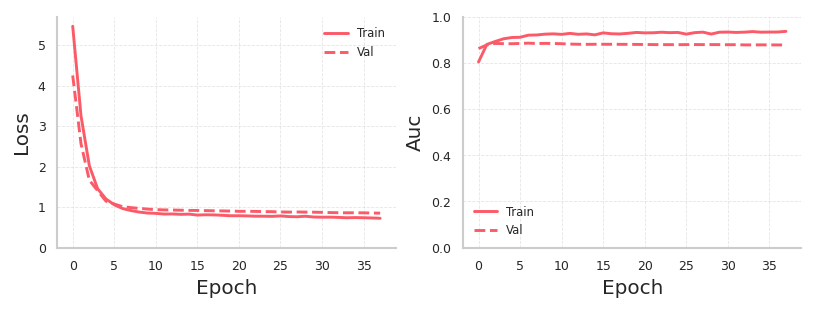

In [ ]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [ ]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Legitimate Transactions Detected (True Negatives):  99
Legitimate Transactions Incorrectly Detected (False Positives):  17
Fraudulent Transactions Missed (False Negatives):  54
Fraudulent Transactions Detected (True Positives):  189
Total Fraudulent Transactions:  243


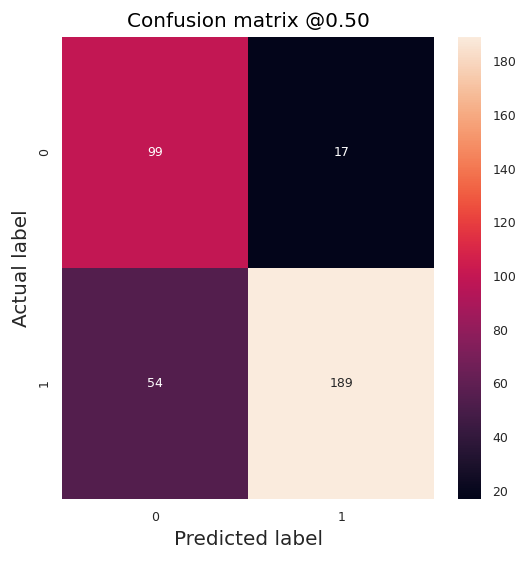

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

Legitimate Transactions Detected (True Negatives):  89
Legitimate Transactions Incorrectly Detected (False Positives):  27
Fraudulent Transactions Missed (False Negatives):  49
Fraudulent Transactions Detected (True Positives):  194
Total Fraudulent Transactions:  243


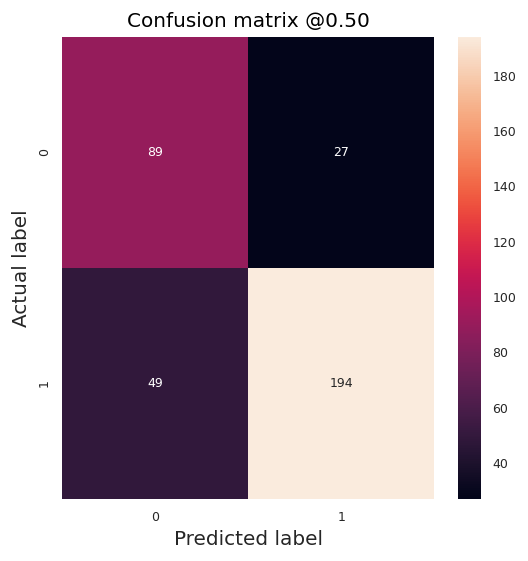

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_tab_v1_all_data_ext.csv")

### 4.3 CNN Classifier

In [ ]:
%%capture
!pip install sktime

In [ ]:
from sktime.classification.deep_learning.cnn import CNNClassifier

METRICS = [
          keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(10_000).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())
  print(label.numpy().shape)
  print(features.numpy().shape)

0.502
(10000, 1)
(10000, 7, 30)


In [ ]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_valid,
                                                                    y_valid,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=2000,
                                                                    shuffle=False
                                                                 )


for batch in dataset_validation.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (359, 7, 30)
Target shape: (359, 1)


In [ ]:
train = np.concatenate((inputs, features), axis=0)
y = np.concatenate((targets, label), axis=0)
train.shape, y.shape

((10359, 7, 30), (10359, 1))

In [ ]:
call_bk = [keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")]

model = CNNClassifier(n_epochs=8, batch_size=64, kernel_size=3, avg_pool_size=2, n_conv_layers=2, callbacks=call_bk,
                      verbose=True, loss=keras.losses.BinaryCrossentropy(), metrics=METRICS, random_state=42,
                      activation='sigmoid', use_bias=True, optimizer=keras.optimizers.Adam(learning_rate=1e-3), filter_sizes=None, padding='auto')

In [ ]:
y_prob_pred = model.fit_predict_proba(train, y, cv=5)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 30, 6)               │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 15, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 15, 12)              │             228 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, 7, 12)               │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 530 (2.07 KB)

 Trainable params: 530 (2.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.5094 - cross entropy: 0.7282 - loss: 0.7282 - prc: 0.5200 - learning_rate: 0.0010
Epoch 2/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6782 - cross entropy: 0.6760 - loss: 0.6760 - prc: 0.6623 - learning_rate: 0.0010
Epoch 3/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7619 - cross entropy: 0.6320 - loss: 0.6320 - prc: 0.7473 - learning_rate: 0.0010
Epoch 4/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8250 - cross entropy: 0.5553 - loss: 0.5553 - prc: 0.8150 - learning_rate: 0.0010
Epoch 5/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8479 - cross entropy: 0.4993 - loss: 0.4993 - prc: 0.8386 - learning_rate: 0.0010
Epoch 6/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8527 - cross entropy: 0.4809 - loss: 0.4809 - prc: 0.8434 - learning_rate: 0.0010
Epoch 7/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8556 - cross entropy: 0.4742 - loss: 0.4742 - prc: 0.8467 - learning_rate: 0.0010
Epoch 

AttributeError: 'numpy.ndarray' object has no attribute 'index'

## Test SKTime:

In [ ]:
%%capture
!pip install sktime

In [ ]:
from sktime.datasets import load_italy_power_demand

In [ ]:
# Increase display width
pd.set_option("display.width", 1000)

## 2.1 Panel data - sktime data formats

Panel is an abstract data type where the values are observed for:

* instance, e.g., patient
* variable, e.g., blood pressure, body temperature of the patient
* time/index, e.g., January 12, 2023 (usually but not necessarily a time index!)
One value X is: "patient 'A' had blood pressure 'X' on January 12, 2023"

Time series classification, regression, clustering: slices Panel data by instance

Preferred format 1: pd.DataFrame with 2-level MultiIndex, (instance, time) and columns: variables

Preferred format 2: 3D np.ndarray with index (instance, variable, time)

* sktime supports and recognizes multiple data formats for convenience and internal use, e.g., dask, xarray
* abstract data type = "scitype"; in-memory specification = "mtype"
* More information in tutorial on in-memory data representations and data loading

## 2.1.1 Preferred format 1 - pd-multiindex specification

pd-multiindex = pd.DataFrame with 2-level MultiIndex, (instance, time) and columns: variables

In [ ]:
from sktime.datasets import load_italy_power_demand

# load an example time series panel in pd-multiindex mtype
X, _ = load_italy_power_demand(return_type="pd-multiindex")

# renaming columns for illustrative purposes
X.columns = ["total_power_demand"]
X.index.names = ["day_ID", "hour_of_day"]

The Italy power demand dataset has:

* 1096 individual time series instances = single days of total power demand (mean subtracted)
* one single variable per time series instances, total_power_demand
    * total power demand on that day, in that hourly period
    * Since there's only one column, it is a univariate dataset
* individual time series are observed at 24 time (period) points (the same number for all instances)

In the dataset, days are jumbled and of different scope (independent sampling).

* considered independent - because hour_of_day in one sample doesn't affect hour_of_day in another
* for task, e.g., "identify season or weekday/weekend from pattern"

In [ ]:
X

total_power_demand
day_ID hour_of_day                    
0      0                     -0.710518
       1                     -1.183320
       2                     -1.372442
       3                     -1.593083
       4                     -1.467002
...                                ...
1095   19                     0.180490
       20                    -0.094058
       21                     0.729587
       22                     0.210995
       23                    -0.002542

[26304 rows x 1 columns]

In [ ]:
from sktime.datasets import load_basic_motions

# load an example time series panel in pd-multiindex mtype
X, _ = load_basic_motions(return_type="pd-multiindex")

# renaming columns for illustrative purposes
X.columns = ["accel_1", "accel_2", "accel_3", "gyro_1", "gyro_2", "gyro_3"]
X.index.names = ["trial_no", "timepoint"]

The basic motions dataset has:

* 80 individual time series instances = trials = person engaging in an activity like running, badminton, etc.
* six variables per time series instance, dim_0 to dim_5 (renamed according to the values they represent)
  * 3 accelerometer and 3 gyrometer measurements
  * hence a multivariate dataset
* individual time series are observed at 100 time points (the same number for all instances)

In [ ]:
# The outermost index represents the instance number
# whereas the inner index represents the index of the particular index
# within that instance.
X

accel_1    accel_2   accel_3    gyro_1    gyro_2    gyro_3
trial_no timepoint                                                              
0        0           0.079106   0.394032  0.551444  0.351565  0.023970  0.633883
         1           0.079106   0.394032  0.551444  0.351565  0.023970  0.633883
         2          -0.903497  -3.666397 -0.282844 -0.095881 -0.319605  0.972131
         3           1.116125  -0.656101  0.333118  1.624657 -0.569962  1.209171
         4           1.638200   1.405135  0.393875  1.187864 -0.271664  1.739182
...                       ...        ...       ...       ...       ...       ...
79       95         28.459024 -16.633770  3.631869  8.978229 -3.611533 -1.491489
         96         10.260094   0.102775  1.269261 -1.645964 -3.377157  1.283746
         97          4.316471  -3.574319  2.063831 -1.717875 -1.843054  0.484734
         98          0.704446  -4.920444  2.851857 -2.982977 -0.809665 -0.721774
         99         -2.074749  -6.892377  4.848379 -1.350330 -1.203844 -1.776470

[8000 rows x 6 columns]

In [ ]:
# Select:
# * the fourth variable (gyroscope 1)
# * of the first instance (trial 1 = 0 in python)
# * values at all 100 timestamps
#
X.loc[0, "gyro_1"]

timepoint
0     0.351565
1     0.351565
2    -0.095881
3     1.624657
4     1.187864
        ...   
95    0.039951
96   -0.029297
97    0.000000
98    0.000000
99   -0.007990
Name: gyro_1, Length: 100, dtype: float64

<Axes: xlabel='timepoint'>

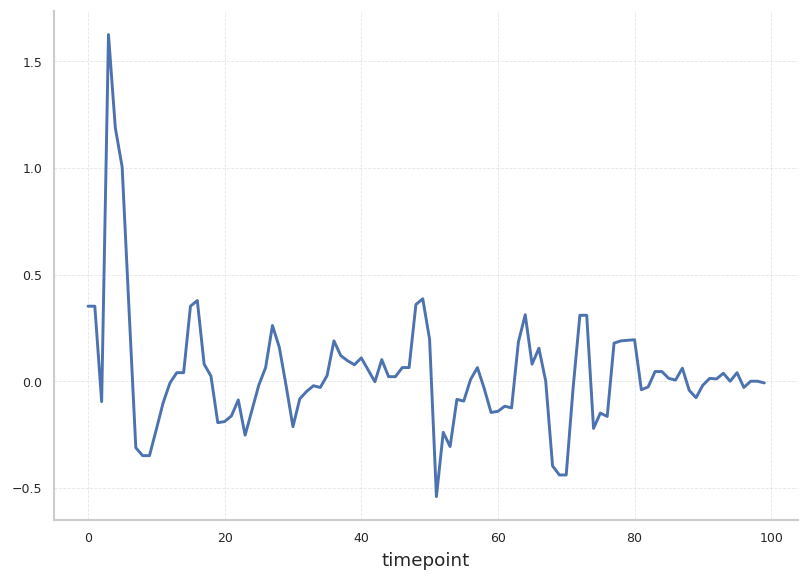

In [ ]:
X.loc[0, "gyro_1"].plot()

## 2.1.2 preferred format 2 - numpy3D

    numpy3D = 3D np.ndarray with index (instance, variable, time)

instance/time index is interpreted as integer

IMPORTANT: unlike pd-multiindex, this assumes:

* all individual series have the same length

* all individual series have the same index

In [ ]:
from sktime.datasets import load_italy_power_demand

# load an example time series panel in numpy mtype
X, _ = load_italy_power_demand(return_type="numpy3D")

In [ ]:
# (num_instances, num_variables, length)
X.shape

(1096, 1, 24)

In [ ]:
from sktime.datasets import load_basic_motions

# load an example time series panel in numpy mtype
X, _ = load_basic_motions(return_type="numpy3D")

In [ ]:
# (num_instances, num_variables, length)
X.shape

(80, 6, 100)

## 2.2.3 Time Series Classification - deployment vignette
Basic deployment vignette for TSC:

load/setup training data, X in a Panel (more specifically numpy3D) format, y as 1D np.ndarray

load/setup new data for prediction (can be done after 3 too)

specify the classifier using sklearn-like syntax

fit classifier to training data, fit(X, y)

predict labels on new data, predict(X_new)

In [ ]:
# steps 1, 2 - prepare osuleaf dataset (train and new)
from sktime.datasets import load_italy_power_demand

X_train, y_train = load_italy_power_demand(split="train", return_type="numpy3D")
X_new, _ = load_italy_power_demand(split="test", return_type="numpy3D")

In [ ]:
# this is in numpy3D format, but could also be pd-multiindex or other
X_train.shape, X_new.shape

((67, 1, 24), (1029, 1, 24))

In [ ]:
# y is a 1D np.ndarray of labels - same length as number of instances in X_train
y_train.shape

(67,)

In [ ]:
# step 3 - specify the classifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

# example 1 - 3-NN with simple dynamic time warping distance (requires numba)
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3)

# example 2 - custom distance:
# 3-nearest neighbour classifier with Euclidean distance (on flattened time series)
# (requires scipy)
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels import FlatDist, ScipyDist

eucl_dist = FlatDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=eucl_dist)

In [ ]:
# all classifiers is scikit-learn / scikit-base compatible!
# nested parameter interface via get_params, set_params
clf.get_params()

{'algorithm': 'brute',
 'distance': FlatDist(transformer=ScipyDist()),
 'distance_mtype': None,
 'distance_params': None,
 'leaf_size': 30,
 'n_jobs': None,
 'n_neighbors': 3,
 'pass_train_distances': False,
 'weights': 'uniform',
 'distance__transformer': ScipyDist(),
 'distance__transformer__colalign': 'intersect',
 'distance__transformer__metric': 'euclidean',
 'distance__transformer__metric_kwargs': None,
 'distance__transformer__p': 2,
 'distance__transformer__var_weights': None}

In [ ]:
# step 4 - fit/train the classifier
clf.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier(distance=FlatDist(transformer=ScipyDist()),
                               n_neighbors=3)

In [ ]:
# the classifier is now fitted
clf.is_fitted

True

In [ ]:
# and we can inspect fitted parameters if we like
clf.get_fitted_params()

{'classes': array(['1', '2'], dtype='<U1'),
 'fit_time': 645,
 'knn_estimator': KNeighborsClassifier(algorithm='brute', metric='precomputed', n_neighbors=3),
 'n_classes': 2,
 'knn_estimator__classes': array(['1', '2'], dtype='<U1'),
 'knn_estimator__effective_metric': 'precomputed',
 'knn_estimator__effective_metric_params': {},
 'knn_estimator__n_features_in': 67,
 'knn_estimator__n_samples_fit': 67,
 'knn_estimator__outputs_2d': False}

In [ ]:
# step 5 - predict labels on new data
y_pred = clf.predict(X_new)
y_prob = clf.predict_proba(X_new)

In [ ]:
# predictions and unique counts, for illustration
unique, counts = np.unique(y_pred, return_counts=True)
unique, counts

(array(['1', '2'], dtype='<U1'), array([510, 519]))

In [ ]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head

# step 1-- prepare a dataset (multivariate for demonstration)
X_train, y_train = load_arrow_head(split="train", return_type="numpy3D")
X_new, _ = load_arrow_head(split="test", return_type="numpy3D")

In [ ]:
X_train.shape, y_train.shape

((36, 1, 251), (36,))

In [ ]:
X_train

array([[[-1.9630089, -1.9578249, -1.9561449, ..., -1.9053929,
         -1.9239049, -1.9091529]],

       [[-1.7745713, -1.7740359, -1.7765863, ..., -1.7292269,
         -1.7756704, -1.7893245]],

       [[-1.8660211, -1.8419912, -1.8350253, ..., -1.8625124,
         -1.8633682, -1.8464925]],

       ...,

       [[-2.1308119, -2.1044297, -2.0747549, ..., -2.0340977,
         -2.0800313, -2.103448 ]],

       [[-1.8803376, -1.8626622, -1.8496866, ..., -1.8485336,
         -1.8640342, -1.8798851]],

       [[-1.80105  , -1.7989155, -1.7783754, ..., -1.7965491,
         -1.7985443, -1.80105  ]]])

In [ ]:
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datasets import load_unit_test
X_train, y_train = load_unit_test(split="train", return_type="numpy3D")
X_test, y_test = load_unit_test(split="test", return_type="numpy3D")

In [ ]:
X_train.shape

(20, 1, 24)

In [ ]:
cnn = CNNClassifier(n_epochs=20,batch_size=4)
cnn.fit(X_train, y_train)

CNNClassifier(batch_size=4, n_epochs=20)